# Diagramme & Tabellen zu SARS-CoV-2 in Österreich

⚠ 📕 Großteils veraltet und nicht mehr regelmäßig gewartet. Auf Anfrage können aber ggf. gerne Diagramme geprüft, adaptiert, etc. werden. 

Erstellt aus <https://github.com/zeitferne/covidat-tools/blob/main/notebooks/covidat-old.ipynb>

Datenquellen sind die AGES (https://covid19-dashboard.ages.at/) und das Gesundheitsministerium (https://info.gesundheitsministerium.gv.at/opendata). Hierbei werden die Bundesländermeldungen (auch genannt "Morgenmeldungen" oder "Krisenstabzahlen") direkt von <https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv> bezogen, alle anderen werden über https://github.com/statistikat/coronaDAT bezogen um auch auf historische Daten zurückgreifen zu können (die Daten selbst sind ident zu den offiziellen, allerdings steht aus offiziellen Quellen jeweils nur die aktuellste Datenversion zur Verfügung).

Tipp: Rechtsklicken auf die Diagramme und "in neuem Tab anzeigen" o.ä. um sie größer darzustellen.

Alle Angaben ohne Gewähr! Auch wenn als Datenquelle die AGES oder das Gesundheitsministerium angegeben ist, stammt die Darstellung & ggf. weitere Auswertung von mir und kann fehlerhaft sein.

Viele Abschnitte die haupts. Informationen zur aktuellen Situation bzw. zu kurzfristigen Änderungen zeigen sind auf GitHub nicht angezeigt. Wagemutige können lokal ausführen (versuchen) und `DISPLAY_SHORTRANGE_DIAGS` von `= False` auf `= True` ändern.

## Hauptabschnitte

* [Meldewesen & Neuinfektionen](#K%C3%BCrzliche-Neuinfektionen-&-Meldewesen)
* [Übersicht Pandemieverlauf](#%C3%9Cbersicht-Pandemieverlauf)
* [Hotspots](#Hotspots-in-Bezirken-und-Altersgruppen-und-Ver%C3%A4nderung)
* [Bezirke](#Bezirke)
* [Tests](#Tests)
* [Altersgruppen](#Altersgruppen-und-Bundesl%C3%A4ndern)
* [Änderungsraten](#%C3%84nderungsraten)
  * [Zusammenhänge Infektionen vs. Hospitalisierte & Tote](#%C3%84nderung-Inzidenz-vs.-Krankenhausbelegung-&-Tote)
* [Hospitalisierung](#Hospitalisierung)
* [Todesfälle](#Todesf%C3%A4lle)
  * [Prognose Todesfälle](#Prognose-Todesf%C3%A4lle)
* [Impfungen](#Impfungen)
* [OÖ Landeskorrespondenz](#Aus-der-O%C3%96-Landeskorrespondenz)
* [Verschiedenes](#Verschiedenes)
* [Abwasser](#Abwasser)
* [Varianten](#Varianten)

In [ ]:
DISPLAY_SHORTRANGE_DIAGS = False

In [ ]:
import locale

locale.setlocale(locale.LC_ALL, "de_AT.UTF-8");

In [ ]:
%matplotlib inline
%precision %.4f
# %load_ext snakeviz
import colorcet
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker
import matplotlib.patches
import matplotlib.colors
import seaborn as sns
from importlib import reload
from itertools import count
from datetime import date, datetime, timedelta
from IPython.display import display, Markdown, HTML
import textwrap
from functools import partial
from cycler import cycler

from covidat import cov, covdata
from covidat.cov import sortedlabels, labelend2

pd.options.display.precision = 4

plt.rcParams['figure.figsize'] = (16 * 0.7, 9 * 0.7)
plt.rcParams['figure.dpi'] = 120  # 80
plt.rcParams['figure.facecolor'] = '#fff'
sns.set_theme(style="whitegrid")
sns.set_palette('tab10')

plt.rcParams['image.cmap'] = cov.un_cmap

pd.options.display.max_rows = 120
pd.options.display.min_rows = 40

In [ ]:
from covidat.util import COLLECTROOT, DATAROOT

print("collect-root:", COLLECTROOT)
print("data-root:", DATAROOT)

In [ ]:
MIDRANGE_NDAYS = 120
SHORTRANGE_NDAYS = 91 + 1
DETAIL_NDAYS = 42 + 1
DETAIL_SMALL_NDAYS = 35 + 1

In [ ]:
def nextday(dt):
    return dt + timedelta(1)


# Find gaps (max size 1) & fill them
def fixgaps1(df, namecol, datecol, fixcols, allowlarge=False):
    followdt = nextday(df.iloc[0][datecol])
    newdfs = [df]
    groups = iter(df.groupby(datecol, sort=False, as_index=False))
    next(groups)  # Drop first
    for dt, items in groups:
        i_dt = items.iloc[0].name
        n_bl = len(items)
        # print(i_dt)
        if followdt.tz_localize(None).normalize() != dt.tz_localize(None).normalize():
            # print("Prev", df.iloc[i_dt - n_bl])
            gapsize = dt.tz_localize(None).normalize() - followdt.tz_localize(None).normalize()
            print("Gap: Expected", followdt, "found", dt, "size", gapsize)
            if gapsize > timedelta(1) and not allowlarge:
                raise ValueError("Gap larger than one day, unable to correct")
            prevrows = df.iloc[i_dt - n_bl : i_dt]
            nextrows = df.iloc[i_dt : i_dt + n_bl]
            # print(prevrows.iloc[-1][datecol], nextrows.iloc[-1][datecol])
            # print(prevrows.iloc[0], nextrows.iloc[0])
            for gapidx in range(gapsize.days):
                newdf = prevrows.copy()
                newdf[datecol] = followdt
                coeff = (gapidx + 1) / (gapsize.days + 1)
                # print(gapidx, coeff)
                for col in fixcols:
                    newdf[col] = (
                        prevrows[col].to_numpy() + (nextrows[col].to_numpy() - prevrows[col].to_numpy()) * coeff
                    )
                followdt = nextday(followdt)
                newdfs.append(newdf)
        followdt = nextday(dt)
    df = pd.concat(newdfs)
    df.sort_values(by=[datecol, namecol], inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [ ]:
def erase_outliers(series, q=0.9, maxfactor=10, rwidth=21, mode="mean2", fillnan=False):
    series = series.copy()
    outliers = (
        (series > series.rolling(rwidth).quantile(q).clip(lower=1) * maxfactor)
        | (series < 0)
        | (fillnan & ~np.isfinite(series))
    )
    nseries = series  # .where(~outliers)
    if mode == "mean2":
        series[outliers] = (nseries.shift(14) + nseries.shift(7)) / 2
    elif mode == "zero":
        series[outliers] = 0
    else:
        raise ValueError(f"Bad mode: {mode}")
    return series


def dodgeannot(annots, ax):
    """annots must be a list of tuples (y, text, kwargs).


    Modifies the list in-place to adjust Y-positions for minimal overlap.
    """

    yrng = ax.get_ylim()[1] - ax.get_ylim()[0]

    annots.sort(key=lambda a: a[0])
    changed = True
    for i in range(30):
        if not changed:
            break
        changed = False
        for i, annot in enumerate(annots[1:], 1):
            p_annot = annots[i - 1]
            if annot[0] - p_annot[0] < yrng * 0.07:
                changed = True
                annots[i] = (annot[0] + yrng * 0.015, *annot[1:])
                annots[i - 1] = (p_annot[0] - yrng * 0.01, *p_annot[1:])

    for annot in annots:
        ax.annotate(annot[1], (ax.get_xlim()[1], annot[0]), va="center", **annot[2])


def plot_colorful_gcol(ax, dates, growth, name="Inzidenz", detailed=False, draw1=True, **kwargs):
    mpos = growth > 1
    mgrow = growth > growth.shift()
    # mgrow |= mgrow.shift(-1)
    # mgrow = mgrow.shift()
    # ax.stackplot([fsbl["Datum"].iloc[0], fsbl["Datum"].iloc[-1]], 1, 100, colors=["blue", "red"], alpha=0.3)
    if draw1:
        ax.axhline(1, color="k", lw=1)
    ax.plot(dates, growth, color="C4", label=f"Steigende {name}", marker='.', **kwargs)
    ax.plot(
        dates,
        growth.where(~mpos),
        color="C0",
        label=f"Sinkende {name}",
        marker=".",
        # markersize=1.5
        **kwargs,
    )
    if detailed:
        ax.plot(
            dates,
            growth.where(~mpos & mgrow),
            color="C1",
            label=f"Verlangsamt sinkende {name}",
            marker=".",
            # markersize=1.5
            **kwargs,
        )
    ax.plot(
        dates,
        growth.where(mpos & mgrow),
        color="C3",
        label=f"Beschleunigt steigende {name}",
        marker=".",
        # markersize=1.5
        **kwargs,
    )


def enrich_agd(agd, fs):
    # display(agd)
    agd["AnzahlFaelleSumProEW"] = agd["AnzahlFaelleSum"] / agd["AnzEinwohner"]
    agg = {
        "Altersgruppe": "first",
        # "Bundesland": "first", # Bug (slowness) with categorical dtype
        "AnzEinwohner": np.sum,
        "AnzEinwohnerFixed": np.sum,
        "AnzahlFaelle": np.sum,
        "AnzahlFaelleSum": np.sum,
        "AnzahlTotSum": np.sum,
        "AnzahlGeheilt": np.sum,
        "Bundesland": "first",
    }
    if "AnzahlFaelleMeldeDiff" in agd.columns:
        agg.update(
            {
                "AnzahlFaelleMeldeDiff": np.sum,
            }
        )
    if "AgeFrom" in agd.columns:
        agg.update(
            {
                "AgeFrom": "first",
                "AgeTo": "first",
            }
        )
    if "FileDate" in agd.columns:
        agg.update(
            {
                "FileDate": "first",
            }
        )
    agd_sums = agd.groupby(["Datum", "BundeslandID", "AltersgruppeID"], as_index=False, group_keys=False).agg(
        agg
    )  # Group over Geschlecht

    if fs is not None:
        per_state = fs.copy()
        per_state["Altersgruppe"] = "Alle"
        # per_state["Bundesland"] = "Alle"
        # per_state["AgeFrom"] = 0
        # per_state["AgeTo"] = np.iinfo(agd_sums["AgeTo"].dtype).max
        per_state["AltersgruppeID"] = 0
        per_state.drop(columns="AnzahlGeheilt", inplace=True, errors="ignore")
        per_state.rename(columns={"AnzahlGeheiltSum": "AnzahlGeheilt"}, inplace=True)
        agd_sums = pd.concat([per_state, agd_sums])
        # agd_sums["Bundesland"] = agd_sums["BundeslandID"].replace(cov.BUNDESLAND_BY_ID)
    agd_sums["BLCat"] = agd_sums["Bundesland"].astype(cov.Bundesland)
    agd_sums["Gruppe"] = agd_sums["Bundesland"].str.cat([agd_sums["Altersgruppe"]], sep=" ")
    with cov.calc_shifted(agd_sums, ["Bundesland", "AltersgruppeID"], 7, newcols=["inz", "AnzahlFaelle7Tage"]):
        agd_sums["inz"] = cov.calc_inz(agd_sums)
        agd_sums["AnzahlFaelle7Tage"] = agd_sums["AnzahlFaelle"].rolling(7).sum()
    with cov.calc_shifted(agd_sums, ["Bundesland", "AltersgruppeID"], newcols=["AnzahlTot"]):
        agd_sums["AnzahlTot"] = agd_sums["AnzahlTotSum"].diff()
    agd_sums["AnzahlFaelleProEW"] = agd_sums["AnzahlFaelle"] / agd_sums["AnzEinwohner"]
    agd_sums["AnzahlFaelleSumProEW"] = agd_sums["AnzahlFaelleSum"] / agd_sums["AnzEinwohner"]
    cov.enrich_inz(agd_sums, catcol=["Bundesland", "AltersgruppeID"])
    agd_sums.reset_index(drop=True, inplace=True)

    return agd_sums

In [ ]:
statbev = cov.load_bev()
pandembev = cov.bev_to_daily(statbev)

In [ ]:
# %%time
daydate = date(2023, 6, 30)
cov = reload(cov)
ages_version = cov.load_day("Version.csv", daydate)
display(ages_version)
if ages_version["VersionsNr"].iloc[-1] != "V 2.7.0.0" or len(ages_version) != 1:
    raise ValueError("AGES version update, new=" + str(ages_version["VersionsNr"].iloc[-1]))

ages_vdate = pd.to_datetime(ages_version.iloc[0]["CreationDate"], dayfirst=True)
fs = cov.load_faelle(bev=pandembev, daydate=daydate)
fs["FileDate"] = ages_vdate
cov.enrich_inz(fs, catcol="BundeslandID")
fs["AnzahlFaelleSumProEW"] = fs["AnzahlFaelleSum"] / fs["AnzEinwohner"]
fs["AnzahlFaelleProEW"] = fs["AnzahlFaelle"] / fs["AnzEinwohner"]
fs["BLCat"] = fs["Bundesland"].astype(cov.Bundesland)

with cov.calc_shifted(fs, "BundeslandID", 1) as shifted:
    fs["AnzTests"] = fs["TestGesamt"] - shifted["TestGesamt"]
    fs["TestPosRate"] = fs["AnzahlFaelle"] / fs["AnzTests"]
with cov.calc_shifted(fs, "BundeslandID", 7) as shifted:
    fs["TestPosRate_a7"] = fs["AnzahlFaelle"].rolling(7).sum() / fs["AnzTests"].rolling(7).sum()

fs_at = fs.query("Bundesland == 'Österreich'").copy()

hosp = cov.add_date(cov.load_day("Hospitalisierung.csv", daydate), "Meldedatum")
hosp["IntensivBettenFreiPro100"] = hosp["IntensivBettenFrei"] / hosp["IntensivBettenKapGes"] * 100
hosp["IntensivBettenBelGes"] = hosp["IntensivBettenBelCovid19"] + hosp["IntensivBettenBelNichtCovid19"]
with cov.calc_shifted(hosp, "BundeslandID", 7):
    hosp["IntensivBettenFreiPro100_a7"] = hosp["IntensivBettenFreiPro100"].rolling(7).mean()
    hosp["IntensivBettenBelGes_a7"] = hosp["IntensivBettenBelGes"].rolling(7).mean()
hosp["AnteilCov"] = hosp["IntensivBettenBelCovid19"] / hosp["IntensivBettenBelGes"]
hosp["AnteilNichtCov"] = hosp["IntensivBettenBelNichtCovid19"] / hosp["IntensivBettenBelGes"]


# gis_o = cov.load_gem_impfungen()

DTFMT = "%a %c"

bez_orig = cov.load_bezirke(daydate)
bez = cov.enrich_bez(bez_orig, fs)
bez["FileDate"] = ages_vdate

agd = cov.load_ag(bev=pandembev, daydate=daydate)
agd["FileDate"] = ages_vdate
with cov.calc_shifted(agd, ["Gruppe"]) as shifted:
    agd["AnzahlTot"] = agd["AnzahlTotSum"] - shifted["AnzahlTotSum"]

agd_sums = enrich_agd(agd, fs)
agd_sums_at = agd_sums.query("Bundesland == 'Österreich'")
ag_to_id = agd_sums_at.set_index("Altersgruppe")["AltersgruppeID"].to_dict()
cov.enrich_inz(agd, catcol="Gruppe")

hospfz = (
    cov.norm_df(cov.load_day("CovidFallzahlen.csv", daydate), datecol="Meldedat", format=cov.AGES_DATE_FMT).set_index(
        ["Datum", "BundeslandID"]
    )
).drop(columns="MeldeDatum")
hospfz["Bundesland"].replace("Alle", "Österreich", inplace=True)
hospfz["AnzEinwohner"] = fs.set_index(["Datum", "BundeslandID"])["AnzEinwohner"]
hospfz["AnzEinwohner"].ffill(inplace=True)


def recalc_at_hosp(hospfz):
    scols = ["FZHosp", "FZHospFree", "FZICU", "FZICUFree"]
    hospfz_sum = hospfz.query("BundeslandID != 10").groupby(level="Datum")[scols].sum()
    # display(hospfz_sum)
    hospfz.loc[(pd.IndexSlice[:], 10), scols] = hospfz_sum.to_numpy()


if False:
    # MANUAL FIX according to https://coronavirus.wien.gv.at/aktuelle-kennzahlen-aus-wien/
    hospfz.loc[(pd.to_datetime("2022-11-02"), 9), "FZHosp"] = 456
    hospfz.loc[(pd.to_datetime("2022-11-03"), 9), "FZHosp"] = 455
    hospfz.loc[(pd.to_datetime("2022-11-04"), 9), "FZHosp"] = 444
    # CoV+Post+Nicht
    hospfz.loc[(pd.to_datetime("2022-11-05"), 9), "FZHosp"] = 103 + 218 + 117
    hospfz.loc[(pd.to_datetime("2022-11-06"), 9), "FZHosp"] = 96 + 210 + 111
    hospfz.loc[(pd.to_datetime("2022-11-07"), 9), "FZHosp"] = 101 + 226 + 115
    hospfz.loc[(pd.to_datetime("2022-11-08"), 9), "FZHosp"] = 108 + 241 + 115
    hospfz.loc[(pd.to_datetime("2022-11-09"), 9), "FZHosp"] = 105 + 231 + 109
    hospfz.loc[(pd.to_datetime("2022-11-10"), 9), "FZHosp"] = 103 + 215 + 110

    recalc_at_hospfz(hospfz)


# hospfz.loc[10] = hospfz[hospfz["Bundesland"] != "Österreich"].groupby("Datum").sum(numeric_only=True).assign(Bundesland="Österreich")
# hospfz.loc[10, "Bundesland"] = "Österreich"

hospfz.reset_index(inplace=True)
cov.enrich_hosp_data(hospfz)
while not (cov.filterlatest(hospfz)[["FZHosp", "FZICU"]] != 0).any().any():
    print("Dropping All-Zero hospitalization data for " + str(hospfz.iloc[-1]["Datum"]))
    hospfz = hospfz[hospfz["Datum"] != hospfz.iloc[-1]["Datum"]]


AGES_STAMP = " (AGES " + ages_vdate.strftime("%a %d.%m.%y") + ")"

In [ ]:
cov = reload(cov)


def load_hist(
    fname="CovidFaelle_Timeline.csv", catcol="BundeslandID", ndays=31 * 2, normalize=lambda df: df, csv_args=None
):
    ages_hist_keys = ["Datum"] + ([catcol] if isinstance(catcol, str) else catcol) + ["FileDate"]
    ages_hist = cov.loadall(fname, ndays, normalize, csv_args=csv_args)
    if "Time" in ages_hist.columns:
        cov.add_date(ages_hist, "Time", format=cov.AGES_TIME_FMT)
    ages_hist.sort_values(by=ages_hist_keys, inplace=True)
    ages_hist.reset_index(drop=True, inplace=True)
    print(
        "Loaded",
        fname,
        "from",
        ages_hist.iloc[0][["Datum", "FileDate"]],
        "to",
        ages_hist.iloc[-1][["Datum", "FileDate"]],
        "requested",
        ndays,
        "got",
        ages_hist["FileDate"].nunique(),
    )
    sumcol = "AnzahlFaelleSum"
    dsumcol = "AnzahlTotSum"
    hsumcol = "AnzahlGeheiltSum"
    lastfiledate = None
    for filedate in np.sort(ages_hist["FileDate"].unique()):
        if lastfiledate and filedate - lastfiledate != np.timedelta64(1, 'D'):
            raise ValueError(f"Gap in data between {lastfiledate} and {filedate}")
        lastfiledate = filedate

        mask = ages_hist["FileDate"] == filedate
        masked = ages_hist.loc[mask].copy()
        with cov.calc_shifted(masked, ages_hist_keys[1:], 7, newcols=["inz", "AnzahlTot7Tage"]) as shifted:
            masked["inz"] = (masked[sumcol] - shifted[sumcol]) / masked["AnzEinwohner"] * 100_000
            masked["AnzahlTot7Tage"] = masked[dsumcol] - shifted[dsumcol]
        ages_hist.loc[mask, ["inz", "AnzahlTot7Tage"]] = masked
    ages1 = ages_hist[ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(1)].copy()
    with cov.calc_shifted(ages1, catcol) as shifted:
        ages1["AnzahlFaelleMeldeDiff"] = ages1[sumcol] - shifted[sumcol]
        ages1["AnzahlTotMeldeDiff"] = ages1[dsumcol] - shifted[dsumcol]
        if hsumcol in ages1.columns:
            ages1["AnzahlGeheiltMeldeDiff"] = ages1[hsumcol] - shifted[hsumcol]
    ages1m = ages1.drop(
        columns=[
            "AnzahlFaelle",
            "SiebenTageInzidenzFaelle",
            "AnzahlFaelle7Tage",
            "AnzahlTot",
            "AnzahlTotTaeglich",
            "AnzahlGeheiltTaeglich",
        ],
        errors="ignore",
    ).rename(
        columns={
            "AnzahlFaelleMeldeDiff": "AnzahlFaelle",
            "AnzahlTotMeldeDiff": "AnzahlTot",
            "AnzahlGeheiltMeldeDiff": "AnzahlGeheilt",
        }
    )
    ages1m["Datum"] = ages1m["FileDate"]
    with cov.calc_shifted(ages1m, catcol, 7, newcols=["inz"]):
        ages1m["inz"] = cov.calc_inz(ages1m)
    cov.enrich_inz(ages1m, catcol=catcol)
    return ages1, ages1m, ages_hist


if True:
    cols = {
        "Time": str,
        "Bundesland": str,
        "BundeslandID": np.uint8,
        "AnzEinwohner": int,
        "AnzahlFaelle": int,
        "AnzahlFaelleSum": int,
        "AnzahlFaelle7Tage": int,
        "AnzahlTotTaeglich": int,
        "AnzahlTotSum": int,
        "AnzahlGeheiltTaeglich": int,
        "AnzahlGeheiltSum": int,
    }
    ages1, ages1m, ages_hist = load_hist(ndays=2000, csv_args=dict(engine="c", dtype=cols, usecols=list(cols.keys())))
    ages1.rename(columns={"AnzahlTotTaeglich": "AnzahlTot", "AnzahlGeheiltTaeglich": "AnzahlGeheilt"}, inplace=True)

In [ ]:
# %%prun -D program.prof
# %%time

cols = {
    "Time": str,
    "Bundesland": str,
    "BundeslandID": int,
    "AnzEinwohner": int,
    "Anzahl": int,
    "AnzahlTot": int,
    "AnzahlGeheilt": int,
    "AltersgruppeID": int,
    "Geschlecht": str,
    "Altersgruppe": str,
    # "AnzahlGeheiltTaeglich": int,
    # "AnzahlGeheiltSum": int,
}
agd1, agd1m, agd_hist = load_hist(
    "CovidFaelle_Altersgruppe.csv",
    ["AltersgruppeID", "BundeslandID", "Geschlecht"],
    52,
    normalize=lambda ds: ds.rename(columns={"AnzahlTot": "AnzahlTotSum", "Anzahl": "AnzahlFaelleSum"}, errors="raise"),
    csv_args=dict(engine="c", dtype=cols, usecols=list(cols.keys())),
)
# agd1m["Gruppe"] = agd1m["Bundesland"].str.cat(
#        [agd1m["Altersgruppe"], agd1m["Geschlecht"]], sep=" "
#    )
agd1m = cov.enrich_ag(agd1m.drop(columns="FileDate"), parsedate=False)
agd_hist_o = agd_hist.copy()
agd_hist = cov.enrich_ag(agd_hist, agefromto=False, parsedate=False)
agd1 = agd_hist[agd_hist["FileDate"] == agd_hist["Datum"] + timedelta(1)].copy()
agd1 = agd1.merge(
    agd1m[["Datum", "Bundesland", "Altersgruppe", "Geschlecht", "AnzahlFaelle"]].rename(
        columns={"AnzahlFaelle": "AnzahlFaelleMeldeDiff"}
    ),
    left_on=["FileDate", "Bundesland", "Altersgruppe", "Geschlecht"],
    right_on=["Datum", "Bundesland", "Altersgruppe", "Geschlecht"],
    suffixes=(None, "_x"),
).drop(columns=["Datum_x"])
agd1m_sums = enrich_agd(agd1m, ages1m)
with cov.calc_shifted(agd1m, ["Gruppe"], newcols=["AnzahlTot"]) as shifted:
    agd1m["AnzahlTot"] = agd1m["AnzahlTotSum"] - shifted["AnzahlTotSum"]

cols = {
    "Time": str,
    # "Bundesland": str,
    "GKZ": int,
    "Bezirk": str,
    "AnzEinwohner": int,
    "AnzahlFaelle": int,
    "AnzahlFaelleSum": int,
    "AnzahlFaelle7Tage": int,
    "AnzahlTotTaeglich": int,
    "AnzahlTotSum": int,
    # "AnzahlGeheiltTaeglich": int,
    # "AnzahlGeheiltSum": int,
}
bez1, bez1m, bez_hist = load_hist(
    "CovidFaelle_Timeline_GKZ.csv", "Bezirk", 52, csv_args=dict(engine="c", dtype=cols, usecols=list(cols.keys()))
)
bez1m = cov.enrich_bez(bez1m, ages1m)

In [ ]:
ems_o = pd.read_csv(DATAROOT / "covid/morgenmeldung/timeline-faelle-ems.csv", sep=";")
ems_o["Datum"] = cov.parseutc_at(ems_o["Datum"], format=covdata.ISO_TIME_TZ_FMT)
print("EMS", ems_o.iloc[-1]["Datum"], ems_o.iloc[0]["Datum"])
ems_o = fixgaps1(ems_o, "Name", "Datum", ["BestaetigteFaelleEMS"])

In [ ]:
mms_o = pd.read_csv(
    DATAROOT / "covid/morgenmeldung/timeline-faelle-bundeslaender.csv",
    sep=";",
    # encoding="cp1252"
)
mms_o["Datum"] = cov.parseutc_at(mms_o["Datum"], format=covdata.ISO_TIME_TZ_FMT)

print("BMI", mms_o.iloc[-1]["Datum"], mms_o.iloc[0]["Datum"])

In [ ]:
def load_apo(enc):
    return pd.read_csv(
        DATAROOT / "covid/morgenmeldung/timeline-testungen-apotheken-betriebe.csv",
        sep=";",
        decimal=",",
        thousands=".",
        encoding=enc,
        dtype={"Datum": str},
    )


try:
    apo_o = load_apo("utf-8")
except UnicodeDecodeError:
    apo_o = load_apo("cp1252")
apo_o["Datum"] = cov.parseutc_at(apo_o["Datum"], format=covdata.AGES_DATE_FMT)

print("Apotheken", apo_o.iloc[-1]["Datum"], apo_o.iloc[0]["Datum"])

In [ ]:
reinf_o = pd.read_csv(DATAROOT / "covid/ages-ems-extra/Reinfektionen_latest.csv", sep=";", decimal=",").rename(
    columns={"Monat": "Datum"}
)
reinf = reinf_o.query("Datum != ''").copy()
reinf["Datum"] = pd.to_datetime(
    reinf["Datum"].str.replace("Jan", "Jän", regex=False).str.replace("Mrz", "Mär", regex=False), format="%b %y"
)
reinf.set_index("Datum", inplace=True)

In [ ]:
display(
    HTML(
        f"""
<p><strong>Auswertung vom:</strong> {datetime.now().strftime(DTFMT)}
<p><strong>Letzte enthaltene Daten vom:</strong>
<ul>
  <li> AGES: {ages_vdate.strftime(DTFMT)}
  
      {ages_version.to_html(index=False)}
  </li>
  <li> EMS Morgenmeldungen: {ems_o.iloc[-1]["Datum"].strftime(DTFMT)}</li>
  <li> Bundesländermeldungen: {mms_o.iloc[-1]["Datum"].strftime(DTFMT)}</li>
  <li> Apotheken-Tests: {apo_o.iloc[-1]["Datum"].strftime(DTFMT)}</li>
</ul>
"""
    )
);

In [ ]:
def doubling_time(g):
    # x * g**t = 2x # Solve for t
    # g**t = 2
    # log(g) * t = log(2)
    # t = log(2) / log(g)
    return np.log(2) / np.log(g)

In [ ]:
7 * doubling_time(cov.filterlatest(fs_at).iloc[-1]["inz_g7"])

In [ ]:
def pctc(n, emoji=False, percent=True):
    p = n * 100 - 100
    result = (
        ("±0" if np.isnan(p) or n == 1 else format(np.round(p), "+n") if n >= 1.995 or n <= 0 else format(p, "+.2n"))
        .replace("-", "‒")
        .replace("inf", "∞")
    )
    if percent:
        result += "%"
    if emoji:
        if 0.97 < n < 1.03:
            pass
        elif n <= np.exp(np.log(0.5) / 2):  # 2 weeks halving
            result += " ⏬"
        elif n < 1:
            result += " ↘"
        elif n >= 2:  # 1 weeks doubling
            result += " 🔥"
        elif n >= np.exp(np.log(2) / 2):  # 2 weeks doubling
            result += " ⏫"
        elif n > 1:
            result += " ↗"
    return result

In [ ]:
np.exp(np.log(2) / 2)

In [ ]:
agd1_sums = enrich_agd(agd1, ages1)

In [ ]:
ages_old = ages_hist[ages_hist["FileDate"] == ages_hist.iloc[-1]["FileDate"] - timedelta(1)].copy()
ages_old.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)
ages_old2 = ages_hist[ages_hist["FileDate"] == ages_hist.iloc[-1]["FileDate"] - timedelta(2)].copy()
ages_old2.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)
ages_old7 = ages_hist[ages_hist["FileDate"] == ages_hist.iloc[-1]["FileDate"] - timedelta(7)].copy()
ages_old7.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)

agd_old = cov.enrich_ag(
    agd_hist[agd_hist["FileDate"] == agd_hist.iloc[-1]["FileDate"] - timedelta(1)].copy(),
    agefromto=False,
    parsedate=False,
)
agd_old2 = cov.enrich_ag(
    agd_hist[agd_hist["FileDate"] == agd_hist.iloc[-1]["FileDate"] - timedelta(2)].copy(),
    agefromto=False,
    parsedate=False,
)
agd_old7 = cov.enrich_ag(
    agd_hist[agd_hist["FileDate"] == agd_hist.iloc[-1]["FileDate"] - timedelta(7)].copy(),
    agefromto=False,
    parsedate=False,
)
for agdh in (agd_old, agd_old2, agd_old7):
    with cov.calc_shifted(agdh, ["Gruppe"]) as shifted:
        agdh["AnzahlTot"] = agdh["AnzahlTotSum"] - shifted["AnzahlTotSum"]
agd_sums_old = enrich_agd(agd_old, ages_old)
agd_sums_old2 = enrich_agd(agd_old2, ages_old2)
agd_sums_old7 = enrich_agd(agd_old7, ages_old7)

bez_old = bez_hist[bez_hist["FileDate"] == bez_hist.iloc[-1]["FileDate"] - timedelta(1)].copy()
bez_old.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)
bez_old = cov.enrich_bez(bez_old, ages_old)

bez_old2 = bez_hist[bez_hist["FileDate"] == bez_hist.iloc[-1]["FileDate"] - timedelta(2)].copy()
bez_old2.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)
bez_old2 = cov.enrich_bez(bez_old2, ages_old2)

bez_old7 = bez_hist[bez_hist["FileDate"] == bez_hist.iloc[-1]["FileDate"] - timedelta(7)].copy()
bez_old7.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)
bez_old7 = cov.enrich_bez(bez_old7, ages_old7)

In [ ]:
schul_o = pd.read_csv(
    DATAROOT / "covid/morgenmeldung/timeline-testungen-schulen.csv",
    sep=";",
    # encoding="cp1252"
)
schul_o["Datum"] = cov.parseutc_at(schul_o["Datum"], format=covdata.ISO_DATE_FMT)

print("timeline-testungen-schulen", schul_o.iloc[-1]["Datum"], schul_o.iloc[0]["Datum"])

In [ ]:
bltest_o = pd.read_csv(
    DATAROOT / "covid/morgenmeldung/timeline-testungen-bundeslaender.csv",
    sep=";",
    # encoding="cp1252"
)
bltest_o["Datum"] = cov.parseutc_at(bltest_o["Datum"], format=covdata.ISO_TIME_TZ_FMT)

print("timeline-testungen-bundeslaender", bltest_o.iloc[-1]["Datum"], bltest_o.iloc[0]["Datum"])

In [ ]:
schul = schul_o.copy()
schul["Datum"] = schul["Datum"].dt.normalize().dt.tz_localize(None)
schul.set_index(["BundeslandID", "Datum"], inplace=True)
schul.rename(
    columns={
        "Name": "Bundesland",
        "TestungenSchulenPCR": "PCRSum",
        "TestungenSchulen": "TestsSum",
        "TestungenSchulenAntigen": "AntigenSum",
    },
    inplace=True,
)
schul["PCRSum"].fillna(0, inplace=True)
schul["PCR"] = schul.groupby(level="BundeslandID")["PCRSum"].transform(lambda s: s.diff())
schul["Tests"] = schul.groupby(level="BundeslandID")["TestsSum"].transform(lambda s: s.diff())
# schul.loc[np.isnan(schul["PCR"]), "PCR"] = schul["PCRSum"]

schul["Antigen"] = schul.groupby(level="BundeslandID")["AntigenSum"].transform(lambda s: s.diff())
# schul.loc[np.isnan(schul["Antigen"]), "Antigen"] = schul["AntigenSum"]

apo = apo_o.copy()
apo.rename(
    inplace=True,
    columns={
        "Name": "Bundesland",
        "TestungenApothekenPCR": "PCRSum",
        "TestungenApotheken": "TestsSum",
        "TestungenApothekenAntigen": "AntigenSum",
        "TestungenBetriebe": "TestsBetriebSum",
    },
)
with cov.calc_shifted(apo, "BundeslandID", 1) as shifted:
    for colname in apo.columns:
        if not colname.endswith("Sum"):
            continue
        apo[colname[: -len("Sum")]] = apo[colname] - shifted[colname]
apo["Datum"] = apo["Datum"].dt.normalize().dt.tz_localize(None) + timedelta(1)
apo.set_index(["BundeslandID", "Datum"], inplace=True)

In [ ]:
def rollupneg(vs):
    poscount = vs.gt(0).cumsum()
    gs = vs.groupby(poscount)
    return gs.transform(lambda s: s.mean())


# data = pd.Series([100, -10, -20, 10, 4, -1], name="d")
# corr = rollupneg(data).sort_index().rename("c")
# display(pd.DataFrame((data, corr)).T)

In [ ]:
cov = reload(cov)


def rollupallneg(df):
    for bl in df["BundeslandID"].unique():
        mask = df["BundeslandID"] == bl
        df.loc[mask, "AnzahlFaelle"] = rollupneg(df.loc[mask, "AnzahlFaelle"])
        df.loc[mask, "AnzahlFaelleSum"] = df.loc[mask, "AnzahlFaelleSum"].cumsum()
    mask_at = df["BundeslandID"] == 10
    # print(len(mask_at[mask_at]))
    corrcols = ["AnzahlFaelle", "AnzahlFaelleSum"]
    sums = df.loc[~mask_at, corrcols + ["Datum"]].groupby("Datum").sum()
    # display(sums)
    df.loc[mask_at, corrcols] = sums.to_numpy()


# TODO: Join by date for correct historical data
ew_by_bundesland = cov.filterlatest(fs).set_index("Bundesland")["AnzEinwohner"].to_dict()

ems = ems_o.rename(columns={"Name": "Bundesland", "BestaetigteFaelleEMS": "AnzahlFaelleSum"})
ems["AnzEinwohner"] = ems["Bundesland"].replace(ew_by_bundesland)
with cov.calc_shifted(ems, "BundeslandID", 1) as shifted:
    ems["AnzahlFaelle"] = ems["AnzahlFaelleSum"] - shifted["AnzahlFaelleSum"]
# rollupallneg(ems)
with cov.calc_shifted(ems, "BundeslandID", 7) as shifted:
    ems["inz"] = cov.calc_inz(ems)
cov.enrich_inz(ems, catcol="Bundesland")

mms = mms_o.copy()
mms.rename(
    inplace=True,
    columns={
        "Name": "Bundesland",
        "Intensivstation": "FZICU",
        "Hospitalisierung": "FZHosp",
        "BestaetigteFaelleBundeslaender": "AnzahlFaelleSum",
        "Todesfaelle": "AnzahlTotSum",
        "Genesen": "AnzahlGeheiltSum",
        "Testungen": "TestsSum",
        "TestungenPCR": "PCRSum",
        "TestungenAntigen": "AntigenSum",
    },
)
mms["FZHosp"] -= mms["FZICU"]
mms["Datum"] = mms["Datum"].dt.normalize().dt.tz_localize(None)
# mms["AnzahlFaelleSum"] = mms["AnzahlFaelleSum"].str.replace(",00", "").str.replace(".", "", regex=False)
mms.set_index(["BundeslandID", "Datum"], inplace=True)
mms["AnzEinwohner"] = fs.set_index(["BundeslandID", "Datum"])["AnzEinwohner"]
mms.loc[~np.isfinite(mms["AnzEinwohner"]), "AnzEinwohner"] = mms["Bundesland"].map(ew_by_bundesland)
mms.sort_index(inplace=True)
rowkey = (9, pd.to_datetime("2021-12-12"))
prevkey = (9, pd.to_datetime("2021-12-11"))  #
# print(mms.loc[rowkey, "AnzahlFaelleSum"])
if mms.loc[rowkey, "AnzahlFaelleSum"] == mms.loc[prevkey, "AnzahlFaelleSum"]:
    # print("corr!")
    mms.loc[rowkey, "AnzahlFaelleSum"] = (
        mms.loc[prevkey, "AnzahlFaelleSum"] + mms.loc[(9, pd.to_datetime("2021-12-13")), "AnzahlFaelleSum"]
    ) // 2
    mms.loc[(10, rowkey[1]), "AnzahlFaelleSum"] = mms.loc[(pd.IndexSlice[0:9], rowkey[1]), "AnzahlFaelleSum"].sum()
# print(mms.loc[rowkey])
mms.reset_index(inplace=True)


def add_unsum(mms):
    with cov.calc_shifted(mms, "BundeslandID", 1) as shifted:
        for colname in mms.columns:
            if not colname.endswith("Sum"):
                continue
            dcol = colname[: -len("Sum")]
            # print(colname, dcol)
            mms[dcol] = mms[colname].astype(float) - shifted[colname].astype(float)


add_unsum(mms)

# rollupallneg(mms)


def enrich_mms(mms, apo, schul):
    mms.set_index(["BundeslandID", "Datum"], inplace=True)
    apolast = apo.index[-1][1]
    apovalid = apo  # [apo.index.get_level_values("Datum") != apolast]
    mms["PCR"] = mms["PCR"].groupby(level="BundeslandID").transform(lambda s: erase_outliers(s))
    # mms["PCR"] = mms["PCR"].clip(lower=0)
    mms["PCRApo"] = apovalid["PCR"]
    mms["AGApo"] = apovalid["Antigen"]
    mms["TestsApo"] = apovalid["Tests"]
    mms["PCRReg"] = mms["PCR"] + apo.where(apo["Bundesland"] != "Steiermark", 0)["PCR"]
    mms["AGReg"] = mms["Antigen"] + apo.where(apo["Bundesland"] != "Steiermark", 0)["Antigen"]
    mms.loc[(10,), "PCRReg"] = (
        mms.query("Bundesland != 'Österreich'")["PCRReg"].groupby("Datum").sum(min_count=1).to_numpy()
    )
    # mms["PCRReg"] = mms["PCR"].add(apo["PCR"])
    mms["TestsReg"] = (
        mms["Tests"]
        .add(apo.where(apo["Bundesland"] != "Steiermark", 0)["Tests"])
        .add(apo["TestsBetrieb"], fill_value=0)
    )
    mms["PCRAlle"] = mms["PCRReg"].add(schul["PCR"], fill_value=0)
    mms["TestsAlle"] = mms["TestsReg"].add(schul["Tests"].where(schul["Bundesland"] != "Wien"), fill_value=0)
    mms["PCRAlle"] = mms["PCRReg"].add(schul["PCR"].where(schul["Bundesland"] != "Wien"), fill_value=0)
    at_tests = mms.query("Bundesland != 'Österreich'")[["TestsAlle", "PCRAlle"]].groupby(level="Datum").sum()
    # display(at_tests)
    mms.loc[10, ["TestsAlle", "PCRAlle"]] = at_tests.to_numpy()
    mms.reset_index(inplace=True)
    mms["PCRPosRate"] = mms["AnzahlFaelle"] / mms["PCR"]
    mms["PCRRPosRate"] = mms["AnzahlFaelle"] / mms["PCRReg"]
    mms["PCRAPosRate"] = mms["AnzahlFaelle"] / mms["PCRAlle"]

    with cov.calc_shifted(mms, "BundeslandID", 7) as shifted:
        faelle7 = mms["AnzahlFaelle"].rolling(7).sum()
        mms["PCRPosRate_a7"] = faelle7 / mms["PCR"].rolling(7).sum()
        mms["PCRAPosRate_a7"] = faelle7 / mms["PCRAlle"].rolling(7).sum()
        mms["TestsAPosRate_a7"] = faelle7 / mms["TestsAlle"].rolling(7).sum()
        mms["PCRRPosRate_a7"] = faelle7 / mms["PCRReg"].rolling(7).sum()
        mms["TestsRPosRate_a7"] = faelle7 / mms["TestsReg"].rolling(7).sum()
        mms["TestsBLPosRate_a7"] = faelle7 / mms["Tests"].rolling(7).sum()
        mms["PCRInz"] = cov.calc_inz(mms, "PCR")
        mms["AGInz"] = cov.calc_inz(mms, "Antigen")
        mms["AGRInz"] = cov.calc_inz(mms, "AGReg")
        mms["PCRAInz"] = cov.calc_inz(mms, "PCRAlle")
        mms["PCRRInz"] = cov.calc_inz(mms, "PCRReg")
        mms["TestsRInz"] = cov.calc_inz(mms, "TestsReg")
        mms["TestsBLInz"] = cov.calc_inz(mms, "Tests")
        mms["inz"] = cov.calc_inz(mms)
    with cov.calc_shifted(mms, "BundeslandID", 14) as shifted:
        mms["PCRPosRate_a14"] = mms["AnzahlFaelle"].rolling(14).sum() / mms["PCR"].rolling(14).sum()
    cov.enrich_hosp_data(mms)
    with cov.calc_shifted(mms, "BundeslandID", -14):
        mms["FZICU_a3_lag"] = mms["FZICU_a3"].shift(-14)
        mms["FZHosp_a3_lag"] = mms["FZHosp_a3"].shift(-14)
    cov.enrich_inz(mms, "FZICU_a3_lag", catcol="BundeslandID")
    cov.enrich_inz(mms, "FZHosp_a3_lag", catcol="BundeslandID")
    cov.enrich_inz(mms, catcol="BundeslandID")


mms_unenriched = mms.copy()
enrich_mms(mms, apo, schul)

MMS_STAMP = " (Krisenstab " + mms.iloc[-1]["Datum"].strftime("%a %d.%m.%y") + ")"

In [ ]:
def load_bltest():
    bltest = bltest_o.rename(
        columns={
            "Name": "Bundesland",
            "Testungen": "TestsSum",
            "TestungenPCR": "PCRSum",
            "TestungenAntigen": "AntigenSum",
        }
    )
    bltest = bltest.loc[~pd.isna(bltest["TestsSum"])]  # Punch holes & fix them
    bltest_at = bltest.query("Bundesland == 'Österreich'")
    zdates = bltest_at.loc[bltest_at["TestsSum"] == bltest_at.shift()["TestsSum"]]["Datum"]
    bltest = bltest.loc[
        (bltest["Datum"].dt.tz_localize(None) < pd.to_datetime("2022-10-01")) | ~bltest["Datum"].isin(zdates)
    ]
    bltest = fixgaps1(
        bltest.reset_index(drop=True), "Bundesland", "Datum", ["TestsSum", "PCRSum", "AntigenSum"], allowlarge=True
    )
    bltest["Datum"] = bltest["Datum"].dt.tz_localize(None).dt.normalize()
    # bltest.sort_values(["BundeslandID", "Datum"], inplace=True)
    # bltest["TestsSum"].ffill(inplace=True)
    # bltest["PCRSum"].ffill(inplace=True)
    # bltest["AntigenSum"].ffill(inplace=True)
    add_unsum(bltest)
    bltest.set_index(["Datum", "Bundesland"], inplace=True)
    # display(bltest.loc[(pd.to_datetime("2022-11-10") -  timedelta(14), "Tirol")])
    bltest.loc[(pd.to_datetime("2022-11-10"), "Tirol"), "PCR"] = bltest.loc[
        (pd.to_datetime("2022-11-10") - timedelta(14), "Tirol"), "PCR"
    ]
    bltest.loc[(slice(None), "Österreich"), :] = (
        bltest.query("Bundesland != 'Österreich'").groupby("Datum").sum().to_numpy()
    )
    # display(bltest.query("Bundesland != 'Österreich'").groupby("Datum").sum())
    bltest.loc[(slice(None), "Österreich"), "BundeslandID"] = 10
    # bltest.groupby(level="Bundesland")
    return bltest.reset_index()


bltest = load_bltest()

In [ ]:
haveages = ages1m.iloc[-1]["Datum"] >= mms.iloc[-1]["Datum"]
havehosp = haveages and hospfz.iloc[-1]["Datum"] >= ages1m.iloc[-1]["Datum"]
print(f"{havehosp=}")

with cov.calc_shifted(ages_hist, ["BundeslandID", "FileDate"], 14, newcols=["AnzahlFaelle14Tage"]) as shifted:
    ages_hist["AnzahlFaelle14Tage"] = ages_hist["AnzahlFaelleSum"] - shifted["AnzahlFaelleSum"]
with cov.calc_shifted(
    ages_hist, ["BundeslandID", "FileDate"], 21, newcols=["AnzahlToteXTage", "AnzahlGeheiltXTage"]
) as shifted:
    ages_hist["AnzahlToteXTage"] = ages_hist["AnzahlTotSum"] - shifted["AnzahlTotSum"]
    ages_hist["AnzahlGeheiltXTage"] = ages_hist["AnzahlGeheiltSum"] - shifted["AnzahlGeheiltSum"]
with cov.calc_shifted(ages_hist, ["BundeslandID", "FileDate"], 365, newcols=["AnzahlTote1J"]) as shifted:
    ages_hist["AnzahlTote1J"] = ages_hist["AnzahlTotSum"] - shifted["AnzahlTotSum"]
ages_hist.loc[np.isnan(ages_hist["AnzahlTote1J"]), "AnzahlTote1J"] = ages_hist["AnzahlTotSum"]
ages1x = ages_hist[ages_hist["Datum"] + timedelta(1) == ages_hist["FileDate"]]
ages2x = ages_hist[ages_hist["Datum"] + timedelta(2) == ages_hist["FileDate"]]
# (ages_hist_f.iloc[tod][tod]["AnzahlFaelle"] +
#     ages_hist_f[tod][tod - 1]["AnzahlFaelle14Tage"] -
#     ages_hist_f[tod - 1][tod - 1]["AnzahlFaelle14Tage"])
idxc = ["BundeslandID", "Datum"]
ages1mx = ages1.copy().drop(columns="Datum").rename(columns={"FileDate": "Datum"}).set_index(idxc)
nmsrecent = (
    ages2x.set_index(idxc)[["AnzahlFaelle14Tage", "AnzahlToteXTage", "AnzahlGeheiltXTage"]]
    - ages1x.set_index(idxc)[["AnzahlFaelle14Tage", "AnzahlToteXTage", "AnzahlGeheiltXTage"]]
).reset_index()
nmsrecent["Datum"] += timedelta(2)
nmsrecent.set_index(idxc, inplace=True)
ages1mx["AnzahlGeheilt"] += nmsrecent["AnzahlGeheiltXTage"]
ages1mx["AnzahlFaelle"] += nmsrecent["AnzahlFaelle14Tage"]
ages1mx["AnzahlTot"] += nmsrecent["AnzahlToteXTage"]
ages1mx["AnzahlFaelleSum"] = ages1mx["AnzahlFaelle"].groupby(level="BundeslandID").transform(lambda s: s.cumsum())
ages1mx["AnzahlTotSum"] = ages1mx["AnzahlTot"].groupby(level="BundeslandID").transform(lambda s: s.cumsum())
ages1mx["AnzahlGeheiltSum"] = ages1mx["AnzahlGeheilt"].groupby(level="BundeslandID").transform(lambda s: s.cumsum())
# display(ages1.groupby("BundeslandID")["AnzahlFaelleSum"].agg("first"))
ages1mx[["AnzahlFaelleSum", "AnzahlTotSum", "AnzahlGeheiltSum"]] += ages1.groupby("BundeslandID")[
    ["AnzahlFaelleSum", "AnzahlTotSum", "AnzahlGeheiltSum"]
].agg("first")

mmx = bltest.copy()
mmx["Datum"] = mmx["Datum"].dt.normalize().dt.tz_localize(None)
mmx.set_index(["BundeslandID", "Datum"], inplace=True)
# display(mmx.reset_index().iloc[-1][["Datum", "Bundesland", "PCR"]])
ages1m_i = ages1m.set_index(["BundeslandID", "Datum"])
mmx = mmx.reindex(ages1m_i.index)
mmx["Bundesland"] = ages1m_i["Bundesland"]
mmx.sort_index(inplace=True)
mmx[["FZHosp", "FZICU"]] = hospfz.set_index(["BundeslandID", "Datum"])[["FZHosp", "FZICU"]]
fsm = fs.copy()
fsm["Datum"] = fsm["Datum"].dt.normalize().dt.tz_localize(None) + timedelta(1)
fsm.rename(columns={"AnzahlGeheiltTaeglich": "AnzahlGeheilt"}, inplace=True)
fsm.set_index(["BundeslandID", "Datum"], inplace=True)
# ages1m not loaded in full range, use data by lab date for older data
cols = [
    "AnzahlFaelle",
    "AnzahlFaelleSum",
    "AnzahlTot",
    "AnzahlTotSum",
    "AnzEinwohner",
    "AnzahlGeheilt",
    "AnzahlGeheiltSum",
]
mmx[cols] = fsm[cols]
mmx.loc[mmx.index.get_level_values("Datum") >= ages1mx["AnzahlTot"].first_valid_index()[1], cols] = ages1mx[cols]
olderidx = mmx.index.get_level_values("Datum") <= bltest["Datum"].min().tz_localize(None).normalize()
mmx.loc[olderidx & ~np.isfinite(mmx["PCRSum"]), "PCRSum"] = fsm["TestGesamt"]
mmx.loc[olderidx & ~np.isfinite(mmx["PCR"]), "PCR"] = fsm["AnzTests"]
mmx.loc[olderidx & ~np.isfinite(mmx["TestsSum"]), "TestsSum"] = fsm["TestGesamt"]
mmx.loc[olderidx & ~np.isfinite(mmx["Tests"]), "Tests"] = fsm["AnzTests"]
mmx.loc[olderidx & ~np.isfinite(mmx["AntigenSum"]), "AntigenSum"] = 0
mmx.loc[olderidx & ~np.isfinite(mmx["Antigen"]), "Antigen"] = 0

# mmsidx = mms.set_index(idxc)
# mmx.loc[(mmx.index.get_level_values("Datum") >= mmsidx["AnzahlTot"].first_valid_index()[1])
#    & (mmx["Bundesland"] == "Niederösterreich"), "AnzahlTot"] = mmsidx["AnzahlTot"]
# mmx.loc[mmx.index.get_level_values("BundeslandID") == 10, "AnzahlTot"] =
# dsum = mmx.loc[
#    mmx.index.get_level_values("BundeslandID") != 10, ["AnzahlTot"]].groupby(level="Datum").sum()
# dsum["BundeslandID"] = 10
# mmx.loc[mmx.index.get_level_values("BundeslandID") == 10, "AnzahlTot"] = dsum.reset_index().set_index(idxc)
# display(mmx.loc[10, "AnzahlTot"])
mmx.reset_index(inplace=True)
display(mmx.reset_index().iloc[-1][["Datum", "Bundesland", "PCR"]])

enrich_mms(mmx, apo, schul)
mmx.loc[olderidx, "PCRReg"] = mmx.loc[olderidx, "PCR"]
mmx.loc[olderidx, "PCRRPosRate"] = mmx.loc[olderidx, "PCRPosRate"]
mmx.loc[olderidx, "PCRRPosRate_a7"] = mmx.loc[olderidx, "PCRPosRate_a7"]
mmx.loc[olderidx, "PCRRInz"] = mmx.loc[olderidx, "PCRInz"]
mmx.loc[olderidx, "PCRAlle"] = mmx.loc[olderidx, "PCR"]
mmx.loc[olderidx, "PCRAPosRate"] = mmx.loc[olderidx, "PCRPosRate"]
mmx.loc[olderidx, "PCRAPosRate_a7"] = mmx.loc[olderidx, "PCRPosRate_a7"]
mmx.loc[olderidx, "PCRAInz"] = mmx.loc[olderidx, "PCRInz"]
display(mmx.reset_index().iloc[110][["Datum", "Bundesland", "PCRReg"]])
mmx = mmx.copy()


ages1mx.reset_index(inplace=True)
with cov.calc_shifted(ages1mx, "BundeslandID", 7):
    ages1mx["inz"] = cov.calc_inz(ages1mx)
cov.enrich_inz(ages1mx, catcol="BundeslandID")
ages1mx = ages1mx.copy()
print("Data until", mmx.iloc[-1]["Datum"])

In [ ]:
if False:
    for bl in fs["Bundesland"].unique():
        fig, ax = plt.subplots(figsize=(6, 4))
        fs_oo = fs[fs["Bundesland"] == bl].query("Datum < '2021-07-01'")
        # sns.boxplot(y=fs_oo["FZICU"], x=fs_oo["Bundesland"], ax=ax, color="lightgrey")
        sns.swarmplot(y=fs_oo["FZHosp"], ax=ax, size=2.2)
        ax.set_ylabel("CoV-PatientInnen auf Normalstation")
        # ax.set_xlabel(None)
        # ax.set_xticks([])
        ax.set_title(f"{bl}: COVID-Normal-Belegungen bis exkl. Juli 2021 nach Häufigkeit")
        # ax.set_ylabel("PatientInnen auf ICU")
        curbel = mms[mms["Bundesland"] == bl].iloc[-1]["FZHosp"] - mms[mms["Bundesland"] == bl].iloc[-1]["FZICU"]
        # if bl == 'Oberösterreich':
        #    levels = [("2", 52), ("2a", 75), ("3", 103)]
        #    for levelname, levelcap in levels:
        #        ax.axhline(y=levelcap, color="k", linewidth=1)
        #        ax.text(0.5, levelcap * 1.05, f"Stufe {levelname} bis {levelcap}", ha="right")
        #    ax.axhline(y=90, color="darkgrey")
        #    ax.text(-0.5, 90*1.05, "Prognose für 17.11.21: 90")
        ax.axhline(y=curbel, color="r", zorder=2.1)
        ax.text(
            -0.5,
            curbel * 1.05,
            f"Aktuell: {curbel} ({stats.percentileofscore(fs_oo['FZHosp'].to_numpy(), curbel, kind='weak'):.0f}% darunter)",
        );
        # ax.text(-0.5, curbel * 1.05, f"Aktueller Belag: {curbel} ({fs_oo['FZICU'].sort_values())");
        # sns.violinplot(y=fs_oo["FZICU"], x=fs_oo["Bundesland"], ax=ax)

# Kürzliche Neuinfektionen & Meldewesen

Im folgenden die vielleicht wichtigste Information, die aktuelle 7-Tages-Inzidenz in Österreich aus verschiedenen Quellen:

1. ~~Die 8:00-Meldung des EMS (https://www.data.gv.at/katalog/dataset/9723b0c6-48f4-418a-b301-e717b6d98c92 / https://info.gesundheitsministerium.gv.at/opendata#timeline-faelle-ems)~~
2. ~~Die 9:30-Bundesländer/BMI-Meldungen (https://www.data.gv.at/katalog/dataset/f33dc893-bd57-4e5c-a3b0-e32925f4f6b1 / https://info.gesundheitsministerium.gv.at/opendata#timeline-faelle-bundeslaender)~~
3. Die 14:00-Zahlen der AGES nach Meldedatum(https://www.data.gv.at/katalog/dataset/ef8e980b-9644-45d8-b0e9-c6aaf0eff0c0 / https://covid19-dashboard.ages.at/dashboard.html)
4. Wie 3., aber nach Labordatum
5. Wie 4. aber für jedes Datum wird der Wert aus dem damaligen Datenstand angezeigt (ohne spätere Nachmeldungen und Korrekturen)

In [ ]:
cov = reload(cov)


def print_inz():
    today = date.today()
    recent = {
        # "EMS 8:00": (ems["Datum"].iloc[-1].date() == today, ems, cov.DS_BMG),
        # "BMI 9:30": (mms["Datum"].iloc[-1].date() == today, mms, cov.DS_BMG),
        "AGES-Meldung": (ages1m["Datum"].iloc[-1].date() == today, ages1m, cov.DS_AGES),
        "AGES-Meldung <= 14 T": (mmx["Datum"].iloc[-1].date() == today, mmx, cov.DS_AGES),
        "AGES-Labordatum": (fs_at["Datum"].iloc[-1].date() == today - timedelta(1), fs, cov.DS_AGES),
        "AGES historisch": (ages1["Datum"].iloc[-1].date() == today - timedelta(1), ages1, cov.DS_AGES),
    }
    tab = [[] for _ in range(fs["Bundesland"].nunique())]
    coldates = []
    for name, (is_recent, data, _) in recent.items():
        # print(f"Inzidenz lt. {name:8} ({data.iloc[-1]['Datum'].strftime(DTFMT)}):")
        lastdate = data.iloc[-1]["Datum"]
        coldates += [lastdate, lastdate - timedelta(1), lastdate - timedelta(7)]
        for i, bundesland in enumerate(data["Bundesland"].unique()):
            bldata = data[data["Bundesland"] == bundesland]
            # print(name, bundesland)
            # print(i, bundesland)
            tab[i].extend([bldata.iloc[-1]['inz'], bldata.iloc[-2]['inz'], bldata.iloc[-1 - 7]['inz']])
            # print(f"  {bundesland:20}: {bldata.iloc[-1]['inz']:6.1f}"
            # f" (Vortag: {bldata.iloc[-2]['inz']:6.1f},"
            # f" 1 Woche vorher: {bldata.iloc[-1 - 7]['inz']:6.1f})")
    coldates = [cd.strftime("%a%d.") for cd in coldates]
    cols = pd.MultiIndex.from_arrays([np.repeat(list(recent), 3), coldates], names=["Quelle", "Datum"])
    # display(tab)
    df = pd.DataFrame(tab, columns=cols, index=fs["BLCat"].unique()).sort_index()
    display(df)
    if DISPLAY_SHORTRANGE_DIAGS:
        fig, axs = plt.subplots(nrows=2, ncols=(len(recent) + 1) // 2, sharey=True, figsize=(4, 5.5))
        fig.subplots_adjust(wspace=0.03, hspace=0.3)
        norm = matplotlib.colors.LogNorm(vmin=df.melt()["value"].quantile(0.01), vmax=df.melt()["value"].quantile(0.99))
        for i, ax in enumerate(axs.flat):
            if i >= len(recent):
                ax.axis("off")
                break
            dfsrc = df.iloc[:, 3 * i : 3 * (i + 1)].copy()
            # if ax is axs[-1]: # Erstmeldung:
            #    dfsrc.iloc[:, 0] = np.nan
            src = dfsrc.columns[0][0]
            is_recent, _, srccite = recent[src]
            color = "k" if is_recent else "grey"
            dfsrc.columns = dfsrc.columns.droplevel()

            def doplot(ax):
                ax.set_title(src, color=color)
                sns.heatmap(
                    dfsrc,
                    fmt=".0f",
                    annot=True,
                    ax=ax,
                    cbar=False,
                    norm=norm,
                    square=False,
                    alpha=1 if is_recent else 0.5,
                    cmap=cov.un_l_cmap,
                )
                # if ax is axs[-1]: # Erstmeldung:
                #    ax.set_xticklabels([""] + ax.get_xticklabels()[1:])
                if not is_recent:
                    ax.tick_params(labelcolor=color)
                ax.tick_params(pad=-1, labelbottom=False, labeltop=True)
                ax.set_xlabel(None)

            doplot(ax)
            # fig2, ax2 = plt.subplots(figsize=(2, 3))
            # cov.stampit(fig2, srccite)
            # doplot(ax2)
        cov.stampit(fig, cov.DS_BOTH)


print_inz()

WIRD NICHT MEHR ANGEZEIGT -- KURZZEITDIAGRAMM:

Das folgende Doppeldiagramm besteht aus 2 Teilen.

Oben sind die täglichen Neumeldungen dargestellt. Die ersten zwei Balken sind die EMS und BMI-Meldungen. Der 3. Balken kommt wider aus den 14:00-Zahlen der AGES (https://www.data.gv.at/katalog/dataset/ef8e980b-9644-45d8-b0e9-c6aaf0eff0c0 / https://covid19-dashboard.ages.at/dashboard.html), allerdings wird nicht die für den jeweiligen Tag gemeldete Fallzahl gemeldet, sondern die Differenz der bis heute insgesamt gemeldeten Fälle von den gestern und laut gestrigem Datenstand insgesamt gemeldeten Fällen. Das entpsricht dem, was unter https://orf.at/corona/daten/oesterreich als „Laborbestätigte Fälle
(gesamte Epidemie)“ bezeichnet wird.

Unten sind nochmals die 14:00-AGES Zahlen dargestellt, diesmal ist die Zuordnung der neuen Fälle wie in den AGES-Daten angegeben, d.h. nach Testdatum. Der erste Balken stellt dar wie viele positive Tests gemeldet wurden als dieser Tag zum ersten Mal in den AGES-Zahlen auftauchte. Der 2. Balken zeigt den letztgültigen Stand aus den aktuellsten Daten für diesen Tag an. Für den aktuellsten Tag fehlt daher dieser Balken, weil es (per Definition) noch keine Nachmeldungen gab.

Es werden auch jeweils Durchschnittlinien eingezeichnet. Diese zeigen dass die Meldungen zwar im Zeitverlauf leicht unterschiedlich sind, aber über längere Zeit ziemlich genau aufs gleiche hinauslaufen. Nur die AGES-Erstmeldungen sind logischerweise etwas niedriger (die Differenz zum Schnitt nach aktuellem Stand entspricht den Nachmeldungen + Korrekturen).

In [ ]:
cov = reload(cov)


def plt_sum_ax(ax: plt.Axes, xs: pd.Series, cats: pd.Series, vs: pd.Series, *, color_args: dict = None, **kwargs):
    ucats = cats.unique()
    colors = sns.color_palette(n_colors=len(ucats), **(color_args or {}))
    # display(colors)
    # dates = matplotlib.dates.date2num(agd_all.index.get_level_values("Datum"))
    # if mode == 'ratio':
    #    sums = agd_rec_at.query("Altersgruppe != 'Alle'").groupby("Datum")[col].sum()
    pltbar = cov.StackBarPlotter(ax, xs, allow_negative=True, linewidth=0, **kwargs)
    for color, cat in zip(colors, ucats):
        mask = cats == cat
        # display(mask)
        # display(vs)
        pltbar(vs[mask].to_numpy(), color=color, label=cat)
        # print(sum_below, ag_id)
    # ax.legend(title="Altersgruppe", loc="center left")


def plt_recent_cases(ax: plt.Axes, data_sources, n_days: int = 28):
    # display(ages1)
    _dt, maxidx = max(
        ((src[0]["Datum"].iloc[-1].tz_localize(None) - timedelta(src[3]), i) for i, src in enumerate(data_sources))
    )

    xs0 = pd.DatetimeIndex(
        data_sources[maxidx][0]
        .query("Bundesland == 'Österreich'")["Datum"]
        .iloc[-n_days:]
        .dt.tz_localize(None)
        .dt.normalize()
        - timedelta(data_sources[maxidx][3])
    )
    # display(f"{_dt=}, {maxidx=}, {n_days=}")
    assert len(xs0) == n_days
    # display(xs0)
    # xs0 = xs0[xs0.weekday == 0]
    # n_bars = len(data_sources)
    n_bars = 3  # Use same
    mid = n_bars / 2
    bargroup_distance = 0.3
    bar_space = (1 - bargroup_distance) / n_bars
    bar_distance = bar_space / 7
    bar_width = bar_space - bar_distance
    # print(n_bars, mid, bargroup_distance, bar_space, bar_distance, bar_width)
    for i, (fulldata, ls, lc, timeshift, label) in enumerate(data_sources):
        fulldata = fulldata.copy()
        fulldata["Datum"] = fulldata["Datum"].dt.tz_localize(None).dt.normalize() - timedelta(timeshift)
        # print(i, timeshift, xs0[0])
        # display(fulldata)
        data = fulldata.query("Bundesland != 'Österreich'")
        # display(data.head(3))
        # data.sort_values(by=["Datum", "Bundesland"], inplace=True)
        # display(data["Bundesland"].unique())
        data = data[data["Datum"] >= xs0[0] - timedelta(timeshift)]
        # assert data["Datum"].nunique() == n_days, f"{label}: {data['Datum'].nunique() } != {n_days}"
        # display(data["Datum"].min())
        # data = data[data["Datum"].dt.weekday == 0]
        # print(f"{bar_space * i - bar_space * mid=}")
        xs = xs0.intersection(data["Datum"]) + timedelta(bar_space * i - bar_space * mid + bar_width / 2)
        # print(len(xs), len(xs0), len(data), len(fulldata))
        # print(label)
        plt_sum_ax(ax, xs, data["Bundesland"], data["AnzahlFaelle"], width=bar_width)
        mean = fulldata.set_index("Datum").query("Bundesland == 'Österreich'")["AnzahlFaelle"].rolling(7).mean()
        ax.plot(
            xs,
            mean[mean.index.isin(xs0)],
            color=lc,
            # alpha=0.6,
            ls=ls,
            # drawstyle="steps-post",
            linewidth=0.7,
            alpha=0.75,
            marker="+",
            label="Ø " + label,
        )

    cov.set_date_opts(ax, xs0)
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax.grid(True, axis="y", which="minor", linewidth=0.5)
    # ax.set_axisbelow(True)


if DISPLAY_SHORTRANGE_DIAGS:
    fig, axs = plt.subplots(nrows=2, figsize=(8.5, 7))
    n_days = DETAIL_NDAYS
    # print(f"{n_days=}")
    ages1_at = ages1.query("Bundesland == 'Österreich'")
    plt_recent_cases(
        axs[1],
        (
            (ages1, '-', 'peru', 0, "Nur Erstmeldung"),
            (fs[fs["Datum"] != fs.iloc[-1]["Datum"]], '-', 'k', 0, "Letztstand"),
        ),
        n_days=n_days,
    )
    # (n_days
    # if fs.iloc[-1]["Datum"] + timedelta(1) >= ems["Datum"].iloc[-1].tz_localize(None).normalize()
    # else n_days - 1)
    # )
    # raise
    # print(f"{n_days=}")
    axs[1].plot(
        ages1_at["Datum"] - timedelta(0.3),
        ages1_at["AnzahlFaelle7Tage"] / 7,
        color="grey",
        marker="+",
        linewidth=0.7,
        alpha=0.75,
        label="Ø Historisch",
    )
    plt_recent_cases(
        axs[0],
        (
            (ems, '-', 'darkred', 0, "EMS"),
            (mms, '-', 'teal', 0, "BMI"),
            (ages1m, '-', 'peru', 0, "AGES Meldesumme"),
        ),
        n_days=n_days,
    )
    # axs[0].tick_params(axis="x", which="major", labelbottom=False)
    axs[0].tick_params(axis="x", which="minor", labelbottom=True)
    # axs[0].xaxis.set_tick_params(which="major", pad=0)
    # ymax = max(ax.get_ylim()[1] for ax in axs)
    for ax in axs:
        # ax.set_ylim(top=ymax)
        ax.tick_params(axis="both", which="both", labelsize=8, pad=0)
        ax.tick_params(axis="x", which="major", labelsize=8, pad=5)
    axs[0].set_title(
        "Summe neu gemeldete positive Tests +/- Korrekturen (nach Meldedatum)", fontdict=dict(fontsize=9), y=1.07
    )
    nlegendentries = 3 + len(cov.BUNDESLAND_BY_ID) - 1
    axs[0].legend(
        # ["Ø EMS", "Ø BMI", "Ø AGES Meldesumme"] + [bl for bl in cov.ICU_LIM_GREEN_BY_STATE if bl != 'Österreich'],
        # This weird args take care of negative values: The order of artists is:
        # BL1-positive-src1, BL1-negative-src1, BL2-positive-src1, BL2-negative-src1, ..., BLn-negative-srcN
        # But we do not give the negatives labels, so if we use the handles in addition to the labels,
        # we get all the right legend entries, and none of the wrong/duplicate ones.
        axs[0].get_legend_handles_labels()[0][:nlegendentries],
        axs[0].get_legend_handles_labels()[1][:nlegendentries],
        loc="upper center",
        ncol=6,
        prop=dict(size=6),
        bbox_to_anchor=(0.5, 1.1),
    )
    axs[1].set_title("Positive Tests je Labordatum (AGES)", fontdict=dict(fontsize=9))
    axs[1].legend(
        ax.get_legend_handles_labels()[1][:3], loc="upper center", ncol=3, prop=dict(size=6), bbox_to_anchor=(0.5, 1.03)
    )
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2)
    axs[1].set_xlim(axs[0].get_xlim()[0] - 1, axs[0].get_xlim()[1] - 1)
    ymin = min(0, min(ax.get_ylim()[0] for ax in axs))
    ymax = max(
        data0.query("Bundesland == 'Österreich'")["AnzahlFaelle"].iloc[-n_days:].max() * 1.05
        for data0 in (fs, ages1m, ages1)
    )
    for ax in axs:
        ax.set_xlim(left=ax.get_xlim()[0] + 1)
        ax.set_ylim(ymin, ymax)
    cov.stampit(fig, cov.DS_BOTH)
    # BUG! TODO: Fix labels if negative values appear
    # print(n_bars, mid, bargroup_distance, bar_space, bar_distance, bar_width)

In [ ]:
def plt_msys(bl, uselog=True):
    fig, ax = plt.subplots()
    agesbl = ages1m[ages1m["Bundesland"] == bl]
    fsbl = fs[fs["Bundesland"] == bl]
    srcs = [
        (fsbl, 'C1', 1, "AGES 14:00 nach Labordatum+1", None, 5),
        # (ems[ems["Bundesland"] == bl], 'C2', 0, "EMS 8:00", None, 1.5),
        # (mms[mms["Bundesland"] == bl], 'C0', 0, "Bundesländermeldung 9:30", None, 2.5),
        # (fs[fs["Bundesland"] == bl], 'C3', 0, "AGES - 13%", ":", None),
        (ages1[ages1["Bundesland"] == bl], 'C4', 1, "AGES nur Erstmeldung", None, 2.5),
        (agesbl, 'C0', 0, "AGES 14:00 nach Meldedatum", None, 1),
        # (fs, 'k', 1, "AGES Labordatum", "_"),
    ]
    ndays = MIDRANGE_NDAYS
    begdate = srcs[0][0].iloc[-ndays - 1]["Datum"].normalize().tz_localize(None) + timedelta(srcs[0][2])
    # print(begdate)
    for data, color, offset, name, ls, lw in srcs:
        data = data.copy()
        data["Datum"] = data["Datum"].dt.normalize().dt.tz_localize(None) + timedelta(offset)
        data_at = data[data["Datum"] >= begdate]
        # assert len(data_at) == ndays + 1, f"{len(data_at)=}@{name=}@{offset=}@{len(data)=}@{ndays=}"
        ax.plot(
            data_at["Datum"],
            data_at["AnzahlFaelle"] * ((1 - 0.13) if name == "AGES - 13%" else 1),
            color=color,
            label=name,
            # marker=style,
            marker=".",
            lw=lw,
            ls=ls,
            # alpha=0.8,
            markersize=lw * 3
            # markersize=10, ds=ds
        )
    if uselog:
        cov.set_logscale(ax)
        ax.set_ylim(bottom=max(ax.get_ylim()[0], fsbl.iloc[-ndays - 1 :]["AnzahlFaelle"].min() / 2))
    else:
        ax.set_ylim(bottom=0)
    cov.set_date_opts(ax, agesbl["Datum"].iloc[-ndays:])
    ax.set_xlim(left=begdate + timedelta(0.2), right=ax.get_xlim()[1] + 1)
    if ndays <= DETAIL_NDAYS:
        ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
        ax.grid(which="minor", axis="x", lw=0.2)
    ax.legend()
    # fig.autofmt_xdate()
    ax.set_title(bl + ": Fallzahlen aus verschiedenen Quellen" + (", logarithmisch" if uselog else ""))
    ax.set_ylabel("Fälle")

    return ax


# plt_msys("Österreich")
# selbl = "Österreich"

plt_msys("Österreich")

if False:
    plt_msys("Niederösterreich")
    plt_msys("Tirol", uselog=False)
    plt_msys("Vorarlberg", uselog=False)
    # plt_msys("Vorarlberg")
    plt_msys("Wien", uselog=False)


if False:
    fig, ax = plt.subplots()
    mms_oo = mms[mms["Bundesland"] == selbl]
    fs_oo = fs[fs["Bundesland"] == selbl]
    fs_old_oo = ages_old[ages_old["Bundesland"] == selbl]

    # ax.plot(
    #    mms_oo["Datum"].iloc[-90:] - timedelta(1),
    #    mms_oo["AnzahlTot"].rolling(14).sum().iloc[-90:], label="Krisenstab nach Meldedatum-1")
    ax.plot(
        fs_oo["Datum"].iloc[-90:],
        fs_oo["AnzahlTot"].rolling(14).sum().iloc[-90:],
        label="AGES nach Todesdatum",
        color="C1",
    )
    ax.plot(
        fs_old_oo["Datum"].iloc[-90 + 1 :],
        fs_old_oo["AnzahlTot"].rolling(14).sum().iloc[-90 + 1 :],
        color="C1",
        ls="--",
        label="AGES nach Todesdatum, alter Stand",
    )
    ax.legend()
    fig.suptitle(f"{selbl}: COVID-Tote aus verschiedenen Quellen, 14-Tage-Summen")
    cov.set_date_opts(ax)

In [ ]:
ages1i = ages1.set_index(["Datum", "Bundesland"]).sort_index()
fsi = fs.set_index(["Datum", "Bundesland"]).sort_index().iloc[-len(ages1i) :]
diff = fsi[["AnzahlFaelle7Tage"]] / ages1i[["AnzahlFaelle7Tage"]]
diff = diff[diff.index.get_level_values("Datum") <= diff.index.get_level_values("Datum")[-1] - timedelta(7)]
# display(diff)
ax = diff.groupby(level="Bundesland").mean().plot.barh(legend=False)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlim(left=0.95, right=1.05)
ax.axvline(1, color="k")
ax.set_title("Fälle inklusive aller Nachmeldungen als Anteil der Erstmeldung ‒ Wochensummen");

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    cov = reload(cov)
    ndays = DETAIL_NDAYS
    selbl = "Österreich"
    # fig, ax = plt.subplots()
    old, new = ages_old, fs
    # old, new = ages_old2, ages_old
    # old, new = agd_sums_old.query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'"), agd_sums.query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'")
    fig, axs = cov.plt_mdiff(
        new,  # .query("Datum < '2020-04-20'"),
        old,  # .query("Datum < '2020-04-20'"),
        # "Altersgruppe",
        "Bundesland",
        vcol="AnzahlFaelle",
        rwidth=1,
        ndays=ndays,
        logview=False,
        name="Fälle",
        color=(0.4, 0.4, 0.4),
        sharey=False,
    )  # , vcol="AnzahlFaelle", name="Fälle")
    # cov.set_date_opts(ax)#, fs_oo.index[-ndays:] if ndays else fs_oo.index, showyear=True)
    # cov.set_logscale(ax)
    fig.suptitle(
        f"Gefundene COVID-Fälle in {selbl}"
        + (AGES_STAMP if new is fs else f" (AGES {new.iloc[-1]['FileDate'].strftime('%a %d.%m.%y')})"),
        y=0.95,
    )
    cov.stampit(fig)

In [ ]:
cov.filterlatest(mmx)[["Bundesland", "AnzahlFaelle"]]

In [ ]:
# xs = fs_at.set_index(["Bundesland", "Datum"])["AnzahlFaelle"] - ages_old.query("Bundesland == 'Österreich'").set_index(["Bundesland", "Datum"])["AnzahlFaelle"]
# xs[(xs != 0) & np.isfinite(xs)].to_frame()

In [ ]:
if False:
    cov = reload(cov)
    ndays = SHORTRANGE_NDAYS
    selbl = "Österreich"
    # fig, ax = plt.subplots()
    old, new = ages_old, fs
    fig, ax = cov.plt_mdiff(
        new,
        old,
        "Bundesland",
        vcol="AnzahlFaelle",
        rwidth=7,
        ndays=ndays,
        logview=False,
        name="Fälle",
        color=(0.4, 0.4, 0.4),
        sharey=False,
    )  # , vcol="AnzahlFaelle", name="Fälle")
    # cov.set_date_opts(ax)#, fs_oo.index[-ndays:] if ndays else fs_oo.index, showyear=True)
    # cov.set_logscale(ax)
    fig.suptitle(f"7-Tage-Summe gefundener COVID-Fälle in {selbl}", y=0.95)
    cov.stampit(fig)

In [ ]:
import re


def mathbold(s):
    return re.sub("[0-9]", lambda m: chr(ord("𝟬") + int(m[0])), s)

In [ ]:
def print_case_stats(selbl="Österreich", ages1=ages1, fs=fs, lbl=""):
    ages1_at = ages1.query(f"Bundesland == '{selbl}'")
    agesrpt = (
        ages1_at.assign(Tag=ages1_at["Datum"].dt.strftime("%A"))
        .tail(16)[["Datum", "Tag", "FileDate", "AnzahlFaelleMeldeDiff", "AnzahlFaelle"]]
        .set_index("Datum")
    )
    agesrpt["AnzahlFaelleNeu"] = fs[fs["Bundesland"] == selbl].set_index("Datum")["AnzahlFaelle"]
    # display(agesrpt)
    offset = -1
    rptday = agesrpt.iloc[offset]["Tag"]
    rptday_s = agesrpt.index[offset].strftime("%a")
    mday = agesrpt.iloc[offset]["FileDate"].strftime("%A")
    agesrpt = agesrpt.loc[agesrpt["Tag"] == rptday]
    agesrpt.sort_index(ascending=False, inplace=True)
    print(f"#COVID19at Fallzahlen am {mday} ({selbl}{lbl}/AGES):\n")
    hasnmark = False
    isfirst = True
    for _, rec in agesrpt.iterrows():
        nmark = "" if rec["AnzahlFaelleMeldeDiff"] >= rec["AnzahlFaelle"] else "*"
        hasnmark = hasnmark or nmark
        fz = f"{rec['AnzahlFaelleMeldeDiff']:+.0f}"
        # if isfirst:
        #    fz = mathbold(fz)
        print(
            "‒",
            rec["FileDate"].strftime("%d.%m") + ".:",
            f"{fz}{nmark}{' gesamt' if isfirst else ''},",
            f"{rec['AnzahlFaelle']:.0f} {'für ' + rptday if isfirst else rptday_s}"
            + (
                f" (Stand heute: {rec['AnzahlFaelleNeu']:.0f})" if rec['AnzahlFaelleNeu'] != rec['AnzahlFaelle'] else ""
            ),
        )
        isfirst = False
    if hasnmark:
        print("     *negative Nachmeldungen")

    posrates = cov.filterlatest(mmx).query("Bundesland != 'Österreich'")["PCRRPosRate_a7"]
    posrates = posrates[np.isfinite(posrates)]
    # display(posrates.to_frame())
    # display(ages1m[ages1m["Datum"] == agesrpt.iloc[0]["FileDate"]])

    if posrates.median() >= 0.1:
        print(f"\n⚠ 7-T-PCR-Positivrate aktuell {posrates.median() * 100:.2n}% im Median der BL ⇒ hohe Dunkelziffer")


print_case_stats()
print_case_stats(
    "Österreich", agd1_sums.query("Altersgruppe == '5-14'"), agd_sums.query("Altersgruppe == '5-14'"), " 5-14"
)

<a id="weekday-stats"></a> 
## An welchen Tagen werden die meisten Fälle gemeldet?

Im Folgenden wird über die letzen 100 Tage der Durchschnitt neu gemeldeter Fälle pro Woche berechnet und dann für jeden Wochentag welcher Anteil dieses Durchschnitts im Durchschnitt an diesem Wochentag gemeldet werden.

In [ ]:
def plt_distribution(src: pd.DataFrame, name: str, n_days: int, ax: plt.Axes, vcol="AnzahlFaelle", plt_args=None):
    src = src.query("Bundesland == 'Österreich'").copy()
    src["s7"] = src[vcol].where(src[vcol] >= 0).fillna(0).rolling(7).sum()
    src = src.iloc[-n_days:].set_index("Datum")
    days = ['Mo.', 'Di.', 'Mi.', 'Do.', 'Fr.', 'Sa.', 'So.']
    # days.reverse()
    contrib = (src[vcol].clip(lower=0) / src["s7"]).rename("Anteil").to_frame()
    # contrib = contrib[np.isfinite(contrib)]
    contrib["Wochentag"] = contrib.index.strftime("%a")
    contrib["daynum"] = contrib.index.weekday
    contrib.sort_values(by="daynum", inplace=True)
    contrib["d"] = (contrib.index - contrib.index.min()).days
    contrib_m = contrib.groupby("Wochentag", sort=False)["Anteil"].mean()
    print(len(contrib["Anteil"][np.isfinite(contrib["Anteil"])]))
    # daysums = src.iloc[-n_days:].sum()
    # display(daysums[["AnzahlFaelle"]])
    # daysums.sort_index(inplace=True, key=)

    ax.set_title(name)

    # daysums.plot(y="AnzahlFaelleNorm", kind="barh", title=name, legend=False, ax=ax)
    # contrib_m.plot(kind="barh", title=name, legend=False, ax=ax, **(plt_args or {}))
    # sns.boxplot(data=contrib, ax=ax, order=days, x="Anteil", y="Wochentag", **(plt_args or {"color": "C0"}))
    sns.scatterplot(
        data=contrib,
        ax=ax,
        x="Anteil",
        y="Wochentag",
        hue="d",
        legend=False,
        palette=cov.un_l_cmap,
        **(plt_args or {"color": "C0"}),
    )
    ax.plot(contrib_m, contrib_m.index, marker="|", **(plt_args or {}), markersize=14, mew=3)
    ax.axvline(x=(1 / 7), color="grey")
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    # ax.set_xlim(left=0.5, right=1.5)


n_days = 7 * 15

fig, axs = plt.subplots(figsize=(10, 5), ncols=2, nrows=2, sharey=True, sharex=True)
fig.suptitle(f"Verteilung der Fälle auf die Wochentage (letzte {n_days} Tage) in %, Schnitt der Wochen", y=0.85)
fig.subplots_adjust(top=0.75, wspace=0.1)


plt_distribution(ems.query("Bundesland == 'Österreich'"), "EMS 8:00", n_days, axs[0][0])
plt_distribution(mms.query("Bundesland == 'Österreich'"), "BMI 9:30", n_days, axs[0][1])
# plt_distribution(fs_at, "AGES", axs[2], 0)
plt_distribution(ages1m, "AGES 14:00-Meldesumme", n_days, axs[1][0])
plt_distribution(fs_at, "AGES nach Labordatum", n_days, axs[1][1])
for ax in axs.flat:
    ax.tick_params(labelleft=True, pad=0)
    ax.set_xlim(left=0.05)
for ax in axs.flat:
    if ax not in axs[-1]:
        ax.set_xlabel(None)
    if ax not in axs.T[0]:
        ax.set_ylabel(None)

fig, axs = plt.subplots(figsize=(10, 5), ncols=3, nrows=1, sharey=True, sharex=True)
fig.suptitle(f"Verteilung der Todesfälle auf die Wochentage (letzte {n_days} Tage) in %, Schnitt der Wochen", y=0.85)
fig.subplots_adjust(top=0.75, wspace=0.2)

plt_args = dict(color="k")
plt_distribution(
    mms.query("Bundesland == 'Österreich'"), "BMI 9:30", n_days, axs[0], vcol="AnzahlTot", plt_args=plt_args
)
# plt_distribution(fs_at, "AGES", axs[2], 0)
plt_distribution(ages1m, "AGES 14:00-Meldesumme", n_days, axs[1], vcol="AnzahlTot", plt_args=plt_args)
plt_distribution(fs_at, "AGES nach Todesdatum", n_days, axs[2], vcol="AnzahlTot", plt_args=plt_args)
for ax in axs.flat:
    ax.tick_params(labelleft=True, pad=0)
    ax.set_xlim(left=0, right=0.37)
for ax in axs.flat[1:]:
    ax.set_ylabel(None)
    # ax.tick_params(labelleft=False, pad=0)

a1m_oo = ages1m.query("Bundesland == 'Österreich'").set_index("Datum")
a1m_oo["AnzahlTot"][a1m_oo["AnzahlTot"] < 0], a1m_oo["AnzahlTot"][a1m_oo["AnzahlTot"] >= a1m_oo["AnzahlTot"].max()]

In [ ]:
mms.iloc[-1]["AnzahlFaelle"] / 0.8 * 1.2

In [ ]:
def plt_by_weekday(fs_at, ttl, uselog=True):
    fig, ax = plt.subplots()
    wds = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
    ax.plot(fs_at["Datum"], fs_at["AnzahlFaelle"], lw=5, alpha=0.2, color="k")
    for i in range(7):
        fs_at_d = fs_at[fs_at["Datum"].dt.weekday == i].set_index("Datum")
        ax.plot(fs_at_d["AnzahlFaelle"], label=wds[i], marker=cov.MARKER_SEQ[i], lw=1)
        last = fs_at_d.iloc[-1]
        # ax.annotate(
        #    f"{wds[i][:2]} {last['AnzahlFaelle'] / 1000:.0f}k",
        #    (last.name, last["AnzahlFaelle"]),
        #    xytext=(5, 0), textcoords='offset points', fontsize="xx-small")
    ax.legend()
    cov.set_date_opts(ax, fs_at["Datum"].iloc[7:], showyear=True)
    fig.autofmt_xdate()
    # ax.set_xlim(right=ax.get_xlim()[1] + 7)
    if uselog:
        cov.set_logscale(ax)
    else:
        ax.set_ylim(bottom=0)
    # ax.set_ylim(bottom=500)
    # ax.set_ylim(bottom=0)
    bl = fs_at.iloc[0]["Bundesland"]
    ax.set_title(f"{bl}: Neue Fälle je Wochentag{ttl}")
    return fig, ax


# plt_by_weekday(mms.query("Bundesland == 'Österreich'").iloc[-100:], " ‒ 9:30 Krisenstabmeldung")
# plt_by_weekday(mms.query("Bundesland == 'Oberösterreich'").iloc[-100:], " ‒ 9:30 Krisenstabmeldung")
# plt_by_weekday(ems.query("Bundesland == 'Österreich'").iloc[-100:], " ‒ 8:00 EMS")
plt_by_weekday(
    ages1m.query("Bundesland == 'Österreich'").iloc[-MIDRANGE_NDAYS - 7 :], ", logarithmisch ‒ AGES nach Meldedatum"
)
if False:
    plt_by_weekday(
        ages1m.query("Bundesland == 'Wien'").iloc[-MIDRANGE_NDAYS - 7 :], " ‒ AGES nach Meldedatum", uselog=False
    )
    plt_by_weekday(
        fs.query("Bundesland == 'Oberösterreich'").iloc[-MIDRANGE_NDAYS - 7 :], ", logarithmisch ‒ AGES nach Labordatum"
    )
    # plt_by_weekday(ages1m.query("Bundesland == 'Österreich'").iloc[-100:], " ‒ AGES nach Meldedatum")

In [ ]:
cov = reload(cov)


def make_wowg_diag(
    src, stamp, ax: plt.Axes, ccol="AnzahlFaelle", label="Neuinfektionen", ndays=7 * 3, pltdg=True, pltg7=True
):
    fsdata = src.copy()
    # fsdata = mms.query("Bundesland == 'Österreich'").copy()
    fsdata["inz"] = fsdata[ccol].rolling(7).sum()  # cov.calc_inz(fsdata, ccol)
    cov.enrich_inz(fsdata, catcol="Bezirk" if "Bezirk" in src.columns else "Bundesland", dailycol=ccol)
    fsdata[ccol + "_a7"] = fsdata[ccol].clip(lower=0).rolling(7).mean()
    fsdata["inz_g7"] = fsdata[ccol + "_a7"] / fsdata[ccol + "_a7"].shift(7)
    fsdata["Datum"] = fsdata["Datum"].dt.normalize()
    fsdata = fsdata.iloc[-ndays - 1 :]
    display(stamp, fsdata[[ccol, ccol + "_a7", "inz_g7", "inz_dg7"]].iloc[-1])
    # fsdata = fs_at.copy()
    # display(fsdata.dtypes)

    # ax = fig.subplots()
    ax.set_ylabel(label)
    ax.set_title(stamp)

    if pltg7 or pltdg:
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.set_ylabel("Anstieg ggü. 7 Tage vorher")
        if pltdg:
            ax2.plot(
                fsdata["Datum"],
                fsdata["inz_dg7"] - 1,
                # drawstyle="steps-mid",
                color="k",
                alpha=0.7,
                label="Anstieg Wochentagswert (rechte Skala)",
                marker="+",
            )
        if pltg7:
            ax2.plot(
                fsdata["Datum"],
                fsdata["inz_g7"] - 1,
                # drawstyle="steps-mid",
                color="k",
                ls=":",
                alpha=0.7,
                label="Anstieg Wochensumme (rechte Skala)",
                marker="x"
                # marker="D"
            )
        ax2.axhline(0, lw=0.5, color="k")
        cov.set_percent_opts(ax2)
        ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8))
    else:
        ax2 = None
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', integer=True))
    # ax.set_yscale("log", base=2)
    # ax.get_yaxis().set_major_locator(matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, 0.5, 0.25)))
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # cmap = sns.color_palette(cov.div_l_cmap, as_cmap=True)
    # cnorm = matplotlib.colors.TwoSlopeNorm(vcenter=1, vmax=2)
    ax.bar(fsdata["Datum"], fsdata[ccol], color="k", label=label, linewidth=0, alpha=0.25)
    ax.plot(
        fsdata["Datum"],
        fsdata[ccol + "_a7"],
        color=(0.45,) * 3,
        # linestyle="--",
        label="7-Tage-Schnitt " + label,
        lw=2,
        ds="steps-mid",
    )
    # ax.fill_between(fsdata["Datum"], 0, fsdata["AnzahlFaelle"], color="darkgrey")
    if False:
        for weekday in fsdata["Datum"].dt.dayofweek.unique():
            wkd = fsdata[fsdata["Datum"].dt.dayofweek == weekday]
            ax.quiver(
                wkd["Datum"].iloc[:-1],
                wkd[ccol].iloc[:-1],
                np.repeat(7, len(wkd) - 1),
                (wkd[ccol] - wkd[ccol].shift(1)).iloc[1:],
                color=cmap(cnorm(wkd["inz_dg7"].iloc[1:])),
                units="xy",
                angles="xy",
                scale_units="xy",
                scale=1,
                width=wkd[ccol].max() / 500,
                # headlength=2,
                zorder=2,
            )
    # ax.set_ylim(bottom=500)
    cov.set_date_opts(ax, fsdata["Datum"])
    ax.set_xlim(fsdata["Datum"].iloc[0] - timedelta(0.5), fsdata["Datum"].iloc[-1] + timedelta(0.5))
    # ax.set_xticks(ax.get_xticks() + 0.5)
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.grid(which="minor", axis="y", lw=1 / 3)
    ax.tick_params(left=False, which="both")

    return ax2


def same_axlims(axs, axs2, maxg=2, maxy=None, minbottom=None):
    if axs2:
        top = min(maxg, max(ax.get_ylim()[1] for ax in axs2))
        bottom = max(-1.1, min(ax.get_ylim()[0] for ax in axs2))
        for ax in axs2:
            ax.set_ylim(bottom, top)
            # ax.set_ylim(-0.2, 1)
    left = max(ax.get_xlim()[0] for ax in axs) + 1
    right = max(ax.get_xlim()[1] for ax in axs)
    top = max(ax.get_ylim()[1] for ax in axs)
    if maxy is not None:
        top = min(maxy, top)
    bottom = min(ax.get_ylim()[0] for ax in axs)
    if minbottom is not None:
        bottom = max(bottom, minbottom)
    for ax in axs:
        ax.set_xlim(left, right)
        ax.set_ylim(bottom, top)


def make_wowg_figs(bl, maxg=2, ndays=7 * 3):
    fig = plt.Figure(figsize=(16 * 0.5, 8))
    fig.suptitle(bl + ": Positive Tests nach Meldedatum", y=0.96)
    fig.subplots_adjust(hspace=0.4)
    axs = fig.subplots(nrows=3, sharey=True)
    axs2 = []
    # make_wowg_diag(fs_at, AGES_STAMP, axs[0])
    # ems0 = ems.query("Bundesland == 'Österreich'").copy()
    # mask = ems0["Datum"].dt.normalize().dt.tz_localize(None).isin(list(map(pd.to_datetime, ["2021-11-14", "2021-11-15"])))
    # display(mask)
    # display(mask.any())
    # assert mask.any()
    # ems0.loc[mask, "AnzahlFaelle"] = ems0.loc[mask, "AnzahlFaelle"].mean()
    # ems0["inz"] = cov.calc_inz(ems0)
    # cov.enrich_inz(ems0, catcol="Bundesland")
    axs2.append(
        make_wowg_diag(
            ems[ems["Bundesland"] == bl], "EMS " + ems.iloc[-1]["Datum"].strftime("%a %x"), axs[len(axs2)], ndays=ndays
        )
    )

    fig.legend(frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=8)

    axs2.append(
        make_wowg_diag(
            mms[mms["Bundesland"] == bl], "BMI " + mms.iloc[-1]["Datum"].strftime("%a %x"), axs[len(axs2)], ndays=ndays
        )
    )
    axs2.append(
        make_wowg_diag(
            ages1m[ages1m["Bundesland"] == bl],
            "AGES Meldesumme " + ages1m.iloc[-1]["Datum"].strftime("%a %x"),
            axs[len(axs2)],
            ndays=ndays,
        )
    )

    def fixup_axes(fig, axs, axs2):
        same_axlims(axs, axs2, maxg=maxg)
        # cov.stampit(fig, cov.DS_BOTH)

    fixup_axes(fig, axs, axs2)
    display(fig)

    fig = plt.Figure()
    axs = fig.subplots(nrows=2, sharey=True)
    axs2 = []
    fig.subplots_adjust(hspace=0.3)
    axs2.append(make_wowg_diag(fs[fs["Bundesland"] == bl], "Inklusive Nachmeldungen", axs[len(axs2)], ndays=ndays))
    fig.legend(frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1))
    axs2.append(make_wowg_diag(ages1[ages1["Bundesland"] == bl], "Nur Erstmeldungen", axs[len(axs2)], ndays=ndays))
    fig.suptitle(bl + ": Positive Tests nach Labordatum" + AGES_STAMP, y=1.025)
    # ax.set_xlim(left=ax.get_xlim()[0] + 7)
    # ax.set_title(None);
    fixup_axes(fig, axs, axs2)
    display(fig)
    # fs.query("Bundesland == 'Österreich'")["AnzahlFaelle"].rolling(7).mean().tail(3)


if DISPLAY_SHORTRANGE_DIAGS:
    make_wowg_figs("Österreich", maxg=1.1, ndays=DETAIL_NDAYS)

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    make_wowg_figs("Vorarlberg", maxg=2, ndays=DETAIL_NDAYS)

In [ ]:
cases = fs.query("Bundesland == 'Österreich'").set_index("Datum")["AnzahlFaelle"]
# ismax = (cases > cases.shift().cummax()).rename("ismax")
pd.DataFrame(dict(cases=cases))
fig, ax = plt.subplots()
ax.plot(cases)
# ax.plot(cases[ismax], marker=".", lw=0)
# display(len(cases[ismax]))
ax.figure.suptitle("Tägliche COVID-Fälle & Allzeit-Maxima" + AGES_STAMP, y=0.93);

In [ ]:
def plt_minmax(fs_at):
    fig, ax = plt.subplots()
    ax.plot(fs_at.set_index("Datum")["AnzahlFaelle"].rolling(7).min())
    ax.plot(fs_at.set_index("Datum")["AnzahlFaelle"].rolling(7).max())
    ax.plot(fs_at.set_index("Datum")["AnzahlFaelle"].rolling(7).median())
    ax.plot(fs_at.set_index("Datum")["AnzahlFaelle"].rolling(7).mean())
    cov.set_logscale(ax)
    ax.set_ylim(bottom=50)
    fig.suptitle("COVID-Fälle: Min, max, median, avg" + AGES_STAMP, y=0.93)


plt_minmax(fs.query("Bundesland == 'Österreich'"))

In [ ]:
def draw3pt():
    fig, axs = plt.subplots(nrows=3, sharex=True)
    fig.subplots_adjust(hspace=0.05)
    data = fs_at.set_index("Datum")["inz"]
    fig.suptitle(fs_at.iloc[0]["Bundesland"] + ": 7-Tage-Inzidenz / 100.000 EW in 3 Stufen" + AGES_STAMP, y=0.93)
    for cl, ax in zip(("C3", "C1", "C0"), axs.flat):
        ax.plot(data, lw=2, color=cl)
        ax.fill_between(matplotlib.dates.date2num(data.index), 0, data.to_numpy(), color=cl, lw=0, alpha=0.3)
    # data.quantile(0.995) * 1.1
    axs[0].set_ylim(500, 5000)
    axs[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1000))
    axs[0].set_ylabel("Extrem")
    axs[1].set_ylim(50, 500)
    axs[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
    axs[1].set_ylabel("Hoch")
    axs[2].set_ylim(0, 50)
    axs[2].set_ylabel("Gewöhnlich")
    axs[2].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
    cov.set_date_opts(axs[2], showyear=True)
    fig.autofmt_xdate()


draw3pt()

## Kürzliche Negativmeldungen in Bundesländermeldungen

In [ ]:
# mms[mms["AnzahlFaelle"] < 0].query("Datum >= '2022-03-01T00:00+2'")
mms[mms["AnzahlFaelle"] < 0].query("Datum >= '2022-03-01'")[["Datum", "Bundesland", "AnzahlFaelle"]]

## Kürzliche Negativmeldungen im EMS

In [ ]:
ems[ems["AnzahlFaelle"] < 0].query("Datum >= '2022-03-01T00:00+01:00'")[["Datum", "Bundesland", "AnzahlFaelle"]]

In [ ]:
def trend_indicator(fsbl, i):
    if i < 0:
        i = len(fsbl) + i
    lastinz = fsbl.iloc[i]['inz']
    inzd = lastinz - fsbl.iloc[i - 1]["inz"]
    inzd7 = lastinz - fsbl.iloc[i - 7]["inz"]
    cur = fsbl.iloc[i]
    prev = fsbl.iloc[i - 1]
    last3 = fsbl.iloc[i - 2 : i + 1]
    last5 = fsbl.iloc[i - 4 : i + 1]
    last7 = fsbl.iloc[i - 6 : i + 1]
    n_up = (last3["inz_dg7"] > 1).sum()

    if not (inzd < 0 and cur["inz_g7"] <= last3["inz_g7"].min() and cur["inz_dg7"] <= last5["inz_dg7"].min()) and (
        n_up >= 2
        and cur["inz_g7"] > 1.01
        or n_up >= 3
        and cur["inz_g7"] > 0.95
        and cur["inz_dg7"] > 1.05
        and cur["inz_g7"] == last7["inz_g7"].max()
    ):
        if inzd > 0 and (
            cur["inz_g7"] > last3["inz_g7"].min() and cur["inz_g7"] > 1.1 or cur["inz_g7"] > 1.5
        ):  # and lastg1 > 0.5:
            return 'grow'
        return 'slowgrow'
    if not (inzd > 0 and cur["inz_g7"] >= last3["inz_g7"].max() and cur["inz_dg7"] >= last5["inz_dg7"].max()) and (
        n_up < 2
        and cur["inz_g7"] < 0.99
        or n_up == 0
        and cur["inz_g7"] < 1.05
        and cur["inz_dg7"] < 0.95
        and cur["inz_g7"] == last7["inz_g7"].min()
    ):
        if inzd < 0 and (
            cur["inz_g7"] < last3["inz_g7"].max() and cur["inz_g7"] < 0.9 or cur["inz_g7"] < 0.5
        ):  # and lastg1 < 1.5:
            return 'shrink'
        return 'slowshrink'
    return 'unclear'


def set_hls(c, *args, **kwargs):
    res = sns.set_hls_values(c, *args, **kwargs)
    return tuple(min(1.0, max(0.0, c)) for c in res)


omicronbegdate = pd.to_datetime("2022-05-01")


def plt_per_cat_inz(fs=fs, stamp=AGES_STAMP, catcol="Bundesland", fromdate=omicronbegdate, ndays=DETAIL_NDAYS):
    catlist = fs[catcol].unique()
    fig, axs = plt.subplots(nrows=(len(catlist) + 1) // 2, ncols=2, sharex=True, sharey=True, figsize=(9, 9))

    fig.suptitle("SARS-CoV-2-Fälle" + stamp, y=1)

    colors = dict(
        grow=(1, 0.85, 0.85), shrink=(0.85, 0.85, 1), slowgrow=(1, 1, 0.85), slowshrink=(0.92, 1, 1), unclear=(1, 1, 1)
    )
    for ax, bl in zip(axs.flat, catlist):
        fsbl = fs[fs[catcol] == bl]
        fsbl = fsbl[fsbl["Datum"] > fsbl["Datum"].iloc[-1] - timedelta(ndays)]
        bs = ax.bar(
            fsbl["Datum"],
            fsbl["AnzahlFaelle"] / fsbl["AnzEinwohner"] * 100_000 * 7,
            color="k",
            lw=0,
            label="Einzel-Tageswert × 7",
            alpha=0.5,
            aa=True,
            snap=False,
        )
        ls = ax.plot(fsbl["Datum"], fsbl["inz"], label="7-Tage-Inzidenz", color="k")

        if ax is axs[0][0]:
            legend = fig.legend(
                handles=[
                    bs,
                    ls[0],
                    matplotlib.patches.Patch(color=colors['grow'], label='Steigend > 10%/Wo. & nicht bremsend'),
                    matplotlib.patches.Patch(color=colors['slowgrow'], label='Eher steigend'),
                    matplotlib.patches.Patch(color=colors['shrink'], label='Sinkend > 10%/Wo. & nicht bremsend'),
                    matplotlib.patches.Patch(color=colors['slowshrink'], label='Eher sinkend'),
                ],
                loc="upper center",
                frameon=False,
                ncol=3,
                bbox_to_anchor=(0.5, 0.99),
                fontsize="small",
                title=f"Beschriftung: {catcol}: 7-Tage-Inzidenz/100.000 EW" " (± Änderung Vortag/± Änderung Vorwoche)",
            )
            plt.setp(legend.get_title(), fontsize='small')
        elif ax is axs.flat[-1]:
            ax.set_ylim(bottom=0)
            # fig.text(0.5, 0.9, "foo", fontsize="small", "Ste")
        for i, bar in enumerate(bs):
            bar.set_color(set_hls(colors[trend_indicator(fsbl, i)], l=0.3))
        # ax.axhline(1, color="k")
        # ax.set_ylim(top=3, bottom=0.5)
        lastinz = fsbl.iloc[-1]['inz']
        ax.axhline(lastinz, color="k", lw=0.5, zorder=1)
        inzd = lastinz - fsbl.iloc[-2]["inz"]
        inzd7 = lastinz - fsbl.iloc[-1 - 7]["inz"]
        ax.set_title(f"{bl}: {lastinz:.0f} ({inzd:+.0f}/{inzd7:+.0f})", y=0.97)
        ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(7))
        if ax in axs[-1]:
            cov.set_date_opts(ax, fsbl["Datum"].iloc[1:], showday=False)
            ax.set_xlim(right=ax.get_xlim()[1] + 1)
            # ax.set_xlim(left=fsbl["Datum"].iloc[0])
        ax.set_facecolor(colors[trend_indicator(fsbl, -1)])
        if ax in axs.T[0]:
            # ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda v, _: f"×{v:.0f}"))
            ax.set_ylabel("Fälle/100.000")
            # ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=3))
    fig.subplots_adjust(wspace=0.05, hspace=0.25)
    fig.autofmt_xdate()
    return fig, axs
    # fig.autofmt_xdate()


# plt_per_cat_inz(ems, " ‒ EMS nach Meldedatum", #fromdate=pd.to_datetime("2021-11-01")
#               )
# raise
if DISPLAY_SHORTRANGE_DIAGS:
    plt_per_cat_inz(ages1mx.reset_index(), " ‒ AGES nach Meldedatum 14-T")  # fromdate=pd.to_datetime("2021-11-01"))
    # axs = plt_per_cat_inz(mms, " ‒ BMI nach Meldedatum", #fromdate=pd.to_datetime("2021-11-01")
    #               )[1]
    # for ax in axs.flat:
    #    cov.set_logscale(ax)
    #    ax.set_ylim(bottom=50)
    #    ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.3, 1]))
if False:
    plt_per_cat_inz(ages1m, " ‒ AGES nach Meldedatum")
# plt_ag_sep(uselog=True)
# fig.text(0, 0.)
# plt_per_cat_inz(fs[fs["Datum"] != fs["Datum"].iloc[-1]], " ‒ AGES nach Labordatum (ohne neuesten Tag)")
if DISPLAY_SHORTRANGE_DIAGS:
    for ax in plt_per_cat_inz(
        fs,
        " ‒ AGES nach Labordatum (inkl. neuestem Tag)",
    )[1].flat:
        # cov.set_logscale(ax)
        # ax.set_ylim(bottom=50)
        # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.3, 1]))
        pass

In [ ]:
plt.plot(fs_at["Datum"], fs_at["inz"])
ax = plt.gca()
ax.set_ylim(bottom=100)
ax.set_xlim(left=pd.to_datetime("2020-10-01"))
cov.set_logscale(ax)
cov.set_date_opts(ax)
ax.figure.autofmt_xdate()

In [ ]:
# display(fs_at[fs_at["AnzahlFaelle"] >= 9000][["Datum", "AnzahlFaelle", "inz"]])
def plt_avg_scatter(ax, ts, **kwargs):
    # ax.plot(ts, marker=".", linewidth=0.1, markersize=4, label=ts.name, **kwargs)
    p_dayvals = ax.fill_between(
        ts.index, ts.to_numpy(), label=ts.name + " (Tageswerte)", **kwargs, edgecolor="k", alpha=1 / 3, step="mid"
    )
    means = ts.rolling(7).mean()
    p_means = ax.plot(means, label=f"7-Tage-Schnitt {ts.name}", **kwargs)
    cov.set_date_opts(ax, ts.index, showyear=True)
    ax.set_xlim(right=ts.index[-1] + timedelta(7))
    p_lastmean = ax.axhline(means.iloc[-1], linewidth=1, linestyle="--", **kwargs, label="Letzter 7-Tage-Schnitt")
    p_lastday = ax.axhline(ts.iloc[-1], linewidth=1, linestyle=":", **kwargs, label="Letzter Tageswert")
    ax.legend(
        [p_means[0], p_dayvals, p_lastmean, p_lastday],
        [f"7-Tage-Schnitt {ts.name}", ts.name + " (Tageswerte)", "Letzter 7-Tage-Schnitt", "Letzter Tageswert"],
        loc="upper left",
        ncol=2,
    )
    ax.set_ylabel(f"{ts.name} pro Tag")


def plt_cases_simple(fs_at):
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(14, 14))
    data = fs_at.set_index("Datum")["AnzahlFaelle"].rename("Anzahl Fälle")
    plt_avg_scatter(axs[0], data, color="C1")
    plt_avg_scatter(axs[1], data, color="C1")
    # axs[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2500))
    axs[1].set_yscale("log")
    axs[1].yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[1].yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.25, 0.5, 1]))
    axs[1].get_legend().remove()
    axs[0].tick_params(labelbottom=False)
    axs[0].set_title("Lineare Skala")
    axs[1].set_title("Logarithmische Skala")
    fig.suptitle(fs_at["Bundesland"].iloc[0] + ": Täglich entdeckte COVID-Fälle" + AGES_STAMP, y=0.92)
    fig.subplots_adjust(hspace=0.1)
    for ax in axs:
        ax.tick_params(bottom=False)
        ax.set_ylim(bottom=20, top=fs_at["AnzahlFaelle"].max() * 1.05)
        ax.set_xlim(left=date(2020, 6, 1))
    fig.autofmt_xdate()


plt_cases_simple(fs_at)
if False:
    plt_cases_simple(fs.query("Bundesland == 'Oberösterreich'"))

In [ ]:
def plt_uninf(fs_at):
    fs_at = fs_at.set_index("Datum")
    inzuninf = (
        fs_at["AnzahlFaelle7Tage"]
        / (fs_at["AnzEinwohner"] - fs_at["AnzahlFaelle"].shift().rolling(120).sum())
        * 100_000
    )
    fig, ax = plt.subplots()
    ax.plot(inzuninf, label="Inzidenz der nicht bereits innerhalb 120 Tage Infizierten (Schätzung)")
    ax.plot(fs_at["inz"], label="Inzidenz gesamt")
    cov.set_logscale(ax)
    ax.set_ylim(bottom=50)
    ax.set_xlim(left=pd.to_datetime("2021-08-01"))
    cov.set_date_opts(ax)
    ax.legend()
    fig.autofmt_xdate()


plt_uninf(fs_at)

In [ ]:
def plt14d():
    mms_at = fs.query("Bundesland == 'Österreich'").set_index("Datum")

    ax = (mms_at["AnzahlFaelle"].rolling(14).sum() / mms_at["AnzEinwohner"] * 100_000).plot()
    cov.set_date_opts(ax, mms_at.index)
    ax.set_xlim(right=ax.get_xlim()[1] + 7)
    ax.figure.suptitle("14-Tage-Inzidenz pro 100.000 EW", y=0.93)
    ax.figure.autofmt_xdate()


plt14d()

# Übersicht Pandemieverlauf

Die rechte y-Achse ist logarithmisch (Änderung um gleichen Faktor ist immer gleich lang, gleiche absolute Änderungen werden mit zunehmendem Ausgangswert kleiner dargestellt).

Die gestrichelten Linien gehen jeweils vom letzen Wert aus, man kann daran leicht
ablesen wo wir uns gerade im Vergleich z.B. zur letzten Welle befinden.

Achtung: Die Zahlen v.a. der letzten 1-3 Tage sind in den hier verwendeten AGES normalerweise zu niedrig  und werden in den Folgetagen durch Nachmeldungen nach oben korrigiert. Der ORF hat dazu eine Übersicht unter "Verteilung neuer Fälle über die letzten Tage" bei <https://orf.at/corona/daten/oesterreich>. Derzeit scheint es dort leichte technische Probleme zu geben, das Diagramm wird zuerst nicht angezeigt, sondern man muss zuerst z.B. "Verstorbene" auswählen und dann wieder "Laborbestätigte Fälle" um zweiteres zu sehen.

In [ ]:
blverlauf = covdata.load_ww_blverlauf()
blvfull = blverlauf[blverlauf["Datum"] >= pd.to_datetime("2022-09-01")]
abwfrom = blverlauf["FileDate"].min()
blverlauf_last = blverlauf[blverlauf["FileDate"] == blverlauf["FileDate"].max()]
blv1 = covdata.first_filedate(blvfull, ["Bundesland"])

In [ ]:
blverlauf["FileDate"].max()

In [ ]:
wien_hosp = pd.read_csv(COLLECTROOT / "covid/wien/wien.csv", sep=";")
wien_hosp["Datum"] = (
    cov.parseutc_at(wien_hosp["Datum"], format=covdata.ISO_DATE_FMT).dt.tz_localize(None).dt.normalize()
)
wien_hosp.sort_values(by="Datum", kind="stable", inplace=True)
wien_hosp.drop_duplicates(["Datum"], keep="last", inplace=True)
wien_hosp.set_index("Datum", inplace=True)

hospfz_ow = hospfz.copy().set_index(["Datum", "BundeslandID"])

wien_hosp_x = wien_hosp.copy().reset_index()
wien_hosp_x["Datum"] += np.timedelta64(1, 'D')
hospfz_ow.loc[hospfz_ow.index.get_level_values("BundeslandID").isin([9, 10]), "FZHosp"] = hospfz_ow["FZHosp"].add(
    wien_hosp_x.set_index("Datum").query("Datum >= '2022-11-02'")["HospPostCov"].resample("1D").interpolate(),
    fill_value=0,
)
if False:  # ???
    hospfz_ow.loc[(pd.to_datetime("2022-11-02"), 9), "FZHosp"] += wien_hosp.query("Datum == '2022-11-02'").iloc[0][
        "HospPostCov"
    ]
    hospfz_ow.loc[(pd.to_datetime("2022-11-02"), 10), "FZHosp"] += wien_hosp.query("Datum == '2022-11-02'").iloc[0][
        "HospPostCov"
    ]

In [ ]:
natmon_latest = (
    pd.read_csv(
        DATAROOT / "covid/abwassermonitoring/dl_natmon_01_latest.csv", sep=";", encoding="utf-8", parse_dates=["Datum"]
    )
    .rename(
        errors="raise",
        columns={
            "gemittelte kumulierte Faelle der letzten 7 Tage aus den Humantestungen": "AnzahlFaelle7Tage",
            "Gesamtvirenfracht [Genkopien pro Tag * 10^6]": "Abwassersignal",
        },
    )
    .set_index("Datum")
)

natmon_norm = natmon_latest.copy()
msk_erw = natmon_norm.index >= pd.to_datetime("2023-02-01")
# display(natmon_norm)
# "Rund 52%" https://web.archive.org/web/20230110152232/https://abwassermonitoring.at/dashboard/
anzEw = pandembev.xs(10, level="BundeslandID").groupby("Datum").sum()
natmon_norm.loc[~msk_erw, "Abwassersignal"] = natmon_norm["Abwassersignal"] / (anzEw * 0.515)

# "Mehr als 58%" https://abwassermonitoring.at/dashboard/
natmon_norm.loc[msk_erw, "Abwassersignal"] = natmon_norm["Abwassersignal"] / (anzEw * 0.582)

# natmon_latest["Datum"] = pd.to_datetime(natmon_latest["Datum"], format=cov.AGES_DATE_FMT)
if True:
    natmon = pd.read_csv(
        COLLECTROOT / "covid/abwassermonitoring/natmon_01_all.csv.xz", sep=";", encoding="utf-8", parse_dates=["Datum"]
    )
    natmon = natmon.pivot(columns="name", index=["FileDate", "Datum"], values="y")
    natmon_latest0 = (
        natmon.loc[natmon.index.get_level_values("FileDate") == natmon.index.get_level_values("FileDate")[-1]]
        .dropna(how="all")
        .reset_index("FileDate")
    )

    def _drel(nm):
        fst = nm.loc[nm["Abwassersignal"].first_valid_index()]
        lst = nm.loc[nm["Abwassersignal"].last_valid_index()]
        display(fst, lst, fst["Abwassersignal"] / lst["Abwassersignal"])

    _drel(natmon_latest0)
    _drel(natmon_latest)
# natmon_latest

In [ ]:
cov = reload(cov)
with sns.axes_style("whitegrid", {'axes.grid': False}), plt.rc_context({"figure.dpi": 300}):
    fsx = fs.set_index(["Bundesland", "Datum"])
    for bl in fsx.index.levels[0].unique():
        bldata = fsx.loc[bl].iloc[-2000:]
        if bl == "Österreich":
            bldata = bldata.join(natmon_latest["Abwassersignal"], how="left")
        else:
            bldata = bldata.join(
                blv1.reset_index().query(f"Bundesland == '{bl}'").set_index("Datum")["y"].rename("Abwasser_y")
            )
        if bl in ("Österreich", "Wien"):
            bldata = bldata.merge(wien_hosp[["HospPostCov"]], on="Datum", how="left")
            # plt.plot(bldata["AnzEinwohner"])
            # display(bldata[~pd.isna(bldata["Abwassersignal"])])
            # display(bldata[["AnzEinwohner", "Abwassersignal", "inz"]].iloc[0])
        cov.plot_detail(bldata, None)
        plt.title(f"Epidemieüberblick {bl}{AGES_STAMP}", y=1.1)

In [ ]:
if False:
    cov = reload(cov)
    for bl in agdata2["Bundesland"].unique():
        cov.print_predictions(
            agdata2[agdata2["Bundesland"] == bl].set_index("Datum"),
            "AnzahlFaelleSumProEW",
            "Kumulative Inzidenz " + bl,
            target=1,
            days=35,
        )

In [ ]:
cov = reload(cov)


def plt_status(fs_at, hosp_at, mode="sep", bymdat=False, stamp=AGES_STAMP, ax=None, fig=None, ttly=0.93):
    fs_at = fs_at.copy().set_index("Datum")  # .query("Datum >= '2021-08-01'").set_index("Datum")
    # ngeheilt = fs_at["AnzahlFaelleSum"] - fs_at["AnzahlGeheiltSum"]
    # aktiv = ngeheilt - fs_at["AnzahlTotSum"]
    # display(aktiv.tail(10))
    # fzhaus = aktiv - fs_at["FZHosp"] - fs_at["FZICU"]
    caserate = fs_at["AnzahlFaelleSum"] - fs_at["AnzahlFaelleSum"].shift(14)
    dead0 = erase_outliers(fs_at["AnzahlTot"]).rolling(14).sum()
    if hosp_at is not None and hosp_at.iloc[-1]["Datum"] > fs_at.index[-1]:
        fs_at.loc[hosp_at.iloc[-1]["Datum"], "FZICU"] = hosp_at.iloc[-1]["FZICU"]
        fs_at.loc[hosp_at.iloc[-1]["Datum"], "FZHosp"] = hosp_at.iloc[-1]["FZHosp"]
    if ax is None:
        fig, ax = plt.subplots()
    ax.stackplot(
        fs_at.index,
        fs_at["FZICU"],
        fs_at["FZHosp"],
        # fs_at["AnzahlTotSum"],
        # fs_at["AnzahlGeheiltSum"],
        labels=["IntensivpatientInnen", "Andere Hospitalisierte"],  # "Tot", "Inaktiv"],
        colors=[sns.color_palette()[3], sns.color_palette()[1]],
        # colors=["k"] + sns.color_palette(n_colors=2),
        # step="pre",
        lw=0,
    )
    deadlabel = "Verstorbene" if mode == "sum2" else "Verstorbene (14-Tage-Summe)"
    if mode == "sep":
        dead = dead0.iloc[7 - fs_at.index[0].weekday() :: 14]
        # display(fs_at["AnzahlTot"].iloc[-3:])
        extrabar = dead.index[-1] != dead0.index[-1]
        if extrabar:
            dead[dead0.index[-1]] = (
                fs_at.loc[dead0.index[-1]]["AnzahlTotSum"] - fs_at.loc[dead.index[-1], "AnzahlTotSum"]
            )
        bs = ax.bar(dead.index, dead, label=deadlabel, color="k", lw=0, width=-7, alpha=0.5, align="edge")
        if extrabar:
            bs[-1].set_width(-7 * (dead.index[-1] - dead.index[-2]).total_seconds() / (60 * 60 * 24) / 14)
        bs[-1].set_alpha(0.2)
        if not bymdat and extrabar and dead.index[-1] - dead0.index[-1] < timedelta(7):
            bs[-2].set_alpha(0.2)
        ax.plot(dead0 if bymdat else dead0.iloc[:-9], color="k")
        if not bymdat and False:
            ax.plot(dead0.iloc[-9:], color="k", ls=":")
    else:
        ax.fill_between(
            fs_at.index,
            (fs_at["AnzahlTotSum"] if mode == "sum2" else dead0) + fs_at["FZICU"] + fs_at["FZHosp"],
            fs_at["FZICU"] + fs_at["FZHosp"],
            color="k",
            label=deadlabel,
        )
    # ax.set_ylim(bottom=20)
    # cov.set_logscale(ax)
    ax.set_axisbelow(False)
    ax.grid(alpha=0.5)
    ax2 = ax.twinx()
    ax2.plot(caserate, color="C0", label="14-Tage-Inzidenz (rechte Skala)", lw=2)
    ax.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel("Fälle")
    ax2.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useLocale=True))
    ax2.grid(False)
    ax.set_ylabel("Hospitalisierte/Verstorbene")
    cov.set_date_opts(ax, fs_at.loc[caserate.first_valid_index() :].index, showyear=True)
    # ax.set_xlim(right=ax.get_xlim()[1] + 3, left=pd.to_datetime("2021-08-15"))
    yrstart = pd.to_datetime("2022-01-01")

    if fig is not None:
        fig.legend(loc="upper center", fontsize="small", ncol=4, frameon=False, bbox_to_anchor=(0.5, ttly))
        fig.suptitle(
            fs_at.iloc[0]["Bundesland"] + ": Akute COVID-Krankheitslast ‒ Versuch einer Visualisierung" + stamp,
            y=ttly + 0.07,
        )
        fig.text(
            0.5,
            ttly,
            "(Chronische/post-akute Erkrankung mangels Daten nicht dargestellt)",
            ha="center",
            fontsize="small",
        )
        fig.autofmt_xdate()
    elif stamp:
        ax.set_title(stamp)
    # print(stamp, f"Krankheitstage seit {aktiv.loc[yrstart:].index[0]}:", aktiv.loc[yrstart:].sum(), ", davon im KH ", (fs_at["FZICU"] + fs_at["FZHosp"]).loc[yrstart:].sum())
    # print("Derzeit aktiv:",
    #      aktiv.iloc[-1],
    #      ", davon im KH",
    #      (hosp["IntensivBettenBelCovid19"] + hosp["NormalBettenBelCovid19"]).iloc[-1],
    #      ", davon auf ICU",
    #      hosp["IntensivBettenBelCovid19"].iloc[-1])
    # print("Verstorben 2022:", fs_at["AnzahlTot"].loc[yrstart:].sum())
    return ax, ax2


# selbl = "Oberösterreich"
selbl = "Österreich"
if False:  # Vergleich Quellen in Subdiagrammen
    fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax, ax2 = plt_status(
        fs.query(f"Bundesland == '{selbl}'"),
        hosp.query(f"Bundesland == '{selbl}'"),
        mode="sep",
        ax=axs[0],
        fig=fig,
        stamp="",
        ttly=0.96,
    )
    ax.set_title(AGES_STAMP.removeprefix(" (").removesuffix(")"))
    m_ax, m_ax2 = plt_status(
        mms.query(f"Bundesland == '{selbl}'"),
        None,
        mode="sep",
        bymdat=True,
        stamp="Krisenstab " + mms.iloc[-1]["Datum"].strftime("%a %x"),
        ax=axs[1],
    )
    same_axlims([ax, m_ax], [ax2, m_ax2], maxg=np.inf)

if False:
    plt_status(
        mmx.query(f"Bundesland == '{selbl}' and Datum >= '2019-08-01'"),
        None,  # hospfz.query(f"Bundesland == '{selbl}' and Datum >= '2021-08-01'"),
        mode="sep",
        bymdat=True,
        stamp=", nach Meldedatum " + AGES_STAMP,
    )

plt_status(
    fs.query(f"Bundesland == '{selbl}' and Datum >= '2019-08-01'"),
    hospfz.query(f"Bundesland == '{selbl}' and Datum >= '2019-08-01'"),
    mode="sep",
    bymdat=False,
    stamp=AGES_STAMP,
)

In [ ]:
fs_at.query("FZHospAlle < 450").tail(20)[["FZHospAlle", "Datum"]]

In [ ]:
mmx.query("AnzahlFaelle > PCRReg").tail(10)[["Datum", "Bundesland", "PCRReg", "AnzahlFaelle"]]

In [ ]:
def plt_big3(fs_at, mms, stamp):
    fig, ax = plt.subplots()
    hosp_at = hosp.query("Bundesland == 'Österreich'")
    # ax2 = ax.twinx()
    lw = 2.5
    ax.axhline(fs_at["inz"].iloc[-1], color="C0", lw=0.5)
    hospx = fs_at["Datum"]
    hospy = fs_at["FZHosp"] + fs_at["FZICU"]
    if hosp_at.iloc[-1]["Datum"] > fs_at.iloc[-1]["Datum"]:
        hospx = pd.concat([hospx, hosp_at.iloc[-1:]["Datum"]])
        hospy = pd.concat(
            [hospy, hosp_at.iloc[-1:]["NormalBettenBelCovid19"] + hosp_at.iloc[-1:]["IntensivBettenBelCovid19"]]
        )  # ["IntensivBettenBelCovid19"])
    elif mms is not None and mms.iloc[-1]["Datum"] > fs_at.iloc[-1]["Datum"]:
        assert mms.iloc[-1]["Bundesland"] == fs_at.iloc[-1]["Bundesland"]
        hospx = pd.concat([hospx, mms.iloc[-1:]["Datum"]])
        hospy = pd.concat([hospy, mms.iloc[-1:]["FZHosp"] + mms.iloc[-1:]["FZICU"]])  # ["IntensivBettenBelCovid19"])
    hospx.reset_index(drop=True, inplace=True)
    hospy.reset_index(drop=True, inplace=True)
    # ax.set_ylim(top=3000)
    ax.axhline(hospy.iloc[-1], color="C1", lw=0.5)
    deadrolling_nodata = 9 if mms is not None else 0
    deadrolling = fs_at.set_index("Datum")["AnzahlTot"]
    deadrolling = deadrolling.rolling(14).sum()
    deadrolling = deadrolling.loc[deadrolling.first_valid_index() :]
    if deadrolling_nodata:
        deadrolling = deadrolling.iloc[:-deadrolling_nodata]
    ax.plot(
        deadrolling.index,
        fs_at["inz"].iloc[-len(deadrolling) :],
        label="7-Tage-Inzidenz pro 100.000 Einwohner",
        color="C0",
        lw=lw,
    )
    ax.plot(deadrolling.index, hospy.iloc[-len(deadrolling) :], color="C1", label="Anzahl COVID-Fälle im KH", lw=lw)
    ax.plot(deadrolling, color="k", label="Anzahl Tote pro 14 Tage*", lw=lw)
    ax.axhline(deadrolling.iloc[-1], color="k", lw=0.5)
    # fig.legend(loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.95))
    aargs = dict(fontsize="larger")
    # display(hospy, hospy.last_valid_index())
    annots = [
        (fs_at['inz'].iloc[-1], f"{fs_at['inz'].iloc[-1]:.0f} Fälle in 7 Tagen\n/100.000 EW", aargs),
        (hospy.loc[hospy.last_valid_index()], f"{hospy.loc[hospy.last_valid_index()]:.0f} im KH", aargs),
        (deadrolling.iloc[-1], f"{deadrolling.iloc[-1]:.0f} Tote* in 14 Tagen", aargs),
    ]
    ax.set_ylim(bottom=0)
    fig.suptitle("Inzidenz, Krankenhaus-PatientInnen, Tote" + stamp, y=0.93, fontsize="x-large")
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %y"))
    # ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    cov.set_date_opts(ax, deadrolling.index, showyear=len(hospx) > 330)
    ax.set_xlim(left=deadrolling.index[0], right=hospx.iloc[-1] + (hospx.iloc[-1] - deadrolling.index[0]) * 0.01)
    dodgeannot(annots, ax)
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax.tick_params(labelsize="larger")
    ax.grid(which="minor", lw=0.2)
    tight = True
    if len(hospx) > 300:
        tight = False
        fig.autofmt_xdate(which="major")
    elif len(hospx) <= MIDRANGE_NDAYS + 14:
        fig.autofmt_xdate()
    ax.set_ylabel("Personen (siehe Beschriftung)")
    if mms is not None:
        fig.text(
            0.5,
            0.03 if tight else 0.07,
            f"* Tote nach Todesdatum, letzte {deadrolling_nodata} Tage wegen zu erwartenden Nachmeldungen weggelassen",
            ha="center",
        )
    else:
        fig.text(
            0.5,
            0 if tight else 0.06,
            "* Tote nach Meldedatum, ohne Ausreißer-Nachmeldungen. Nur als Trendindikator geignet."
            "\nBereinigte Todeszahlen inkl. Nachmeldungen sind erst später im Nachhinein verfügbar (via AGES).",
            ha="center",
        )
    # cov.stampit(fig)
    # ax2.set_ylim(bottom=0)
    # ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))


plt_big3(
    fs.query("Bundesland == 'Österreich' and Datum >= '2021-07-01'"),
    mmx.query("Bundesland == 'Österreich' and Datum >= '2021-07-01'"),
    AGES_STAMP,
)
if DISPLAY_SHORTRANGE_DIAGS:
    plt_big3(mmx.query("Bundesland == 'Österreich' and Datum >= '2021-01-01'").iloc[-MIDRANGE_NDAYS - 14 :], None, "")
# plt_big3(mmx.query("Bundesland == 'Oberösterreich' and Datum >= '2022-01-01'").iloc[-MIDRANGE_NDAYS - 14:], None, "")

In [ ]:
mmx["FZHosp"].tail(3)

In den folgenden Heatmaps wurden die Bundesländer wurden nach Möglichkeit so angeordnet dass ähnliche untereinander sind.
Dabei wurde die NUTS Gliederung (https://www.statistik.at/web_de/klassifikationen/regionale_gliederungen/nuts_einheiten/index.html) herangezogen die Österreich in eine Westregion mit Voralberg, Tirol, Salzburg, OÖ, Ostregion (Niederösterreich, Wien, Burgenland) und eine Südregion (Kärnten, Steiermark) unterteilt. Diese Unterteilung ist auch im Hinblick auf den früheren Schulstart in der Ostregion sinnvoll.

Die Farbskalierung erfolgt mit <https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.SymLogNorm.html#matplotlib.colors.SymLogNorm>, d.h. die Farbzuteilung ist bis zur Inzidenz 20 linear und ab da logarithmisch.

In [ ]:
cov = reload(cov)
# df["Datum"] = df
# print(df.dtypes)
# print(df.index)
# df.replace(0, 1, inplace=True)


def date_hm_extent(df: pd.DataFrame):
    """Calculate extents for imshow.

    See <https://stackoverflow.com/a/45349235/2128694>.
    """
    dates = df.columns.to_pydatetime()
    dnum = matplotlib.dates.date2num(dates)
    step = dnum[1] - dnum[0]
    start = dnum[0] - step / 2
    stop = dnum[-1] + step / 2
    rows = df.index
    extent = [start, stop, -0.5, len(rows) - 0.5]
    return extent


# fig, ax = plt.subplots(figsize=(14, 9) if bezmode else (14, 2))


def plt_tl_heat(df, *, ax=None, im_args=None, cbar_args=None):
    if ax is None:
        ax = plt.gca()
    # cmap = cov.adjust_cmap(df, vmin=1, center=15)[0]
    # display(np.nanmax(df.to_numpy()))
    # tsnorm = matplotlib.colors.TwoSlopeNorm(vmin=1, vcenter=15, vmax=np.nanmax(df.to_numpy()))
    # lnorm = matplotlib.colors.LogNorm()
    # combnorm = matplotlib.colors.FuncNorm((
    #    lambda vs: lnorm(tsnorm(vs)),
    #    lambda vs: tsnorm.inverse(lnorm.inverse(vs))
    # ))
    def_im_args = dict(
        # fmt=".0f",
        # center=0,
        # annot=True,
        # cmap="Spectral_r",
        norm=matplotlib.colors.SymLogNorm(20, base=2, linscale=1),
        # ax=axs[0],
        aspect='auto',
        interpolation="nearest",
    )
    if im_args is False:
        def_im_args.clear()
    else:
        if im_args is not None:
            def_im_args.update(im_args)
        # if "cmap" not in def_im_args and hasattr(def_im_args["norm"], "linthresh"):
        #    def_im_args["cmap"]=cov.adjust_cmap(df, cmap=cov.un_cmap, center=def_im_args["norm"].linthresh * 2)
    # print(df)
    im = ax.imshow(df.values, extent=date_hm_extent(df), **def_im_args)
    # ax.grid(False)
    # ax.grid(bezmode)
    ax.grid(axis="x", linewidth=0.2, color=(1, 1, 1))
    ax.grid(False, axis="y")
    # ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    # ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    showyear = len(df.columns) > 350
    cov.set_date_opts(ax, df.columns, showyear=showyear)
    if showyear:
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    rows = df.index
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(rows))))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(list(reversed(rows))))
    ax.tick_params(axis="x", top=False, labeltop=False, bottom=True, labelbottom=True)
    ax.set_xlim(left=df.columns.min() - timedelta(1), right=df.columns.max() + timedelta(1))
    if cbar_args is not False:
        vmax = df.max().max()
        def_cbar_args = dict(
            format=matplotlib.ticker.FormatStrFormatter("%.0f"),
            ticks=[20, 50, 100, 200, 500, 1000, 3000]
            if vmax > 100
            else [0, 1, 2, 5, 10, 20, 50, 75, 100]
            if vmax > 50
            else None,
            ax=ax,
        )
        if cbar_args is True:
            def_cbar_args = dict(ax=ax)
        elif cbar_args is not None:
            def_cbar_args.update(cbar_args)
        cbar = ax.figure.colorbar(im, **def_cbar_args)
    else:
        cbar = None
    return im, cbar


fig, axs = plt.subplots(figsize=(14, 11), nrows=4, sharex=True)
fig.subplots_adjust(hspace=0.5)
mindate = "2020-01-15"
plt_tl_heat(
    agd_sums.query(f"Bundesland == 'Österreich' and Altersgruppe != 'Alle' and Datum >= '{mindate}'")
    .pivot(index="Altersgruppe", columns="Datum", values="inz")
    .sort_index(axis="rows", key=lambda s: s.map(ag_to_id), ascending=False),
    ax=axs[0],
)
axs[0].set_title("Inzidenz in den Altersgruppen" + AGES_STAMP)
fs0 = fs.copy()
with cov.calc_shifted(fs0, "Bundesland", 14, newcols=["dead14"]):
    fs0["dead14"] = fs0["AnzahlTot"].rolling(14).sum() / fs0["AnzEinwohner"] * 100_000
fs0 = fs0[fs0["Datum"] >= pd.to_datetime(mindate)]
plt_tl_heat(fs0.pivot(index="BLCat", columns="Datum", values="inz"), ax=axs[1])
axs[1].set_title("Inzidenz in den Bundesländern" + AGES_STAMP)
plt_tl_heat(
    fs0.pivot(index="BLCat", columns="Datum", values="hosp"),
    im_args=dict(norm=matplotlib.colors.SymLogNorm(1, base=2, linscale=0.25)),
    ax=axs[2],
)
axs[2].set_title("Spitalsbelegung/100.000 EW in den Bundesländern" + AGES_STAMP)
plt_tl_heat(
    fs0[fs0["Datum"] <= fs0.iloc[-1]["Datum"] - timedelta(7)].pivot(index="BLCat", columns="Datum", values="dead14"),
    im_args=dict(norm=matplotlib.colors.SymLogNorm(0.3, base=10, linscale=0.5)),
    cbar_args=dict(ticks=[0, 0.3, 1, 3, 10, 30], format="%.1f"),
    ax=axs[3],
)
axs[3].set_title("Tote/14 Tage/100.000 EW in den Bundesländern" + AGES_STAMP)
axs[0].set_xlim(right=fs0.iloc[-1]["Datum"] + timedelta(1))

## Hotspots in Bezirken und Altersgruppen und Veränderung

Die folgenden Diagramme stellen sehr kompakt über viele Bezirke/Bundesländer bzw. Altersgruppe-Bundesland-Kombinationen hinweg dar. Es werden alle Gruppen/Bezirke/Bundesländer dargestellt die entweder zu den 40
mit der meisten Inzidenz haben, oder zumindest eine halbe Million Einwohner/"Mitglieder" haben.

Die Diagramme sind jeweils von oben nach unten nach Inzidenz sortiert.
Der Balken geht von der Inzidenz vor sieben Tagen zum aktuellsten Inzidenzwert
(das schwarze Ende ist der Wert vor 7 Tagen). Der schwarze bzw. gelbe Pfeil
markieren die Inzidenz vor einem Tag bzw. vor zwei Wochen. Sie zeigen jeweils
auf den aktuellen Inzidenzwert (auf das Balkenende). D.h. wenn die derzeitige
Inzidenz höher ist, geht der Pfeil nach rechts, ist sie seitdem gesunken nach links.

Die Einfärbung der Balken erfolgt je nach dem prozentuellen Anstieg (immer dunkleres Rot)
bzw. Verringerung (immer dunkleres Blau) seit gestern (schwarzer Pfeil).

In [ ]:
cov = reload(cov)


def get_top_today(df: pd.DataFrame, catcol: str, by: str = "inz", add_ew: bool = True):
    cur = cov.filterlatest(df).copy()
    cur.sort_values(by=by, inplace=True)
    n_top = 40
    topn = cur.iloc[-n_top:]
    if add_ew:
        topn = cur.iloc[:-n_top].query("AnzEinwohner >= 500_000").append(topn)
    return topn  # .sort_values(by="inz")


def cleancurbez(bez):
    cur_bez = cov.filterlatest(bez)
    nwien = (cur_bez["Bezirk"] != "Wien") & np.isfinite(cur_bez["GKZ"])
    cur_bez.loc[nwien, "Bezirk"] = cur_bez.loc[nwien, "Bezirk"].str.cat(
        (cur_bez.loc[nwien, "GKZ"] // 100).replace(cov.BUNDESLAND_BY_ID).replace(cov.SHORTNAME_BY_BUNDESLAND), sep="/"
    )
    return cur_bez.drop(columns="inz_a7")


def pltbez(bez, title, **topargs):
    ax = cov.plt_manychange(get_top_today(cleancurbez(bez), 'Bezirk', **topargs))
    ax.set_title(f"Bezirke: 7-Tages-{title}" + AGES_STAMP)


if False:
    pltbez(bez, "Inzidenz ‒ Höchste & Meiste Einwohner")
# pltbez(bez1m, "Melde-Inzidenz ‒ Höchste & Meiste Einwohner")
if False:
    pltbez(bez, "Inzidenz ‒ Prozentuell Meiststeigend/Woche", by="inz_g7", add_ew=False)
    pltbez(bez, "Inzidenz ‒ Prozentuell Meiststeigend/Tag", by="inz_g", add_ew=Faclse)
    pltbez(bez1m, "Melde-Inzidenz ‒ Prozentuell Meiststeigend/Tag", by="inz_g", add_ew=False)
    pltbez(bez1m, "Inzidenz nach Meldedatum")
    # ax.set_xscale("log")
    # ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.85, 1]))
    # ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # cur_bez[["Bezirk", "Datum", "inz", "inz_prev7", "g_inz"]]
    ax = cov.plt_manychange(get_top_today(agd_sums, "Gruppe"), catcol="Gruppe")
    ax.set_title("Altersgruppen/Bundesland: 7-Tages-Inzidenz ‒ Höchste & Größte" + AGES_STAMP)

if False:
    # ax = cov.plt_manychange(get_top_today(agd_sums, "Gruppe", by="inz_g7", add_ew=False), catcol="Gruppe")
    # ax.set_title("Altersgruppen/Bundesland: 7-Tages-Inzidenz ‒ Meiststeigend/Woche" + AGES_STAMP);

    ax = cov.plt_manychange(get_top_today(agd, "Gruppe", by="inz_g7", add_ew=False), catcol="Gruppe")
    ax.set_title("Altersgruppen/Bundesland: 7-Tages-Inzidenz ‒ Meiststeigend/Woche" + AGES_STAMP)

    ax = cov.plt_manychange(get_top_today(agd1m_sums, "Gruppe"), catcol="Gruppe")
    ax.set_title("Altersgruppen/Bundesland: 7-Tages-Melde-Inzidenz" + AGES_STAMP)


def pltall_hotspots(bez, agd_sums, kind):
    mixcats = pd.concat(
        [cleancurbez(bez).rename(columns={'Bezirk': 'Gruppe'}), agd_sums.query("Altersgruppe != 'Alle'")]
    )
    tops = get_top_today(mixcats, 'Gruppe', add_ew=False, by="inz")
    ax = cov.plt_manychange(tops, 'Gruppe')
    ax.set_title(f"Altersgruppen & Bezirke mit Höchster Inzidenz nach {kind}" + AGES_STAMP)

    # tops = get_top_today(cov.filterlatest(mixcats).query("inz_g14 >= 1"), 'Gruppe', add_ew=False)
    # ax = cov.plt_manychange(tops, 'Gruppe')
    # ax.set_title("Altersgruppen & Bezirke mit höherer Inzidenz als vor 2 Wochen" + AGES_STAMP)
    ntop = 5
    print(f"#COVID19at Top-{ntop} Hotspots (nach AGES-{kind}):\n")
    inote = " Fälle in 7 Tagen/100.000 EW"
    dnote = " in 7 Tagen"
    for i in range(1, ntop + 1):
        mrec = tops.iloc[-i]
        print(f"{i}.", mrec["Gruppe"], f"({mrec['inz']:.0f}{inote}, {mrec['inz_g7'] - 1:+.0%}{dnote})")
        dnote = inote = ""
    print()


if DISPLAY_SHORTRANGE_DIAGS:
    pltall_hotspots(bez, agd_sums, "Labordatum")
    pltall_hotspots(bez1m, agd1m_sums, "Meldedatum")

# Bezirke

<a id="allbez-heatmap"></a>Die folgende Heatmap zeigt den Inzidenzverlauf pro Bezirk. Die Bezirke wurden hierbei so sortiert dass möglichst Nachbarbezirke nacheinander kommen und die Bezirke auch nach Bundesland und Region (<https://de.wikipedia.org/wiki/NUTS:AT>) gruppiert sind.

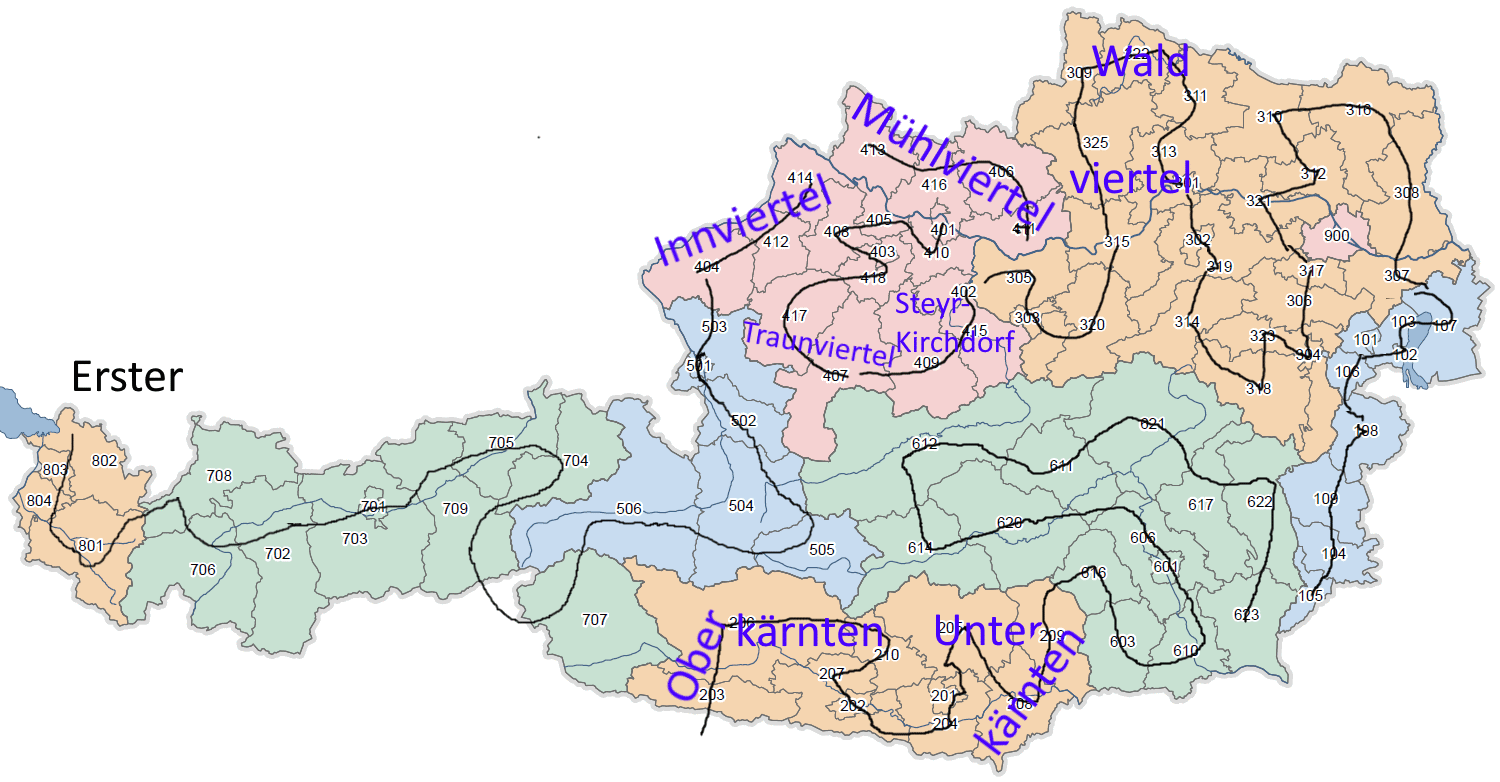

-- Basiskarte © STATISTIK AUSTRIA, Letzte Änderung am 16.08.2021 <https://www.statistik.at/web_de/klassifikationen/regionale_gliederungen/politische_bezirke/index.html>

In [ ]:
cov = reload(cov)
plt.rcParams['image.cmap'] = cov.un_cmap
bez_hm = bez[np.isfinite(bez["GKZ"])].copy().reset_index(drop=True)
# bez_hm["KFZ"] = bez_hm["Bezirk"].apply(cov.bezname_to_kfz)
bez_hm["sn"] = bez_hm["Bezirk"].apply(covdata.shorten_bezname)
# bez_hm["inz"].replace(0, 0.1, inplace=True)
# kfz_to_gkz = bez_hm.set_index("KFZ")["GKZ"].to_dict()
sname_to_gkz = bez_hm.set_index("sn")["GKZ"].astype(int).to_dict()
geo_order_to_index = dict(zip(cov.BEZ_GKZ_GEO_ORDER, range(len(cov.BEZ_GKZ_GEO_ORDER))))


def plt_bez_hm(mode: str = "inz", *, recent: bool = False):
    bez_hm0 = bez_hm if not recent else bez_hm[bez_hm["Datum"] >= bez_hm["Datum"].iloc[-1] - timedelta(MIDRANGE_NDAYS)]
    if mode == "dead":
        bez_hm0 = bez_hm0.query("Bezirk != 'Rust(Stadt)'")
        # bez_hm0 = bez_hm0[bez_hm0["Datum"] <= bez_hm0["Datum"].iloc[-1] - timedelta(7)]
        bez_hm0 = bez_hm0[bez_hm0["Datum"] <= bez_hm0["Datum"].iloc[-1] - timedelta(9)].copy()
        rwidth = 28
        with cov.calc_shifted(bez_hm0, "Bezirk", rwidth, newcols=["dead28"]):
            bez_hm0["dead28"] = bez_hm0["AnzahlTot"].rolling(rwidth).sum() / bez_hm0["AnzEinwohner"] * 100_000
    bez_hm_p = (
        bez_hm0.pivot(
            index="sn",
            columns="Datum",
            values="InfektionenPro100"
            if mode == "cumulative"
            else "inz"
            if mode == "inz"
            else "inz_g7"
            if mode == "inz_g7"
            else "dead28"
            if mode == "dead"
            else None,
        )
        .replace(np.inf, 100_000)
        .sort_index(axis="index", key=lambda s: s.map(sname_to_gkz).map(geo_order_to_index))
    )
    bez_hm_p.dropna(axis=1, how='all', inplace=True)
    fig, ax = plt.subplots(figsize=(14, 9), dpi=None if recent else 250)
    mid = 50
    if mode == 'inz':
        if False and recent:
            norm = matplotlib.colors.LogNorm(vmin=50)
        else:
            norm = matplotlib.colors.SymLogNorm(mid, base=2)
    elif mode == "inz_g7":
        norm = matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
    elif mode == 'cumulative':
        norm = matplotlib.colors.Normalize()
    elif mode == "dead":
        # bez_hm_p.replace(0, 0.001, inplace=True)
        norm = matplotlib.colors.SymLogNorm(0.3, linscale=0.5, vmin=0)
    else:
        raise ValueError("bad mode")
    ticks = (
        [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
        if mode == 'inz_g7'
        else cov.INZ_TICKS
        if mode == "inz"
        else [0, 0.3, 1, 3, 10, 30, 75]
        if mode == "dead"
        else None
    )
    plt_tl_heat(
        bez_hm_p,
        im_args=dict(
            aspect='auto',
            norm=norm,
            # cmap=sns.blend_palette(["darkbrown", "red", "white"], as_cmap=True)
            # cmap=sns.color_palette("RdYlGn_r", as_cmap=True),
            cmap=cov.div_l_cmap if mode == "inz_g7" else None,
        ),
        cbar_args=dict(ticks=ticks, format="%.1f", shrink=0.5),
        ax=ax,
    )
    tsstr = " bis " + bez_hm0.iloc[-1]["Datum"].strftime("%a %x") + AGES_STAMP
    if mode == 'cumulative':
        ax.set_title("Kumulative Inzidenz (in Prozent) in den Bezirken" + tsstr)
    elif mode == 'inz_g7':
        ax.set_title("Inzidenzveränderung (Faktor) ggü. 7 Tage vorher in den Bezirken" + tsstr)
    elif mode == "inz":
        ax.set_title("Inzidenz in den Bezirken" + tsstr)
    elif mode == "dead":
        ax.set_title("Tote in den Bezirken pro 28 Tage und 100.000 Einwohnern" + tsstr)
    else:
        raise ValueError("bad mode")
    ax.tick_params(axis="y", labelsize=6, labelleft=True, labelright=True, pad=0)
    gkzs = bez_hm_p.index.map(sname_to_gkz).to_series().reset_index(drop=True)
    # display(gkzs)
    diff = gkzs // 100 != gkzs.shift() // 100
    # display(len(diff) - diff[diff].index.values)
    ax.hlines(
        len(diff) - diff[diff].index.values - 0.5,
        xmin=bez_hm0.index[0],
        xmax=bez_hm0.index[-1],
        linewidth=0.2,
        color=(1, 1, 1),
    )
    ax.hlines(
        np.arange(0, len(bez_hm_p.index), 4) - 0.5,
        xmin=bez_hm0.index[0],
        xmax=bez_hm0.index[-1],
        linewidth=0.08,
        color=(1, 1, 1),
    )
    ax.set_facecolor("black")
    # else:
    #    ax.grid(False)


plt_bez_hm("inz")
plt_bez_hm("inz_g7")
# plt_bez_hm("cumulative")
plt_bez_hm("dead")
# plt_bez_hm(BEZMODE_LOW)
# plt_bez_hm(BEZMODE_HIGH)

In [ ]:
selbezs = ["Melk", "Waidhofen an der Ybbs(Stadt)", "Wiener Neustadt(Stadt)", "Niederösterreich", "Österreich"]
# selbezs = ["Landeck", "Tirol", "Österreich"]
# selbezs = ["Braunau am Inn", "Ried im Innkreis", "Schärding", "Grieskirchen", "Oberösterreich", "Österreich"]
# selbezs = (
#    ["Villach Stadt"] +
#    list(bez[bez["Bundesland"] == "Kärnten"].query("Bezirk != 'Villach Stadt'")["Bezirk"].unique()) +
#    ["Kärnten", "Österreich"])

# selbezs = ["Bruck-Mürzzuschlag", "Steiermark", "Österreich"]
# selbezs = ["Sankt Veit an der Glan", "Kärnten", "Österreich"]
# selbezs = ["Linz(Stadt)", "Oberösterreich", "Österreich"]
# selbezs = ["Lilienfeld", "Melk", "Gmünd"]

bez0 = bez[bez["Bezirk"].isin(selbezs)].copy()
with cov.calc_shifted(bez0, "Bezirk", 28, newcols=["dead28"]) as shifted:
    bez0["dead28"] = (bez0["AnzahlTotSum"] - shifted["AnzahlTotSum"]) / bez0["AnzEinwohner"] * 100_000
with cov.calc_shifted(bez0, "Bezirk", 7, newcols=["dead_a7"]) as shifted:
    bez0["dead_a7"] = (bez0["AnzahlTotSum"] - shifted["AnzahlTotSum"]) / 7
for sbez in selbezs:
    print(sbez, bez0[bez0["Bezirk"] == sbez].iloc[-1]["AnzEinwohner"])
bez0 = bez0[bez0["Datum"] >= bez0.iloc[-1]["Datum"] - timedelta(430)]
# mdead = bez.groupby("Datum", as_index=False).agg({"dead14": "max"})
# mdead["Bezirk"] = "Maximum aller Bezirke"
# display(mdead.tail(10))
# bez0 = pd.concat([bez0, mdead]).reset_index(drop=True)
showdet = True
pal = "tab20" if len(selbezs) > 10 else "tab10"
with cov.with_palette(pal):
    fig, axs = (
        plt.subplots(nrows=2, gridspec_kw={'height_ratios': [0.8, 0.2]}, sharex=True) if showdet else plt.subplots()
    )
    if not showdet:
        axs = np.array([axs])
    sns.lineplot(
        ax=axs[0],
        data=bez0,
        hue="Bezirk",
        y="dead28",
        x="Datum",
        hue_order=reversed(selbezs),
        palette=sns.color_palette(pal, n_colors=len(selbezs))[::-1],
        err_style=None,
    )
    if len(selbezs) >= 10:
        axs[0].legend(ncol=2, fontsize="small")
    cov.set_date_opts(axs[-1], bez0["Datum"], showyear=True)
    if showdet:
        bez_oo = bez0[bez0["Bezirk"] == selbezs[0]].set_index("Datum")
        axs[1].bar(
            bez_oo.index,
            bez_oo["AnzahlTot"],
            lw=0,
            width=timedelta(0.8 if len(bez_oo) <= 300 else 1),
            snap=False,
            aa=True,
        )
        axs[1].plot(bez_oo.index, bez_oo["dead_a7"], alpha=0.5, color="k")
        axs[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', integer=True, min_n_ticks=3))
        axs[1].set_ylabel("Tote/Tag")
        axs[1].set_title("Tote in " + selbezs[0] + " täglich & 7-Tage-Schnitt")
    fig.autofmt_xdate()
    axs[0].set_ylabel("Tote/4 Wochen/100.000 EW")
    # ax.set_xlim(*ax.get_xlim())
    for ax in axs:
        ax.set_ylim(bottom=0)
        ax.axvspan(
            matplotlib.dates.date2num(bez.iloc[-1]["Datum"] - timedelta(9)), ax.get_xlim()[1], color="k", alpha=0.2
        )
        ax.axvline(bez.iloc[-1]["Datum"] - timedelta(9), color="k", lw=1)
    fig.suptitle("Tote pro 4 Wochen pro 100.000 EW" + AGES_STAMP, y=0.93);

In [ ]:
display(bez["Bezirk"].unique())

## Impfungen vs. Inzidenzen pro Bezirk

Das folgende Diagramm zeigt die aktuelle Situation in den Bezirken bezüglich Anteil vollgeimpfter Personen (x-Achse) und Inzidenz (y-Achse) im Zusammenhang.

Die hellblaue Linie teilt die Punktwolke der Bezirke ungefähr in der Mitte.

Die Farbe der Punkte gibt das Bundesland an, die Größe die Einwohnerzahl des Bezirks.

In [ ]:
if False:
    cov = reload(cov)

    def loadimpfbez():
        gis = gis_o.copy()

        # Since the data is published on the same day (23:59:59), use timedelta of full 7 days here.
        def add_prev(days_before: int) -> None:
            gis_o_prev = cov.load_gem_impfungen(gis.iloc[-1]["Datum"] - np.timedelta64(days_before, "D"))
            assert gis_o["Datum"][-1] - gis_o_prev["Datum"][-1] == np.timedelta64(days_before, "D"), "Bad timedelta"
            # print(gis_o_prev["Datum"][-1])
            gis[f"Vollimmunisierte_d{days_before}"] = gis["Vollimmunisierte"] - gis_o_prev["Vollimmunisierte"]
            gis[f"Teilgeimpfte_d{days_before}"] = gis["Teilgeimpfte"] - gis_o_prev["Teilgeimpfte"]
            gis[f"VollimmunisiertePro100_d{days_before}"] = (
                gis["VollimmunisiertePro100"] - gis_o_prev["VollimmunisiertePro100"]
            )
            gis[f"TeilgeimpftePro100_d{days_before}"] = gis["TeilgeimpftePro100"] - gis_o_prev["TeilgeimpftePro100"]

        add_prev(1)
        add_prev(7)
        bfs_o = cov.filterlatest(bez[np.isfinite(bez["GKZ"])])
        bis = cov.group_impfungen_by_bez(gis)
        bfs = bfs_o.set_index("GKZ")
        ds = bfs.join(bis.reset_index("Datum", drop=True).drop(columns="BundeslandID"))
        ds["ImmunSpekulationPro100"] = ds["InfektionenPro100"] + ds["VollimmunisiertePro100"]
        ds["ImmunSpekulationPro100_d1"] = ds["InfektionenPro100_d"] + ds["VollimmunisiertePro100_d1"]
        ds["ImmunSpekulationPro100_d7"] = ds["InfektionenPro100_d7"] + ds["VollimmunisiertePro100_d7"]
        ds.sort_values(by="Bundesland", inplace=True)
        return ds

    ds = loadimpfbez()
    ds["KFZ"] = ds["Bezirk"].apply(cov.bezname_to_kfz)

In [ ]:
if False:
    from scipy.stats import linregress

    cov = reload(cov)
    bezimpf_cur = cov.filterlatest(bez_impf.reset_index(["Datum"])).drop(columns="Datum")
    # display(bezimpf_cur)
    bezimpf_cur.index = bezimpf_cur.index.astype(float)
    bez_cur = (
        bez[np.isfinite(bez["GKZ"])]
        .set_index(["GKZ"])
        .drop(columns=["BundeslandID", "AnzEinwohner", "Bundesland"])
        .join(bezimpf_cur)
        .reset_index()
    )
    bez_cur["dose3_percent"] = bez_cur["dose_3"] / bez_cur["AnzEinwohner"] * 100
    # bez_cur = bez_cur[bez_cur["Datum"] == bez_cur.iloc[-1]["Datum"] - timedelta(2)]
    bez_cur = cov.filterlatest(bez_cur)
    # bez_cur.sort_index(inplace=True)
    bez_cur.set_index("Bezirk", inplace=True)
    bez_cur["AnzahlFaelleOmiSum"] = (
        bez_cur["AnzahlFaelleSum"] - bez.query("Datum == '2022-01-01'").set_index("Bezirk")["AnzahlFaelleSum"]
    )
    bez_cur["AnzahlFaelleOmi_pp"] = bez_cur["AnzahlFaelleOmiSum"] / bez_cur["AnzEinwohner"]
    # display(bez_cur)
    # bez_cur.loc[900, "Bezirk"] = "Wien"
    ds = bez_cur.reset_index()

    def pltbezcurcorr(mode="omi", ds=ds):
        usedose3 = True
        xcol = "dose3_percent" if usedose3 else "valid_certificates_percent"
        # xcol = "dose3_percent"
        ycol = "AnzahlFaelleOmi_pp" if mode == "omi" else "dead91" if mode == "dead" else "inz"
        scol = "AnzEinwohner"
        ds = ds.copy()
        if mode == "dead":
            ds = ds.query("Bezirk not in ('Rust(Stadt)')")
        fig = plt.figure(figsize=(4 * 3, 3 * 3))
        ax = fig.subplots()

        def drawreg(ds0, color, lkws=None):
            sns.regplot(
                scatter=False,
                ax=ax,
                data=ds0,
                x=xcol,
                y=ycol,
                color=color,
                order=1,
                # logx=True,
                # robust=True,
                # lowess=True,
                line_kws={"zorder": -1, **(lkws or {})},
                ci=None,
            )

        for i, bl in enumerate(list(ds["Bundesland"].unique()) + ["Österreich"]):
            ds0 = ds[ds["Bundesland"] == bl] if bl != "Österreich" else ds
            if len(ds0) >= 4:
                pv = linregress(ds0[xcol], ds0[ycol]).pvalue
                cl = f"C{i}" if bl != "Österreich" else "k"
                if pv < 0.005:
                    drawreg(ds0, cl, lkws=dict(lw=0.7))
                elif pv < 0.05:
                    drawreg(ds0, cl, lkws=dict(alpha=0.5, lw=1))
                elif pv < 0.5:
                    drawreg(ds0, cl, lkws=dict(alpha=0.5, ls=":", lw=0.7))
                else:
                    drawreg(ds0, cl, lkws=dict(alpha=0.3, ls=":", lw=0.4))
                print(i, bl, pv)
        sns.scatterplot(
            ax=ax,
            data=ds,
            x=xcol,
            y=ycol,
            hue="Bundesland",
            size=scol,
            # marker="X",
            sizes=(5, 200),
            size_norm=matplotlib.colors.Normalize(vmin=10_000, vmax=500_000),
            # legend=False,
            zorder=2,
        )

        if False:
            rgb_values = sns.color_palette(None, len(ds["Bundesland"].unique()))
            # Map label to RGB
            color_map = dict(zip(ds["Bundesland"].unique(), rgb_values))
            ax.quiver(
                ds[xcol],
                ds[ycol] - ds[ycol + "_d7"],
                np.repeat(0, len(ds)),
                ds[ycol + "_d7"],
                color=ds["Bundesland"].map(color_map),
                units="xy",
                angles="xy",
                scale_units="xy",
                scale=1,
                width=2,
                alpha=0.5,
                zorder=1.5,
                headaxislength=5,
                headlength=10,
                headwidth=10,
            )

        if False:
            rgb_values = sns.color_palette(None, len(ds["Bundesland"].unique()))
            # Map label to RGB
            color_map = dict(zip(ds["Bundesland"].unique(), rgb_values))
            ax.quiver(
                ds["VollimmunisiertePro100"] - ds["VollimmunisiertePro100_d7"],
                ds[ycol + "_prev7"],
                ds["VollimmunisiertePro100_d7"] - ds["VollimmunisiertePro100_d1"],
                ds[ycol + "_d7"] - ds[ycol + "_d"],
                color=ds["Bundesland"].map(color_map),
                units="xy",
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.3,
                alpha=0.5,
                zorder=1.5,
                headaxislength=0,
            )
            ax.quiver(
                ds["VollimmunisiertePro100"] - ds["VollimmunisiertePro100_d1"],
                ds[ycol + "_prev"],
                ds["VollimmunisiertePro100_d1"],
                ds[ycol + "_d"],
                color=ds["Bundesland"].map(color_map),
                units="xy",
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.3,
                alpha=0.2,
                zorder=1.5,
                headaxislength=0,
            )

        def addlabels():
            for i in range(ds.shape[0]):
                item = ds.iloc[i]
                # if np.isnan(item["InfektionenPro100"]): # Wien
                #    continue
                x = item[xcol]
                y = item[ycol]
                bname = item["Bezirk"]
                # display(bname)
                # if kfz.loc[bname]["ID"] in ("KI",) or bname in ("Wels-Land", "Eisenstadt-U"):
                #     y += 1
                # if kfz.loc[bname]["ID"] in ("GR",) or bname in ("Mistelbach"):
                #     y -= 1
                # if item["inz"] < 35 or item["inz"] > 130 or item["VollimmunisiertePro100"] < 51 or item["VollimmunisiertePro100"] > 68:
                ax.annotate(
                    covdata.shorten_bezname(bname),
                    (x, y),
                    # cov.bezname_to_kfz(bname),
                    size=8,
                    ha="center",
                    color="grey",
                    zorder=1.1,
                    xytext=(0, 0 if item[scol] < 50_000 else 5),
                    textcoords='offset points',
                )
                # print(x,y,covdata.shorten_bezname(bname),bname)
                # else:
                #    ax.text(x, y + 2, kfz.loc[bname]["ID"], size=6, ha="center")

        ax.set_ylim(bottom=0)
        ax.set_ylabel(
            "Kumulative Inzidenz seit 1.1.21"
            if mode == "omi"
            else "Aktuelle 7-Tages-Inzidenz/100.000 EW"
            if mode == "inz"
            else "Tote letzte 91 Tage/100.000 EW"
            if mode == "dead"
            else None
        )
        # ax.set_ylabel("Anstieg 7-Tages-Inzidenz ggü. 7 Tage vorher (Faktor)")
        # ax.set_xlabel("Einwohner mit gültigen Impfzertifikaten in Prozent")
        ax.set_xlabel(
            "Einwohner mit 3. Impfung in Prozent" if usedose3 else "Gem. Empfehlung (1-Jahresfrist für Auffrischung)"
        )

        if False:  # Hochrisiko-Grenze Herbst 2021
            ax.plot(
                np.hstack([[0], np.arange(50, 70 + 1, 5), [100]]),
                np.hstack([np.arange(300, 800 + 1, 100), [100_000]]),
                color="red",
                scalex=False,
                scaley=False,
                drawstyle="steps-post",
                zorder=0.55,
                label="Hochrisiko-Grenze",
            )
        if mode == "omi":
            cov.set_percent_opts(ax)
        elif mode == "inz":
            cov.set_logscale(ax)
            ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
        ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0))
        ax.grid(which="minor", lw=0.2, axis="x")
        # ax.set_yticks(100, 200, 300)
        ax.set_ylim(bottom=ds[ycol].sort_values().iloc[1] * 0.95)
        addlabels()
        cov.remove_labels_after(ax, "AnzEinwohner", loc="best", ncol=2, fontsize="x-small")
        ax.set_title(
            "Bezirke: Impfquote und {} bis ".format(
                "Kumulative Inzidenz seit 1.1.21"
                if mode == "omi"
                else "Tote in 91 Tagen/100.000 EW"
                if mode == "dead"
                else "7-Tages-Inzidenz"
            )
            + ds["Datum"].iloc[-1].strftime("%a %x")
        )
        cov.stampit(ax.figure, cov.DS_BOTH)

    # pltbezcurcorr(mode="omi")
    pltbezcurcorr(mode="inz")
    pltbezcurcorr(mode="dead")

In [ ]:
if False:
    from scipy.stats import kendalltau, spearmanr, linregress

    def plotreg(**kwargs):
        bez2 = bez.set_index(["Datum", "GKZ"]).join(
            bez_impf.drop(columns=['AnzEinwohner', 'BundeslandID', 'Bundesland']), how="inner"
        )
        bezcur = cov.filterlatest(bez2.reset_index(["Datum"]))
        # display(linregress(bezcur["dose_3"], bezcur["inz"]))
        bez2["dose3_pp"] = bez2["valid_certificates_percent"]  # / bez2["AnzEinwohner"]
        xcol = "dose3_pp"
        corr = bez2.groupby(level="Datum").apply(
            lambda s: pd.Series(
                {  # "kendall tau": kendalltau(s[xcol], s["inz"]).correlation,
                    # "spearman r": spearmanr(s[xcol], s["inz"]).correlation,
                    "R": linregress(s[xcol], s["inz"]).rvalue
                }
            )
        )
        # linregress(s["valid_certificates_percent"], s["inz"]))
        # display(corr)
        ax = corr.plot(**kwargs)
        ax.axhline(0, color="k")
        # ax.set_ylabel("Lineares Bestimmtheitsmaß $R^2$")
        ax.set_xlim(right=ax.get_xlim()[1] + 1)

    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 8))
    axs[0].set_title("Linearer Korrelationskoeffizent Anteil mit aktueller Impfung vs. Inzidenz in den Bezirken")
    plotreg(ax=axs[0], legend=False)
    axs[0].annotate("> 0, d.h. mehr Impfungen \n=> mehr Covid-Fälle", (axs[0].get_xlim()[0], 0.1), fontsize="small")
    axs[0].annotate(
        "< 0, d.h. mehr Impfungen \n=> weniger Covid-Fälle", (axs[0].get_xlim()[0], -0.1), va="top", fontsize="small"
    )
    axs[1].set_title("7-Tage-Inzidenz pro 100.000 Einwohner, logarithmisch")
    if False:
        axs[1].plot(fs_at.set_index("Datum")["inz"], label="7-Tage-Inziden/100.000 EW")
    else:
        sns.lineplot(
            data=fs.query("Bundesland != 'Österreich'"),
            hue="Bundesland",
            x="Datum",
            y="inz",
            ax=axs[1],
            alpha=0.7,
            err_style=None,
        )
        labelend2(axs[1], fs.query("Bundesland != 'Österreich'"), "inz")
        cov.set_logscale(axs[1])
        axs[1].legend(fontsize="x-small", ncol=3, loc="lower center", bbox_to_anchor=(0.58, 0))
    axs[1].set_ylim(bottom=100)
    axs[1].set_ylabel(None)
    # axs[1].legend()
    if False:
        axs[2].plot(
            (
                mms.query("Bundesland == 'Österreich'").set_index("Datum")["PCRReg"]
                - mms.query("Bundesland == 'Wien'").set_index("Datum")["PCRReg"]
                - mms.query("Bundesland == 'Niederösterreich'").set_index("Datum")["PCRReg"]
            )
            .rolling(7)
            .sum()
            / (
                mms.query("Bundesland == 'Österreich'").set_index("Datum")["AnzEinwohner"]
                - mms.query("Bundesland == 'Wien'").set_index("Datum")["AnzEinwohner"]
                - mms.query("Bundesland == 'Niederösterreich'").set_index("Datum")["AnzEinwohner"]
            )
        )
        cov.set_percent_opts(axs[2])
    else:
        sns.lineplot(
            data=mmx.query("Bundesland != 'Österreich'"),
            hue="Bundesland",
            x="Datum",
            y="TestsRInz",
            ax=axs[2],
            legend=False,
            alpha=0.7,
            err_style=None,
        )
        labelend2(axs[2], mmx[mmx["Datum"] != mmx["Datum"].iloc[-1]].query("Bundesland != 'Österreich'"), "TestsRInz")
        axs[2].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100_000))
        axs[2].set_ylim(top=60_000)
    axs[2].set_ylim(bottom=0)
    axs[2].set_title("Wöchentlich gemeldete AG+PCR-Tests in % der Einwohner")
    axs[2].set_ylabel(None)
    cov.set_date_opts(axs[-1], showyear=True)

    end_3g = pd.to_datetime("2022-03-05")
    test_limit = pd.to_datetime("2022-04-01")
    omi = pd.to_datetime("2021-12-31")
    for ax in axs:
        ax.axvline(end_3g, color="k", zorder=1, lw=1)
        ax.axvline(test_limit, color="k", zorder=1, lw=1)
        ax.axvline(omi, color="k", zorder=1, lw=1)
    axs[-1].annotate("Ende 3G am\nArbeitsplatz", (end_3g, 0), ha="right", fontsize="small")
    axs[-1].annotate("Omikron\ndominant", (omi, 0), ha="right", fontsize="small")
    axs[-1].annotate("Beschränkung\nGratistests", (test_limit, 0), ha="left", fontsize="small")

In [ ]:
if False:
    ds0 = ds  # .query("Bundesland == 'Salzburg'")
    (
        ds0[["Bezirk", "valid_certificates_percent", "InfektionenPro100", "inz_g7", "AnzEinwohner", "inz", "inz_a7"]]
        .sort_values(by="valid_certificates_percent", ascending=False)
        .assign(AnzEinwohner=ds["AnzEinwohner"].astype(int))
        .rename(
            columns={
                "valid_certificates_percent": "% mit 1G-Zertifikat",
                "InfektionenPro100": "% Infektionen",
                "AnzEinwohner": "Einwohner",
                "inz_a7": "7-Tg Ø inz",
            },
        )
        .set_index(np.arange(1, len(ds0) + 1))
    )

## Bezirke, die auf den letzen oder vorletzen Tag verdächtig wenig Fälle gebucht haben

In [ ]:
bez[bez["Datum"] >= bez["Datum"].iloc[-1] - timedelta(1)].query(
    "inz_dg7 <= 0.3 and AnzahlFaelle7Tage >= 5 * 7 or AnzahlFaelle == 0 and AnzahlFaelle7Tage >= 3 * 7"
).set_index(["Datum", "Bezirk"])[
    ["Bundesland", "AnzahlFaelle", "inz_dg7", "AnzahlFaelle7Tage", "AnzEinwohner"]
].sort_index()

In [ ]:
def plt_growfig(data0, ttl, basecol="inz", showlast=True):
    fig, ax = plt.subplots()
    color = sns.color_palette(n_colors=1)[0]

    def gtox(s):
        s = s.copy()
        s[s < 1] = -(1 / s) + 1
        s[s >= 1] -= 1
        return s

    inzdx7 = gtox(data0.set_index("Datum")[f"{basecol}_dg7"])
    inzx7 = gtox(data0.set_index("Datum")[f"{basecol}_g7"])
    ndays = len(data0)
    ax.axhline(0, color="k", lw=1, zorder=1)
    bar_args = dict(
        zorder=2,
        lw=0,
        aa=True,
        snap=False,
        alpha=0.3,
        width=0.7,
    )
    ax.bar(
        inzdx7.index,
        height=inzdx7.where(inzdx7 < 0),
        color=color,
        edgecolor=color,
        label="Niedrigerer Wochentagswert",
        **bar_args,
    )
    ax.bar(
        inzdx7.index,
        height=inzdx7.where(inzdx7 >= 0),
        color="C3",
        edgecolor="C3",
        label="Höherer Wochentagswert",
        **bar_args,
    )
    ax.plot(inzx7, color="grey", lw=2)
    ax.plot(inzx7.where(inzx7 < 0), color="C0", label="Sinkende Wochensumme", lw=2)
    ax.plot(inzx7.where(inzx7 >= 0), color="C3", label="Steigende Wochensumme", lw=2, marker="o", mew=0, markersize=2.5)
    valdates = data0["Datum"].loc[data0["inz_dg7"].first_valid_index() :]
    alwaysshow = int(-len(valdates) * 0.2)
    ax.set_ylim(
        top=min(
            3, max(min(ax.get_ylim()[1], 1.5), inzdx7.iloc[alwaysshow:].quantile(0.99, interpolation="higher") * 1.05)
        ),
        bottom=max(
            -3, min(max(ax.get_ylim()[0], -1.5), inzdx7.iloc[alwaysshow:].quantile(0.01, interpolation="lower") * 1.05)
        ),
    )

    def fmtx(v, _):
        return f"×{v + 1:.2f}" if v >= 0 else f"÷{-v + 1:.2f}"

    if showlast:
        ax.axhline(inzx7.iloc[-1], color="C0" if inzx7.iloc[-1] < 0 else "C3", lw=1)
        ax.annotate(
            fmtx(inzx7.iloc[-1], None)
            + f"\n= {data0[f'{basecol}_g7'].iloc[-1] - 1:+.1%}".replace("-", "−")
            + (
                ("\n×2 in " + format(doubling_time(data0[f'{basecol}_g7'].iloc[-1]) * 7, ".0f") + " T")
                if inzx7.iloc[-1] > 0
                else ""
            ),
            (inzx7.index[-1], inzx7.iloc[-1]),
            xytext=(10, 0),
            textcoords="offset points",
        )
    cov.set_date_opts(ax, valdates, showyear=True)
    ax.set_xlim(left=valdates.iloc[0], right=valdates.iloc[-1] + (valdates.iloc[-1] - valdates.iloc[0]) * 0.01)
    fig.legend(loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.94))
    fig.suptitle(f"{ttl}: Inzidenzveränderung gegenüber 7 Tage vorher", y=0.96)
    # ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda v, _: f"×{v:.1f}"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(fmtx))
    fig.autofmt_xdate()
    return fig, ax


# selbez = "Imst"
selbez = "Scheibbs"
# selbez = "Tamsweg"
data = bez[bez["Bezirk"] == selbez]

display(Markdown(f"# Details für Bezirk {selbez}\n\nEinwohner: {data.iloc[-1]['AnzEinwohner']:n}"))

if DISPLAY_SHORTRANGE_DIAGS:
    fig, axs = plt.subplots(nrows=3, sharey=True, figsize=(8, 8))
    fig.suptitle("Positive Tests im Bezirk " + selbez + AGES_STAMP, y=1.025)
    fig.subplots_adjust(hspace=0.4)
    axs2 = []
    ndays = MIDRANGE_NDAYS
    axs2.append(make_wowg_diag(bez[bez["Bezirk"] == selbez], "Letzter Stand nach Labordatum", axs[0], ndays=ndays))
    # axs[0].tick_params(pad=0)
    fig.legend(frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1))
    axs2.append(
        make_wowg_diag(bez1[bez1["Bezirk"] == selbez], "Nur Erstmeldungen nach Labordatum", axs[1], ndays=ndays)
    )
    # axs[1].tick_params(pad=0)
    axs2.append(make_wowg_diag(bez1m[bez1m["Bezirk"] == selbez], "Nach Meldedatum", axs[len(axs2)], ndays=ndays))
    same_axlims(axs, axs2, maxg=2)
    # for ax in axs[:2]:
    #    ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] - 1)

# data = bez1m[bez1m["Bezirk"] == selbez]
plt_growfig(data, f"Bezirk {selbez}")

fig = plt.figure()
cov.plot_detail_ax(
    data.set_index("Datum").drop(columns=["ag55_inz", "FZHosp", "nhosp", "icu"], errors="ignore"), plt.gca()
)
fig.autofmt_xdate()
# fs_at2 = fs_at.copy()
# cov.enrich_inz(fs_at2, "ag55_inz", catcol="Bundesland")
# plt_growfig(fs_at2.query("Datum >= '2020-11-01'"), "55+", "ag55_inz")

# Tests

Diese Daten können nur den BMI-Morgenmeldungen entnommen werden. Öfters kommt es deshalb zu Korrekturen was dann
zu einer gewaltigen Anzahl neuer PCR Tests oder auch Fällen pro Tag führt, oder auch zu negativen Anzahlen.

Wie man sieht hat Wien (und somit Gesamt-Österreich) sehr hohe Testraten was wohl dem dort stark beworbenen [Alles-Gurgelt-Programm](https://allesgurgelt.at/wien) zu verdanken ist.

In [ ]:
mms_cols = ["PCR", "Antigen", "AnzahlFaelle", "PCRApo", "PCRReg"]
apo_cols = ["PCR", "Antigen", "TestsBetrieb"]
mms_nw = (
    mmx.query("Bundesland == 'Österreich'").set_index("Datum")[mms_cols]
    - mmx.query("Bundesland == 'Wien'").set_index("Datum")[mms_cols]
)
apo_nw = apo.xs(10)[apo_cols] - apo.xs(9)[apo_cols]
mms_nw["Bundesland"] = "Ö ohne Wien"
mms_nw["PCRRPosRate_a7"] = mms_nw["PCRReg"].rolling(7).sum() / mms_nw["AnzahlFaelle"].rolling(7).sum()

In [ ]:
schulat = schul.xs(10).copy()
schulat["Zeit"] = schulat.index.strftime("%d.%m.%y")
schulat["PCR"] /= 1000
schulat["Antigen"] /= 1000
ax = schulat.plot.bar(x="Zeit", y=["PCR", "Antigen"], lw=0)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis="y")
ax.tick_params(which="minor", labelleft=False)
ax.grid(which="minor", lw=0.5)
ax.grid(False, axis="x")
ax.set_title("Wöchentlich durchgeführte Schultests in Österreich (in 1000)")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl Tests (1000)")


def plt_tests_per_bl(col):
    fig, ax = plt.subplots()

    sns.lineplot(
        data=schul.reset_index().query("Bundesland != 'Österreich'"),
        x="Datum",
        y=col,
        hue="Bundesland",
        marker=".",
        ax=ax,
        err_style=None,
    )


plt_tests_per_bl("PCR")
plt_tests_per_bl("Antigen")
# sns.lineplot(data=schul.reset_index().query("Bundesland != 'Österreich'"), x="Datum", y="PCR", hue="Bundesland", marker=".")

fig, axs = plt.subplots(figsize=(10, 25), nrows=11)
fig.subplots_adjust(hspace=0.3)
fig.suptitle("Im Wochenschnitt gemeldete Tests", y=0.89)

ndays = MIDRANGE_NDAYS


def plt_tests(ax, mms_oo, apo_oo):
    mms_oo = mms_oo.copy()
    bl = mms_oo["Bundesland"].iloc[0]
    mms_oo["PCR_a7"] = mms_oo["PCR"].rolling(7).mean()
    mms_oo["Antigen_a7"] = mms_oo["Antigen"].rolling(7).mean()
    mms_oo = mms_oo[(mms_oo["Datum"] >= mms_oo["Datum"].iloc[-1] - timedelta(ndays))]
    apo_oo = apo_oo[apo_oo.index >= mms_oo.iloc[0]["Datum"] - timedelta(7)]
    # ax.plot(fs_oo["Datum"] + timedelta(1), fs_oo["AnzTests"], label="Tests laut AGES", alpha=0.5)
    ax.plot(mms_oo["Datum"].dt.normalize(), mms_oo["PCR_a7"], label="BMI PCR", marker=".")
    ax.plot(apo_oo["PCR"].iloc[:-1].rolling(7).mean(), label="Apo PCR", marker=".")
    ax.plot(apo_oo["TestsBetrieb"].rolling(7).mean(), label="Betriebe", marker=".")
    ax.plot(apo_oo["Antigen"].rolling(7).mean(), label="Apo AG", marker=".")
    ax.plot(mms_oo["Datum"].dt.normalize(), mms_oo["Antigen"].rolling(7).mean(), label="BMI AG", marker=".")
    # print(mms_oo["Antigen"])
    # ax.plot(schul_oo["PCR"] / 7, marker=".", label="Schul-PCR")
    # ax.plot(hosp_oo["Datum"], hosp_oo["Tests"], label="Tests laut AGES/Hosp", alpha=0.5)
    ax.legend(loc="lower left")
    # ax.set_ylabel("Anzahl Tests (PCR)");
    ax.set_ylabel(bl)
    # ax.set_ylim(top=fs_oo["AnzTests"].quantile(0.995))
    cov.set_date_opts(ax, mms_oo["Datum"])
    ax.set_xlim(left=mms_oo["Datum"].iloc[0])
    ax.set_ylim(bottom=0)


for (blid, bl), ax in zip(cov.BUNDESLAND_BY_ID.items(), axs):
    # fs_oo = fs.query("Bundesland == 'Niederösterreich'")
    apo_oo = apo.xs(blid)
    schul_oo = schul.xs(blid).copy()
    # hosp_oo = hosp.query("Bundesland == 'Niederösterreich'").copy()
    # hosp_oo["Tests"] = hosp_oo["TestGesamt"].diff()
    mms_oo = mmx[(mmx["Bundesland"] == bl)].copy()
    plt_tests(ax, mms_oo, apo_oo)


plt_tests(axs.flat[-1], mms_nw.reset_index(), apo_nw)

In [ ]:
mmx.set_index(["Bundesland", "Datum"])["PCRReg"].tail(11)

In [ ]:
ndays = DETAIL_SMALL_NDAYS  # 7*6 + 1


def plt_tests_cases_daily(mms_oo0, ax):
    bl = mms_oo0.iloc[0]["Bundesland"]
    mms_oo = mms_oo0.iloc[-ndays - 1 :].copy()
    mms_oo["Datum"] = mms_oo["Datum"].dt.normalize()
    # ax.plot(fs_oo["Datum"] + timedelta(1), fs_oo["AnzTests"], label="Tests laut AGES", alpha=0.5)
    # ax.plot(mms_oo["Datum"].dt.normalize(), mms_oo["PCR"].rolling(7).mean(), label="Laut BMI", marker=".")
    # ax.plot(apo_oo["Datum"].dt.normalize(), apo_oo["PCR"].rolling(7).mean(), label="Apotheken", marker=".")
    # ax.plot(hosp_oo["Datum"], hosp_oo["Tests"], label="Tests laut AGES/Hosp", alpha=0.5)
    pltr = cov.StackBarPlotter(ax, mms_oo["Datum"].iloc[1:], lw=0)
    pltr(mms_oo["PCR"].iloc[1:], label="PCR lt. Ländermeldung", color="C0")
    pltr(mms_oo["PCRApo"].iloc[1:], label="Apotheken-PCR", color="C4")
    # ax.bar(, mms_oo["PCR"], label="PCR-Tests lt. BMI (links)", color="C0")
    ax2 = ax.twinx()
    ax2.plot(
        mms_oo["Datum"].dt.normalize(),
        mms_oo["AnzahlFaelle"],
        label=f"Fälle lt. {'AGES nach Meldedatum' if haveages else '9:30-Krisenstabmeldung'} (rechts)",
        color="C1",
        marker=".",
        lw=2,
        mew=0.5,
        markeredgecolor="white",
    )
    top3 = (mms_oo["PCR"] + mms_oo["PCRApo"]).sort_values().iloc[-3]
    ax2.set_ylim(bottom=0)
    if ax.get_ylim()[1] > top3 * 5:
        ax.set_ylim(top=top3 * 2)

    ax2.tick_params(labelsize="small")
    ax.tick_params(labelsize="small")
    if ax in axs[-1]:
        cov.set_date_opts(ax, mms_oo["Datum"].iloc[1:].dt.normalize())
        ax.tick_params(axis="x", which="minor", labelsize="xx-small", pad=0)
        ax.tick_params(axis="x", which="major", labelsize="medium", rotation=0, pad=5)

    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))
    if ax is axs.flat[0]:
        fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=False)
        # ax.legend(loc="upper left")
        # ax2.legend(loc="upper right")
    if ax in axs.T[0]:
        ax.set_ylabel("Tests")
    if ax in axs.T[-1]:
        ax2.set_ylabel("Fälle")
    ax2.grid(False)
    # ax.set_ylabel("Anzahl Tests (PCR)");
    ax.set_title(
        f"{bl} ({mms_oo.loc[mms_oo['PCRRPosRate_a7'].last_valid_index(), 'PCRRPosRate_a7'] * 100:.2n}% positiv in 7 Tagen)",
        y=0.96,
    )
    # ax.set_ylim(top=fs_oo["AnzTests"].quantile(0.995))
    ax.set_ylim(bottom=0)


if DISPLAY_SHORTRANGE_DIAGS:
    fig, axs = plt.subplots(figsize=(10, 10), nrows=5, ncols=2, sharex=True)
    fig.suptitle("PCR-Tests und Fälle, Stand " + bltest_o.iloc[-1]["Datum"].strftime("%a %x"))
    fig.subplots_adjust(hspace=0.24, wspace=0.32)
    # fig.text(0.5, 0.9, "Beschriftung: „Bundesland (Anteil positiver Tests in 7 Tagen)“",
    #         ha="center", fontsize="small", va="bottom")
    for bl, ax in zip(cov.BUNDESLAND_BY_ID.values(), axs.flat):
        # fs_oo = fs.query("Bundesland == 'Niederösterreich'")
        mms_oo0 = mmx[mmx["Bundesland"] == bl]
        plt_tests_cases_daily(mms_oo0, ax)
    # fig.autofmt_xdate()
    # plt_tests_cases_daily(mms_nw.reset_index(), axs.flat[-1])

In [ ]:
cov = reload(cov)
mms0 = mmx.copy()  # mms[mms["Datum"] < mms.iloc[-1]["Datum"]]
# mms0 = mms0[np.isfinite[mms0["PCR"]]]

mms0_nw = (
    mms0.query("Bundesland not in ('Wien', 'Österreich')")
    .groupby("Datum")
    .agg(
        {
            "AnzahlFaelleSum": "sum",
            "AnzahlFaelle": "sum",
            "AnzEinwohner": "sum",
            "PCRSum": "sum",
            "AntigenSum": "sum",
            "Tests": "sum",
            "TestsAlle": "sum",
            "PCR": "sum",
            "PCRReg": "sum",
            "TestsReg": "sum",
            "PCRAlle": "sum",
            "TestsSum": "sum",
        }
    )
    .reset_index()
)
mms0_nw["Bundesland"] = "Ö ohne Wien"
c7 = mms0_nw["AnzahlFaelle"].rolling(7).sum()
mms0_nw["TestsAPosRate_a7"] = c7 / mms0_nw["TestsAlle"].rolling(7).sum()
mms0_nw["PCRAPosRate_a7"] = c7 / mms0_nw["PCRAlle"].rolling(7).sum()
mms0_nw["TestsRPosRate_a7"] = c7 / mms0_nw["TestsReg"].rolling(7).sum()
mms0_nw["PCRRPosRate_a7"] = c7 / mms0_nw["PCRReg"].rolling(7).sum()
mms0_nw["TestsBLPosRate_a7"] = c7 / mms0_nw["Tests"].rolling(7).sum()
mms0_nw["PosRate_a7"] = c7 / mms0_nw["Tests"].rolling(7).sum()
mms0_nw["PCRPosRate_a7"] = c7 / mms0_nw["PCR"].rolling(7).sum()
mms0_nw["inz"] = cov.calc_inz(mms0_nw)
mms0_nw["PCR_s7"] = mms0_nw["PCR"].rolling(7).sum()


def print_test_stats():
    data = mms0[np.isfinite(mms0["PCR"])].query("Bundesland == 'Österreich'").tail(15 + 6).set_index("Datum").copy()
    data["PCR_s7"] = data["PCR"].rolling(7).sum()
    if not np.isfinite(mms0.iloc[-1]["PCR"]):
        print("‼ Keine Daten für heute")
    mday = data.index[-1].strftime("%A")
    data = data.loc[data.index[-1].dayofweek == data.index.dayofweek]
    data.sort_index(ascending=False, inplace=True)
    agesremark = ", Fälle lt. AGES/Meldedatum" if haveages else ""
    print(f"#COVID19at PCR-Tests (inkl. Apotheken) 24h bis {mday}{agesremark} ({data.iloc[0]['Bundesland']}):\n")
    isfirst = True
    for _, rec in data.iterrows():
        nwrec = mms0_nw[mms_nw.index == rec.name].iloc[-1]
        if nwrec["PCR"] < 0:
            break

        # print(nwrec)
        def fmtpcr(n):
            return format(int(n), "6,").replace(",", ".")

        print(
            "‒",
            rec.name.strftime("%d.%m") + ".:",
            f"{fmtpcr(rec['PCRReg'])} / {fmtpcr(nwrec['PCRReg'])}{' exkl. Wien' if isfirst else ''}",
            f"({rec['PCRRPosRate_a7']*100:.3n}% / {nwrec['PCRRPosRate_a7']*100:.3n}% {'positiv in 7 Tagen' if isfirst else '+'})",
        )
        isfirst = False


print_test_stats()

In [ ]:
# display(mms0_nw.tail(15))


def pltposrate2(mms0_nw, schoolinc=False, ndays=MIDRANGE_NDAYS):
    kwargs = dict(marker=".", mew=0)  # if mark else dict()
    mms0_nw = mms0_nw.iloc[-ndays:]
    fig, ax = plt.subplots()
    fig.suptitle("Positivrate: " + mms0_nw.iloc[0]["Bundesland"], y=0.95)
    # apodiff =  (mms0_nw["Datum"].iloc[-1] - apo.index.get_level_values("Datum")[-1]).days + 1
    mms0_a = mms0_nw
    # if apodiff > 0:
    #    apomsg = f"die {apodiff} letzten Tage" if apodiff > 1 else "den letzten Tag"
    #    ax.set_title(f"*Tests inklusive Apotheken wegen Meldeverzögerung ohne {apomsg}")
    #    mms0_a = mms0_nw.iloc[:-apodiff]
    if not schoolinc:
        ax.plot(mms0_a["Datum"], mms0_a["PCRAPosRate_a7"], label="PCR 9:30-Meldung + Apotheken* + Schulen", **kwargs)
    ax.plot(mms0_a["Datum"], mms0_a["PCRRPosRate_a7"], label="PCR 9:30-Meldung + Apotheken*", color="C1", **kwargs)
    ax.plot(
        mms0_a["Datum"],
        mms0_a["TestsAPosRate_a7"],
        label="AG+PCR 9:30-Meldung + Apotheken*" + ("" if schoolinc else " + Schulen"),
        color="C4",
        **kwargs,
    )
    ax.plot(mms0_nw["Datum"], mms0_nw["TestsBLPosRate_a7"], label="AG+PCR 9:30-Meldung", color="C2", **kwargs)
    ax.plot(
        mms0_nw["Datum"],
        mms0_nw["PCRPosRate_a7"],
        color="C3",
        label="PCR 9:30-Meldung" + (" (inkl. Schulen)" if schoolinc else ""),
        **kwargs,
    )
    ax.set_ylim(top=min(1, mms0_nw["PCRPosRate_a7"].iloc[-60:].max() * 1.1))
    ax.set_ylabel("Test-Positivrate (Fälle lt. Krisenstab / Anz. Tests)")
    ax2 = ax.twinx()
    ax2.set_ylabel("7-Tage-Inzidenz / 100.000 EW")
    ax2.plot(mms0_nw["Datum"], mms0_nw["inz"], label="Inzidenz", ls="--", color="k", lw=1)
    ax2.grid(False)
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0, top=ax.get_ylim()[1] * 10_000)
    cov.set_percent_opts(ax)
    cov.set_date_opts(ax)
    return fig, ax, ax2


if False:
    fig, ax, ax2 = pltposrate2(mms0.query("Bundesland == 'Österreich'"))
    ax2.set_ylim(bottom=0, top=ax.get_ylim()[1] * 20_000)
    ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(400))
    fig, ax, ax2 = pltposrate2(mms0.query("Bundesland == 'Wien'"), schoolinc=True)
    cov.set_percent_opts(ax, decimals=2)
    ax2.set_ylim(bottom=0, top=ax.get_ylim()[1] * 100_000)
# pltposrate2(mms0_nw)
# pltposrate2(mms0.query("Bundesland == 'Oberösterreich'"))
# pltposrate2(mms0.query("Bundesland == 'Tirol'"))
# pltposrate2(mms0.query("Bundesland == 'Steiermark'"))
# pltposrate2(mms0.query("Bundesland == 'Burgenland'"))


def pltpos(ax, pltcol, rmlast=False, mark=True, ndays=MIDRANGE_NDAYS, mms0=mms0):
    if rmlast:
        mms0 = mms0[mms0["Datum"] != apo.xs(10).index[-1]]
    # mms0 = mms0[mms0["Datum"] <= apo.xs(10).index[-1]]
    sns.lineplot(
        x=mms0["Datum"],
        y=mms0[pltcol],
        hue=mms0["Bundesland"],
        marker="." if mark else "",
        markeredgewidth=0,
        ax=ax,
        err_style=None,
    )

    def labelend(ycol, ymax=None):
        for bl in mms0["Bundesland"].unique():
            ys = mms0[mms0["Bundesland"] == bl][ycol]
            ax.annotate(
                cov.SHORTNAME_BY_BUNDESLAND[bl],
                (mms0["Datum"].iloc[-1], ys.iloc[-1]),
                xytext=(5, 0),
                textcoords='offset points',
            )
            ax.annotate(
                cov.SHORTNAME_BY_BUNDESLAND[bl],
                (mms0["Datum"].iloc[0], ys[np.isfinite(ys)].iloc[0]),
                xytext=(-2, 0),
                textcoords='offset points',
            )

    labelend(pltcol)
    # cov.set_date_opts(ax, mms0["Datum"])
    # plt.setp(ax.get_legend().get_texts(), fontsize='9')
    ax.figure.legend(
        *sortedlabels(ax, mms0, pltcol, fmtval=lambda v: f"{v * 100:.1f}%"),
        loc="upper center",
        # bbox_to_anchor=(0.35, 1)
        bbox_to_anchor=(0.5, 0.97),
        fontsize="small",
        ncol=5,
        frameon=False,
    )
    ax.get_legend().remove()
    # ax.set_ylim(top=0.25, bottom=0)

    ax.set_ylim(bottom=0, top=0.2)
    # ax.set_ylim(top=0.3, bottom=0)

    cov.set_date_opts(ax, mms0[mms0["Datum"] >= mms0["Datum"].iloc[-1] - timedelta(ndays)]["Datum"])
    # ax.set_xlim(left=mms["Datum"].iloc[-1] - timedelta(45), right=mms["Datum"].iloc[-1] +timedelta(1))
    cov.set_percent_opts(ax, decimals=1)
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax.grid(axis="y", which="minor", lw=0.5)
    ax.set_ylabel("Positivrate")
    # ax.set_title("Positivrate je Bundesland im 7-Tage-Schnitt")
    # mms_h = mms0.query("Datum >= '2021-04-20'")
    if False:
        plt.figure(figsize=(9, 4))
        ax = plt_tl_heat(
            mms0.assign(BLCat=mms0["Bundesland"].astype(cov.Bundesland)).pivot(
                index="BLCat", columns="Datum", values=pltcol
            ),
            im_args=dict(  # norm=matplotlib.colors.Normalize(vmin=0, vmax=0.1),
                norm=matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=0.05, vmax=1 / 3),
                cmap=cov.div_l_cmap,
            ),
            cbar_args=dict(
                format=matplotlib.ticker.PercentFormatter(xmax=1, decimals=1),
                pad=0.08,
                ticks=np.arange(0, mms0.loc[np.isfinite(mms0[pltcol]), pltcol].max() + 0.1, 0.05),
            ),
        )[0]
        for i, bl in enumerate(reversed(mms0["Bundesland"].astype(cov.Bundesland).unique().sort_values())):
            mms0_oo = mms0[mms0["Bundesland"] == bl]
            val = mms0_oo.loc[mms0_oo[pltcol].last_valid_index(), pltcol]
            plt.annotate(
                format(val, ".1%"),
                (1, i),
                (5, 0),
                textcoords="offset points",
                xycoords=('axes fraction', 'data'),
                ha="left",
            )


showboth = False
fig, axs = plt.subplots(nrows=2 if showboth else 1, figsize=(10, 8 if showboth else 6), sharex=True)
if not showboth:
    axs = [None, axs]
fig.suptitle(
    "Test-Positivrate (PCR Ländermeldung+Apotheke) je Bundesland im 7-Tage-Schnitt, Stand "
    + mmx["Datum"].iloc[-1].strftime("%x"),
    y=1,
)
if showboth:
    fig.subplots_adjust(hspace=0.17)
    pltpos(axs[0], "TestsAPosRate_a7")
    axs[0].tick_params(labelbottom=False, which="minor", bottom=False)
    axs[0].tick_params(labelbottom=True, bottom=False, which="major", pad=0)
    axs[0].set_xlabel(None)
    axs[0].set_title("Tests lt. 9:30-Meldung + Apotheken + Schultests inkl. Antigen")
pltpos(axs[1], "PCRRPosRate_a7", rmlast=False)
# axs[1].set_title("Ländermeldung + Apotheken")
axs[1].set_ylim(top=0.5, bottom=0.01)
cov.set_logscale(axs[1])
cov.set_percent_opts(axs[1])
cov.stampit(fig, cov.DS_BOTH)

if False:
    fig, ax = plt.subplots()
    pltpos(ax, "TestsAPosRate_a7")
    ax.set_ylim(bottom=0.02, top=0.7)
    ax.set_xlim(right=ax.get_xlim()[1] + 1)
    ax.figure.suptitle(
        "Test-Positivrate (PCR+Antigen) je Bundesland im 7-Tage-Schnitt, Stand "
        + mms0.iloc[-1]["Datum"].strftime("%x"),
        y=1,
    )
    # ax.set_title("Nur Ländermeldung")
    cov.set_logscale(ax)
    cov.stampit(fig, cov.DS_BOTH)

    fig, ax = plt.subplots()
    pltpos(ax, "PCRPosRate_a7")
    ax.set_ylim(bottom=0.02, top=0.75)
    ax.set_xlim(right=ax.get_xlim()[1] + 1)
    cov.set_logscale(ax)
    ax.figure.suptitle(
        "Test-Positivrate (PCR) je Bundesland im 7-Tage-Schnitt, Stand " + mms0.iloc[-1]["Datum"].strftime("%x"), y=1
    )
    # ax.set_title("Nur Ländermeldung")
    cov.stampit(fig, cov.DS_BOTH)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle(
    "Test-Positivrate (PCR Ländermeldung + Apotheke) je Bundesland im 7-Tage-Schnitt, Stand "
    + mmx["Datum"].iloc[-1].strftime("%x"),
    y=1,
)
pltpos(ax, "PCRRPosRate_a7", rmlast=False, ndays=len(mmx), mark=False)
ax.set_xlim(right=ax.get_xlim()[1] + 7)
# ax.set_title("Tests lt. 9:30-Krisenstab-Meldung + Apotheken, Fälle lt. AGES")
ax.set_ylim(top=0.4)
cov.set_date_opts(ax, showyear=True)
fig.autofmt_xdate()
cov.stampit(fig, cov.DS_BOTH)

In [ ]:
def drawposratelatest():
    fig, ax = plt.subplots(figsize=(8, 3))
    mms0 = cov.filterlatest(mmx)
    sortbl = mms0.sort_values(by="PCRRPosRate_a7")
    sns.barplot(
        ax=ax,
        data=sortbl,
        hue_order=mms0["Bundesland"],
        x="Bundesland",
        hue="Bundesland",
        y="PCRRPosRate_a7",
        saturation=1,
        dodge=False,
    )
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
    for i, bl in enumerate(sortbl["Bundesland"]):
        bldata = sortbl.iloc[i]
        v = bldata["PCRRPosRate_a7"]
        ax.annotate(format(v, ".1%"), (i, v), xytext=(0, 5), ha="center", textcoords="offset points")
    ax.get_legend().remove()
    cov.set_percent_opts(ax)
    ax.set_ylabel("Fälle / PCR-Tests")
    ax.figure.suptitle(f"7-Tage PCR-Positivrate, Stand {mms0.iloc[-1]['Datum'].strftime('%a %x')}", y=0.95)
    ax.figure.autofmt_xdate()


if DISPLAY_SHORTRANGE_DIAGS:
    drawposratelatest()

In [ ]:
ax = mmx.query("Bundesland == 'Wien'").plot(x="Datum", y="PCRRPosRate_a7", color="C8", lw=3, legend=False)
cov.set_percent_opts(ax)
cov.set_date_opts(ax, showyear=True)
ax.set_xlim(right=ax.get_xlim()[1] + 7)
ax.figure.suptitle("Wien: 7-Tage-PCR-Positivrate (9:30-Meldung + Apotheken)", y=0.93)
ax.set_ylim(bottom=0)
ax.figure.autofmt_xdate()

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    fig, ax = plt.subplots(figsize=(9, 4))
    selbl = "Oberösterreich"
    df0 = mmx[mmx["Bundesland"] == selbl].copy()
    df0["PCRRPosrate"] = df0["AnzahlFaelle"] / df0["PCRReg"]
    # print(df0.iloc[-1]["TestsSum"], df0.iloc[-1]["Tests"], df0.iloc[-1]["PCRSum"], df0.iloc[-1]["PCR"])
    make_wowg_diag(df0, selbl, ax, label="PCR-Positivrate", ccol="PCRRPosrate", ndays=7 * 4)
    fig.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=2)
    fig.suptitle(selbl + ": PCR-Positivrate (9:30 Krisenstabsmeldung + Apotheken)", y=1.05)
    ax.set_title(None)
    cov.set_percent_opts(ax, decimals=1)

In [ ]:
cov = reload(cov)


def plt_pcrs():
    pcrcol = "PCRRInz"
    mms0 = mmx.copy()
    mms0a = mms0[np.isfinite(mms0["PCR"])]
    mms0a = mms0a  # [mms0a["Datum"] >= mms0["Datum"].iloc[-1] - timedelta(MIDRANGE_NDAYS)]

    ax = sns.lineplot(
        x=mms0a["Datum"],
        y=mms0a[pcrcol],
        hue=mms0a["Bundesland"],
        # marker='.',
        mew=0,
        err_style=None,
    )
    ax.get_legend().remove()
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))
    ax.set_ylabel("PCR-Tests pro Woche in % d. EW")
    cov.set_logscale(ax)
    cov.set_percent_opts(ax, decimals=2, xmax=100_000)
    ax.set_ylim(bottom=30, top=100_000)
    cov.labelend2(ax, mms0a, pcrcol, ends=(True, True), colorize=sns.color_palette())
    ax.figure.suptitle("Testrate (Nur PCR, Ländermeldung+Apotheke) pro Bundesland, 7-Tage-Summe, logarithmisch", y=1)
    ax.figure.legend(
        *sortedlabels(ax, mms0a, pcrcol, fmtval=lambda v: f"{v/100_000:.2%}"),
        ncol=5,
        fontsize="small",
        loc="upper center",
        frameon=False,
        bbox_to_anchor=(0.5, 0.96),
    )
    cov.set_date_opts(ax, mms0a["Datum"])
    fig = ax.figure
    fig.autofmt_xdate()


plt_pcrs()

# Altersgruppen und Bundesländern

Die Bundesländer wurden nach Möglichkeit so angeordnet dass ähnliche untereinander sind.
Dabei wurde die NUTS Gliederung (https://www.statistik.at/web_de/klassifikationen/regionale_gliederungen/nuts_einheiten/index.html) herangezogen die Österreich in eine Westregion mit Voralberg, Tirol, Salzburg, OÖ, Ostregion (Niederösterreich, Wien, Burgenland) und eine Südregion (Kärnten, Steiermark) unterteilt. Diese Unterteilung ist auch im Hinblick auf den früheren Schulstart in der Ostregion sinnvoll.

### Aktuelle Situation im Überblick

Die Farbskalierung der Inzidenzen ist logarithmisch, die der Inzidenzveränderung linear.

Als Lesehilfe ist am Ende eine Heatmap die die Bevölkerungszahlen angibt. Dabei sind in der "Alle" Spalte und der "Österreich" Zeile jeweils durschnittswerte angegeben um die Farbskala nicht zu sprengen. Hier ist also nur ein vergleich innerhalb dieser Zeile bzw. Spalte sinnvoll, nicht mit anderen Feldern.

In [ ]:
if False:
    cert_s_i = cert_s.copy()
    cert_s_i.drop(index="NoState", level="Bundesland", inplace=True)
    dt = cert_s_i.index.get_level_values("Datum")[0]
    for bl in cert_s_i.index.get_level_values("Bundesland"):
        cert_s_i.loc[(dt, bl, "<5"), "certs_pp"] = np.nan
        key = (dt, bl, "5-14")
        cert_s_i.loc[key] = cert_s_i.loc[(dt, bl, "12-14")] + cert_s_i.loc[(dt, bl, "00-11")]
        cert_s_i.loc[key, "AnzEinwohner"] -= agd_sums[
            (agd_sums["Bundesland"] == bl) & (agd_sums["Altersgruppe"] == "<5")
        ].iloc[-1]["AnzEinwohner"]
        cert_s_i.loc[key, "certs_pp"] = cert_s_i.loc[key, "valid_certificates"] / cert_s_i.loc[key, "AnzEinwohner"]
    cert_s_i.index.set_names(cert_s.index.names, inplace=True)  # With pandas v2.0, the names seem to get lost
    cert_s_i.drop(index=["00-11", "12-14"], level="Altersgruppe", inplace=True)
    cert_s_i.rename(index={"85+": ">84", "All": "Alle"}, level="Altersgruppe", inplace=True)
    cert_s_i.sort_index(inplace=True)

In [ ]:
cov = reload(cov)
# hm.loc[hm["inz_g7"] >= 10, "inz_g7"] = np.nan


def pivoted(valuecol, hm0):
    return hm0.pivot(index="Bundesland", columns="Altersgruppe", values=valuecol).sort_index(
        axis="columns", key=lambda s: s.map(ag_to_id)
    )


def set_hm_ax_opts(ax):
    ax.tick_params(labelbottom=False, labeltop=True, rotation=0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(pad=-4.5)


def fixup_hms(fig, axs):
    fig.subplots_adjust(hspace=0.3)
    for ax in axs:
        set_hm_ax_opts(ax)


def getquan(s, *, upper, cutoff=0.015):
    return s[np.isfinite(s)].quantile(1 - cutoff if upper else cutoff, interpolation="higher" if upper else "lower")


def drawinz(ax, hm0, cmap, label, norm=None, annot=True):
    hm0_p = pivoted("inz", hm0).sort_index()  # / 1000
    # display(hm0_p)
    # display(hm0.dtypes)
    sns.heatmap(
        hm0_p,
        cmap=cmap,
        fmt=".0f",
        # fmt=".2n",
        # fmt="3.3n",
        # center=0,
        annot=annot,
        norm=matplotlib.colors.LogNorm(vmin=max(1, getquan(hm0["inz"], upper=False))) if not norm else norm,
        ax=ax,
        cbar_kws={
            # "format": lambda n, _: f"{n:.2n}%", #matplotlib.ticker.PercentFormatter(decimals=1),
            # "ticks": np.array([0, 20, 35, 50, 100, 200, 300, 400, 700, 1000, 1500, 2000, 3000, 4000]
            #                 ) / 1000
            "format": matplotlib.ticker.FormatStrFormatter("%.0f"),
            # "ticks": [0, 1, 2, 3, 4, 5, 7, 10, 20, 35, 50, 100, 200, 300, 500, 800]
            "ticks": [0, 20, 35, 50, 100, 200, 300, 400, 700, 1000, 2000, 3000, 5000],
        },
    )
    # ax.set_title(f"Wöchentlich neu infizierte (%) per {hm0['Datum'].iloc[0].strftime('%a %x')}{AGES_STAMP}")
    ax.collections[0].colorbar.ax.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.set_title(f"7-Tage-{label} per {hm0['Datum'].iloc[0].strftime('%a %x')} {AGES_STAMP}")


def drawginz(ax, hm0, tcmap, label, norm=None):
    hm0_p = (pivoted("inz_g7", hm0) - 1) * 100
    sns.heatmap(
        hm0_p,
        fmt=".0f",
        annot=True,
        ax=ax,
        # center=1,
        # vmax=3,
        # vmin=0.5,
        norm=matplotlib.colors.TwoSlopeNorm(
            vmin=min(getquan(hm0["inz_g7"] * 100 - 100, upper=False), -1),
            vcenter=0,
            vmax=max(getquan(hm0["inz_g7"] * 100 - 100, upper=True), 1),
        )
        if not norm
        else norm,
        cmap=tcmap,
    )
    ax.set_title(
        f"Anstieg wöchentlicher {label} (%) auf"
        + f" {hm0['Datum'].iloc[0].strftime('%a %x')} i.Vgl. zu 7 Tage vorher lt. AGES"
    )


# drawheatmap(agd_sums, "Inzidenz")

In [ ]:
def animheatmap(n_days):
    hmb = (
        agd_sums.query("Bundesland != 'Österreich' and Altersgruppe != 'Alle'")
        .drop(columns="Bundesland")
        .rename(columns={"BLCat": "Bundesland"})
    )
    # hmb = hmb.loc[hmb["Bundesland"] != "Österreich"]
    norm = matplotlib.colors.LogNorm(vmin=10, vmax=2000)
    cl = "lightgrey"
    cmap = sns.color_palette("cet_fire", as_cmap=True).copy()
    # cmap.set_under("b")
    cmap.set_over("white")
    with plt.rc_context({"text.color": cl, 'axes.labelcolor': cl, 'xtick.color': cl, 'ytick.color': cl}):
        for past in range(n_days):
            hm0 = hmb[hmb["Datum"] == hmb.iloc[-1]["Datum"] - timedelta(past)]
            fig = plt.Figure(figsize=(9, 4.5), dpi=120, facecolor="black")
            ax = fig.subplots()
            ax.set_facecolor("black")
            drawinz(ax, hm0, cmap, "Inzidenz", norm=norm, annot=False)
            dt = hm0.iloc[-1]["Datum"]
            ax.set_title(dt.strftime("%x"))
            # ax.tick_params(rotation=0)
            fixup_hms(fig, [ax])
            fig.tight_layout()
            fig.savefig("inzanim/fig-" + format(n_days - past, "03d"))


# animheatmap(len(fs_at))
# animheatmap(1)

In [ ]:
agd0 = agd_sums.query("AgeFrom >= 15 and AgeTo <= 65 and Bundesland == 'Österreich'")
display(agd0["Altersgruppe"].unique())
agd0 = agd0.groupby("Datum").agg({"AnzahlFaelle": "sum", "AnzEinwohner": "sum"})
agd0.query("Datum < '2025-07-01'")["AnzahlFaelle"].rolling(30).sum().iloc[-1] / agd0["AnzEinwohner"].iloc[-1] * 100

In [ ]:
def drawheatmap(agd_sums=agd_sums):
    agd_sums = agd_sums.copy()
    with cov.calc_shifted(agd_sums, "Gruppe", 180):
        agd_sums["AnzahlFaelle6M"] = agd_sums["AnzahlFaelle"].rolling(180).sum()
        agd_sums["AnzahlFaelle9M"] = agd_sums["AnzahlFaelle"].rolling(240).sum()
        agd_sums["AnzahlFaelle12M"] = agd_sums["AnzahlFaelle"].rolling(365).sum()
    agd_sums["AnzahlFaelle6MProEw"] = agd_sums["AnzahlFaelle6M"] / agd_sums["AnzEinwohner"]
    agd_sums["AnzahlFaelle9MProEw"] = agd_sums["AnzahlFaelle9M"] / agd_sums["AnzEinwohner"]
    agd_sums["AnzahlFaelle12MProEw"] = agd_sums["AnzahlFaelle12M"] / agd_sums["AnzEinwohner"]
    hm0 = agd_sums[agd_sums["Datum"] == agd_sums.iloc[-1]["Datum"]]  # np.datetime64("2020-11-10")]#

    hm0 = hm0.drop(columns="Bundesland").rename(columns={"BLCat": "Bundesland"})
    hm0m = agd1m_sums[agd1m_sums["Datum"] == agd1m_sums.iloc[-1]["Datum"]]  # np.datetime64("2020-11-10")]#
    hm0m = hm0m.drop(columns="Bundesland").rename(columns={"BLCat": "Bundesland"})
    hm01 = agd1_sums[agd1_sums["Datum"] == agd1_sums.iloc[-1]["Datum"]]  # np.datetime64("2020-11-10")]#
    hm01 = hm01.drop(columns="Bundesland").rename(columns={"BLCat": "Bundesland"})
    hm0m_old = agd1m_sums[agd1m_sums["Datum"] == agd1m_sums.iloc[-1]["Datum"] - timedelta(7)]
    hm0m_old = hm0m_old.drop(columns="Bundesland").rename(columns={"BLCat": "Bundesland"})
    cmap = cov.un_l_cmap
    tcmap = cov.div_l_cmap

    if False:
        fig2, ax2 = plt.subplots(figsize=(9, 4.5))
        drawinz(ax2, hm0, cmap, "Inzidenz")
        fixup_hms(fig2, [ax2])
        cov.stampit(fig2)

    if False:
        figm, axsm = plt.subplots(nrows=4, figsize=(10, 12))
        norm = matplotlib.colors.LogNorm(
            vmin=max(
                1,
                min(
                    getquan(hm0["inz"][hm0["inz"] >= 0], upper=False),
                    getquan(hm0m["inz"][hm0m["inz"] >= 0], upper=False),
                ),
            ),
            vmax=max(2, max(getquan(hm0["inz"], upper=True), getquan(hm0m["inz"], upper=True))),
        )
        drawinz(axsm[0], hm0m, cmap, "Melde-Inzidenz", norm)
        drawinz(axsm[1], hm0, cmap, "Inzidenz", norm)
        gnorm = matplotlib.colors.TwoSlopeNorm(
            vmin=min(
                getquan(hm0["inz_g7"] * 100 - 100, upper=False), getquan(hm0m["inz_g7"] * 100 - 100, upper=False), -1
            ),
            vcenter=0,
            vmax=max(getquan(hm0["inz_g7"] * 100 - 100, upper=True), getquan(hm0["inz_g7"] * 100 - 100, upper=True), 1),
        )
        drawginz(axsm[2], hm0m, tcmap, "Meldungen", gnorm)
        drawginz(axsm[3], hm0, tcmap, "Fälle", gnorm)
        fixup_hms(figm, axsm)
        cov.stampit(figm, cov.DS_AGES)

    if DISPLAY_SHORTRANGE_DIAGS:
        fig, axs = plt.subplots(nrows=2, figsize=(9, 6))
        drawinz(axs[0], hm0, cmap, "Inzidenz")

        drawginz(axs[1], hm0, tcmap, "Fälle")
        fixup_hms(fig, axs)
        cov.stampit(fig)

    if DISPLAY_SHORTRANGE_DIAGS:
        g1fig, g1ax = plt.subplots(figsize=(9, 3.5))
        sns.heatmap(
            pivoted("inz_dg7", hm01) * 100 - 100,
            fmt="2.1f",
            annot=True,
            ax=g1ax,
            # center=1,
            # vmax=1.5,
            # vmin=0.9,
            norm=matplotlib.colors.TwoSlopeNorm(
                vmin=min(getquan(hm01["inz_dg7"] * 100 - 100, upper=False, cutoff=0.04), -1),
                vcenter=0,
                vmax=max(getquan(hm01["inz_dg7"] * 100 - 100, upper=True, cutoff=0.04), 1),
            ),
            cmap=tcmap,
        )
        g1ax.set_title(
            f"Fallzahländerung (%) auf {hm01['Datum'].iloc[0].strftime('%x')}"
            f" i.Vgl. zur Erstmeldung für vorigen {hm01['Datum'].iloc[0].strftime('%A')}{AGES_STAMP}"
        )
        fixup_hms(g1fig, [g1ax])

    if True:
        fig, ax = plt.subplots(nrows=1, figsize=(9, 4))
        axs = [ax]
        sns.heatmap(
            pivoted("AnzahlFaelle9MProEw", hm0) * 100,
            fmt=".0f",
            annot=True,
            ax=axs[0],
            # center=1,
            # vmax=1.5,
            # vmin=0.9,
            # norm=matplotlib.colors.TwoSlopeNorm(vmin=0.8, vcenter=1, vmax=1.2),
            cmap=cmap,
        )
        axs[0].set_title(f"Fälle in % d. EW, letzte 9 Monate, per {hm0['Datum'].iloc[0].strftime('%a %x')} lt. AGES")
        if False:
            cert0 = cert_s_i.reset_index()
            cert0["Bundesland"] = cert0["Bundesland"].astype(cov.Bundesland)
            sns.heatmap(
                pivoted("certs_pp", cert0) * 100,
                fmt=".0f",
                annot=True,
                ax=axs[1],
                # center=1,
                # vmax=1.5,
                # vmin=0.9,
                norm=matplotlib.colors.TwoSlopeNorm(
                    vmin=0,
                    # vmin=cert0["certs_pp"].min(),
                    vcenter=max(
                        50,
                        cert_s_i.loc[(cert_s_i.index.get_level_values("Datum")[-1], "Österreich", "Alle"), "certs_pp"]
                        * 100,
                    ),
                    vmax=100,
                ),
                cmap=tcmap[:-2] if tcmap.endswith("_r") else tcmap + "_r",
            )
            # cmap=cmap + "_r"#"viridis_r"
            axs[1].set_title(
                f"Grüner Pass oder gem. NIG-Empfehlung (%) per {cert_s_i.index.get_level_values('Datum')[0].strftime('%a %x')} lt. {cov.DS_BMG}"
            )

        fixup_hms(fig, axs)
        cov.stampit(fig)

    if False:
        fig, axs = plt.subplots(nrows=2, figsize=(9, 7), dpi=200)
        drawinz(axs[0], hm0m, cmap, "Inzidenz nach Meldedatum")

        drawginz(axs[1], hm0m, tcmap, "Neuinfektionen nach Meldedatum")
        fixup_hms(fig, axs)

    if DISPLAY_SHORTRANGE_DIAGS:
        norm = matplotlib.colors.LogNorm(
            vmin=max(
                1,
                min(
                    getquan(hm0m_old["inz"][hm0m_old["inz"] >= 0], upper=False),
                    getquan(hm0m["inz"][hm0m["inz"] >= 0], upper=False),
                ),
            ),
            vmax=max(
                2,
                max(
                    getquan(hm0m_old["inz"][hm0m_old["inz"] >= 0], upper=True),
                    getquan(hm0m["inz"][hm0m["inz"] >= 0], upper=True),
                ),
            ),
        )
        fig, axs = plt.subplots(nrows=2, figsize=(9, 7))
        drawinz(axs[0], hm0m, cmap, "Inzidenz nach Meldedatum", norm=norm)
        drawinz(axs[1], hm0m_old, cmap, "Inzidenz nach Meldedatum", norm=norm)
        fixup_hms(fig, axs)

    if True:
        bev_fig, bev_axs = plt.subplots(figsize=(9, 6), nrows=2)
        bev = pivoted("AnzEinwohner", hm0)
        # display(bev)
        bev_rel = bev.astype(float).to_numpy()
        bev_rel[:, 1:] = bev_rel[:, 1:] / bev_rel[:, 0][:, None]
        # display(pd.DataFrame(bev_rel))
        # display(bev.iloc[:, 0].to_numpy())
        bev_rel[:, 0] /= bev_rel[0, 0]
        # bev_rel[0, 0] = np.nan
        # bev_rel[0, 3] = np.nan
        # display(bev.loc[:"Österreich"])
        bev["Alle"] = bev.drop(columns="Alle").mean(axis=1)
        bev.loc["Österreich"] = bev.iloc[:-1].mean()
        # display(bev.loc[:"Österreich"])
        # bev.loc["Österreich", "Alle"] = np.nan # Makes no sense
        sns.heatmap(
            bev / 1000,
            fmt="0.1f",
            annot=True,
            ax=bev_axs[0],
            # center=0,
            # vmax=3,
            # vmin=0.5,
            # norm=matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2),
            cmap="Blues",
        )
        bev_axs[0].set_title("Bevölkerungszahlen (1000) lt. AGES (Links & oben Durchchnittswerte)")

        sns.heatmap(
            pd.DataFrame(bev_rel, index=bev.index, columns=bev.columns) * 100,
            fmt="2.1f",
            annot=True,
            ax=bev_axs[1],
            # center=0,
            # vmax=3,
            # vmin=0.5,
            norm=matplotlib.colors.Normalize(vmax=17),
            cmap="Blues",
        )
        bev_axs[1].set_title("Altersverteilung (%) pro Bundesland lt. AGES")
        fixup_hms(bev_fig, bev_axs)


drawheatmap()

## Altersgruppen, für die auf den letzen oder vorletzen Tag verdächtig wenig Fälle gebucht wurden

In [ ]:
def print_sus_agd(agd_sums=agd_sums):
    agd_sums = agd_sums.copy()
    with cov.calc_shifted(agd_sums, "Gruppe", 7):
        agd_sums["AnzahlFaelle7Tage"] = agd_sums["AnzahlFaelle"].rolling(7).sum()
    display(
        agd_sums[agd_sums["Datum"] >= agd_sums["Datum"].iloc[-1] - timedelta(1)]
        .query(
            "inz_dg7 <= 0.3 and AnzahlFaelle7Tage >= 5 * 7 or AnzahlFaelle == 0 and AnzahlFaelle7Tage >= 3 * 7 and inz_dg7 < 1"
        )
        .set_index(["Datum", "Bundesland", "Altersgruppe"])[
            ["AnzahlFaelle", "inz_dg7", "AnzahlFaelle7Tage", "AnzEinwohner"]
        ]
        .sort_values(by="AnzahlFaelle7Tage", ascending=False)
    )


print_sus_agd()

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    selbl = 'Österreich'
    ag_q = f"Altersgruppe != 'Alle' and Bundesland == '{selbl}'"
    fig, axs = cov.plt_mdiff(
        agd_sums.query(ag_q),
        agd_sums_old.query(ag_q),
        "Altersgruppe",
        sharey=False,
        rwidth=1,
        ndays=DETAIL_SMALL_NDAYS,
        vcol="AnzahlFaelle",
        name="Fälle",
        color=(0.4,) * 3,
    )
    fig.suptitle(selbl + ": COVID-Fälle" + AGES_STAMP)

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    selag = '>84'
    ag_q = f"Altersgruppe == '{selag}'"
    fig, axs = cov.plt_mdiff(
        agd_sums.query(ag_q),
        agd_sums_old.query(ag_q),
        "Bundesland",
        sharey=False,
        rwidth=1,
        ndays=10 * 7,
        vcol="AnzahlFaelle",
        name="Fälle",
        color=(0.4,) * 3,
    )
    fig.autofmt_xdate()
    fig.suptitle("Altersgruppe " + selag + ": COVID-Fälle" + AGES_STAMP, y=0.95)
    # for ax in axs.flat:
    # ax.set_ylim(bottom=ax.get_ylim()[1] * 0.025)
    # cov.set_logscale(ax)

## Verteilung der Infektionen auf die Bundesländer

In [ ]:
if False:
    cov = reload(cov)
    selbl = "Oberösterreich"
    bez2 = bez[np.isfinite(bez["GKZ"])].query(f"Bundesland == '{selbl}'").copy()
    bez2 = bez2.sort_values(by="GKZ", key=lambda v: v.map(geo_order_to_index), kind="stable")
    with plt.rc_context(
        {
            "axes.prop_cycle": cycler(
                color=sns.color_palette("tab20" if bez2["GKZ"].nunique() > 10 else "tab10", n_colors=20)
            )
        }
    ):
        cov.plt_cat_dists(
            data_cat=bez2,
            data_agg=fs.query(f"Bundesland == '{selbl}'"),
            catcol="Bezirk",
            bundesland=selbl,
            stamp=AGES_STAMP,
            datefrom=pd.to_datetime(date(2021, 9, 1)),
            shortrange=60,
        )

In [ ]:
if False:
    cov = reload(cov)
    cov.plt_cat_dists(
        data_cat=fs.query("Bundesland != 'Österreich'"),
        data_agg=fs_at,
        catcol="Bundesland",
        bundesland="Österreich",
        stamp=AGES_STAMP,
    )

## Verteilung der Infektionen auf die Altersgruppen

In [ ]:
def plt_ag_sep(uselog=False, rmlast=True, agd_sums=agd_sums, fromdate=omicronbegdate, ndays=DETAIL_NDAYS):
    data = agd_sums[agd_sums["Datum"] != agd_sums["Datum"].iloc[-1]] if rmlast else agd_sums
    per_bl = agd_sums["Altersgruppe"].nunique() < 2
    fig, axs = plt_per_cat_inz(
        data.query("Altersgruppe !='Alle'"),
        ", "
        + data.iloc[0]["Altersgruppe" if per_bl else "Bundesland"]
        + ", je "
        + ("Bundesland" if per_bl else "Altersgruppe")
        + (" nach Meldedatum" if rmlast is None else "")
        + AGES_STAMP,
        "Bundesland" if per_bl else "Altersgruppe",
        fromdate=fromdate,
        ndays=ndays,
    )
    trans = matplotlib.transforms.blended_transform_factory(fig.transFigure, fig.dpi_scale_trans)
    if rmlast is not None:
        fig.text(
            0.5,
            0.0,
            "* bis Labordatum "
            + agd_sums["Datum"].iloc[-2].strftime("%a %x")
            + ", d.h. neuester Tag wegen Meldeverzug weggelassen; Zahlen in Klammer: Änderung ggü. Vortag/Vorwoche"
            if rmlast
            else "* ACTHUNG: V.a. letzer Tag mit fehlenden Nachmeldungen",
            va="bottom",
            ha="center",
            fontsize="x-small",
            in_layout=False,
            transform=trans,
        )
    if uselog:
        for ax in axs.flat:
            cov.set_logscale(ax)
            ax.set_ylim(bottom=50)
            ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.3, 1]))


if DISPLAY_SHORTRANGE_DIAGS:
    plt_ag_sep(uselog=False, rmlast=False, agd_sums=agd_sums.query("Bundesland == 'Österreich'"))
    # plt_ag_sep(uselog=False, rmlast=False, agd_sums=agd_sums.query("Bundesland == 'Österreich'"))
    # plt_ag_sep(uselog=True, rmlast=False, agd_sums=agd_sums.query("Bundesland == 'Wien'"))
    # plt_ag_sep(uselog=True, rmlast=False, agd_sums=agd_sums.query("Bundesland == 'Oberösterreich'"))

    plt_ag_sep(uselog=False, rmlast=None, agd_sums=agd1m_sums.query("Bundesland == 'Österreich'"))

In [ ]:
def plt_ag_sep_and_print():
    df = agd_sums.query("Altersgruppe == '5-14'")
    print(
        "#COVID19at-Fälle pro Woche pro 100.000 Einwohnern in der Altersgruppe 5-14 in Österreich, nach Labordatum"
        + AGES_STAMP
        + ":\n"
    )
    df = df.query("Bundesland == 'Österreich'")
    for i in range(4):
        record = df.iloc[-7 * i - 1]
        print(
            "‒",
            record["Datum"].strftime("%d.%m:"),
            format(record["inz"], ".0f") + ",",
            pctc(record["inz_g7"], emoji=True),
            "in 7 Tagen" if i == 0 else "",
        )


plt_ag_sep_and_print()

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    plt_ag_sep(agd_sums=agd1m_sums.query("Altersgruppe == '5-14'"), uselog=False, rmlast=None)

In [ ]:
#            "agU25_inz_g7",
#            "ag25to54_inz_g7",
#            "ag55_inz_g7"
def agg_casedata(data, lblkey, lblval, extragrp=None):
    res = data.groupby(["Datum"] + (extragrp or [])).agg(
        {
            "AnzahlFaelle": "sum",
            "AnzahlFaelle7Tage": "sum",
            "AnzEinwohner": "sum",
            "AnzEinwohnerFixed": "sum",
            "AnzahlTot": "sum",
        }
    )
    res["inz"] = res["AnzahlFaelle7Tage"] / res["AnzEinwohner"] * 100_000
    res[lblkey] = lblval
    return res.set_index(lblkey, append=True)


def draw_ag_grps(selbl="Österreich", ax=None, ndays=MIDRANGE_NDAYS):
    data = agd_sums.query(f"Bundesland == '{selbl}'").copy()
    data = data[data["Datum"] >= data["Datum"].iloc[-1] - timedelta(ndays)]
    ag5 = data.query("Altersgruppe == '<5'").set_index(["Datum", "Altersgruppe"])
    ag85 = agg_casedata(data.query("AgeFrom >= 84"), "Altersgruppe", "85+")
    ag65 = agg_casedata(data.query("AgeFrom >= 64"), "Altersgruppe", "65+")
    ag14 = agg_casedata(data.query("Altersgruppe == '5-14'"), "Altersgruppe", "5-14")
    agmid = agg_casedata(data.query("AgeFrom >= 25 and AgeFrom < 64"), "Altersgruppe", "25-64")
    agother = agg_casedata(data.query("Altersgruppe == '15-24'"), "Altersgruppe", "15-24")

    hasfig = ax is None

    if hasfig:
        # display(ag65)
        fig, ax = plt.subplots()
    cov.set_logscale(ax)

    pdata = pd.concat([ag14, agother, agmid, ag65]).reset_index()
    sns.lineplot(pdata, hue="Altersgruppe", y="inz", x="Datum", palette="tab10", lw=2, err_style=None, ax=ax)
    extrapal = [sns.color_palette("Paired")[0], sns.color_palette("Paired")[9]]
    sns.lineplot(
        pd.concat([ag5, ag85]), hue="Altersgruppe", y="inz", x="Datum", palette=extrapal, err_style=None, lw=0.9, ax=ax
    )

    ax.legend(ncol=2)
    cov.labelend2(
        ax,
        pd.concat([pdata, ag5.reset_index(), ag85.reset_index()]).reset_index(drop=True),
        "inz",
        cats="Altersgruppe",
        shorten=lambda a: a.split("-")[0].rstrip("+").replace("<5", "0"),
        colorize=sns.color_palette(n_colors=pdata["Altersgruppe"].nunique()) + extrapal,
        fontsize="small",
    )

    ax.set_xlim(left=data.iloc[0]["Datum"], right=data["Datum"].iloc[-1] + timedelta(7))
    if hasfig:
        fig.suptitle(f"{selbl}: Inzidenzen je Altersgruppe nach Labordatum ‒ Logarithmische Skala" + AGES_STAMP, y=0.93)
        ax.figure.autofmt_xdate()
        ax.set_ylabel("Erkannte Fälle/100.000 EW")
        cov.set_date_opts(ax)
        ax.figure.autofmt_xdate()
    else:
        ax.set_title(selbl, y=0.95)
        ax.set_ylabel("Fälle/100.000")
    # ax.set_yscale("log")
    # ax.set_ylim(bottom=0)
    # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.85, 1]))
    # ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    # fs_at.iloc[fs_at["ag55_inz"].argmax()]


draw_ag_grps(ndays=2000)
ax = plt.gca()
ax.set_ylim(bottom=max(1, ax.get_ylim()[0]))
# cov.set_date_opts(plt.gca(), week_always=True)


def draw_ag_grps_all():
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
    for bl, ax in zip(fs["Bundesland"].unique(), axs.flat):
        draw_ag_grps(bl, ax, ndays=SHORTRANGE_NDAYS)
        if ax is axs.flat[0]:
            fig.legend(ncol=6, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.94))
        ax.get_legend().remove()
        if ax in axs[-1]:
            cov.set_date_opts(ax)
        if False and ax is axs.flat[-1]:
            ax.set_ylim(bottom=20, top=1000)
        if ax is axs.flat[-1]:
            cov.set_logscale(ax, reduced=True)
            # ax.set_xlim(left=fs["Datum"].iloc[-1] - timedelta(SHORTRANGE_NDAYS), right=fs["Datum"].iloc[-1] + timedelta(5))
    fig.suptitle("Österreich: COVID-19-Fälle je Bundesland & Altersgruppe, logarithmisch" + AGES_STAMP, y=0.97)
    fig.subplots_adjust(wspace=0.01)
    fig.autofmt_xdate()


draw_ag_grps_all()

In [ ]:
selbl = "Österreich"
data = fs.query(f"Bundesland == '{selbl}' and Datum >= '2020-01-01'")
ax = data.plot(
    x="Datum",
    y=["inz"],
    label=["Inzidenz gesamt"],
    # marker="."
)
agd_sums.query(f"Altersgruppe == '5-14' and Bundesland == '{selbl}'").plot(
    x="Datum", y="inz", label="Inzidenz 5-14", ax=ax
)
# ax.plot(agd_sums.query("Bundesland == 'Österreich'"))

ax.set_title(f"{selbl}: Inzidenzen je Altersgruppe nach Labordatum ‒ Logarithmische Skala" + AGES_STAMP)
cov.set_date_opts(ax, data["Datum"], showyear=True)
ax.set_xlim(right=fs["Datum"].iloc[-1] + timedelta(7))
# ax.set_yscale("log")
cov.set_logscale(ax)
ax.set_ylim(bottom=1)
# ax.set_ylim(bottom=0)
# ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.85, 1]))
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.figure.autofmt_xdate()
ax.set_ylabel("Erkannte Fälle/100.000 EW");
# fs_at.iloc[fs_at["ag55_inz"].argmax()]

In [ ]:
def plt_agd_front_1(tdata, ax, cl, visx=False, annot=(), sfactor=40, vcol="inz", annot_args=None, plt_args=None):
    if annot is True:
        annot = ('',)
    elif not annot:
        annot = ()
    nags = tdata["Altersgruppe"].nunique()
    # with plt.style.context("dark_background"):
    # fig.set_facecolor((0.9, 0.9, 0.9))
    # ax.set_facecolor('None')
    # fig.set_textcolor("white")
    # if monotonic:

    coords = (tdata["Altersgruppe"], tdata[vcol])
    if visx:
        coords = coords[::-1]
    lines = ax.plot(
        *coords,
        label=tdata.iloc[0]["Datum"].strftime("%d.%m.%y" if 'year' in annot else "%a %d. %B"),
        zorder=2,
        color=cl,
        **(plt_args or {}),
    )
    if annot:

        def fdate(dt):
            return dt.strftime("%d.%m.%y" if 'year' in annot else "%d.%m")

        for left in (True, False):
            idx = 0 if left else -1
            ax.annotate(
                ("<" if 'last' in annot else "") + fdate(tdata.iloc[0]["Datum"]) + (">" if 'first' in annot else ""),
                (coords[0].iloc[idx], coords[1].iloc[idx]),
                xytext=(-5 if left else 5, 0)[:: -1 if visx else 1],
                textcoords='offset points',
                rotation=45 if visx else None,
                color=cl,
                ha='right' if left else 'left',
                va='top' if left and visx else 'bottom' if visx else 'baseline',
                **(annot_args or {}),
            )
    points = None
    if sfactor:
        points = ax.scatter(
            *coords,
            color=cl,
            marker="o",
            s=matplotlib.colors.Normalize(vmin=10_000)(tdata["AnzEinwohner"]) * sfactor,
            zorder=2,
            **(plt_args or {}),
        )
    return lines, points


def plt_agd_front(
    bldata, diffs=[0], vcol="inz", ttl="", ax=None, annot=True, legend=True, sfactor=40, plt_args=None, mark_last=False
):
    bldata = bldata.query("Altersgruppe != 'Alle'").sort_values(by="Datum", kind="stable")
    nags = bldata["Altersgruppe"].nunique()
    # with plt.style.context("dark_background"):
    # fig.set_facecolor((0.9, 0.9, 0.9))
    # ax.set_facecolor('None')
    # fig.set_textcolor("white")
    long = len(diffs) > 10
    seldata = []
    needyear = max(diffs) - min(diffs) >= 365

    def fdate(dt):
        return dt.strftime("%d.%m.%y" if needyear else "%d.%m")

    if long:
        breaks = np.linspace(0, len(diffs) - 1, 5).astype(int)
    cm = sns.color_palette("plasma", as_cmap=True)
    monotonic = vcol == "AnzahlFaelleSumProEW"
    fig = None
    if ax is None:
        fig = plt.Figure()  # dpi=400 if long and monotonic else None
        ax = fig.subplots()
    # if monotonic:
    vmax = max(diffs) + (max(diffs) - min(diffs)) * 0.1 if not long else max(diffs)
    cnorm = matplotlib.colors.Normalize(vmin=min(diffs), vmax=vmax)
    visx = monotonic
    for i, diff in zip(range(len(diffs)), diffs[::-1]):
        tdata = bldata.iloc[-nags * (diff + 1) : -nags * diff if diff != 0 else None]
        cl = cm(cnorm(diff))
        if i > 0 and monotonic:
            pdiff = diffs[-i]
            # assert pdiff > diff, f"{pdiff} > {diff}"
            for p in range(pdiff - 1, diff - 1, -1):
                # print(pdiff, diff, p)
                ptdata = bldata.iloc[-nags * (p + 1) : -nags * p if p != 0 else None]
                # print("ptdata", ptdata["Datum"].unique())
                ptdata1 = bldata.iloc[-nags * (p + 2) : -nags * (p + 1) if p + 1 != 0 else None]
                # assert ptdata.shape == ptdata1.shape, f"{ptdata.shape:=} {ptdata1.shape:=}"
                # print("pdata1", ptdata1["Datum"].unique())
                # print(f"{ptdata[vcol].shape=} {ptdata1[vcol].shape=}")
                ax.fill_betweenx(
                    ptdata["Altersgruppe"].to_numpy(),
                    ptdata1[vcol].to_numpy(),
                    ptdata[vcol].to_numpy(),
                    color=cm(cnorm(p)),  # alpha=0.3,
                    lw=0.3,
                    # lw=0,
                    alpha=0.3,
                )
        seldata.append(tdata)
        coords = (tdata["Altersgruppe"], tdata[vcol])
        doannot = annot and (not long or i in breaks) and len(diffs) > 1
        if doannot and not monotonic:
            if i == 0:
                doannot = ('first',)
            elif i + 1 == len(diffs):
                doannot = ('last',)
        plt_args0 = plt_args
        if i + 1 == len(diffs) and mark_last:
            plt_args0 = plt_args.copy() if plt_args else {}
            plt_args0["lw"] = 3
        plt_agd_front_1(
            tdata,
            ax,
            cl=cl,
            visx=visx,
            annot=doannot,
            sfactor=sfactor if not long else None,
            vcol=vcol,
            plt_args=plt_args0,
        )
    vaxis = ax.xaxis if visx else ax.yaxis
    caxis = ax.yaxis if visx else ax.xaxis
    caxis.set_label_text("Altersgruppe")
    vaxis.set_label_text(
        {
            "inz": "7-Tage-Inzidenz / 100.000 EW",
            "AnzahlFaelleSumProEW": "Kumulative Inzidenz in Prozent der Bevölkerung",
        }[vcol]
    )
    if long and False:
        (ax.set_ylim if visx else ax.set_xlim)(0, nags - 1)
    # cov.set_logscale(ax)
    if vcol == "inz":
        (ax.set_xscale if visx else ax.set_yscale)("log", base=2)
        vaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.2, 0.3, 0.5, 1]))
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        vaxis.set_major_formatter(fmt)
    elif vcol == "AnzahlFaelleSumProEW":
        vaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
        (ax.set_xlim if visx else ax.set_ylim)(max(vaxis.get_data_interval()[0], 0))
    if legend:
        if not long:
            ax.legend()
        sname = {"inz": "Inzidenz (logarithmisch)", "AnzahlFaelleSumProEW": "Kumulative Inzidenz"}[vcol]
        todate = fdate(bldata.iloc[-min(diffs) * nags - 1]["Datum"])
        fromdate = fdate(bldata.iloc[-max(diffs) * nags - 1]["Datum"])
        tostr = f" ‒ {todate}" if len(diffs) > 1 else ""
        (fig.suptitle if fig else ax.set_title)(
            bldata.iloc[0]["Bundesland"] + f": {sname} je Altersgruppe {fromdate}{tostr}{ttl}{AGES_STAMP}"
        )
    return fig, ax


cov = reload(cov)
data = agd_sums[agd_sums["Bundesland"] == "Österreich"]

if True:
    fig, ax = plt_agd_front(agd_sums[agd_sums["Bundesland"] == "Österreich"], np.arange(0, 7 * 9, 7), mark_last=True)
    # plt_agd_front(
    #    agd1m_sums[agd1m_sums["Bundesland"] == "Österreich"], np.arange(0, 7 * 4, 7), ttl=" nach Meldedatum",
    #    plt_args=dict(ls="--", zorder=1, alpha=0.5), legend=False, annot=False, sfactor=0, ax=ax)
    fig.legend(ncol=5, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.96))
    ax.get_legend().remove()
    display(fig)
if False:
    # raise
    # n = 63
    n = 0
    for i in range(n + 1):
        fig, ax = plt_agd_front(data, [n - i])
        ax.set_ylim(bottom=100, top=2000)
        ax.get_legend().remove()
        fig.savefig(f"wave/{i:03d}.png")
    # display(plt_agd_front(agd_sums[agd_sums["Bundesland"] == "Österreich"], np.arange(0, 7 * 6, 7), "AnzahlFaelleSumProEW")[0])
    # plt_agd_front(agd_sums[agd_sums["Bundesland"] == "Österreich"], np.arange(0, 280, 7 * 4))
    # plt_agd_front(agd_sums[agd_sums["Bundesland"] == "Österreich"], np.arange(0, 325, 7))
    fig, ax = plt_agd_front(
        agd_sums[agd_sums["Bundesland"] == "Österreich"],
        np.arange(0, (agd_sums["Datum"].iloc[-1] - pd.to_datetime("2021-09-01")).days + 1, 7),
        "AnzahlFaelleSumProEW",
    )
    ax.set_xlim(left=0)
    display(fig)
    # ax.get_legend().remove()

if True:
    fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 10), sharex=True, sharey=True)
    fig.suptitle("7-Tage-Inzidenzen (logarithmisch) je Altersgruppe und Bundesland" + AGES_STAMP, y=0.94)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    for bl, ax in zip(agd_sums["Bundesland"].unique(), axs.flat):
        ax.set_title(bl, y=0.97)
        agdata_bl = agd_sums[agd_sums["Bundesland"] == bl].query("Altersgruppe != 'Alle'")
        bldata = fs[fs["Bundesland"] == bl]
        deltapeakrange = bldata.query("Datum > '2021-10-01' and Datum < '2022-01-01'")
        deltapeakdate = deltapeakrange.iloc[deltapeakrange["inz"].argmax()]["Datum"]
        peakrange = bldata.query("Datum > '2022-01-01' and Datum < '2022-03-04'")
        peakdate = peakrange.iloc[peakrange["inz"].argmax()]["Datum"]
        postpeakrange = peakrange[peakrange["Datum"] > peakdate]
        midpeakmindate = postpeakrange.iloc[postpeakrange["inz"].argmin()]["Datum"]
        peak2range = bldata[bldata["Datum"] > midpeakmindate]
        peak2date = peak2range.iloc[peak2range["inz"].argmax()]["Datum"]
        ba5range = bldata.query("Datum > '2022-06-01' and Datum < '2022-09-01'")
        ba5peakpeakdate = ba5range.iloc[ba5range["inz"].argmax()]["Datum"]
        # print(bl, peakdate, midpeakmindate)
        # display([0] + list((bldata["Datum"].iloc[-1] - pd.to_datetime(dt)).days for dt in ("2022-02-27", "2022-02-01")))
        lines = []
        dts = (deltapeakdate, peakdate, peak2date, ba5peakpeakdate, agdata_bl.iloc[-1]["Datum"])
        cls = sns.color_palette(n_colors=len(dts) - 1) + ["k"]
        for cl, dt in zip(cls, dts):
            lines.append(
                plt_agd_front_1(
                    agdata_bl[agdata_bl["Datum"] == dt],
                    ax=ax,
                    annot=dt is not dts[-1],
                    sfactor=20,
                    cl=cl,
                    annot_args=dict(fontsize="x-small"),
                )[0][0]
            )
        lines[-1].set_linestyle("--")
        if ax is axs.flat[0]:
            fig.legend(
                lines,
                [
                    "Delta-Peak",
                    "BA.1-Peak",
                    "BA.2-Peak",
                    "BA.5-Sommer-Peak",
                    agdata_bl["Datum"].iloc[-1].strftime("%a %x"),
                ],
                frameon=False,
                loc="upper center",
                bbox_to_anchor=(0.5, 0.93),
                ncol=len(dts),
            )
            cov.set_logscale(ax)
        if ax not in axs[-1]:
            # ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
            ax.set_xlabel(None)
        if ax in axs.T[0]:
            ax.set_ylabel("7-T-Inzidenz")
        else:
            ax.set_ylabel(None)
    ax.set_ylim(bottom=150)
    fig.autofmt_xdate()

nweeks = 4
begdate = agd_sums["Datum"].iloc[-1] - timedelta(7 * (nweeks - 1))

if DISPLAY_SHORTRANGE_DIAGS:
    fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 10), sharex=True, sharey=True)
    fig.suptitle("7-Tage-Inzidenzen (logarithmisch) je Altersgruppe und Bundesland" + AGES_STAMP, y=0.94)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    ymin = agd_sums[agd_sums["Datum"] >= begdate]["inz"].quantile(0.03) * 0.9
    for bl, ax in zip(agd_sums["Bundesland"].unique(), axs.flat):
        ax.set_title(bl, y=0.97)
        agdata_bl = agd_sums[agd_sums["Bundesland"] == bl].query("Altersgruppe != 'Alle'")
        plt_agd_front(agdata_bl, np.arange(0, 7 * nweeks, 7), ax=ax, legend=False, annot=False, mark_last=True)
        if ax is axs.flat[0]:
            fig.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.93), ncol=4)
        if ax is axs.flat[-1]:
            cov.set_logscale(ax)
            ax.set_ylim(bottom=ymin)
        if ax not in axs[-1]:
            # ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
            ax.set_xlabel(None)
        if ax in axs.T[0]:
            ax.set_ylabel("7-T-Inzidenz")
        else:
            ax.set_ylabel(None)
    fig.autofmt_xdate()
print(f"#COVID19at 7-Tage-Inzidenzen je Altersgruppe & Bundesland wöchentlich seit {begdate.strftime('%a %x')}")
aglast = cov.filterlatest(agd_sums).query("Bundesland == 'Österreich'")
agmax = aglast.iloc[aglast["inz"].argmax()]
print(
    f"Höchste gesamt-österreichische Inzidenz in einer Altersgruppe hat derzeit {agmax['Altersgruppe']}",
    f"({agmax['inz']:.0f}, {agmax['inz_g7'] * 100 - 100:+.3n}% in 7 Tagen)",
)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("7-Tage-Inzidenz (logarithmisch) je Altersgruppe und Bundesland" + AGES_STAMP, y=1)
agd_latest = cov.filterlatest(agd_sums).query("Altersgruppe != 'Alle'")
agdata_nat = agd_latest.query("Bundesland != 'Österreich'")
ymin = min(agd_latest["inz"].quantile(0.03) * 0.9, agd_latest["inz"].min())
sznorm = matplotlib.colors.Normalize(
    vmin=agdata_nat["AnzEinwohner"].quantile(0.05), vmax=agdata_nat["AnzEinwohner"].quantile(0.95), clip=True
)
for i, bl in enumerate(agd_sums["Bundesland"].unique()):
    cl = f"C{i}"
    agdata_bl = agd_latest[agd_latest["Bundesland"] == bl]
    coords = (agdata_bl["Altersgruppe"], agdata_bl["inz"])
    ax.plot(*coords, label=bl)
    ax.annotate(
        cov.SHORTNAME_BY_BUNDESLAND[bl],
        (coords[0].iloc[-1], coords[1].iloc[-1]),
        xytext=(5, 0),
        textcoords='offset points',
        color=cl,
    )
    ax.annotate(
        cov.SHORTNAME_BY_BUNDESLAND[bl],
        (coords[0].iloc[0], coords[1].iloc[0]),
        xytext=(-5, 0),
        textcoords='offset points',
        color=cl,
        ha="right",
    )
    ax.scatter(*coords, color=cl, marker="o", s=sznorm(agdata_bl["AnzEinwohner"]) * 50, zorder=2)
fig.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.97), ncol=5)
cov.set_logscale(ax)
ax.set_ylim(bottom=ymin)
ax.set_ylabel("7-T-Inzidenz")

In [ ]:
def plot_per_bl_inz_hm(
    agd_sums: pd.DataFrame,
    figsize: (int, int),
    cbar_pad: float,
    figdpi: int,
    fontsize: int = 5,
    labelright=True,
    cbary=0.91,
    cbar_aspect=4,
    cbar_fraction=0.15,
    projection=lambda bldata: bldata.pivot(index="Altersgruppe", columns="Datum", values="inz"),
    sortkey=lambda s: s.map(ag_to_id),
):
    fig, axs = plt.subplots(nrows=agd_sums["Bundesland"].nunique(), figsize=figsize, dpi=figdpi, sharex=True)
    if isinstance(axs, plt.Axes):
        axs = [axs]
    fig.suptitle("Inzidenz nach Bundeland und Altersgruppe" + AGES_STAMP, fontsize=fontsize + 3, y=1.02)
    fig.subplots_adjust(hspace=0.0, top=0.975)
    cmap = cov.un_cmap  # sns.color_palette("BuPu", as_cmap=True).copy()
    norm = matplotlib.colors.SymLogNorm(
        50,
        base=2,
        vmin=0,
        vmax=max(
            projection(agd_sums[agd_sums["Bundesland"] == bl]).max().max() for bl in agd_sums["Bundesland"].unique()
        ),
    )
    # norm = matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2.5)
    # norm.clip = False
    for ax, bundesland in zip(axs, (c for c in cov.Bundesland.categories if c in agd_sums["Bundesland"].to_numpy())):
        # ax.set_title(bundesland, size=6, pad=0)
        ax.set_ylabel(covdata.SHORTNAME2_BY_BUNDESLAND[bundesland])
        ax.set_facecolor("grey")
        bldata = agd_sums[agd_sums["Bundesland"] == bundesland]
        _, cbar = plt_tl_heat(
            projection(bldata).replace(np.inf, 1000).sort_index(axis="rows", key=sortkey, ascending=False),
            ax=ax,
            im_args=dict(cmap=cmap, norm=norm),
            cbar_args=dict(
                # ticks=[0.5, 0.8, 1, 1.5, 2, 3],
                # ticks=[0.5, 1, 1.5, 2, 2.5],
                shrink=0.7,
                # format=matplotlib.ticker.PercentFormatter(xmax=1),#matplotlib.ticker.FormatStrFormatter("%.1f"),
                ticks=[0, 50, 100, 300, 1000, 4000],
                pad=cbar_pad,
                aspect=cbar_aspect,
                fraction=cbar_fraction,
            ),
        )
        # print(vars(cbar))
        # ax.axhline(0.4, color="lightgrey", linewidth=1, snap=True)
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(labelsize=fontsize, pad=0)
        cbar.ax.set_ylabel(covdata.SHORTNAME2_BY_BUNDESLAND[bundesland])
        cbar.ax.set_title("Inzidenz", size=fontsize, y=cbary)
        cbar.ax.tick_params(size=0, which="both")
        ax.tick_params(labelright=labelright, length=3, pad=0)
        ax.tick_params(labelsize=fontsize, which="both")
        ax.grid(color="lightgrey", axis="x")
        # cov.set_date_opts(ax)
        # ax.tick_params(bottom=False)
        if ax is not axs[-1]:
            ax.tick_params(axis="x", labelbottom=False, bottom=False)
        if ax is axs[0]:
            ax.tick_params(axis="x", labeltop=True, top=True)
            plt.setp(ax.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")
    return fig, axs


if True:
    plot_per_bl_inz_hm(
        agd_sums[agd_sums["Datum"] >= agd_sums.iloc[-1]["Datum"] - timedelta(2000)].query("Altersgruppe != 'Alle'"),
        (6, 3.5 * 2),
        cbar_pad=0.07,
        figdpi=250,
        fontsize=4.5,
    )

fig, (ax,) = plot_per_bl_inz_hm(
    agd_sums.query("Bundesland == 'Österreich'"),
    (9, 4),
    cbar_pad=0.07,
    figdpi=250,
    fontsize=8,
    cbar_aspect=5,
    cbar_fraction=0.03,
)

plt.setp(
    [tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=30, ha="right", va="center", rotation_mode="anchor"
)
plt.setp(
    [tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=30, ha="left", va="center", rotation_mode="anchor"
)
fig.suptitle("Inzidenz in den Altersgruppen, logarithmisch", y=1.1)

In [ ]:
selag = "5-14"
agdata2 = agd_sums.query(f"Altersgruppe == '{selag}' and Bundesland == 'Österreich'")
# [agd_sums["Datum"] >= pd.to_datetime("2021-09-01")]
g = sns.relplot(
    kind="line",
    data=agdata2,
    x="Datum",
    y="AnzahlFaelleSumProEW",
    col="Bundesland",
    # col_wrap=3,
    ds="steps-post",
    marker="s",
    mew=0,
    markersize=2,
    err_style=None,
    # col_order=agdata2["Bundesland"].unique()[:-1],
    # solid_joinstyle="miter", marker="s", mew=0, ms=3
)
g.fig.set_size_inches(8, 8)
g.fig.suptitle("Kumulative Inzidenz in der Altersgruppe " + selag + AGES_STAMP, y=1.05)
# g.fig.subplots_adjust(hspace=0.3)
# ax.legend(*sortedlabels(ax, agdata2, "AnzahlFaelleSumProEW", fmtval=lambda v: format(v, ".0%")), ncol=2)
# ax.set_yscale("log")
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
# ax.set_ylim(bottom=1)
# labelend2(ax, agdata2, "AnzahlFaelleSumProEW", 100)
# ax.set_title("Kumulative Inzidenz " + agdata2.iloc[0]["Altersgruppe"])
# ax.set_ylabel("Kumulative Inzidenz in der Altersgruppe " + agdata2.iloc[0]["Altersgruppe"])
for ax, bl in zip(g.axes.flat, agdata2["Bundesland"].unique()):
    cov.set_percent_opts(ax, decimals=0, freq=0.05)
    # ax.set_ylim(bottom=0.08, top=0.28)
    cov.set_date_opts(ax, agdata2["Datum"], showyear=True)
    blval = agdata2[agdata2["Bundesland"] == bl]["AnzahlFaelleSumProEW"].iloc[-1]
    ax.set_title(f"{bl}: {blval:.1%}")
    ax.set_ylabel("Kumulative Inzidenz")
    ax.set_ylim(bottom=0)
g.fig.autofmt_xdate()

In [ ]:
# cividis
# Spectral_r
# rainbow
# viridis
# cubehelix
# brg # Wie eine werbung oder so
# gist_ncar: Brauchbar
# seismic
cov = reload(cov)
with cov.with_age_palette():
    for bundesland in ("Österreich",):  # cov.Bundesland.categories:
        display(Markdown(f"### Altersgruppendaten zu {bundesland}"))
        cov.plt_cat_dists(
            data_cat=agd_sums[
                (agd_sums["Bundesland"] == bundesland)
                # & (agd_sums["Datum"] != agd_sums["Datum"].iloc[-1])
            ].query(
                # "Altersgruppe not in ('Alle', '15-24', '25-34')",
                "Altersgruppe not in ('Alle')"
            ),
            data_agg=agd_sums[agd_sums["Bundesland"] == bundesland].query("Altersgruppe == 'Alle'"),
            # .iloc[:-1]
            bundesland=bundesland,
            catcol="Altersgruppe",
            stamp=AGES_STAMP,
            datefrom=None,  # fs.iloc[-1]["Datum"] - timedelta(400),
            shortrange=90,
        )
        # break

In [ ]:
x0 = cov.filterlatest(agd_sums).query("Bundesland == 'Österreich'")
p85 = (
    x0.query("Altersgruppe == '>84'")["AnzahlFaelle7Tage"].iloc[-1]
    / x0.query("Altersgruppe == 'Alle'")["AnzahlFaelle7Tage"].iloc[-1]
)
p75 = (
    x0.query("Altersgruppe == '75-84'")["AnzahlFaelle7Tage"].iloc[-1]
    / x0.query("Altersgruppe == 'Alle'")["AnzahlFaelle7Tage"].iloc[-1]
)
p65 = (
    x0.query("Altersgruppe == '65-74'")["AnzahlFaelle7Tage"].iloc[-1]
    / x0.query("Altersgruppe == 'Alle'")["AnzahlFaelle7Tage"].iloc[-1]
)

In [ ]:
data = agd_sums[agd_sums["Datum"] > agd_sums["Datum"].iloc[-1] - timedelta(MIDRANGE_NDAYS * 4)].query(
    "Altersgruppe == '5-14'"
)
ax = sns.lineplot(
    data=data,
    x="Datum",
    y="inz",
    hue="Bundesland",
    # marker=".",
    mew=0,
    size="AnzEinwohnerFixed",
    size_norm=matplotlib.colors.Normalize(vmax=100_000),
    markersize=12,
    err_style=None,
)
ax.figure.suptitle(
    "Inzidenz in der Altersgruppe "
    + data.iloc[0]["Altersgruppe"]
    + " je Bundesland ‒ logarithmische Skala"
    + AGES_STAMP,
    y=0.93,
)
labelend2(ax, data, "inz")
ax.set_xlim(left=data.iloc[0]["Datum"])
ax.set_xlim(left=ax.get_xlim()[0] + 0.5)
cov.set_date_opts(ax, data["Datum"])
ax.set_ylabel("7-Tage-Inzidenz/100.000 EW")
# ax.set_yscale("log")
cov.set_logscale(ax)
ax.legend(*sortedlabels(ax, data, "inz", "Bundesland"), ncol=2, fontsize="small")

# ax.set_ylim(bottom=5);
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(subs=[0.2, 0.5, 1]))
# ax.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())

In [ ]:
fig, ax = plt.subplots()
ax.plot(natmon_norm["Abwassersignal"].dropna() * 6, label="Drübergelegtes Abwassersignal Österreich", marker=".")
ax.plot(
    agd_sums.query("Altersgruppe == '>84' and Bundesland == 'Wien'").set_index("Datum")["inz"],
    label="Inzidenz Altersgruppe 85+ in Wien",
)
ax.plot(
    agd_sums.query("Altersgruppe == '5-14' and Bundesland == 'Österreich'").set_index("Datum")["inz"],
    label="Inzidenz 5-14 Österreich",
)
ax.plot(fs.query("Bundesland == 'Österreich'").set_index("Datum")["inz"], label="Gesamtinzidenz Österreich")
# ax.set_xlim(left=pd.to_datetime("2022-08-15"), right=pd.to_datetime("2022-12-01"))
cov.set_date_opts(ax, natmon_latest.index)
fig.autofmt_xdate()
fig.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.97))
ax.set_ylabel("Fälle/100.000 EW")
ax.set_ylim(bottom=0, top=4000)
# cov.set_logscale(ax)
# ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(250))
# ax.set_ylim(bottom=150, top=3000)

In [ ]:
data = agg_casedata(
    agd_sums[agd_sums["Datum"] > agd_sums["Datum"].iloc[-1] - timedelta(2000)].query("Altersgruppe in ('>84',)"),
    "Altersgruppe",
    "85+",
    extragrp=["Bundesland"],
).reset_index()
ax = sns.lineplot(
    data=data,
    x="Datum",
    y="inz",
    hue="Bundesland",
    # marker=".",
    # mew=0.5,
    size="AnzEinwohnerFixed",
    size_norm=matplotlib.colors.Normalize(vmax=data.query("Bundesland != 'Österreich'")["AnzEinwohner"].max()),
    err_style=None,
    # markersize=12
)
fig = ax.figure
fig.suptitle(
    "Inzidenz in der Altersgruppe "
    + data.iloc[0]["Altersgruppe"]
    + " je Bundesland"
    + ", logarithmische Skala"
    + AGES_STAMP,
    y=0.98,
)
labelend2(ax, data, "inz")
ax.set_xlim(left=data.iloc[0]["Datum"])
ax.set_xlim(left=ax.get_xlim()[0] + 0.5)
cov.set_date_opts(
    ax,
    data["Datum"],
)
fig.autofmt_xdate()
ax.set_ylabel("7-Tage-Inzidenz/100.000 EW")
# ax.set_yscale("log")
if True:
    cov.set_logscale(ax)
    ax.set_ylim(bottom=max(1, data["inz"].quantile(0.02, interpolation="lower")))
else:
    ax.set_ylim(bottom=0)
fig.legend(
    *sortedlabels(ax, data, "inz", "Bundesland", fmtval=lambda x: f"{x:.0f}"),
    ncol=5,
    fontsize="small",
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.96),
)
ax.get_legend().remove()
print(ax.get_xlim()[0], ax.get_xlim()[1], matplotlib.dates.date2num(data["Datum"].max() - timedelta(1)))
ax.axvspan(matplotlib.dates.date2num(data["Datum"].max() - timedelta(1)), ax.get_xlim()[1], color="k", alpha=0.2)
# ax.set_ylim(bottom=5);
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(subs=[0.2, 0.5, 1]))
# ax.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())
# ax.axvline(pd.to_datetime("2023-02-01"), color="k")

## Inzidenzänderungsverlauf je Altersgruppe

Hier geht es nicht um die 7-Tages-Inzidenz pro 100.000 Einwohner selbst, sondern um deren relative Veränderung.

Der ORF hat die entsprechenden Inzidenzen dazu: https://orf.at/corona/daten/oesterreich

In [ ]:
cov = reload(cov)
if False:
    g = sns.FacetGrid(
        agd_sums.query("Datum > '2021-06-15' and (inz_prev7 > 20 or inz > 20)"), row="Bundesland", aspect=3
    ).map_dataframe(
        sns.lineplot,
        x="Datum",
        y="inz_g7",
        hue="Altersgruppe",
        hue_order=["<5", "5-14", "15-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", ">84"],
        marker=".",
        # markeredgecolor="none"
    )
    plt.legend()
    # plt.text(pd.to_datetime("2021-08-09"), 5, "foo-bar-baz", rotation=45, ha="left", va="top")
    for ax in g.axes.flat:
        ax.axhline(1, color="black")
        ax.set_ylabel("Relative Änderung ggü. 7 Tage voher")
        ax.set_ylim(top=4, bottom=0)


def plt_ages(data: pd.DataFrame, by="Altersgruppe", **kwargs):
    # print("pltby", by)
    y = "inz_g7p"
    data0 = data.copy()
    data0[y] = data0["inz_g7"] - 1
    ax = sns.lineplot(
        data=data0,
        x="Datum",
        y=y,
        mew=0,
        markersize=12,
        hue=by,  # hue_order=["<5", "5-14", "15-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", ">84"],
        size="AnzEinwohnerFixed" if "AnzEinwohnerFixed" in data0.columns else "AnzEinwohner",
        size_norm=matplotlib.colors.Normalize(vmax=data["AnzEinwohner"].quantile(0.9)),
        err_style=None,
        **kwargs,
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    # cov.remove_labels_after(ax, "AnzEinwohner", bbox_to_anchor=(0.7, 1), loc="upper right")
    ax.legend(
        *sortedlabels(ax, data0, y, cat=by, fmtval=lambda v: format(v, "+.0%")), loc="best", fontsize="small", ncol=2
    )
    kwargs2 = dict(shorten=lambda c: c) if by == "Altersgruppe" else {}
    labelend2(ax, data0, y, cats=by, size=8, **kwargs2)
    cov.set_date_opts(ax, data0["Datum"])
    ax.set_xlim(left=ax.get_xlim()[0] + 0.5)
    return ax


def plt_age_changes(data: pd.DataFrame, by="Altersgruppe", ax=None):
    if ax is None:
        ax = plt.gca()
    # print("pltby_c", by)
    ndays = (data["Datum"].max() - data["Datum"].min()).days
    ax = plt_ages(data.query("Altersgruppe != 'Alle'"), by=by, marker='.' if ndays <= MIDRANGE_NDAYS else None, ax=ax)
    ax.axhline(0, color="black", zorder=0.6)
    # ax.set_ylim(top=min(0.7, ax.get_ylim()[1]), bottom=max(-0.5, ax.get_ylim()[0]))
    ax.set_ylabel("Änderung ggü. 7 Tage vorher")
    return ax


def plt_age_changes_2(agd_sums_at, by="Altersgruppe", ndays=SHORTRANGE_NDAYS, ax=None):
    # print("pltby_c", by)
    ax = plt_age_changes(
        agd_sums_at[agd_sums_at["Datum"] >= agd_sums_at["Datum"].max() - np.timedelta64(ndays, "D")], by=by, ax=ax
    )
    ax.set_title(
        agd_sums_at.iloc[-1]["Altersgruppe" if by == "Bundesland" else "Bundesland"]
        + ": Verlauf der wöchentlichen Inzidenzveränderung je "
        + by
        + AGES_STAMP
    )
    # plt.gcf().legend(loc="center right")
    # ax.get_legend().remove()

    if False:
        plt.figure()
        one_year_earlier = agd_sums_at["Datum"].max() - np.timedelta64(365, "D")
        ax = plt_age_changes(
            agd_sums_at[
                (agd_sums_at["Datum"] >= one_year_earlier - np.timedelta64(90 // 2, "D"))
                & (agd_sums_at["Datum"] <= one_year_earlier + np.timedelta64(90 // 2, "D"))
            ]
        )
        ax.axvline(one_year_earlier, linestyle='--', color="k", zorder=0.6)
        ax.text(one_year_earlier, ax.get_ylim()[1] * 0.99, one_year_earlier.strftime(" %x"), va="top")
    return ax
    # plt.figure()
    # agd_sums_oo = agd_sums.query("Bundesland == 'Oberösterreich'").reset_index()
    # ax = plt_ages(agd_sums_oo[agd_sums_oo["Datum"] >= "2020-09-01"], "inz")
    # ax.set_yscale("log", base=2)
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.set_ylabel("Inzidenz");


if DISPLAY_SHORTRANGE_DIAGS:
    with cov.with_age_palette():
        fig, axs = plt.subplots(nrows=2, sharex=False, sharey=True, figsize=(10, 10))
        fig.suptitle("Verlauf der wöchentlichen Inzidenzveränderung je Altersgruppe" + AGES_STAMP, y=0.92)
        ax = plt_age_changes_2(agd_sums.query("Bundesland == 'Österreich'"), ax=axs[0], ndays=7 * 5 + 2)
        ax.set_xlabel(None)
        ax.set_title("Nach Labordatum")
        ax = plt_age_changes_2(agd1m_sums.query("Bundesland == 'Österreich'"), ax=axs[1], ndays=7 * 5 + 2)
        ax.set_ylim(bottom=max(ax.get_ylim()[0], -0.5), top=min(ax.get_ylim()[1], 2))
        # ax.set_ylim(bottom=-0.6, top=1)
        ax.set_title("Nach Meldedatum")
        plt.figure()
        # ax = plt_age_changes_2(agd_sums.query("Bundesland == 'Wien'"), by="Altersgruppe", ndays=37)
        # ax.set_ylim(top=1)
        for bl in agd_sums["Bundesland"].unique():
            plt.figure()
            ax = plt_age_changes_2(
                agd_sums[~np.isnan(agd_sums["inz_g7"])].query(f"Bundesland == '{bl}'"), ndays=SHORTRANGE_NDAYS
            )
            # ax.set_ylim(bottom=-0.6, top=1)
            ax.set_title(ax.get_title().replace("(", "nach Labordatum ("))

In [ ]:
import contextlib

cov = reload(cov)


def drawrelag(selbl="Österreich", by="Bundesland", relto="allcat"):
    cat = "Bundesland" if by != "Bundesland" else "Altersgruppe"
    allcat = "Alle" if cat == "Altersgruppe" else "Österreich"
    allby = "Alle" if by == "Altersgruppe" else "Österreich"
    agd_sums0 = agd_sums.query(f"{by} == '{selbl}'").set_index([cat, "Datum"])
    if relto == "allcat":
        norm = agd_sums0.xs(allcat)["inz"]
    elif relto == "bytotal":
        norm = agd_sums.query(f"{by} == '{allby}'").set_index([cat, "Datum"])["inz"]
    agd_sums0["relinz"] = agd_sums0["inz"] / norm
    # agd_sums0 = agd_sums0[
    #    agd_sums0.index.get_level_values("Datum") >= agd_sums0.index[-1][1] - timedelta(MIDRANGE_NDAYS * 1.5)]
    with cov.with_age_palette() if cat == "Altersgruppe" else contextlib.nullcontext():
        df = agd_sums0.reset_index().query(f"{cat} != '{allcat}'")
        ax = sns.lineplot(df, x="Datum", y="relinz", hue=cat, size="AnzEinwohnerFixed", mew=0, err_style=None)
        ax.axhline(1, color="k", lw=1)
        cov.remove_labels_after(ax, "AnzEinwohnerFixed", ncol=2, fontsize="small")
        cov.set_percent_opts(ax)
        cov.set_date_opts(ax, agd_sums0.index.get_level_values("Datum"), autoyear=True)
        ax.set_xlim(right=ax.get_xlim()[1] + 1)
        ax.set_ylim(bottom=0)
        ax.set_ylabel("Inzidenz relativ zur Gesamtinzidenz")
        fig = ax.figure
        fig.suptitle(
            selbl
            + f": Inzidenz je {cat} relativ zur "
            + ("Gesamtinzidenz" if relto == "allcat" else f"Gesamtinzidenz je {cat}")
            + AGES_STAMP,
            y=0.99,
        )
        fig.legend(
            *cov.sortedlabels(ax, df, "relinz", cat=cat, fmtval=lambda x: f"{x:.0%}"),
            ncol=5,
            loc="upper center",
            frameon=False,
            bbox_to_anchor=(0.5, 0.97),
        )
        ax.get_legend().remove()
        cov.labelend2(ax, df, "relinz", cats=cat, **({"shorten": lambda x: x} if cat != "Bundesland" else {}))
        ax.set_ylim(top=min(3.5, ax.get_ylim()[1]))


drawrelag("Österreich")
plt.figure()
drawrelag(">84", "Altersgruppe", relto="bytotal")

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    plt.figure()
    plt_age_changes_2(agd_sums.query("Altersgruppe == '>84'"), by="Bundesland")
    plt.gca().set_ylim(top=2)

    plt.figure()
    plt_age_changes_2(agd_sums.query("Altersgruppe == '5-14'"), by="Bundesland", ndays=SHORTRANGE_NDAYS);

# Änderungsraten

In [ ]:
reff_o = pd.read_csv(
    DATAROOT / "covid/ages-ems-extra/R_eff_latest.csv",
    sep=";",
    decimal=",",
    parse_dates=["Datum"],
    date_format=covdata.ISO_DATE_FMT,
).set_index("Datum")
display(reff_o.index.dtype)
reff_o.index = reff_o.index.normalize().tz_localize(None)
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [0.8, 0.2]}, sharex=True)

fig.subplots_adjust(hspace=0.1)
ax = axs.flat[0]
ax.set_title("Datenquelle: AGES, TU Graz (CC BY 4.0)")

reff = reff_o["R_eff"]  # .query("Datum >= '2020-04-27' and Datum < '2022-04-16'")["R_eff"]
fig.suptitle("Effektive Reproduktionszahl von SARS-CoV-2 in Österreich bis " + reff.index[-1].strftime("%x"))

style = dict(zorder=-3, alpha=0.5, in_layout=False)
ax.plot(reff, color="grey")
ax.plot(reff.where(reff < 1), label=r"$R_\operatorname{eff} < 1$ (abnehmende Ausbreitung)")
ax.plot(reff.where(reff > 1), color="C3", label=r"$R_\operatorname{eff} > 1$ (zunehmende Ausbreitung)")
ax.set_ylabel(r"$R_\operatorname{eff}$")
ax.set_xlim(*ax.get_xlim())


def markseasons(ax):
    ax.axvspan(pd.to_datetime("2019-12-01"), pd.to_datetime("2020-03-01"), color="skyblue", **style, label="Winter")
    ax.axvspan(pd.to_datetime("2020-06-01"), pd.to_datetime("2020-09-01"), color=(1, 1, 0.2), **style, label="Sommer")
    ax.axvspan(pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-01"), color=(1, 1, 0.2), **style)
    ax.axvspan(pd.to_datetime("2022-06-01"), pd.to_datetime("2022-09-01"), color=(1, 1, 0.2), **style)
    ax.axvspan(pd.to_datetime("2023-06-01"), pd.to_datetime("2023-09-01"), color=(1, 1, 0.2), **style)
    ax.axvspan(pd.to_datetime("2020-12-01"), pd.to_datetime("2021-03-01"), color="skyblue", **style)
    ax.axvspan(pd.to_datetime("2021-12-01"), pd.to_datetime("2022-03-01"), color="skyblue", **style)
    ax.axvspan(pd.to_datetime("2022-12-01"), pd.to_datetime("2023-03-01"), color="skyblue", **style)


markseasons(ax)
ax.legend(loc="upper left", ncol=4, fontsize="smaller")
ax.axhline(1, color="k")
ax.tick_params(bottom=False, axis="x")
ax.set_ylim(top=1.6, bottom=0.6)
# ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
ax2 = axs.flat[1]
# cov.set_logscale(ax2)
ax2.set_ylim(top=750, bottom=0)
ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(300))
# ax2.grid(False)
ax2.fill_between(fs_at["Datum"], fs_at["inz"].to_numpy(), color="C1", lw=0, alpha=0.3)
ax2.plot(fs_at["Datum"], fs_at["inz"], color="C1", label="7-Tage-Inzidenz", lw=2)
ax2.legend(loc="upper left", ncol=4, fontsize="smaller")
markseasons(ax2)
cov.set_date_opts(ax2, reff.index, showyear=True)
ax.set_xlim(right=ax.get_xlim()[1] + 14)
fig.autofmt_xdate();

In [ ]:
fs_at.iloc[-1]["AnzahlFaelle7Tage"] / fs_at.iloc[-1 - 3]["AnzahlFaelle7Tage"]

In [ ]:
# selbl = "Österreich"
# data0 = ems.query(f"Bundesland == '{selbl}'")
nwien = (
    fs.query("Bundesland not in ('Wien', 'Österreich')")
    .groupby("Datum")
    .agg({"AnzahlFaelleSum": "sum", "AnzahlFaelle": "sum", "AnzEinwohner": "sum"})
    .reset_index()
)
nwien["Bundesland"] = "Österreich ohne Wien"
nwien["inz"] = cov.calc_inz(nwien)
cov.enrich_inz(nwien, catcol="Bundesland")


def plt0(data0):
    data0 = data0.iloc[-MIDRANGE_NDAYS:]
    plt_growfig(data0, data0.iloc[0]["Bundesland"])
    # plt.axvspan(date(2021, 7, 1), date(2021, 7, 22), color="y", zorder=10, alpha=0.3)
    # plt.axvline(date(2021, 7, 1), color="k", zorder=1)
    # plt.axvline(date(2021, 7, 22), color="k", zorder=1)
    plt.gca().set_ylim(top=2, bottom=-2)


# plt_growfig(fs_at, fs_at.iloc[0]["Bundesland"])
# display(nwien.tail(1))
# plt0(fs.query("Bundesland == 'Wien'"))
# plt_growfig(nwien.query("Datum >= '2021-01-01'"), "Österreich ohne Wien/AGES nach Labordatum")
# plt.gca().set_ylim(top=2, bottom=-2)
# plt0(fs.query("Bundesland == 'Österreich'"))
# plt_growfig(ages1m.query("Bundesland == 'Österreich' and Datum >= '2011-01-01'"), "Österreich/AGES nach Meldedatum")
plt_growfig(fs.query("Bundesland == 'Wien'"), "Wien/AGES nach Labordatum")
plt.gca().set_ylim(top=1.2, bottom=-1)
plt_growfig(
    ages1mx.reset_index().query("Bundesland == 'Österreich'").iloc[-600:],
    "Österreich/AGES nach Meldedatum ohne Nachmeldungen >14T",
)
plt.gca().set_ylim(top=1.2, bottom=-1);

In [ ]:
def plt_bl_gs(fs, extratitle="", ccol="Bundesland", ndays=SHORTRANGE_NDAYS):
    recfs = fs[fs["Datum"] >= fs["Datum"].iloc[-1] - timedelta(ndays)]
    recfs = recfs.copy()
    recfs["inz_g7p"] = recfs["inz_g7"] - 1
    recfs["inz_dg7p"] = recfs["inz_dg7"] - 1
    uselegend = recfs[ccol].nunique() < 25
    kwargs = {'err_style': None}
    if uselegend:
        kwargs['size_norm'] = matplotlib.colors.Normalize(vmax=min(2_000_000, recfs["AnzEinwohner"].max()))
        kwargs['size'] = "AnzEinwohnerFixed" if "AnzEinwohnerFixed" in fs.columns else "AnzEinwohner"
        if 10 < recfs[ccol].nunique() <= 20:
            kwargs["palette"] = "tab20"
    else:
        kwargs['alpha'] = 0.992 ** recfs[ccol].nunique()
    ax = sns.lineplot(
        data=recfs,
        x="Datum",
        y="inz_g7p",
        hue=ccol,
        marker='.' if uselegend else None,
        mew=0,
        markersize=8,
        legend=uselegend,
        **kwargs,
    )
    # sns.lineplot(
    #    data=recfs, x="Datum", y="inz_dg7p", hue="Bundesland", marker="*", lw=0, mew=0,
    #    ax=ax, legend=False)
    if uselegend:
        ax.legend(
            *sortedlabels(ax, recfs, "inz_g7p", fmtval=lambda v: format(v, "+.0%"), cat=ccol), ncol=2, fontsize="small"
        )
    # ax.set_ylim(bottom=-0.6, top=1)
    cov.set_date_opts(ax, recfs["Datum"])
    # ax.set_xlim(left=ax.get_xlim()[0] + 0.5, right=ax.get_xlim()[1] + 3)
    finfs = recfs[np.isfinite(recfs["inz_g7p"])]
    bottom = min(finfs["inz_g7p"].quantile(0.003) * 1.05, cov.filterlatest(finfs)["inz_g7p"].min() * 1.01)
    top = max(finfs["inz_g7p"].quantile(0.997) * 1.05, cov.filterlatest(finfs)["inz_g7p"].max() * 1.01)
    ax.set_ylim(
        # TODO: Bottom calculation is only correct if bottom is negative
        bottom=bottom,
        top=top,
    )
    # ax.set_xlim(left=date(2021, 10, 1))
    cov.set_percent_opts(ax, freq=0.25)
    if ccol == "Bezirk":
        labelend2(ax, recfs, "inz_g7p", cats=ccol, shorten=(lambda cat: cov.bezname_to_kfz(cat)))
    elif ccol == "Bundesland":
        labelend2(ax, recfs, "inz_g7p", cats=ccol)
    elif ccol == "Gruppe":

        def shorten_grp(cat):
            tokens = cat.split()
            tokens[0] = cov.SHORTNAME_BY_BUNDESLAND[tokens[0]]
            return " ".join(tokens)

        labelend2(ax, recfs, "inz_g7p", cats=ccol, shorten=shorten_grp)
    ax.set_ylabel("Anstieg positiver Tests ggü. 7 Tage vorher")
    ax.axhline(0, color="k", zorder=1)
    ax.axhline(0, color="k", zorder=4, alpha=0.5)
    ax.set_title(f"Verlauf der wöchentlichen Inzidenzveränderung je {ccol}{extratitle}")
    return ax


if False:
    plt_bl_gs(ages1m, " ‒ Nach Meldedatum" + AGES_STAMP, ndays=50)
    plt.figure()
if DISPLAY_SHORTRANGE_DIAGS:
    plt_bl_gs(fs, "‒ Nach Labordatum" + AGES_STAMP)

if False:
    plt.figure()
    ages1mx0 = ages1mx.reset_index().copy()
    cov.enrich_inz(ages1mx0, catcol="Bundesland")
    plt_bl_gs(ages1mx0, " ‒ Nach AGES-Meldedatum ohne Nachmeldungen >14 Tage")

# ax.set_ylim(top=3)

if DISPLAY_SHORTRANGE_DIAGS:
    plt.figure()
    selbl = "Oberösterreich"
    ax = plt_bl_gs(bez.query(f"Bundesland == '{selbl}' and GKZ > 0"), f" in {selbl}", "Bezirk")
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))

    bez1mbegdt = bez1m.loc[bez1m['inz_g7'].first_valid_index(), "Datum"]
    agd1mbegdt = agd1m_sums.loc[agd1m_sums['inz_g7'].first_valid_index(), "Datum"]

    plt.figure()
    ax = plt_bl_gs(bez1m.query("GKZ > 0"), " in Ö/MD", "Bezirk")
    # ax.get_legend().remove()
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))
    # ax.set_ylim(top=3)

if False:
    plt.figure()
    ax = plt_bl_gs(
        agd1m.query("Altersgruppe != 'Alle' and Bundesland != 'Österreich'"), " in Ö nach Meldedatum", "Gruppe"
    )
    # ax.get_legend().remove()
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))

if DISPLAY_SHORTRANGE_DIAGS:
    plt.figure()
    ax = plt_bl_gs(bez.query("GKZ > 0"), " in Ö nach Labordatum", "Bezirk", ndays=MIDRANGE_NDAYS)
    # ax.get_legend().remove()
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))
    # ax.set_ylim(top=3)

    plt.figure()
    ax = plt_bl_gs(
        agd_sums.query("Altersgruppe != 'Alle' and Bundesland != 'Österreich'"),
        " in Ö nach Labordatum",
        "Gruppe",
        ndays=MIDRANGE_NDAYS,
    )
    # ax.get_legend().remove()
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))

if False:
    plt.figure()
    ax = plt_bl_gs(
        agd.query("Datum >= '2021-03-01' and Datum < '2021-07-01'").query(
            "Altersgruppe != 'Alle' and Bundesland != 'Österreich'"
        ),
        " in Ö nach Labordatum, 2021",
        "Gruppe",
    )
    # ax.get_legend().remove()
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(10))

In [ ]:
def draw_gpct(agd0, catcol, catname, ax):
    agd0  # = agd0[agd0["Datum"] != agd0["Datum"].max()]
    # agd0 = agd0[agd0["Datum"] >= agd0["Datum"].max() - timedelta(700)]
    ndays = 2000  # 2 * MIDRANGE_NDAYS# 2000# (52 + 10) * 7
    alldts = agd0["Datum"].unique()
    crising = agd0.query("inz_g7 > 1").groupby("Datum")["inz_g7"].count().reindex(alldts, fill_value=0)
    ctotal = agd0[catcol].nunique()
    ax.plot(
        (crising / ctotal).iloc[-ndays:], label="Steigend ggü. 7 Tage vorher", zorder=20, alpha=0.9, marker=".", lw=1
    )
    crising1 = agd0.query("inz_g > 1").groupby("Datum")["inz_g"].count().reindex(alldts, fill_value=0)
    if crising1.iloc[-1] < crising1.iloc[-2]:
        # Delayed reporting may easily drag this down for the last day (but not up)
        crising1 = crising1.iloc[:-1]
    ax.plot((crising1 / ctotal).iloc[-ndays + 1 :], label="Steigend ggü. Vortag", lw=0.7)
    cov.set_date_opts(ax, (crising / ctotal).iloc[-ndays:].index, autoyear=True)
    ax.set_xlim(right=ax.get_xlim()[1] + 7)
    cov.set_percent_opts(ax)
    ax.set_title(f"Anteil {catname} mit steigender 7-Tage-Inzidenz")
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color="grey")
    print(f"{catname} mit steigender #Covid19at-7-Tage-Inzidenz " + AGES_STAMP)
    print(
        f"Steigend seit 7 Tage zuvor per {crising.index[-1].strftime('%x')}:"
        f" {crising.iloc[-1]}/{ctotal} ({crising.iloc[-1]/ctotal:.1%})"
    )
    print(
        f"Steigend seit Vortag per {crising1.index[-1].strftime('%x')}: "
        f"{crising1.iloc[-1]} ({crising1.iloc[-1]/ctotal:.1%})"
    )
    # print(cov.filterlatest(agd0).query("inz_g7 > 1")[catcol].unique())
    # print(cov.filterlatest(agd0).query("inz_g > 1")[catcol].unique())


fig, axs = plt.subplots(sharex=True, sharey=True, nrows=2)
bez0 = bez.query("GKZ > 0")
draw_gpct(bez0, "GKZ", "Bezirke", axs[0])
fig.legend(frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 0.97))

print()
agd0 = agd.query("Altersgruppe != 'Alle' and Bundesland != 'Österreich'")
draw_gpct(agd0, "Gruppe", "Bundesland+Altersgruppe+Geschlecht-Kombinationen", axs[1])

fig.suptitle("Anteil Gruppen/Bezirke mit steigender Inzidenz")
fig.autofmt_xdate()

In [ ]:
cov.filterlatest(bez0).query("inz_g7 > 1")["inz_g7"].count()

In [ ]:
cov = reload(cov)


def plt_per_bl_g7(fs=fs, stamp=AGES_STAMP, catcol="Bundesland"):
    fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
    fig.suptitle("Inzidenzveränderung gegenüber 7 Tage vorher" + stamp)

    for ax, bl in zip(axs.flat, fs[catcol].unique()):
        fsbl = fs[fs[catcol] == bl]
        ax.plot(fsbl["Datum"], fsbl["inz_dg7"], color="grey", label="Einzel-Tageswert", marker=".", lw=1)
        fsbl = fsbl[fsbl["Datum"] > fsbl["Datum"].iloc[-1] - timedelta(40)]
        plot_colorful_gcol(ax, fsbl["Datum"], fsbl["inz_g7"], "Wochensumme", detailed=True)
        if ax is axs[0][0]:
            fig.legend(loc="upper center", frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.96))
        # ax.axhline(1, color="k")
        ax.set_ylim(top=2, bottom=0.33)
        ax.set_title(f"{bl}: ×{fsbl.iloc[-1]['inz_g7']:.2f} / Woche", y=0.97)
        if ax in axs[-1]:
            cov.set_date_opts(ax, fsbl["Datum"].iloc[1:], showday=False)
            ax.set_xlim(right=ax.get_xlim()[1] + 1)
            # ax.set_xlim(left=fsbl["Datum"].iloc[0])
        if ax in axs.T[0]:
            ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda v, _: f"×{v:.1f}"))
            ax.set_ylabel("Inzidenzfaktor")
            # ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=3))
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    fig.subplots_adjust(wspace=0.05)
    fig.autofmt_xdate()
    # fig.autofmt_xdate()


if DISPLAY_SHORTRANGE_DIAGS:
    plt_per_bl_g7()
    # plt_per_bl_g7(ages1m, " - AGES nach Meldedatum" + AGES_STAMP)
    # plt_per_bl_g7(ages1mx0, " - AGES/Meldedatum ohne Nachmeldungen >14 Tage")

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    plt_per_bl_g7(
        agd1m_sums.query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'"),
        ", Altersgruppen, nach Meldedatum" + AGES_STAMP,
        catcol="Altersgruppe",
    )
    plt_per_bl_g7(
        agd_sums.query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'"),
        ", Altersgruppen, nach Labordatum" + AGES_STAMP,
        catcol="Altersgruppe",
    )
    plt_per_bl_g7(
        agd1m_sums.query("Bundesland == 'Wien' and Altersgruppe != 'Alle'"),
        ", Wien, Altersgruppen, nach Meldedatum" + AGES_STAMP,
        catcol="Altersgruppe",
    )
    plt_per_bl_g7(agd_sums.query("Altersgruppe == '>84'"), ", Altersgruppe 85+, nach Labordatum" + AGES_STAMP)

In [ ]:
if False:
    for bl in fs["Bundesland"].unique():
        plt_growfig(fs.query(f"Bundesland == '{bl}'"), bl + "/Labordatum" + AGES_STAMP, showlast=True)

In [ ]:
cov = reload(cov)


def plot_g7s(
    agd_sums: pd.DataFrame,
    figsize: (int, int),
    aspect,
    cbar_pad: float,
    figdpi: int = None,
    fontsize: int = 5,
    labelright=True,
    cbary=0.91,
    projection=lambda bldata: bldata.pivot(index="Altersgruppe", columns="Datum", values="inz_g7"),
    sortkey=lambda s: s.map(ag_to_id),
):
    fig, axs = plt.subplots(nrows=agd_sums["Bundesland"].nunique(), figsize=figsize, dpi=figdpi, sharex=True)
    if isinstance(axs, plt.Axes):
        axs = [axs]
    fig.suptitle("Inzidenzveränderung (Faktor) ggü. 7 Tage vorher" + AGES_STAMP, fontsize=fontsize + 3, y=1.01)
    fig.subplots_adjust(hspace=0.0, top=0.975)
    cmap = sns.color_palette(cov.div_l_cmap, as_cmap=True).copy()  # cov.div_cmap
    norm = matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
    norm.clip = False
    for ax, bundesland in zip(axs, (c for c in cov.Bundesland.categories if c in agd_sums["Bundesland"].to_numpy())):
        # ax.set_title(bundesland, size=6, pad=0)
        ax.set_ylabel(covdata.SHORTNAME2_BY_BUNDESLAND[bundesland])
        ax.set_facecolor("grey")
        bldata = agd_sums[agd_sums["Bundesland"] == bundesland]
        _, cbar = plt_tl_heat(
            projection(bldata).replace(np.inf, 1000).sort_index(axis="rows", key=sortkey, ascending=False),
            ax=ax,
            im_args=dict(norm=norm, cmap=cmap, aspect=aspect),
            cbar_args=dict(
                # ticks=[0.5, 0.8, 1, 1.5, 2, 3],
                # ticks=[-0.5, 0, 1, 2],
                shrink=0.7,
                format=matplotlib.ticker.FormatStrFormatter("%.1f"),
                pad=cbar_pad,
                aspect=4,
            ),
        )
        # print(vars(cbar))
        # ax.axhline(0.4, color="lightgrey", linewidth=1, snap=True)
        cbar.outline.set_visible(False)
        # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %y'))
        cbar.ax.tick_params(labelsize=fontsize, right=False, pad=-5)
        cbar.ax.set_ylabel(covdata.SHORTNAME2_BY_BUNDESLAND[bundesland])
        cbar.ax.set_title("Faktor", size=fontsize, y=cbary)
        ax.tick_params(labelright=labelright, length=3, pad=0.1)
        ax.tick_params(pad=-1, which="minor")
        ax.tick_params(labelsize=fontsize, which="both", axis="both")
        ax.grid(color="lightgrey", axis="x")
        ax.tick_params(pad=3, which="major", axis="x")
        # ax.tick_params(bottom=False)
        if ax is not axs[-1]:
            ax.tick_params(axis="x", labelbottom=False, bottom=False)
        if ax is axs[0]:
            ax.tick_params(axis="x", labeltop=True, top=True)
    cov.stampit(fig)
    return fig, ax


if False:
    plot_g7s(agd_sums.query("Altersgruppe != 'Alle'"), (17, 12), aspect=6, cbar_pad=0.02, figdpi=200, fontsize=6)
plot_g7s(
    agd_sums[agd_sums["Datum"] >= agd_sums.iloc[-1]["Datum"] - timedelta(MIDRANGE_NDAYS)].query(
        "Altersgruppe != 'Alle'"
    ),
    (6, 3.5 * 2),
    aspect='auto',
    cbar_pad=0.05,
    figdpi=160,
    fontsize=4.5,
)

if True:
    selbl = "Österreich"
    fig, ax = plot_g7s(
        agd_sums.query(  # [agd_sums["Datum"] >= agd_sums.iloc[-1]["Datum"] - timedelta(MIDRANGE_NDAYS * 3)]
            f"Bundesland == '{selbl}'"
        ),
        (10, 2),
        aspect='auto',
        cbar_pad=0.05,
        fontsize=4.5,
        cbary=1,
        figdpi=200,
    )
    # ax.tick_params(labelsize=4)
    ax.tick_params(axis="x", rotation=30)
fig.suptitle(f"{selbl}: Inzidenveränderung ggü. 7 Tage zuvor" + AGES_STAMP, y=1.15, fontsize=10)

if False:

    def proj_kpi(bldata: pd.DataFrame) -> pd.DataFrame:
        bldata = bldata.copy()
        bldata.loc[bldata.index[-7:], "dead_g7"] = np.nan
        return (
            bldata.set_index("Datum")[["icu_g7", "nhosp_g7", "inz_g7", "dead_g7"]]
            .rename(columns={"icu_g7": "ICU", "nhosp_g7": "KH", "inz_g7": "Inz.", "dead_g7": "Tote"})
            .T
        )

    fsh = fs.copy()
    cov.enrich_inz(fsh, "nhosp", "BundeslandID")
    cov.enrich_inz(fsh, "icu", "BundeslandID")
    cov.enrich_inz(fsh, "dead", "BundeslandID")
    fig = plot_g7s(
        fsh[fsh["Datum"] >= fsh.iloc[-1]["Datum"] - timedelta(90)],
        (6, 5),
        aspect='auto',
        cbar_pad=0.05,
        fontsize=4.5,
        projection=proj_kpi,
        cbary=0.8,
        sortkey=lambda s: s.map({"Inz.": 2, "KH": 1, "ICU": 0, "Tote": -1}),
    )[0]
    fig.suptitle("Veränderung ggü. 7 Tage zuvor" + AGES_STAMP, y=1.02, fontsize=7)


def plot_cum_inz(
    agd_sums: pd.DataFrame,
    figsize: (int, int),
    aspect,
    cbar_pad: float,
    figdpi: int = None,
    fontsize: int = 5,
    labelright=True,
    cbary=0.91,
    projection=lambda bldata: bldata.pivot(index="Altersgruppe", columns="Datum", values="AnzahlFaelleSumProEW"),
    sortkey=lambda s: s.map(ag_to_id),
):
    fig, axs = plt.subplots(nrows=agd_sums["Bundesland"].nunique(), figsize=figsize, dpi=figdpi, sharex=True)
    if isinstance(axs, plt.Axes):
        axs = [axs]
    fig.suptitle("Kumulative Inzidenz nach Bundeland und Altersgruppe" + AGES_STAMP, fontsize=fontsize + 3, y=1.01)
    fig.subplots_adjust(hspace=0.0, top=0.975)
    cmap = cov.un_cmap  # sns.color_palette("BuPu", as_cmap=True).copy()
    norm = matplotlib.colors.Normalize(
        vmin=0,
        vmax=max(
            projection(agd_sums[agd_sums["Bundesland"] == bl]).max().max() for bl in agd_sums["Bundesland"].unique()
        ),
    )
    # norm = matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2.5)
    # norm.clip = False
    for ax, bundesland in zip(axs, (c for c in cov.Bundesland.categories if c in agd_sums["Bundesland"].to_numpy())):
        # ax.set_title(bundesland, size=6, pad=0)
        ax.set_ylabel(covdata.SHORTNAME2_BY_BUNDESLAND[bundesland])
        ax.set_facecolor("grey")
        bldata = agd_sums[agd_sums["Bundesland"] == bundesland]
        _, cbar = plt_tl_heat(
            projection(bldata).replace(np.inf, 1000).sort_index(axis="rows", key=sortkey, ascending=False),
            ax=ax,
            im_args=dict(norm=norm, cmap=cmap, aspect=aspect),
            cbar_args=dict(
                # ticks=[0.5, 0.8, 1, 1.5, 2, 3],
                # ticks=[0.5, 1, 1.5, 2, 2.5],
                shrink=0.7,
                format=matplotlib.ticker.PercentFormatter(xmax=1),  # matplotlib.ticker.FormatStrFormatter("%.1f"),
                ticks=matplotlib.ticker.MaxNLocator(8),
                pad=cbar_pad,
                aspect=4,
            ),
        )
        # print(vars(cbar))
        # ax.axhline(0.4, color="lightgrey", linewidth=1, snap=True)
        cbar.outline.set_visible(False)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %y'))
        cbar.ax.tick_params(labelsize=fontsize, length=3, pad=0.1, right=False, size=0)
        cbar.ax.set_ylabel(covdata.SHORTNAME2_BY_BUNDESLAND[bundesland])
        cbar.ax.set_title("Infizierte", size=fontsize, y=cbary)
        ax.tick_params(labelright=labelright, length=3)
        ax.tick_params(labelsize=fontsize, which="both")
        ax.grid(color="lightgrey", axis="x")
        # ax.tick_params(bottom=False)
        if ax is not axs[-1]:
            ax.tick_params(axis="x", labelbottom=False, bottom=False)
        if ax is axs[0]:
            ax.tick_params(axis="x", labeltop=True, top=True)
    return fig, ax


if False:
    plot_cum_inz(
        agd_sums[agd_sums["Datum"] >= "2021-08-1"].query("Altersgruppe != 'Alle'"),
        (17, 12),
        aspect='auto',
        cbar_pad=0.03,
        fontsize=6,
    );

## Änderung Inzidenz vs. Krankenhausbelegung & Tote

Im Folgenden wird dargestellt wie Veränderungen der Inzidenz um einen bestimmten Faktor zwei Wochen später
eine Veränderung der Krankenhausauslastung & Todeszahlen um einen tendenziell ähnlichen Faktor verursachen.

Die Inzidenzen stammen von den AGES-Daten, alle anderen Kennzahlen aus der Morgenmeldung.

In [ ]:
import matplotlib.patheffects

_posratecol = "PCRRPosRate_a7"
cov = reload(cov)


def plot_changes(mms, ax: plt.Axes):
    mms, mms_orig = mms.copy(), mms
    cov.enrich_inz(mms, "FZHospAlle", "Bundesland", "FZHospAlle")
    cov.enrich_inz(mms, "FZICU", "Bundesland", "FZICU")
    cov.enrich_inz(mms, _posratecol, "Bundesland", "PCRRPosRate")
    mms["FZHospAlle_lag_g7"] = mms["FZHospAlle_g7"].shift(-7)
    mms["AnzahlTot"] = mms["AnzahlTot"]
    mms["FZICU_a7"] = mms["FZICU"].rolling(7).mean()
    cov.enrich_inz(mms, "FZICU_a7", "Bundesland", "FZICU")
    mms["FZICU_lag_g7"] = mms["FZICU_a7_g7"].shift(-7)
    mms["dead"] = mms["AnzahlTot"].rolling(14).sum()
    mms["dead_g7"] = mms["dead"] / mms["dead"].shift(7)
    mms["dead_g7_lag"] = mms["dead_g7"].shift(-14)
    mms.reset_index(inplace=True, drop=True)
    NEED_CUTOFF = False
    if mms.iloc[-1]["Datum"].weekday() in (5, 6) and NEED_CUTOFF:
        cutoff = 2 if mms.iloc[-1]["Datum"].weekday() == 6 else 1
        print("wd", mms.iloc[-1]["Datum"].weekday(), cutoff, mms.index[-cutoff:])

        mms.loc[mms["FZHospAlle_lag_g7"].last_valid_index() - cutoff + 1 :, "FZHospAlle_lag_g7"] = np.nan
        # mms.loc[:, "FZICU_lag_g7"] = mms["FZICU_lag_g7"].iloc[:-cutoff]
    ndays = MIDRANGE_NDAYS * 1
    inzcols = ["inz_g7"]
    inzcolors = ["C0"]
    inzlabels = ["7-T-Inzidenz n. Meldedat. ohne Nachm. >14 T", "_", "_"]
    pltdata = mms.iloc[-ndays:].set_index("Datum")
    # display(
    #    pltdata["dead_g7_lag"].last_valid_index(),
    #    pltdata["dead_g7_lag"][pltdata["dead_g7_lag"].last_valid_index()],
    #    pltdata["Bundesland"][pltdata["dead_g7_lag"].last_valid_index()]
    # )
    # display(pltdata["dead"].iloc[-15:])
    pltdata.plot(
        ax=ax,
        y=inzcols,
        # marker=".",
        # cmap="crest"
        color=inzcolors,
    )
    ax.plot(pltdata["inz_g7"].where(pltdata["inz_dg7"] >= 1), lw=0, marker=6, color=inzcolors[0])
    ax.plot(pltdata["inz_g7"].where(pltdata["inz_dg7"] <= 1), lw=0, marker=7, color=inzcolors[0])

    print("posrate:", pltdata[f"inz_g7"].iloc[-1], pltdata.index[-1])
    ax.plot(
        pltdata[f"{_posratecol}_g7"],
        color=sns.set_hls_values("C0", l=0.5),
        ls="--",
        path_effects=[
            matplotlib.patheffects.Stroke(linewidth=2.5, foreground='white'),
            matplotlib.patheffects.Normal(),
        ],
        label="PCR-Positivrate",
        lw=1.5,
    )
    conscols = ["dead_g7_lag", "FZHospAlle_lag_g7"]
    conscolors = ["k", "C1"]
    conslabels = ["14-T Tote nach Meldedatum (‒14 Tage)", "Krankenhausbelegung (‒7 Tage)"]

    pltdata.plot(
        y="dead_g7_lag",
        marker=".",
        color="k",
        # markersize=8
        ax=ax,
    )
    pltdata.plot(y="FZHospAlle_lag_g7", marker=".", color="C1", ax=ax)
    pltdata.plot(y="FZICU_lag_g7", color="C1", ls="--", lw=1, ax=ax)
    ax.set_ylim(top=2, bottom=0.5)
    ax.axhline(y=1, color="lightgrey", zorder=0.6)
    ax.legend(
        inzlabels + ["7-T-PCR-Positivrate (BL-Personengewichtet)"] + conslabels + ["7-T ICU (‒7 T)"],
        prop=dict(size=10),
        loc="best",
    )
    ax.set_ylabel("Relative Änderung ggü. 7 Tage voher")
    cov.set_pctdiff_formatter(ax)
    ax.xaxis.set_tick_params(rotation=0)
    ax.axhspan(1, 1000, color="r", alpha=0.15, in_layout=False)
    ax.axhspan(1, 0, color="b", alpha=0.15, in_layout=False)
    ax.set_xlabel(None)
    cov.set_date_opts(ax, mms.iloc[-ndays + 1 :]["Datum"], showyear=False)
    ax.set_xlim(right=ax.get_xlim()[1] + 1)
    return ax


def plotchanges_all(mms, bl="Österreich"):
    fig, ax = plt.subplots()
    mms = mms[mms["Bundesland"] == bl].sort_values(by="Datum").copy()
    if "FZHospAlle" not in mms.columns:
        mms["FZHospAlle"] = mms["FZHosp"] + mms["FZICU"]
        cov.enrich_inz(mms, "FZHospAlle", dailycol="FZHospAlle")
    plot_changes(mms, ax)
    fig.suptitle(
        f"SARS-CoV-2: {mms.iloc[-1]['Bundesland']}: Änderungsraten bis " + mms.iloc[-1]["Datum"].strftime("%a %x"),
        y=0.93,
    )
    cov.stampit(fig)


def bevwpcr(mmx, col="PCRRPosRate_a7"):
    return (
        mmx[~mmx["Bundesland"].isin(["Österreich", "Vorarlberg"])]
        .groupby("Datum")
        .apply(lambda s: np.average(s[col], weights=s["AnzEinwohner"]))
    )


mmx0 = mmx.copy().set_index("Datum").sort_index()
mmx0[_posratecol] = bevwpcr(mmx, _posratecol)
# rint(mmx0.iloc[-1])
plt.plot(mmx0[_posratecol], label="7-T-PCR-Positivrate, BL-Personengewichtet")
plt.plot(
    mmx.query("Bundesland == 'Österreich'").set_index("Datum")[_posratecol],
    label="7-T-Positivrate roh (d.h. Wien-lastig)",
)
plt.legend()
cov.set_logscale(plt.gca())
plt.gcf().suptitle("Österreich: PCR-Positivrate (Apotheke+Ländermeldung)", y=0.93)
cov.set_date_opts(plt.gca())
cov.set_percent_opts(plt.gca(), decimals=1)
plt.gca().set_ylim(top=0.35)
plt.gcf().autofmt_xdate()

if DISPLAY_SHORTRANGE_DIAGS:
    plotchanges_all(mmx0.reset_index(), "Österreich")
    # plotchanges_all(None, fs_at, "Österreich")
    plotchanges_all(mmx, "Wien")
    # plotchanges_all(mmx, "Oberösterreich")
    # plotchanges_all(mmx, "Niederösterreich")
    # plotchanges_all(mmx, "Steiermark")
    # plotchanges_all(mmx, "Tirol")


print(
    "Die Änderungsraten der #COVID19at-Kennzahlen zeigen den Trend.\n\n"
    "Je weiter entfernt von ±0%, desto dynamischer entwickelt sich die Kennzahl. "
    "Ein Sinken der Kurve bedeutet nicht ein Sinken der Kennzahl. "
    "Die Kennzahl sinkt erst wenn die Kurve den blauen Bereich unter ±0% erreicht."
)

In [ ]:
cov = reload(cov)


def print_grow_stats(selbl):
    data = mmx.query(f"Bundesland == '{selbl}'").copy().set_index("Datum")
    data["dead14"] = data["AnzahlTot"].rolling(14).sum()
    data["Faelle7"] = data["AnzahlFaelle"].rolling(7).mean()
    # data["dead14a"] = ages1m.query(f"Bundesland == '{selbl}'").set_index("Datum")["AnzahlTot"].rolling(14).sum()
    data.reset_index(inplace=True)
    cov.enrich_inz(data, "dead14", "Bundesland", "AnzahlTot")
    # cov.enrich_inz(data, "dead14a", "Bundesland", "AnzahlTot")
    # data["FZHospAlle"].ffill(inplace=True)
    cov.enrich_inz(data, "FZHospAlle", "Bundesland")
    data["FZHospAlle"].ffill(inplace=True)
    data["FZHospAlle_g7"].ffill(inplace=True)
    cov.enrich_inz(data, "FZICU_a3", "Bundesland")
    data = data.set_index("Datum")
    mday = data.index[-1].strftime("%A")
    data = data.loc[data.index[-1].dayofweek == data.index.dayofweek].tail(3)
    data.sort_index(ascending=False, inplace=True)
    allmark = "AGES/Meldedatum"
    nohosp = haveages and not havehosp or data.index[-1].dayofweek in (5, 6)
    # print(mms.iloc[-1]["Datum"].weekday(), havehosp, nohosp)
    if allmark:
        mmsmark = agesmark = hmark = ""
        dmark = ""
    else:
        agesmark = dmark = "¹"
        mmsmark = hmark = "²"
        if selbl == "Niederösterreich":
            dmark = mmsmark
    hmark += " (Stand Fr.)" if nohosp else ""
    head = "#COVID19at Kennzahlen"
    head += (" " + selbl) if selbl != 'Österreich' else ''
    head += (" " + allmark) if allmark else ""
    print(head + "\n")
    isfirst = True
    for _, rec in data.iterrows():
        nf = np.round(rec['Faelle7'])
        nfstr = format(nf, ',.0f' if nf >= 10_000 else '.0f').replace(',', '.')
        dtstr = rec.name.strftime(("%A " if isfirst else "") + "%d.%m") + "."
        dtstr = re.sub(r"\b0+", "", dtstr)
        print(
            dtstr,
            f"🖤{rec['dead14']:.0f}{' Tote'+ dmark + ' in 14 Tagen,' if isfirst else ''}"
            f" {pctc(rec['dead14_g7'], emoji=isfirst)}{' in 7 T' if isfirst else ''}",
            # f"🖤{rec['dead14a']:.0f}{' Tote² in 14 Tagen,' if isfirst else ''} {pctc(rec['dead14a_g7'])}{' in 7 T' if isfirst else ''}",
            f"🏥{rec['FZHospAlle']:.0f}{' im KH' + hmark + ',' if isfirst else ''}"
            f" {pctc(rec['FZHospAlle_g7'], emoji=isfirst)}",
            f"🤒{nfstr}{' Fälle' + agesmark + ' 7-T-Schnitt,' if isfirst else ''}"
            f" {pctc(rec['inz_g7'], emoji=isfirst)}",
            sep="\n" if isfirst else "\N{EM QUAD}",
        )  # ")
        if isfirst:
            print()
        isfirst = False
    if not allmark:
        print(f"\n{agesmark}AGES/Meldedatum\N{EM QUAD}{mmsmark}9:30-Meldung")


print_grow_stats("Österreich")
print()
print()
print_grow_stats("Oberösterreich")
print()
print()
print_grow_stats("Steiermark")
print()
print()
print_grow_stats("Wien")

In [ ]:
def indic_hm():
    mmx0 = mmx[mmx["Datum"] >= mmx["Datum"] - timedelta(28)].copy()
    with cov.calc_shifted(mmx0, "Bundesland", 14, newcols=["dead14"]) as shifted:
        mmx0["dead14"] = mmx0["AnzahlTotSum"] - shifted["AnzahlTotSum"]
    with cov.calc_shifted(mmx0, "Bundesland", 7, newcols=["FZICU_a7"]):
        mmx0["FZICU_a7"] = mmx0["FZICU"].rolling(7).mean()
    cov.enrich_inz(mmx0, "FZHospAlle", "Bundesland", dailycol="FZHospAlle")
    cov.enrich_inz(mmx0, "dead14", "Bundesland", dailycol="AnzahlTot")
    cov.enrich_inz(mmx0, _posratecol, "Bundesland", dailycol=_posratecol)
    cov.enrich_inz(mmx0, "FZICU_a7", "Bundesland", dailycol="FZICU")
    agd65 = (
        agd_sums[agd_sums["Altersgruppe"].isin(["65-74", "75-84", ">84"])]
        .groupby(["Bundesland", "Datum"])[["AnzahlFaelle", "AnzEinwohner", "AnzahlTot", "AnzahlFaelle7Tage"]]
        .sum()
    )
    # display(agd65)
    # s7 = agd65["AnzahlFaelle"].groupby(level="Bundesland").rolling(7).sum().reset_index(0, drop=True)
    # display(s7)
    # agd65["AnzahlFaelle7Tage"] = s7
    agd65["AnzahlFaelle7Tage_g7"] = agd65["AnzahlFaelle7Tage"].groupby("Bundesland").transform(lambda s: s / s.shift(7))

    # agd_sums
    atpcr = bevwpcr(mmx0, _posratecol)
    atpcr_g7 = atpcr / atpcr.shift(7)
    data = cov.filterlatest(mmx0).set_index("Bundesland")[
        ["inz_g7", "FZHospAlle_g7", "dead14_g7", _posratecol + "_g7", "FZICU_a7_g7"]
    ]
    data["ag65inz_g7"] = cov.filterlatest(agd65.reset_index("Datum"))["AnzahlFaelle7Tage_g7"]
    data.loc["Österreich", _posratecol + "_g7"] = atpcr_g7.iloc[-1]
    cols = {
        "inz_g7": "Inzidenz 7-T",
        "ag65inz_g7": "Inzidenz 65+ 7-T",
        _posratecol + "_g7": "PCR+-Rate 7-T",
        "FZHospAlle_g7": "Hospitalisierung",
        "FZICU_a7_g7": "ICU 7-T",
        "dead14_g7": "Tote 14-T",
    }
    data = data[list(cols.keys())].rename(columns=cols)
    data.index = data.index.astype(cov.Bundesland)
    data.sort_index(inplace=True)
    display(data)
    annot = data.transform(lambda s: s.map(lambda s0: pctc(s0, percent=False)))
    data = np.log(data.replace(np.nan, 0).replace(-np.inf, 0).replace(np.inf, 10).replace(0, 0.5))
    data = data
    norm = matplotlib.colors.TwoSlopeNorm(np.log(1), vmin=np.log(0.5), vmax=np.log(2))
    ax = sns.heatmap(data, annot=annot, norm=norm, cmap=cov.div_l_cmap, fmt="s", cbar=False)
    set_hm_ax_opts(ax)
    ax.figure.suptitle("Indikatortrends: prozentuelle Veränderung zur Vorwoche" + AGES_STAMP, y=0.95)


if DISPLAY_SHORTRANGE_DIAGS:
    indic_hm()

# Hospitalisierung

Hier wird berechnet wann die nächste Gefahrenstufe/Maßnahmenstufe erreicht wird, würde sich
das (angenommene) exponentielle Wachstum der belegten Intensivbetten seit 1/7/14 Tagen (jeweils über einen 3-Tage-Durchsnitt gerechnet) genau so fortsetzt. Das ist normalerweise nicht der Fall, einen Hinweis auf die in den
nächsten zwei Wochen zu erwartende Geschwindigkeit der Belegungsveränderung gibt das Diagramm zu [Inzidenz und Intensivstation](#Inzidenz-und-Intensivstation).

Eine Darstellung mit Fokus auf der aktuellen Belegung mit schöner Einzeichnung der Gefahrengrenzen gibt es beim [ORF bei den "Morgenmeldungen"](https://orf.at/corona/daten/morgenmeldung), wobei die Grenzen beim ORF leicht anders (niedriger) sind. Die Kapazitäten hier sind lt. AGES-Zahlen und inkludieren somit Zusatzbetten die notfallsmäßig innerhalb 7 Tage bereitgestellt werden könnten. Die Darstellung hier ist also konsistent mit https://covid19-dashboard.ages.at/dashboard_Hosp.html.

Was bedeuten nun diese Grenzen? Sind 10% nicht z.B. ziemlich wenig? Nein! Dies ist nur die Belegung durch COVID-Patienten _zusätzlich_ zur normalen Belegung. Schon bei 10% Zusatzbelegung müssen bestimmte Operationen verschoben werden. Das trifft zuerst "elektive" OPs. Das klingt harmlos, aber "elektiv" heißt nur dass die OP nicht medizinisch dringend ist. Das kann z.B. Hüft-OPs betreffen, wo zwar eine auf später verschobene OP die Heilungschancen nicht (wesentlich) verschlechtert, aber wo die Lebensqualität der Betroffenen ohne OP doch inzwischen wesentlich verschlechtert wird.

Mehr dazu ist in <https://www.oegari.at/web_files/cms_daten/pa_covid_intensivbelastung_120421-whkmfrei_1.pdf> nachzulesen, unter der bezeichnenden Überschrift "Die 10:30:50-Regel: Schleichend zum Systemkollaps" (ÖGARI ist die Österreichische Gesellschaft u.a. für Intensivmediziner).

In [ ]:
hospdiff = hospfz.query("Bundesland == 'Österreich'").set_index("Datum")["FZHospAlle"].diff(7)

fig, ax = plt.subplots()
barargs = dict(lw=0, width=timedelta(1), snap=True, aa=False)
ax.bar(hospdiff.index, hospdiff.where(hospdiff > 0), color="C1", **barargs)
ax.bar(hospdiff.index, hospdiff.where(hospdiff < 0), color="C0", **barargs)
ax.axhline(hospdiff[-1], color="black", lw=1)
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%+d"))
cov.set_date_opts(ax, hospdiff.index, showyear=True)
ax.set_xlim(right=ax.get_xlim()[1] + 7)
fig.autofmt_xdate()
fig.suptitle("Österreich: Änderung der Hospitalisierten COVID-PatientInnen ggü. 7 Tage zuvor", y=0.93)


def print_hospdiff(hospdiff):
    df = hospdiff.rename("d_hosp").to_frame()
    df["d_hosp_g7"] = hospdiff / hospdiff.shift(7)
    print("Änderung hospitalisierter #Covid19at-PatientInnen" + AGES_STAMP)
    for i in range(3):
        record = df.iloc[-7 * i - 1]
        print(
            "‒",
            record.name.strftime("%d.%m:"),
            format(record["d_hosp"], "+.0f") + ",",
            pctc(record["d_hosp_g7"], emoji=True),
            "in 7 Tagen" if i == 0 else "",
        )


print_hospdiff(hospdiff)

In [ ]:
# recalc_at_hosp(hospfz_ow)

for bl in ("Wien", "Österreich"):
    fig, ax = plt.subplots()
    ndays = 9000
    ax.plot(
        hospfz.query(f"Bundesland == '{bl}' and Datum >= '2022-11-01'").set_index("Datum")["FZHosp"].iloc[-ndays:],
        label="Normalstation AGES",
    )
    ax.plot(
        hospfz_ow.query(f"Bundesland == '{bl}'").reset_index("BundeslandID", drop=True)["FZHosp"].iloc[-ndays:],
        label="Normalstation AGES + Wiener Post Covid ab 2.11.2022",
    )
    if True:
        cov.set_logscale(ax)
        extralabel = " (logarithmisch)"
    else:
        ax.set_ylim(bottom=0)
        extralabel = ""
    cov.set_date_opts(ax, hospfz["Datum"].iloc[-ndays:])
    ax.set_xlim(right=ax.get_xlim()[1] + 7)
    ax.legend()
    fig.suptitle(bl + ": COVID-19 PatientInnen auf Normalstation" + extralabel, y=0.93)
    fig.autofmt_xdate()

In [ ]:
# wien_hosp = wien_hosp.query("Datum >= '2022-08-29'")
# display(wien_hosp)

# wien_hosp["FZHosp"] = wien_hosp["FZHospCov"] + wien_hosp["FZHospOutCov"] + wien_hosp["FZHospPostCov"]


def draw_wien_hosp(pfx, ttl):
    fig, ax = plt.subplots()
    pltr = cov.StackBarPlotter(ax, wien_hosp.index, lw=0, width=1)
    ax.set_prop_cycle(color=sns.color_palette("plasma", n_colors=3))
    pltr(wien_hosp[f"{pfx}Cov"], label="COVID-Station")
    pltr(wien_hosp[f"{pfx}OutCov"], label="Nicht-COVID-Station")
    pltr(wien_hosp[f"{pfx}PostCov"], label="Post-COVID-Station")
    cov.set_date_opts(ax, showyear=True)
    fig.suptitle(f"Wien: Personen wegen oder mit COVID-19 in Spitalsbehandlung in {ttl}", y=0.95)
    ax.set_title("Quelle: https://presse.wien.gv.at/")
    hwien = hospfz.query("Bundesland == 'Wien'")
    # print(list(map(matplotlib.dates.num2date, ax.get_xlim())))
    ax.set_xlim(*ax.get_xlim())
    ax.set_xlim(left=ax.get_xlim()[0] - 1)
    axrng = list(np.datetime64(matplotlib.dates.num2date(x).replace(tzinfo=None)) for x in ax.get_xlim())
    axrng[0] -= np.timedelta64(1, 'D')
    axrng[1] += np.timedelta64(1, 'D')
    hwien = hwien.loc[hwien["Datum"].between(*axrng)]
    ax.plot(hwien["Datum"], hwien[f"FZ{pfx}"], color="k", marker=".", label=f"{ttl} lt. AGES")
    ax.legend(ncol=2, loc="upper right")


def draw_wien_hotline():
    fig, ax = plt.subplots()
    # ax.plot(wien_hosp["HotlineCalls"], marker="o", label="Täglich")
    # ax.plot(wien_hosp["HotlineCalls"].rolling(7).mean(), ls="--",
    #        label="7-Tage-Schnitt", color="k", marker="_")
    # cov.set_date_opts(ax)
    make_wowg_diag(
        wien_hosp.reset_index().assign(Bundesland="Wien"),
        "1450-Anrufe",
        ax,
        ccol="HotlineCalls",
        label="Anrufe",
        ndays=2000,
        pltdg=True,
        pltg7=True,
    )
    fig.legend(ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.94), loc="upper center", fontsize="small")
    fig.suptitle(f"Wien: Anrufe bei der Gesundheitshotline 1450", y=1)
    ax.set_title("Quelle: https://presse.wien.gv.at/", y=1.07)
    ax.set_ylim(bottom=0)


draw_wien_hosp("Hosp", "Normalpflege")
draw_wien_hosp("ICU", "Intensivpflege")
draw_wien_hotline()

In [ ]:
wien_hosp.iloc[-1][["HospCov", "HospOutCov", "HospPostCov"]].sum()

In [ ]:
hospfz.query("Bundesland == 'Wien'").tail(1)

In [ ]:
def draw_hosp_g7():
    hospx = hospfz.set_index(["Bundesland", "Datum"]).sort_index()
    hospxg7 = hospx["FZHospAlle"].groupby(level="Bundesland").transform(lambda s: s / s.shift(7)).rename("FZHosp_g7")
    # hospxg7 = hospxg7.loc[
    #    hospxg7.index.get_level_values("Datum") >=
    #    hospxg7.index.get_level_values("Datum")[-1] - timedelta(MIDRANGE_NDAYS)]

    ax = sns.lineplot(
        hospxg7.reset_index(), x="Datum", y="FZHosp_g7", hue="Bundesland", mew=0, err_style=None  # marker=".",
    )
    ax = sns.lineplot(
        hospxg7.xs("Österreich").reset_index(),
        x="Datum",
        y="FZHosp_g7",
        color="C9",
        mew=0,  # marker="o",
        lw=3,
        err_style=None,
        legend=False,
    )
    ax.set_ylim(top=3.1)
    ax.legend(
        *sortedlabels(ax, hospxg7.reset_index(), "FZHosp_g7", fmtval=lambda v: f"×{v:.2f}"), fontsize="small", ncol=2
    )
    cov.set_date_opts(ax, hospxg7.index.get_level_values("Datum"))
    ax.set_ylabel("Faktor ggü. Vorwoche")
    fig = ax.figure
    fig.suptitle("Veränderung Hospitalisierung (Faktor) ggü. gleichem Wochentag der Vorwoche" + AGES_STAMP, y=0.93)
    ax.axhline(1, color="k")
    cov.labelend2(ax, hospxg7.reset_index(), "FZHosp_g7")
    fig.autofmt_xdate()


draw_hosp_g7()

In [ ]:
ax = sns.lineplot(
    data=hosp.query("Bundesland != 'Österreich'"), x="Datum", y="IntensivBettenKapGes", hue="Bundesland", err_style=None
)
ax.get_legend().remove()
fig = ax.figure
fig.legend(
    *ax.get_legend_handles_labels(), fontsize=10, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.96), ncol=5
)
ax.set_ylabel("Gesamtkapzität an Intensivbetten")
newcap = hosp.query("Bundesland == 'Oberösterreich' and Datum == '2021-09-10'")["IntensivBettenKapGes"].iloc[0]
oldcap = hosp.query("Bundesland == 'Oberösterreich' and Datum == '2021-09-09'")["IntensivBettenKapGes"].iloc[0]
mid = oldcap + (newcap - oldcap) / 2
if False:
    ax.annotate(
        "Anstieg insgesamt verfügbarer Intensivbetten in OÖ",
        (date(2021, 9, 10), mid),
        xytext=(date(2021, 5, 1), mid),
        arrowprops={'arrowstyle': '->', 'color': 'k'},
    )
# hosp.query("Bundesland == 'Oberösterreich' and Datum in ('2021-09-10', '2021-09-09', '2021-04-21', '2021-04-22')")[
#    ["Datum", "Bundesland", "IntensivBettenKapGes", "IntensivBettenBelCovid19"]
# ].set_index(["Bundesland", "Datum"]).tail(5)
# labelends(ax, hosp["IntensivBetten"])
ax.figure.suptitle("Gesamtkapazität der Intensivstationen" + AGES_STAMP, y=0.98)
cov.set_date_opts(ax, showyear=True)
ax.figure.autofmt_xdate()
ax.set_ylim(bottom=0)

In [ ]:
hosp2 = hosp.query("Bundesland != 'Wien'").copy()
subcols = list(set(hosp2.columns) - {"Bundesland", "Datum", "BundeslandID"})
hosp2.loc[hosp2["Bundesland"] == "Österreich", subcols] -= hosp.loc[hosp["Bundesland"] == 'Wien', subcols].to_numpy()
hosp2["IntensivBettenBelGes"] = hosp2["IntensivBettenBelCovid19"] + hosp2["IntensivBettenBelNichtCovid19"]
with cov.calc_shifted(hosp2, "Bundesland", 7):
    hosp2["IntensivBettenFreiPro100_a7"] = hosp2["IntensivBettenFreiPro100"].rolling(7).mean()
    hosp2["IntensivBettenBelGes_a7"] = hosp2["IntensivBettenBelGes"].rolling(7).mean()
hosp2["AnteilCov"] = hosp2["IntensivBettenBelCovid19"] / hosp2["IntensivBettenBelGes"]
hosp2["AnteilNichtCov"] = hosp2["IntensivBettenBelNichtCovid19"] / hosp2["IntensivBettenBelGes"]

if False:
    sns.lineplot(data=hosp2, x="Datum", y="IntensivBettenFreiPro100_a7", hue="Bundesland", marker=".", mew=0)

    # hosp2.sort_values(by=["Datum"], inplace=True)
    # display(hosp2.head(30))
    ax = hosp2.query("Bundesland == 'Oberösterreich'").plot.area(
        x="Datum", y=["AnteilNichtCov"], label=["% Nicht-COVID"], figsize=(16 / 2, 9 / 2)
    )
    ax.set_axisbelow(False)
    cov.set_percent_opts(ax)
    ax.set_ylim(top=1)
    ax.set_yticks([0.15, 0.25], minor=True)
    ax.grid(which="minor", axis="y")
    ax.set_title("Anteil von Covid-Fällen an belegten Intensivbetten in OÖ")

    # plt.figure()
    # plt.stackplot(hosp2["Datum"], [hosp2["AnteilCov"], hosp2["AnteilNichtCov"]], linewidth=0)
    # plt.legend(["% COVID", "% Nicht-COVID"])

    # display(hosp2.dtypes)
    df = (
        hosp2.query("Bundesland == 'Oberösterreich'")[
            ["Datum", "Bundesland", "IntensivBettenBelCovid19", "IntensivBettenBelNichtCovid19"]
        ]
        .tail(15)
        .copy()
    )
    df["d_BelCov19"] = hosp2["IntensivBettenBelCovid19"].diff()
    df["d_BelNichtCov19"] = hosp2["IntensivBettenBelNichtCovid19"].diff()
    df["d_BelCov19_cumsum"] = df["d_BelCov19"].cumsum()
    df["d_BelNichtCov19_cumsum"] = df["d_BelNichtCov19"].cumsum()
    df.tail(15)
    plt.figure()
    sns.heatmap(df.set_index("Datum")[["d_BelNichtCov19", "d_BelCov19"]], center=0, annot=True, vmin=-1, vmax=+1)
    plt.figure()
    ax = hosp2.query("Bundesland == 'Oberösterreich'").plot(
        x="Datum",
        y=[
            "IntensivBettenBelGes_a7",
            "IntensivBettenBelGes",
            "IntensivBettenBelCovid19",
            "IntensivBettenBelNichtCovid19",
        ],
        marker=".",
    )
    ax.set_ylim(bottom=0)
    ax.set_title("Intensivbelegung gesamt OÖ");

In [ ]:
if False:
    for bl in hosp["Bundesland"].unique():
        display(hosp[hosp["Bundesland"] == bl].tail(3).set_index("Datum"))

In [ ]:
oo_icu_levels = {
    "1a": (226, 24),
    "2'": (198, 52),
    "2": (175, 52),
    "2?": (175, 52),
    "2a": (175, 75),
    "3": (147, 103),  # 100 / 150
    "3a": (147, 127),
    "4": (147, 157),  # 150 / 150
    "5?": (147, 175),  # ??? https://www.land-oberoesterreich.gv.at/246019.htm
}
# No reports since Feb 7 2021 https://www.land-oberoesterreich.gv.at/249398.htm
# Till Mar 17 https://www.land-oberoesterreich.gv.at/251836.htm
oo_icu_levelchanged = {
    date(2020, 11, 27): "5?",  # https://www.land-oberoesterreich.gv.at/245274.htm
    date(2020, 12, 10): "4",
    date(2020, 12, 23): "3",
    # hosp2.iloc[0]["Datum"].date(): "3",
    date(2021, 2, 3): "2a",
    date(2021, 2, 18): "2?",  # No data, https://www.land-oberoesterreich.gv.at/250011.htm
    date(2021, 3, 17): "2a",
    date(2021, 3, 27): "3",
    date(2021, 5, 20): "2a",
    date(2021, 6, 2): "2",
    date(2021, 10, 29): "2a",
    date(2021, 11, 5): "3",
    date(2021, 11, 13): "3a",
    date(2021, 11, 24): "4",
    date(2021, 12, 16): "3a",
    date(2021, 12, 23): "3",
    date(2021, 12, 30): "2a",
    date(2022, 1, 14): "2",
    date(2022, 1, 14): "2",
    date(2022, 4, 27): "1a",
    date(2022, 6, 1): "2'",
    date(2022, 6, 20): "1a",
}


def load_hx():
    hx = (
        hosp2.set_index(["Bundesland", "Datum"])
        .join(fs.set_index(["Bundesland", "Datum"])[["AnzEinwohner"]])
        .join(hospfz.set_index(["Bundesland", "Datum"])[["FZHosp", "FZICU", "FZHospFree", "FZICUFree"]])
        .sort_index()
    )
    latest = hx.index.get_level_values("Datum")[-1]
    for bl in hx.index.get_level_values("Bundesland"):
        hx.loc[(bl, latest), "AnzEinwohner"] = hx.loc[(bl,), "AnzEinwohner"].iloc[-2]
    hvbg = hx.loc[("Vorarlberg",)]
    # display(hvbg)
    hx.loc["Vorarlberg", "FZICUFree"] = hvbg["FZICUFree"].to_numpy() - hvbg["IntensivBettenBelGes"].to_numpy()
    firstdate = hx.index.get_level_values("Datum")[0].date()
    for dt, level in oo_icu_levelchanged.items():
        if dt < firstdate:
            dt = firstdate
        kapncov, kapcov = oo_icu_levels[level]
        dt = pd.to_datetime(dt)
        hx.loc[("Oberösterreich", dt), "IntensivBettenKapNichtCovid19"] = kapncov
        hx.loc[("Oberösterreich", dt), "IntensivBettenKapCovid19"] = kapcov
    hx.loc[("Oberösterreich",), "IntensivBettenKapNichtCovid19"].fillna(method="ffill", inplace=True)
    hx.loc[("Oberösterreich",), "IntensivBettenKapCovid19"].fillna(method="ffill", inplace=True)
    # display(hvbg["FZICUFree"].to_numpy() - hvbg["IntensivBettenBelGes"].to_numpy())
    # hx.loc["Vorarlberg"]
    # display(hx.xs(hx.index.get_level_values("Datum")[-2], level="Datum")[["FZICUFree"]])
    # display(hx.xs("Vorarlberg")["FZICUFree"].describe())
    # display(hx.xs("Vorarlberg").tail(7))
    # display((hx.xs("Vorarlberg")["FZICUFree"] + hvbg["IntensivBettenBelCovid19"]).describe())
    for bl in hx.index.get_level_values("Bundesland").unique():
        hx.loc[(bl, latest + timedelta(1)), :] = hx.loc[(bl, latest), :]
        hx.loc[(bl, latest), ["FZHosp", "FZICU", "FZHospFree", "FZICUFree"]] = hx.loc[
            (bl, latest - timedelta(1)), ["FZHosp", "FZICU", "FZHospFree", "FZICUFree"]
        ]
        # print(bl, lastdate, hx.loc[(bl, lastdate + timedelta(1))])
    hx.sort_index(inplace=True)
    return hx


hx = load_hx()


def bltitle(bl: str) -> str:
    return bl if bl != "Österreich" else "Österreich (ohne Wien)"

In [ ]:
def plt_bl_icu_stats(ax, bl, hbl, pltfree_end=False):
    ax.set_title(bltitle(bl))
    # print(hbl.index)
    # if bl in ("Vorarlberg", "Oberösterreich":
    # hbl["IntensivBettenKapGes"].clip(upper=hbl["IntensivBettenKapGes"].quantile(0.1, interpolation="lower"), inplace=True)
    ax.fill_between(
        hbl.index,
        hbl["IntensivBettenKapGes"].to_numpy(),
        (hbl["IntensivBettenKapGes"] - hbl["IntensivBettenBelNichtCovid19"]).to_numpy(),
        color="C0",
        label="Non-Cov-belegt",
        step="post",
        zorder=-2,
    )
    icufree = hbl["FZICUFree"]
    stks = ax.stackplot(
        hbl.index,
        hbl["IntensivBettenBelCovid19"],
        icufree,
        labels=["CoV-belegt", "CoV-verfügbar"],
        colors=sns.color_palette()[1:2] + sns.color_palette()[2:3],
        linewidth=0,
        step="post",
        zorder=-2,
    )
    if pltfree_end:
        ax.axvline(hbl["FZICUFree"].last_valid_index(), color="grey")
    ax.plot(hbl["IntensivBettenKapGes"], color="k", label="Maximalkapazität", ds="steps-post", zorder=30)
    stks[1].set_alpha(0.5)
    if bl == "Oberösterreich":
        ax.fill_between(
            hbl.index,
            (hbl["IntensivBettenKapGes"] - hbl["IntensivBettenKapNichtCovid19"]).to_numpy(),
            hbl["IntensivBettenKapCovid19"].to_numpy(),
            color="k",
            alpha=0.3,
            step="post",
            label="Außer Betrieb",
        )
    ax.set_ylabel("Intensivbetten")
    cov.set_date_opts(ax, hbl.index, showyear=len(hbl) > 300)
    ax.set_ylim(bottom=0, top=hbl["IntensivBettenKapGes"].max())


dsource = cov.DS_AGES + ", OÖ Landeskorrespondenz" + " | Nach einer Darstellung von @brosch_alex"
if DISPLAY_SHORTRANGE_DIAGS:
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 14), sharex=True)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle("Intensivstationen Cov-Belegt & verfügbar" + AGES_STAMP, y=0.92, fontsize=20)
    for bl, ax in zip(hx.index.get_level_values("Bundesland").unique(), axs.flat):
        hbl = hx.xs(bl).copy()  # .iloc[-60:]
        plt_bl_icu_stats(ax, bl, hbl)
        # ax.legend(loc="upper right", ncol=2, frameon=False, bbox_to_anchor=(1, 1.1), columnspacing=1.1)
        if ax not in axs.T[0]:
            ax.set_ylabel(None)
        # ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
        if ax in axs[-1]:
            cov.set_date_opts(ax, hbl.index[-60:])
        else:
            ax.tick_params(bottom=False, labelbottom=False)
            # ax.set_xlim(left=ax.get_xlim()[1] - 60)
        # ax.set_xlim(left=hbl.index[0], right=hbl.index[-1])
        # ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1))
        # ax.grid(axis="x", which="minor")
        # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        # ax.yaxis.set_major_formatter(lambda y, pos: abs(int(y)))
        # ax.axhline(0, color='k', linewidth=1, zorder=20)
        if ax is axs.flat[0]:
            fig.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.7, 0.94), ncol=2)
    cov.stampit(fig, dsource)

fig, ax = plt.subplots()
plt_bl_icu_stats(ax, "Oberösterreich", hx.xs("Oberösterreich"), pltfree_end=False)
fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.96), ncol=5)
ax.set_title(None)
fig.suptitle("Intensivbetten in Oberösterreich" + AGES_STAMP, y=1)
fig.text(
    0.5,
    0.95,
    "(*Zwischen 7.2. und 16.3. wurde vom Land OÖ keine Krankenhaus-Stufe veröffentlicht, Stufen dort aus AGES-Daten geschätzt)",
    ha="center",
    fontsize="small",
)
for dt, level in oo_icu_levelchanged.items():
    isfirst = dt == hx.index[0][1].date()
    if not isfirst:
        ax.axvline(dt, color="k")
    ax.annotate(
        "Stufe " + level if isfirst else level,
        (dt, ax.get_ylim()[1]),
        ha="right" if isfirst else "center",
        xytext=(0, 2),
        textcoords='offset points',
    )
fig.autofmt_xdate()
# ax.set_xlim(left=date(2021, 11, 1))
cov.stampit(fig, dsource)

if DISPLAY_SHORTRANGE_DIAGS:
    fig, ax = plt.subplots()
    plt_bl_icu_stats(ax, "Burgenland", hx.xs("Burgenland"), pltfree_end=False)
    fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.96), ncol=5)
    ax.set_title(None)
    fig.suptitle("Intensivbetten im Burgenland" + AGES_STAMP, y=1)
    fig.autofmt_xdate()

    fig, ax = plt.subplots()
    plt_bl_icu_stats(ax, "Salzburg", hx.xs("Salzburg").iloc[-80:], pltfree_end=False)
    fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.96), ncol=5)
    ax.set_title(None)
    fig.suptitle("Intensivbetten in Salzburg" + AGES_STAMP, y=1)
    fig.autofmt_xdate()

Zu OÖ: https://derstandard.at/permalink/rc/1000252002/context?ref=live_red_content
Auf den Intensivstationen liegen derzeit noch 57 Corona-Patienten. Wie der Geschäftsführer der Oö. Gesundheitsholding Franz Harnoncourt kürzlich ausgeführt hat, würden 25 mit Covid-Patienten belegte Intensivbetten einen Normalbetrieb im Spital erlauben, 50 einen Hybridbetrieb, bei dem man aber elektive Eingriffe verschieben müsse, und bei 75 "konzentrieren wir uns nur mehr auf das Akutgeschehen".

In [ ]:
mask = ~hx.index.get_level_values("Bundesland").isin(["Österreich", "Wien"])
# display(.index)
hx.loc["Österreich"] = hx.loc[mask].groupby(level="Datum").sum().to_numpy()  # Sorry for the to_numpy...
hx.loc[("Österreich", hx.index.get_level_values("Datum")[-1]), "FZICUFree"] = np.nan
hx["AnteilCov"] = hx["IntensivBettenBelCovid19"] / hx["IntensivBettenBelGes"]
hx["AnteilNichtCov"] = hx["IntensivBettenBelNichtCovid19"] / hx["IntensivBettenBelGes"]

In [ ]:
cov = reload(cov)


def plt_per_bl_hosp_bars():
    fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(10, 10))
    fig.suptitle("COVID-PatientInnen im Krankenhaus" + AGES_STAMP, y=0.95)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    for bl, ax in zip(fs["Bundesland"].unique(), axs.flat):
        hbl = hospfz[hospfz["Bundesland"] == bl].copy().set_index("Datum")
        hbl["FZICU_a7"] = hbl["FZICU"].rolling(7).mean()
        hbl["FZHospAlle_a7"] = hbl["FZHospAlle"].rolling(7).mean()
        rechosp = hbl.iloc[-DETAIL_NDAYS:]
        ax.tick_params(axis="y", pad=-5, labelsize="x-small")
        barargs = dict(width=0.8, lw=0, snap=False, aa=True)
        pltr = cov.StackBarPlotter(ax, rechosp.index, **barargs)
        pltr(rechosp["FZICU"], label="ICU", alpha=0.7, color="C3")
        ax.plot(rechosp["FZICU_a7"], color="C3", lw=0.7)
        pltr(rechosp["FZHosp"], label="Normalstation", alpha=0.7, color="C1")
        ax.plot(rechosp["FZHospAlle_a7"], color="C1", lw=0.7)
        if ax in axs[-1]:
            cov.set_date_opts(ax, rechosp.index, showday=False)
            ax.set_xlim(right=ax.get_xlim()[1] + 1)
        if ax is axs.flat[0]:
            fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.93), ncol=2)
        ax.set_xlabel(None)
        if ax in axs.T[0]:
            ax.set_ylabel("PatientInnen", labelpad=0)
        ax.set_title(f"{bl}: {rechosp['FZHospAlle'].iloc[-1]:.0f}", y=0.95)
    fig.autofmt_xdate()


def plt_per_bl_hosp_free():
    fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(10, 10))
    fig.suptitle("COVID-PatientInnen & verfügbare Betten im Krankenhaus" + AGES_STAMP, y=0.95)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    for bl, ax in zip(fs["Bundesland"].unique(), axs.flat):
        hbl = hospfz[hospfz["Bundesland"] == bl].copy().set_index("Datum")
        rechosp = hbl.iloc[-SHORTRANGE_NDAYS:]
        ax.tick_params(axis="y", pad=-5, labelsize="x-small")
        barargs = dict(width=1, lw=0, snap=False, aa=True)
        pltr = cov.StackBarPlotter(ax, rechosp.index, **barargs)
        pltr(rechosp["FZHosp"], label="Belegt", alpha=0.7, color="C1")
        pltr(rechosp["FZHospFree"], label="Weiters Verfügbar", alpha=0.7, color="C2")
        if ax in axs[-1]:
            cov.set_date_opts(ax, rechosp.index, showyear=False)
            ax.set_xlim(right=ax.get_xlim()[1] + 1)
        if ax is axs.flat[0]:
            fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.93), ncol=2)
        ax.set_xlabel(None)
        if ax in axs.T[0]:
            ax.set_ylabel("PatientInnen", labelpad=0)
        ax.set_title(
            f"{bl}: {rechosp['FZHosp'].iloc[-1]:.0f}/{rechosp[['FZHosp', 'FZHospFree']].iloc[-1].sum():.0f}", y=0.95
        )
    fig.autofmt_xdate()


if DISPLAY_SHORTRANGE_DIAGS:
    plt_per_bl_hosp_bars()
    plt_per_bl_hosp_free()

In [ ]:
def drawhospbl():
    hd = hospfz.copy()
    hd["AnzEinwohner"] = hospfz["Bundesland"].map(ew_by_bundesland)
    stamp = AGES_STAMP
    hd["FZHospAlle"] = hd["FZICU"] + hd["FZHosp"]
    with cov.calc_shifted(hd, "Bundesland", 7):
        hd["hosp_a7"] = hd["FZHospAlle"].rolling(7).mean() / hd["AnzEinwohner"] * 100_000
    hd0 = hd  # [hd["Datum"] >= hd.iloc[-1]["Datum"] - timedelta(MIDRANGE_NDAYS)]
    ax = sns.lineplot(data=hd0, x="Datum", y="hosp_a7", hue="Bundesland", err_style=None)
    ax.set_ylim(bottom=0)
    cov.set_date_opts(ax, hd0["Datum"])
    ax.figure.autofmt_xdate()
    ax.legend(*sortedlabels(ax, hd, "hosp_a7", fmtval=lambda v: f"{v:.3n}"), fontsize="small")
    ax.set_ylabel("Hospitalisierte / 100.000 EW")
    labelend2(ax, hd, "hosp_a7")
    ax.figure.suptitle("CoV-PatientInnen/100.000 EW je Bundesland im 7-Tage-Schnitt" + stamp, y=0.93)


drawhospbl()

In [ ]:
def print_hosp():
    df = hospfz.query("Bundesland == 'Österreich'").copy()
    df["FZHospAlle"] = df["FZICU"] + df["FZHosp"]
    cov.enrich_inz(df, "FZHospAlle", catcol="Bundesland", dailycol="FZHospAlle")
    print("Hospitalisierte #Covid19at-PatientInnen" + (AGES_STAMP if havehosp else MMS_STAMP))
    for i in range(3):
        record = df.iloc[-7 * i - 1]
        print(
            "‒",
            record["Datum"].strftime("%d.%m:"),
            format(record["FZHospAlle"], ".0f") + ",",
            pctc(record["FZHospAlle_g7"], emoji=True),
            "in 7 Tagen" if i == 0 else "",
        )


print_hosp()

In [ ]:
def plthospchart(nhosp, icuhosp, source, selbl):
    fig, ax = plt.subplots()
    nhosp = nhosp.loc[nhosp.first_valid_index() :]
    nhosp = nhosp[nhosp.index >= pd.to_datetime("2021-07-15")]
    icuhosp = icuhosp[icuhosp.index >= nhosp.index[0]]
    # nhosp[hosp.iloc[-1]["Datum"]] = hosp.iloc[-1]["NormalBettenBelCovid19"]
    msize = 1
    mshift = 7
    ahosp = nhosp + icuhosp
    ahosp_a = ahosp.rolling(msize).mean()
    pltr = cov.StackBarPlotter(ax, nhosp.index, snap=False, aa=True, lw=0)
    pltr(icuhosp, color="C3", label="Auf ICU")
    pltr(nhosp, color="C1", label="Auf Normalstation")
    ax.axhline(ahosp.iloc[-1], color="C1", lw=0.5)
    ax.set_ylabel("PatientInnen")
    # ax.plot(nhosp_a)
    cov.set_date_opts(ax, nhosp.index, showyear=True)
    if True:
        ax2 = ax.twinx()
        ax2.set_ylabel("Änderung pro Woche")
        ax2.grid(False)
        ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda v, _: f"{v - 1:+.0%}"))
        # ax2.plot(nhosp_a3 / nhosp_a3.shift(msize), color="C1")
        growth = ahosp_a / ahosp_a.shift(mshift)
        # print(growth.tail(8))
        plot_colorful_gcol(
            ax2, ahosp_a.index, growth, name="Belastung", draw1=False, markersize=7, lw=1.5, mew=0.5, mec="w"
        )
        ax2.set_ylim(top=min(2, ax2.get_ylim()[1]))
        ax2.annotate(
            f"{growth.iloc[-1] - 1:+.0%}",
            (growth.index[-1], growth.iloc[-1]),
            xytext=(4, 0),
            textcoords="offset points",
            va="center",
        )
    ax.annotate(
        f"{ahosp.iloc[-1]}", (nhosp.index[-1], ahosp.iloc[-1]), xytext=(4, +2), textcoords="offset points", va="bottom"
    )
    fig.suptitle(selbl + f": COVID-Krankenhaus-PatientInnen inkl. ICU{source}")
    fig.autofmt_xdate()
    fig.legend(loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.96))
    ax.set_xlim(right=nhosp.index[-1] + (nhosp.index[-1] - nhosp.index[0]) * 0.04)
    # display(growth.iloc[-1])
    # fig.text(
    #    0.5, 0.91,
    #    "* Änderung berechnet als Verhältnis des aktuellen Tages zu 7 Tagen vorher",
    #    va="top",
    #    ha="center",
    #    fontsize="small");


hosp_at = hospfz.query("Bundesland == 'Österreich'").set_index("Datum")
plthospchart(hosp_at["FZHosp"], hosp_at["FZICU"], AGES_STAMP, "Österreich")

# mms_oo = hospfz.query("Bundesland == 'Oberösterreich'")
# plthospchart(mms_oo.set_index("Datum")["FZHosp"],  mms_oo.set_index("Datum")["FZICU"], AGES_STAMP, "Oberösterreich")

mms_oo = hospfz.query("Bundesland == 'Wien'")
plthospchart(mms_oo.set_index("Datum")["FZHosp"], mms_oo.set_index("Datum")["FZICU"], AGES_STAMP, "Wien")

In [ ]:
progn = pd.read_csv(DATAROOT / "covid/cov-prognose-nst.csv", encoding="utf-8", sep=";")
progn["Datum"] = pd.to_datetime(progn["Datum"], format=cov.AGES_DATE_FMT)
progn["FileDate"] = pd.to_datetime(progn["FileDate"], format=cov.AGES_DATE_FMT)
progn.set_index(["FileDate", "Datum"], inplace=True)
hdr = progn.columns.str.replace("^(.)$", r"\1.0", regex=True).str.split(".", expand=True)
hdr = hdr.set_levels(
    [
        hdr.levels[0]
        .map({v: k for k, v in cov.SHORTNAME_BY_BUNDESLAND.items()} | {"Ö": "Österreich", "S": "Salzburg"})
        .to_list(),
        [16, 50, 84],
    ]
)
progn.columns = hdr
progn = (
    progn.melt(ignore_index=False, value_name="VorHosp", var_name=["Bundesland", "percentile"])
    .set_index(["Bundesland", "percentile"], append=True)
    .sort_index()["VorHosp"]
)

In [ ]:
def plt_progn(selbl, logscale=False):
    progn_at = progn.xs(selbl, level="Bundesland")
    progn_at = progn_at[progn_at.index.get_level_values("FileDate") >= pd.to_datetime("2023-01-01")]
    fig, ax = plt.subplots()
    for i, fd in enumerate(progn_at.index.get_level_values("FileDate").unique()):
        progn_at0 = progn_at.xs(fd, level="FileDate")
        # display(progn_at0.index.levels[progn_at0.index.names.index("Datum")])
        # display(progn_at0.xs(16, level="percentile"))
        p16 = progn_at0.xs(16, level="percentile")
        ax.fill_between(
            p16.index,
            p16,
            progn_at0.xs(84, level="percentile"),
            alpha=0.3,
            color="C0",
            label="68%-Konfidenzintervall" if i == 0 else None,
        )
        ax.plot(
            progn_at0.xs(50, level="percentile"), ls="--", color="C0", label="Prognosemittelwert" if i == 0 else None
        )
    progn_at_dt = progn_at.index.get_level_values("Datum")
    hospfz_at = hospfz.query(f"Bundesland == '{selbl}'")
    ax.plot(
        hospfz_at[hospfz_at["Datum"] >= progn_at_dt.min() - timedelta(2)].set_index("Datum")["FZHosp"],
        lw=3,
        color="C1",
        marker="o",
        label="Tatsächlich gemeldet",
    )
    cov.set_date_opts(ax)
    if logscale:
        cov.set_logscale(ax)
    else:
        ax.set_ylim(bottom=0)
    lognote = " (logarithmisch)" if logscale else ""
    ax.set_ylabel("PatientInnen" + lognote)
    fig.suptitle(f"{selbl}: COVID-PatientInnen auf Normalstation: Real vs. Prognosekonsortium{lognote}")
    fig.legend(loc="upper center", frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.95))


plt_progn("Österreich")
plt_progn("Österreich", logscale=True)

In [ ]:
def active_cases(fs_at):
    ngeheilt = fs_at["AnzahlFaelleSum"] - fs_at["AnzahlGeheiltSum"]
    aktiv = ngeheilt - fs_at["AnzahlTotSum"]
    return aktiv


def plt_hosprate(fs_at, stamp):
    shift = -0  # -19
    hosp_sum = (fs_at["FZHosp"] + fs_at["FZICU"]).rolling(7).mean().shift(shift)
    inz14 = fs_at["AnzahlFaelle"].rolling(14).sum()
    hosprate = hosp_sum / active_cases(fs_at).rolling(7).mean()
    rwidth = 14
    gencnt = fs_at["AnzahlGeheiltSum"].diff().rolling(rwidth).sum()
    # dcnt = erase_outliers(fs_at["AnzahlTot"]).rolling(rwidth).sum()
    # deathrate = dcnt / (gencnt + dcnt)
    print(hosprate.var())
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    # ax2.set_facecolor("none")
    # ax.set_facecolor("none")
    ax2.plot(
        fs_at["Datum"],
        hosprate,
        label="Anteil Hospitalisierter an aktiven Fällen: " + format(hosprate.iloc[-1] * 100, ".2n") + "%",
        lw=2,
    )
    # ax2.plot(fs_at["Datum"], deathrate, label="Geschätzte Fallsterblichkeit", lw=1, color="k")
    ax.plot(fs_at["Datum"], hosp_sum, color="C1", label=f"Hospitalisierte: " + str(int(hosp_sum.iloc[-1])))
    active = active_cases(fs_at)
    ax.plot(
        fs_at["Datum"],
        active,
        color="C4",
        label="Aktive  Fälle: " + format(int(active.iloc[-1]), ",").replace(",", "."),
    )
    ax.plot(
        fs_at["Datum"],
        inz14,
        color="C5",
        ls=":",
        label="14-T-Inz.: " + format(int(inz14.iloc[-1]), ",").replace(",", "."),
    )
    cov.set_logscale(ax2)
    cov.set_logscale(ax)
    cov.set_percent_opts(ax2, decimals=2)
    cov.set_date_opts(ax, showyear=True)
    ax.set_xlim(left=fs_at.iloc[0]["Datum"])
    fig.autofmt_xdate()
    ax.grid(False, axis="y")
    # ax.set_ylim(top=0.1)
    ax.set_ylim(bottom=max(20, ax.get_ylim()[0]))
    fig.legend(ncol=4, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    fig.suptitle(
        fs_at.iloc[0]["Bundesland"] + ": Hospitalisierungsanteil an aktiven Fällen, logarithmisch" + stamp, y=0.98
    )
    ax.set_ylabel("Personen")
    ax2.set_ylabel("Hospitalisierungsrate")


# plt_hosprate(fs[fs["Datum"] >= mms.iloc[0]["Datum"]].query("Bundesland == 'Österreich'"), AGES_STAMP)
fsh0 = fs.copy()
plt_hosprate(fsh0.query("Bundesland == 'Österreich'"), AGES_STAMP)
# print(fsh0.iloc[-1])

In [ ]:
def plt_hosprate2(fs_at, stamp):
    rwidth = 14
    hosp_sum = fs_at["FZHosp"] + fs_at["FZICU"]
    # hamin = hosp_sum.iloc[-100:].argmin()
    halflife = 8
    inz14 = (
        fs_at["AnzahlFaelle"]
        .shift(7)
        .ewm(halflife=halflife)
        .sum()
        # .rolling(20, win_type="exponential").sum(tau=1)
    )
    # .rolling(7).mean() #sym=False, center=8, tau=-(rwidth-1) / np.log(0.01)
    # iamin = inz14.iloc[-100:].argmin()
    shift = 0  # 7#iamin - hamin
    hosp_sum = hosp_sum.rolling(7).mean().shift(shift)
    hosprate = hosp_sum / inz14
    # dcnt = erase_outliers(fs_at["AnzahlTot"]).rolling(rwidth).sum()
    # deathrate = dcnt / (gencnt + dcnt)
    # print(shift, hosprate.var(), fs_at.iloc[-100:].iloc[hamin]["Datum"], fs_at.iloc[-100:].iloc[iamin]["Datum"])
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    # ax2.set_facecolor("none")
    # ax.set_facecolor("none")
    ax2.plot(
        fs_at["Datum"],
        hosprate,
        label=f"Geschätzte Fallhospitalisierungsrate: "
        + format(hosprate.loc[hosprate.last_valid_index()] * 100, ".2n")
        + "%",
        lw=2,
    )
    # ax2.plot(fs_at["Datum"], deathrate, label="Geschätzte Fallsterblichkeit", lw=1, color="k")
    ax.plot(
        fs_at["Datum"],
        hosp_sum,
        color="C1",
        label=f"Hospitalisierte: " + str(int(hosp_sum.loc[hosp_sum.last_valid_index()])),
    )
    ax.plot(fs_at["Datum"], fs_at["AnzahlFaelle"].rolling(14).sum(), color="r")

    active = active_cases(fs_at)
    ax.plot(
        fs_at["Datum"],
        inz14,
        color="C4",
        label=f"Inzidenz-7T, ewm(halflife={halflife}): " + format(int(inz14.iloc[-1]), ",").replace(",", "."),
    )
    cov.set_logscale(ax2)
    cov.set_logscale(ax)
    cov.set_percent_opts(ax2, decimals=2)
    cov.set_date_opts(ax, showyear=True)
    ax.set_xlim(left=fs_at.iloc[0]["Datum"])
    fig.autofmt_xdate()
    ax.grid(False, axis="y")
    # ax.set_ylim(top=0.1)
    ax.set_ylim(bottom=max(20, ax.get_ylim()[0]))
    fig.legend(ncol=4, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    fig.suptitle(fs_at.iloc[0]["Bundesland"] + ": Geschätzte Fall-Hospitalisierungsrate, logarithmisch" + stamp, y=0.98)
    ax.set_ylabel("Personen")
    ax2.set_ylabel("Hospitalisierungsrate")


# plt_hosprate(fs[fs["Datum"] >= mms.iloc[0]["Datum"]].query("Bundesland == 'Österreich'"), AGES_STAMP)
plt_hosprate2(fs.query("Bundesland == 'Österreich'"), AGES_STAMP)

In [ ]:
def plt_rate(n_num, s_num, n_denom, s_denom, stamp):
    shift = -0  # -19

    # inz14 = fs_at["AnzahlFaelle"].rolling(14).sum()
    rate = s_num / s_denom
    # dcnt = erase_outliers(fs_at["AnzahlTot"]).rolling(rwidth).sum()
    # deathrate = dcnt / (gencnt + dcnt)
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    # ax2.set_facecolor("none")
    # ax.set_facecolor("none")
    ax2.plot(rate, label=f"{n_num}/{n_denom}: " + format(rate.loc[rate.last_valid_index()] * 100, ".2n") + "%", lw=2)
    # ax2.plot(fs_at["Datum"], deathrate, label="Geschätzte Fallsterblichkeit", lw=1, color="k")
    ax.plot(s_denom, color="C1", label=f"{n_denom}: {int(s_denom.loc[s_denom.last_valid_index()])}")
    ax.plot(s_num, color="C3", label=f"{n_num}: {int(s_num.loc[s_num.last_valid_index()])}")
    # active = active_cases(fs_at)
    cov.set_logscale(ax2)
    cov.set_logscale(ax)
    cov.set_percent_opts(ax2, decimals=0)
    cov.set_date_opts(ax, showyear=True)
    ax.set_xlim(left=s_num.index[0])
    fig.autofmt_xdate()
    ax.grid(False, axis="y")
    # ax.set_ylim(top=0.1)
    # ax.set_ylim(bottom=max(20, ax.get_ylim()[0]))
    # ax2.set_ylim(bottom=0.03)
    fig.legend(ncol=4, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    fig.suptitle(f"{n_num}/{n_denom}" + stamp, y=0.98)
    ax.set_ylabel("Personen")
    ax2.set_ylabel("Quote")


def plt_rates0():
    hosp_at = hospfz.query("Bundesland == 'Österreich'").set_index("Datum")
    # plt_rate("Auf ICU", mms_at["FZICU"], "Hospitalisierte ges.", mms_at["FZHosp"] + mms_at["FZICU"], mms_stamp)

    plt_rate(
        "Auf ICU 7-T-Schnitt",
        hosp_at["FZICU"].rolling(7).mean(),
        "Hospitalisierte 7-T-Schnitt",
        (hosp_at["FZHosp"] + hosp_at["FZICU"]).rolling(7).mean(),
        AGES_STAMP,
    )
    # plt_rate("Tote (14 Tage-Schnitt)", mms_at["AnzahlTot"].rolling(14).mean(), "Hospitalisierte", mms_at["FZICU"] + mms_at["FZHosp"], mms_stamp)

    # plt_hosprate(fs[fs["Datum"] >= mms.iloc[0]["Datum"]].query("Bundesland == 'Österreich'"), AGES_STAMP)


plt_rates0()

In [ ]:
def plt_icu_stack_bl(ax, hbl, bl, ndays=300, showmin=True):
    ax.set_title(bltitle(bl))
    ax.stackplot(
        hbl.index,
        hbl["IntensivBettenBelNichtCovid19"],
        hbl["IntensivBettenBelCovid19"],
        labels=["Belegt (Nicht-COVID)", "Mit COVID-PatientIn belegt"],
        linewidth=0,
        colors=sns.color_palette(n_colors=2),
        baseline="zero",
        step="post",
        zorder=-1,
    )
    # ax.set_ylim(*ax.get_ylim())
    mval = hbl["IntensivBettenBelGes"].max()
    if bl in ("Salzburg", "Österreich"):
        lval = hbl.loc[~hbl.index.isin(["2021-12-25"]), "IntensivBettenBelNichtCovid19"].min()
    else:
        lval = hbl["IntensivBettenBelNichtCovid19"].min()
    # hbl["_m"] = mval
    # hbl["_l"] = lval
    # display(hbl.tail(5))
    nccolor = "C9"
    mcolor = "C3"
    if showmin:
        ax.axhline(lval, color=nccolor, label="Bisheriger Tiefpunkt Nicht-Covid seit " + bdate, zorder=30)
        minreached = hbl[hbl["IntensivBettenBelNichtCovid19"] <= lval]
        ax.plot(
            minreached["IntensivBettenBelNichtCovid19"],
            color=nccolor,
            lw=0,
            marker="x",
            label="Tiefpunkt Nicht-Covid erreicht",
            mew=2,
            markersize=8,
        )
    maxreached = hbl[hbl["IntensivBettenBelGes"] >= mval]
    ax.axhline(mval, color=mcolor, label="Bisherige Maximalauslastung seit " + bdate, zorder=30)
    ax.plot(
        maxreached["IntensivBettenBelGes"],
        color=mcolor,
        lw=0,
        marker="x",
        label="Maximalauslastung erreicht",
        mew=2,
        markersize=8,
    )
    # display(hbl["IntensivBettenKapGes"].append(
    #    pd.Series([hbl["IntensivBettenKapGes"].iloc[-1]], index=[hbl.index[-1] + timedelta(1)], copy=True)
    #    ).tail(5))
    ax.plot(
        hbl["IntensivBettenKapGes"]
        # .append(
        # pd.Series([hbl["IntensivBettenKapGes"].iloc[-1]], index=[hbl.index[-1] + timedelta(1)], copy=True))
        ,
        color="k",
        ls=":",
        ds="steps-post",
        dash_joinstyle="miter",
        solid_joinstyle="miter",
        label="Not-Maximalkapazität lt. Bundesland",
    )
    ax.set_ylim(bottom=0, top=hbl["IntensivBettenKapGes"].max() * 1.01)
    ax.plot(
        hbl["IntensivBettenBelGes"] + hbl["FZICUFree"],
        color="k",
        alpha=0.4,
        ls="--",
        label="Ges.-Belegung + FZICUFree",
        ds="steps-post",
        scaley=False,
        zorder=30,
        dash_joinstyle="miter",
        solid_joinstyle="miter",
    )
    # ax.plot(hbl["IntensivBettenKapGes"] - hbl["FZICUFree"], color="grey", scalex=False, scaley=False)
    # ax.plot(hbl.index, (hbl["IntensivBettenKapGes"] - hbl["FZICUFree"]).rolling(7).mean(), color="k")
    # ax.set_axisbelow(False)
    # ax.legend(loc="upper right", ncol=2, frameon=False, bbox_to_anchor=(1, 1.2), columnspacing=1.1)
    ax.set_xlim(
        # left=hbl.index[0],
        hbl.index[-1] - timedelta(ndays),
        # left=hbl.index[0],
        right=hbl.index[-1] + timedelta(1),
    )
    # ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1))
    # ax.grid(axis="x", which="minor")
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))


fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 10), sharex=True, dpi=80)
fig.subplots_adjust(wspace=0.15, hspace=0.15)
fig.suptitle("Intensivstationen: Zusammensetzung der Belegung (ohne Wien)" + AGES_STAMP, y=1)
bdate = hx.index.get_level_values("Datum")[0].strftime("%x")
for bl, ax in zip(hx.index.get_level_values("Bundesland").unique(), axs.flat):
    hbl = hx.xs(bl).copy()
    # display(hbl)
    # fig = plt.figure()
    # fig.suptitle(bl)
    # ax.set_title(covdata.SHORTNAME2_BY_BUNDESLAND[bl], x=0, fontsize=14)
    plt_icu_stack_bl(ax, hbl, bl)
    if ax in axs.T[0]:
        ax.set_ylabel("Intensivbetten")
    if ax is axs.flat[0]:
        fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.97), ncol=4)
    elif ax is axs.flat[-1]:
        cov.set_date_opts(ax)
cov.stampit(fig)

fig, ax = plt.subplots()  # figsize=(18, 9))
selbl = "Österreich"
fig.suptitle(selbl + ": Intensivstationen: Zusammensetzung der Belegung" + AGES_STAMP, y=1)
plt_icu_stack_bl(ax, hx.xs(selbl), selbl, ndays=len(hx.xs(selbl)), showmin=False)
fig.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.97), fontsize="small", ncol=3)
ax.set_title(None)
cov.set_date_opts(ax, showyear=True)
fig.autofmt_xdate()

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 14), sharex=True, dpi=80)
    fig.subplots_adjust(wspace=0.2)
    fig.suptitle("Intensivstationen: Anteilige Zusammensetzung der Belegung (ohne Wien)" + AGES_STAMP, y=0.92)
    for bl, ax in zip(hx.index.get_level_values("Bundesland").unique(), axs.flat, strict=True):
        hbl = hx.xs(bl)
        # display(hbl)
        # fig = plt.figure()
        # fig.suptitle(bl)
        # ax.set_title(covdata.SHORTNAME2_BY_BUNDESLAND[bl], x=-0.01, fontsize=14)
        ges = hbl.iloc[-1]['IntensivBettenBelCovid19'] / hbl.iloc[-1]["IntensivBettenKapGes"]
        ax.set_title(f"{bltitle(bl)}: {hbl.iloc[-1]['AnteilCov']:.0%} des Belags CoV ({ges:.0%} ges.)")
        # print(hbl.index)
        ax.stackplot(
            hbl.index,
            hbl["AnteilCov"],
            hbl["AnteilNichtCov"],
            labels=["CoV-belegt", "Anders genutzt"],
            colors=sns.color_palette(n_colors=2)[::-1],
            linewidth=0,
            step="post",
        )
        ax.set_axisbelow(False)
        # ax.legend(loc="upper right", ncol=2, frameon=False, bbox_to_anchor=(1, 1.1), columnspacing=1.1)
        if ax in axs.T[0]:
            # ax.set_ylabel("Intensivbetten")
            ax.set_ylabel("Anteil an belegten Intensivbetten", labelpad=0)
        ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
        ax.set_xlim(left=hbl.index[-1] - timedelta(120), right=hbl.index[-1] + timedelta(2))
        # ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1))
        # ax.grid(axis="x", which="minor")
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        # ax.axhline(hbl.iloc[-1]["AnteilCov"], ls="-", color="k", lw=2, zorder=20, snap=True, aa=False)
        cov.set_percent_opts(ax, freq=0.1)
        ax.set_ylim(bottom=0, top=1)
        ax.set_yticks([0.15, 0.25, 1 / 3], minor=True)
        ax.grid(True, which="minor", axis="y", alpha=0.5)
        if ax is axs.flat[0]:
            fig.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.8, 0.94));

In [ ]:
fix, ax = plt.subplots()
# ax.plot(hosp.query("Bundesland == 'Österreich'").groupby("Datum")["IntensivBettenBelNichtCovid19"].sum())
hosp.query("Bundesland == 'Wien'").groupby("Datum")["IntensivBettenBelNichtCovid19"].sum().plot()
ax.set_title("Nicht-Covid-ICU-Belegung für Wien" + AGES_STAMP)

In [ ]:
qr = "Bundesland not in ('Österreich', 'Wien')"
# qr = "Bundesland == 'Niederösterreich'"
icufree = hosp.query(qr).groupby("Datum")["IntensivBettenKapGes"].sum()
icufree -= hosp.query(qr).groupby("Datum")["IntensivBettenBelGes"].sum()
# icufree -= hosp.query(qr).groupby("Datum")["IntensivBettenBelNichtCovid19"].sum()
fig, ax = plt.subplots()
# ax.plot(icufree, label="Angeblich freie Betten", color="C2")
# ax.plot(hx.query("Bundesland == 'Österreich'")["IntensivBettenKapGes"].groupby("Datum").sum())
# ax.plot(hosp.query(qr).groupby("Datum")["IntensivBettenBelCovid19"].sum(), label="Belegt ‒ COVID-19", color="C1")
# ax.plot(hosp.query(qr).groupby("Datum")["IntensivBettenBelNichtCovid19"].sum(), label="Belegt ‒ Andere", color="C0")
ax.plot(hosp.query(qr).groupby("Datum")["IntensivBettenBelGes"].sum(), label="Belegt ‒ Summe", color="C4")
ax.plot(hosp.query(qr).groupby("Datum")["IntensivBettenBelGes"].sum().rolling(7).mean(), color="k", ls=":")
ax.set_xlim(left=icufree.index[0])
cov.set_date_opts(ax)
fig = ax.figure
fig.autofmt_xdate()
# fig.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 0.95), frameon=False)
# fig.suptitle("Insgesamt belegte Intensivbetten in Niederösterreich" + AGES_STAMP, y=0.95)
fig.suptitle("Insgesamt belegte Intensivbetten in Österreich ohne Wien" + AGES_STAMP, y=0.95)
ax.set_title("(Y-Achse beginnt nicht bei 0!)")
# ax.set_ylim(bottom=800, top=1300)

In [ ]:
lasticu = hosp.query(qr).groupby("Datum").sum().iloc[-1]["IntensivBettenBelGes"]
print(lasticu)
len(hosp.query(qr).groupby("Datum").sum().query(f"IntensivBettenBelGes > {lasticu}"))

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    hx.xs("Österreich")["IntensivBettenBelGes"].rolling(7).mean()
    / hx.xs("Österreich")["IntensivBettenKapGes"].rolling(7).mean(),
    label="Verhältnis Nicht-Covid : Kapazität",
)
cov.set_percent_opts(ax)
cov.set_date_opts(ax, hx.index.get_level_values("Datum"))
ax.set_xlim(right=ax.get_xlim()[1] + 7)
fig.autofmt_xdate()
ax.set_ylim(0.3, 0.8)
fig.suptitle("Österreich ohne Wien: Nicht-Covid-ICU-Auslastung in %")
ax.legend()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.04)
fig.suptitle(
    "Intensivstationen: Mit CoV belegte Betten / Insgesamt belegte (ohne Wien; 7-Tage-Schnitt)" + AGES_STAMP, y=0.95
)

for bl, ax in zip(hx.index.get_level_values("Bundesland").unique(), axs.flat):
    hbl = hx.xs(bl)
    # display(hbl)
    # fig = plt.figure()
    # fig.suptitle(bl)
    # ax.set_title(covdata.SHORTNAME2_BY_BUNDESLAND[bl], x=-0.01, fontsize=14)
    # ges = hbl.iloc[-1]['IntensivBettenBelCovid19'] / hbl.iloc[-1]["IntensivBettenKapGes"]
    use = hbl["IntensivBettenBelCovid19"] / (hbl["IntensivBettenBelNichtCovid19"] + hbl["IntensivBettenBelCovid19"])
    use7 = use.rolling(7).mean()
    ndays = 2000
    use7 = use7.iloc[-ndays:]
    use = use.iloc[-ndays:]
    ax.set_title(f"{bltitle(bl)}: zuletzt {use.iloc[-1]:.0%} CoV", y=0.96)
    # print(hbl.index)
    ax.plot(
        use7,
    )
    ax.plot(use, lw=0, marker=".", mew=0, color="C0")
    ax.axhline(use7.iloc[-1], ls="--", color="skyblue")
    # ax.set_axisbelow(False)
    # ax.legend(loc="upper right", ncol=2, frameon=False, bbox_to_anchor=(1, 1.1), columnspacing=1.1)
    if ax in axs.T[0]:
        ax.set_ylabel("% Belegung CoV", labelpad=0)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1 if ndays < 400 else 2))
    ax.set_xlim(left=use.index[0], right=use.index[-1] + timedelta(7))
    # ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1))
    # ax.grid(axis="x", which="minor")
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %y"))
    # ax.axhline(hbl.iloc[-1]["AnteilCov"], ls="--", color="skyblue")
    cov.set_percent_opts(ax)
    if ax is axs.flat[-1]:
        ax.set_ylim(bottom=0, top=ax.get_ylim()[1])
    # ax.set_yticks([0.15, 0.25], minor=True)
    ax.grid(True, which="minor", axis="y", alpha=0.5)
    # if ax is axs.flat[0]:
    #    fig.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.8, 0.94));
for ax in axs.flat:
    ax.axhspan(0, 0.1, color="green", alpha=0.2)
    ax.axhspan(0.1, 1 / 3, color="yellow", alpha=0.2)
    ax.axhspan(1 / 3, 0.5, color="orange", alpha=0.2)
    ax.axhspan(0.5, 1, color="red", alpha=0.2)
    # axs.flat[-1].set_ylim(*ylim)
fig.autofmt_xdate()

In [ ]:
hospfs = hx.reset_index().copy()
hospfs = hospfs.query("Bundesland != 'Österreich'")
hospfs["Bundesland"] = hospfs["Bundesland"].map(bltitle)

# hosp_corr["Datum"] -= timedelta(1)
# hospfs = (hosp_corr.reset_index(drop=True).set_index(["Datum", "Bundesland", "BundeslandID"])
#                          .drop(columns=["TestGesamt"])
#                          .join(fs.reset_index(drop=True).set_index(["Datum", "Bundesland", "BundeslandID"]))
#                           .reset_index()
#          .copy())
# hospfs = cov.filterlatest(hospfs) #hospfs[hospfs["Datum"] == "2021-07-20"]
hospfs["icu"] = hospfs["IntensivBettenBelCovid19"] / hospfs["AnzEinwohner"] * 100_000
hospfs["nc_icu"] = hospfs["IntensivBettenBelNichtCovid19"] / hospfs["AnzEinwohner"] * 100_000
hospfs["icu_cap"] = hospfs["IntensivBettenKapGes"] / hospfs["AnzEinwohner"] * 100_000
l_hospfs = cov.filterlatest(hospfs)

# display(cov.filterlatest(fs)[["Datum", "Bundesland", "BundeslandID", "icu", "FZICU", "AnzEinwohner"]])
# display(cov.filterlatest(hosp)[["Datum", "Bundesland", "BundeslandID", "AnteilCov"]])
# hospfs["AnteilCov"] = hospfs["IntensivBettenBelCovid19"] / hospfs["IntensivBettenBelGes"]

if DISPLAY_SHORTRANGE_DIAGS:
    plt.figure(figsize=(7, 7))
    if False:
        sns.regplot(data=l_hospfs, x="nc_icu", y="icu", scatter=False)
    markers = cov.MARKER_SEQ
    ax = sns.scatterplot(
        data=l_hospfs,
        hue="Bundesland",
        style="Bundesland",
        markers=markers[: l_hospfs["Bundesland"].nunique()],
        x="nc_icu",
        y="icu",
        s=200,
        zorder=30,
    )

    for i, (marker, bl) in enumerate(zip(markers, l_hospfs["Bundesland"].unique())):
        bhospfs = hospfs[hospfs["Bundesland"] == bl]
        nrechist = 8
        ax.plot(
            bhospfs["nc_icu"].iloc[-nrechist:],
            bhospfs["icu"].iloc[-nrechist:],
            marker=marker,
            markersize=5,
            markeredgewidth=1,
            lw=0.5,
            color=f"C{i}",
        )
        nbackhist = 30
        ax.plot(
            bhospfs["nc_icu"].iloc[-nrechist - nbackhist : -nrechist + 1],
            bhospfs["icu"].iloc[-nrechist - nbackhist : -nrechist + 1],
            lw=0.3,
            color=f"C{i}",
            scalex=False,
            scaley=False,
        )
    # lims = ax.get_ylim()

    # minlim = min(ax.get_xlim()[0], ax.get_ylim()[0])
    # maxlim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_ylim(0, ax.get_ylim()[1])
    # ax.set_xlim(minlim, maxlim)
    # ax.set_ylim(minlim, maxlim)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    # ax.plot([0, 100], [0, 100], color="grey")
    # ax.plot([0, 100], [0, 150], color="grey")
    # ax.plot([0, 100/3], [0, 100*2/3], color="grey")
    # ax.plot([0, 100/10], [0, 100*9/10], color="grey")
    ax.fill_between([0, 100], [100, 100], [0, 100], color="red", alpha=0.2)
    ax.fill_between([0, 100], [0, 100], [0, 50], color="orange", alpha=0.2)
    ax.fill_between([0, 100], [0, 50], [0, 10], color="yellow", alpha=0.2)
    ax.fill_between([0, 100], [0, 10], [0, 0], color="lightgreen", alpha=0.2)
    # cov.set_percent_opts(ax, freq=0.05)
    # ax.set_ylabel("Anteil mit COVID-Patienten belegter Betten an belegten Betten")
    ax.set_xlabel("Ohne COVID auf der Intensivstation pro 100.000 Einwohner")
    ax.set_ylabel("Mit COVID auf der Intensivstation pro 100.000 Einwohner")
    ax.figure.suptitle("Intensivstation: Belag ohne vs. mit COVID" + AGES_STAMP, y=0.95)
    cov.stampit(ax.figure)
    ax.text(
        0.5,
        1.02,
        "(Für Wien hat die AGES keine Daten zur Nicht-Covid-Belegung)",
        transform=ax.transAxes,
        ha="center",
        fontsize="small",
    )
    ax.figure.legend(loc="center right", bbox_to_anchor=(1.16, 0.5))
    ax.get_legend().remove()

# Todesfälle

In [ ]:
stat_at_yr_d = pd.read_csv(
    DATAROOT / "covid/statat_yearly_covid_deaths_pr.csv",
    encoding="utf-8",
    sep=";",
    decimal=",",
    index_col=["Jahr", "Bundesland"],
)


def plt_d_yrcmp_1():
    y = 2022
    bl = "Österreich"
    emsd = fs.query(f"Bundesland == '{bl}' and Datum.dt.year == {y}")["AnzahlTot"].sum()
    SRC_EMS = "EMS\n" + AGES_STAMP
    SRC_STAT = "Todesursachenstatistik\n(Statistik Austria)"
    pltfdata = [
        [emsd, SRC_EMS, "\"an oder mit\""],
        [stat_at_yr_d.loc[(y, bl), "AnzahlTot"], SRC_STAT, "Grundleiden (\"an\")"],
        [stat_at_yr_d.loc[(y, bl), "AnzahlTotMit"], SRC_STAT, "Begleiterkrankung (relevantes \"mit\")"],
    ]
    pltf = pd.DataFrame(pltfdata, columns=["n", "src", "cat"])
    display(pltf.dtypes)
    ax = pltf.pivot(index="src", columns="cat", values="n")[
        ["Grundleiden (\"an\")", "Begleiterkrankung (relevantes \"mit\")", "\"an oder mit\""]
    ].plot.bar(stacked=True, rot=0)
    ax.set_ylabel("Verstorbene Personen")
    ax.set_xlabel(None)
    ax.get_legend().set_title(None)
    fig = ax.figure
    fig.suptitle(f"{bl}: COVID-Tote im Jahr {y} aus verschiedenen Quellen", y=0.93)


plt_d_yrcmp_1()

In [ ]:
# https://www.statistik.at/fileadmin/announcement/2022/05/20220303Todesursachen2021.pdf
# https://www.statistik.at/fileadmin/announcement/2023/03/20230315Todesursachen2022vorl.pdf


def plt_d_yrcmp(ax, bl):
    pltargs = dict(marker="o", lw=2, markersize=10)

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    blq = f"Bundesland == '{bl}' and Datum.dt.year < 2023"
    fs_oo = fs.query(blq + " and Datum.dt.year < 2022")
    agescnt = fs_oo.groupby(fs_oo["Datum"].dt.year)["AnzahlTot"].sum().rename("EMS Letzter Stand" + AGES_STAMP)
    # and FileDate.dt.month == 4 and FileDate.dt.day == 16' +
    #' and Datum.dt.year + 1 == FileDate.dt.year
    ages_hist_oo = pd.concat(
        [
            ages_hist.query(blq + ' and Datum.dt.year <= 2021 and FileDate == "2022-4-19"'),
            ages_hist[ages_hist["FileDate"] == ages_hist["FileDate"].max()].query(blq + "and Datum.dt.year > 2021"),
        ]
    )
    ages1cnt = (
        ages_hist_oo.groupby(ages_hist_oo["Datum"].dt.year)["AnzahlTotTaeglich"]
        .sum()
        .rename("Letzter EMS-Stand vor Datenabgleich")
    )
    agesstat = pd.concat([ages1cnt, agescnt], axis='columns')

    # agesdiff = (agesstat[agesstat.columns[1]] - agesstat[agesstat.columns[0]]).rename("diff")
    # agespdiff = (agesstat[agesstat.columns[1]] / agesstat[agesstat.columns[0]]).rename("pdiff")
    # display(agesdiff, agespdiff)
    colors = sns.color_palette("Blues", n_colors=2)
    agesstat.plot(y=agesstat.columns[0], ax=ax, color=colors[0], ls="--", **pltargs)
    agesstat.plot(y=agesstat.columns[1], ax=ax, color=colors[1], **pltargs)
    # display(agesstat)

    # ax.set_title("Todesursachenstatistik (Statistik Austria)")
    atstat0 = stat_at_yr_d.xs(bl, level="Bundesland")[["AnzahlTot", "AnzahlTotMit"]]
    atstat = pd.DataFrame(
        atstat0.to_numpy(),
        columns=['Todesursache: Grundleiden ("an")', 'Todesursache: Begleiterkrankung ("u.a. auch wegen")'],
        index=atstat0.index.get_level_values("Jahr"),
    )
    atstat['Todesursache: Grundleiden + relevante Begleiterkrankung'] = (
        atstat[atstat.columns[0]] + atstat[atstat.columns[1]]
    )
    atstat.drop(columns=atstat.columns[1], inplace=True)
    display(bl, atstat.join(agesstat))
    atstat.plot(ax=ax, color=sns.color_palette("Reds", n_colors=2), **pltargs)
    ax.set_ylim(bottom=0, top=max(agesstat.max().max(), atstat.max().max()) * 1.125)

    # display(agescnt)
    # display(ages1cnt)


fig, axs = plt.subplots(sharex=True, nrows=2, ncols=5)
fig.suptitle(f"Jährliche COVID-19-Todesfälle in Österreich (separate Skala pro Bundesland)", y=1.05)
fig.subplots_adjust(wspace=0.4)
for ax, bl in zip(axs.flat, fs["Bundesland"].unique()):
    plt_d_yrcmp(ax, bl)
    ax.get_legend().remove()
    ax.set_title(bl)
    ax.tick_params(labelleft=True, pad=-1)
    if ax is axs.flat[0]:
        fig.legend(loc="upper center", frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.01))
    if ax in axs.T[0]:
        ax.set_ylabel("Anzahl Todesfälle")
cov.stampit(fig, "AGES, Statistik Austria")

In [ ]:
fs.query("Datum >= '2023-01-01' and Bundesland == 'Österreich'")["AnzahlTot"].sum()

In [ ]:
def draw_simple_dead_by_mdate(bl="Österreich"):
    fig, ax = plt.subplots()
    make_wowg_diag(
        ages1m[ages1m["Bundesland"] == bl],
        "Verstorbene nach Meldedatum",
        ax,
        ccol="AnzahlTot",
        label="COVID-Tote",
        ndays=MIDRANGE_NDAYS,
        pltdg=False,
        pltg7=True,
    )
    ax.plot(
        mmx[mmx["Bundesland"] == bl].set_index("Datum")["AnzahlTot"].rolling(7).mean().iloc[-MIDRANGE_NDAYS:],
        color="k",
        marker="_",
        lw=0,
    )
    ax.set_ylim(bottom=0)
    ax.set_title(None)
    fig.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.94))
    fig.suptitle(bl + ": COVID-Tote nach Meldedatum" + AGES_STAMP, y=0.97)


if DISPLAY_SHORTRANGE_DIAGS:
    draw_simple_dead_by_mdate()

In [ ]:
AT_DEAD_PERIOD_STARTS = {
    "Wildtyp bis Herbst": fs_at.iloc[0]["Datum"],
    "Wildtyp ab Herbst": pd.to_datetime('2020-09-01'),
    "Alpha": pd.to_datetime('2021-03-01'),
    "Delta": pd.to_datetime('2021-08-01'),
    "Omikron BA.1&2 (unvollst.)": pd.to_datetime('2022-01-15'),
    "Omikron BA.5 (unvollst.)": pd.to_datetime('2022-06-20'),
    "Suppe, XBB (unvollst.)": pd.to_datetime('2022-11-15'),
}

In [ ]:
sharey = False
ndays = MIDRANGE_NDAYS

mms0 = mms.copy()  # .query("Datum < '2022-10-01'")
with cov.calc_shifted(mms0, "BundeslandID", 14):
    mms0["Tote_s14"] = mms0["AnzahlTot"].rolling(14).sum()
    mms0["Tote_s14c"] = erase_outliers(mms0["AnzahlTot"], mode="zero").rolling(14).sum()
mms0["Tote_pp100k"] = mms0["Tote_s14"] / mms0["AnzEinwohner"] * 100_000
mms0["Tote_pp100kc"] = mms0["Tote_s14c"] / mms0["AnzEinwohner"] * 100_000
mms0 = mms0[mms0["Datum"] > mmx["Datum"].iloc[-1] - timedelta(ndays)]


def pltdeadtab(cleaned=False):
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharex=True, sharey=sharey)
    # display(g.axes)
    # ndays =  len(mms0.query("Bundesland == 'Österreich'"))
    style = dict(lw=1, mew=0, marker="." if ndays < 60 else None, markersize=5)
    for k, ax in zip(fs["Bundesland"].unique(), axs.flat):
        # print(k)
        if ax in axs.T[0]:
            ax.set_ylabel("Tote/100.000" if sharey else "COVID-Tote")
        ax.set_title(k, y=0.92)
        ages1m_oo = ages1m[ages1m["Bundesland"] == k]  # .query("Datum < '2022-10-01'")
        mms0_oo = mms0[mms0["Bundesland"] == k]  # .query("Datum < '2022-10-01'")
        mmx_oo = mmx[mmx["Bundesland"] == k]  # .query("Datum < '2022-10-01'")
        fs_oo = fs[fs["Bundesland"] == k]  # .query("Datum < '2022-10-01'")

        # if ax in axs.T[0] or not sharey:
        # ax.set_ylim(top=fs_oo["AnzahlTot"].rolling(14).sum()[-100:].max() * 2)
        if not sharey:
            ax.tick_params(pad=-2, axis="y")
            ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', integer=True, min_n_ticks=4))

        ax.plot(
            fs_oo["Datum"].iloc[-ndays:],
            (fs_oo["AnzahlTot"].rolling(14).sum() / (fs_oo["AnzEinwohner"] / 100_000 if sharey else 1)).iloc[-ndays:],
            color="k",
            label="AGES nach Todesdatum",
            lw=3,
            mew=0,
            marker="s" if style.get("marker") else None,
            markersize=4,
        )

        col = "Tote_pp100k" if sharey else "Tote_s14"
        col = col + "c" if cleaned else col
        ax.plot(mms0_oo["Datum"], mms0_oo[col], color="C0", label="9:30-Bundesländermeldung", **style)

        basedead = ages1m_oo["AnzahlTot"]
        if cleaned:
            basedead = erase_outliers(basedead, mode="zero")
        ax.plot(
            ages1m_oo["Datum"].iloc[-ndays:],
            (basedead.rolling(14).sum() / (ages1m_oo["AnzEinwohner"] / 100_000 if sharey else 1)).iloc[-ndays:],
            color="C1",
            label="AGES-Meldung",
            **style,
        )
        if haveages:
            basedead = mmx_oo["AnzahlTot"]
            ax.plot(
                mmx_oo["Datum"].iloc[-ndays:],
                (basedead.rolling(14).sum() / (mmx_oo["AnzEinwohner"] / 100_000 if sharey else 1)).iloc[-ndays:],
                color="C1",
                label="AGES-Meldung ohne Alt-Nachmeldungen",
                ls="--",
                **style,
                alpha=0.7,
            )
        # labelend2(ax, mms0, "Tote_pp100k")
        if ax in axs[-1]:
            cov.set_date_opts(ax, mmx_oo["Datum"].iloc[-ndays:])
            # ax.tick_params(labelsize="x-small", axis="x")
            ax.set_xlim(right=ax.get_xlim()[1] + 1)

        if ax is axs.flat[0]:
            fig.legend(ncol=3, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.96))
        if ax is axs.flat[-1] or not sharey:
            ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', min_n_ticks=3))
            ax.set_ylim(bottom=0)
        # ax.set_title("Tote pro Woche pro 100.000 Einwohner je Bundesland lt. Morgenmeldung bis " + mms["Datum"].iloc[-1].strftime("%a %x"))
        # cov.remove_labels_after(ax, "AnzEinwohner")
        # ax.legend(*sortedlabels(ax, mms0, "Tote_pp100k"))
        # ax.set_ylim(bottom=0)
        # ax.set_xlim(right=ax.get_xlim()[1] + 1)
        # cov.stampit(ax.figure, cov.DS_BMG)
        # display(cov.filterlatest(mms0).set_index("Bundesland")[["Tote_s7"]])
    fig.subplots_adjust(wspace=0.03 if sharey else 0.15)
    fig.autofmt_xdate()

    fig.suptitle("COVID-Tote, 14-Tage-Summen" + (", ausreißerbereinigt" if cleaned else ""))


if DISPLAY_SHORTRANGE_DIAGS:
    # pltdeadtab()
    pltdeadtab(cleaned=False)

In [ ]:
cov = reload(cov)


def mark_periods(axs):
    for ax in axs:
        ax.axvspan(pd.to_datetime("2021-08-01"), pd.to_datetime("2022-01-15"), color="C3", alpha=0.2)


if DISPLAY_SHORTRANGE_DIAGS:
    ndays = MIDRANGE_NDAYS  # len(fs_at)
    fig, axs = cov.plt_mdiff(
        fs, ages_old, "Bundesland", sharey=False, rwidth=1, ndays=ndays
    )  # , vcol="AnzahlFaelle", name="Fälle")
    for ax in axs[-1]:
        ax.tick_params(labelrotation=55, axis="x")
    fig.suptitle("Österreich: COVID-Tote je Bundesland" + AGES_STAMP, y=0.95)
    # ages_oldx = ages_hist[ages_hist["FileDate"] == ages_hist.iloc[-1]["FileDate"] - timedelta(21)].copy()
    # ages_oldx.rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}, inplace=True)
    fig, axs = cov.plt_mdiff(
        fs, ages_old7, "Bundesland", sharey=False, rwidth=1, ndays=ndays
    )  # , vcol="AnzahlFaelle", name="Fälle")
    for ax in axs[-1]:
        ax.tick_params(labelrotation=55, axis="x")
    fig.suptitle("Österreich: COVID-Tote je Bundesland in 7 Tagen" + AGES_STAMP, y=0.95)

    # mark_periods(axs.flat)
    selbl = 'Österreich'
    ag_q = f"Altersgruppe != 'Alle' and Bundesland == '{selbl}'"
    fig, axs = cov.plt_mdiff(
        agd_sums.query(ag_q), agd_sums_old.query(ag_q), "Altersgruppe", sharey=False, rwidth=1, ndays=ndays
    )
    fig.suptitle(selbl + ": COVID-Tote je Altersgruppe" + AGES_STAMP, y=0.95)

    fig, axs = cov.plt_mdiff(
        agd_sums.query(ag_q), agd_sums_old7.query(ag_q), "Altersgruppe", sharey=False, rwidth=1, ndays=ndays
    )
    fig.suptitle(selbl + ": COVID-Tote je Altersgruppe in 7 Tagen" + AGES_STAMP, y=0.95)
    # agd_prebig = agd_hist[agd_hist["FileDate"] == pd.to_datetime("2022-04-19")].copy()
    # agd_postbig = agd_hist[agd_hist["FileDate"] == pd.to_datetime("2022-04-21")].copy()
    # agd_sums_prebig = enrich_agd(agd_prebig, None)
    # agd_sums_postbig = enrich_agd(agd_postbig, None)
    # plt_mdiff(agd_sums.query(ag_q), agd_sums_old.query(ag_q),
    #          "Altersgruppe",
    #          sharey=False, rwidth=1, logview=False, vcol="AnzahlFaelle", name="Fälle")

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    ndays = 480
    rwidth = 7
    selbl = "Österreich"
    fs_oo = fs.query(f"Bundesland == '{selbl}'").set_index("Datum").copy()
    fs_oo["FileDate"] = fs_oo.index[-1] + timedelta(1)
    fs_oo = fs_oo  # .query("Datum <= '2023-01-01'")
    fig, ax = plt.subplots()
    cov.plt_mdiff1(
        ax,
        fs_oo,
        # ages_hist.query(f"Bundesland == '{selbl}' and FileDate == '2023-01-02'").rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}).set_index("Datum"),
        # ages_old.query(f"Bundesland == '{selbl}' and Datum <= '2023-01-01'").rename(columns={"AnzahlTotTaeglich": "AnzahlTot"}).set_index("Datum"),
        ages_old7.query(f"Bundesland == '{selbl}'")
        .rename(columns={"AnzahlTotTaeglich": "AnzahlTot"})
        .set_index("Datum"),
        vcol="AnzahlTot",
        rwidth=rwidth,
        ndays=ndays,
        logview=False,
    )  # , vcol="AnzahlFaelle", name="Fälle")
    cov.set_date_opts(ax, fs_oo.index[-ndays:] if ndays else fs_oo.index, showyear=True)
    # cov.set_logscale(ax)
    fig.suptitle(f"COVID-Tote in {selbl} in 7 Tagen, {rwidth}-Tage-Summen" + AGES_STAMP, y=0.95)
    ax.legend(loc="upper right")
    ax.set_ylabel("COVID-Tote")
    fig.autofmt_xdate()
    cov.stampit(fig)

In [ ]:
selbl = "Österreich"
pltcol = "AnzahlTotSum"
fs_oo = fs.query(f"Bundesland == '{selbl}'").set_index("Datum")
ages_old_oo = ages_old.query(f"Bundesland == '{selbl}'").set_index("Datum")
fig, ax = plt.subplots()
args = dict(marker="", mew=0)
# ax.plot(ages_old_oo["AnzahlTotSum"], label="Tote nach Todesdatum, AGES gestern", color="C4", ls="--")
ax.plot(
    mms.query(f"Bundesland == '{selbl}'").set_index("Datum")[pltcol],
    label="Nach Meldedatum, 9:30-Krisenstabmeldung",
    **args,
)
ax.plot(ages1m.query(f"Bundesland == '{selbl}'").set_index("Datum")[pltcol], label="Nach Meldedatum, AGES", **args)
ax.plot(fs_oo[pltcol], label="Nach Todesdatum, AGES", **args)
# ax.plot(ems[ems["Bundesland"] == selbl].set_index("Datum")[pltcol], label="Nach Meldedatum, EMS", **args)
cov.set_date_opts(ax, ages1m["Datum"], showyear=True)
ax.legend()
fig.suptitle(f"{selbl}: Insgesamt gezählte COVID-Tote", y=0.93)
# ax.set_ylabel("Anzahl")
fig.autofmt_xdate()
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=ages1m.query(f"Bundesland == '{selbl}'")[pltcol].min() * 0.96)
ax.set_xlim(right=ax.get_xlim()[1] + 7)
cov.stampit(fig, cov.DS_BOTH)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1000))

In [ ]:
def pltmdelay(selbl, ndays=2000):
    query = f"Bundesland == '{selbl}'"  # " and Datum <= '2023-01-01'"
    # ages40_at = ages_hist[ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(22)].query(query)
    ages9_at = ages_hist[ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(10)].query(query)
    ages1_at = ages1.query(query)
    mms_at = mms.query(query)
    mmx_at = mmx.query(query)
    ages1m_at = ages1m.query(query)
    fsq = fs.query(query)

    def pltdata(xs):
        xs = xs.set_index("Datum")
        if "AnzahlTot7Tage" not in xs.columns:
            res = xs["AnzahlTot"].rolling(7).sum()
        else:
            res = xs["AnzahlTot7Tage"]
        return res[res.index >= mmx_at.iloc[-1]["Datum"] - timedelta(ndays)]

    with cov.with_palette("plasma_r", n_colors=2):
        fig, ax = plt.subplots()
        ax.plot(
            pltdata(ages1_at),
            label="Am Ende der jeweiligen Woche aktueller Stand",
            marker="." if ndays <= 400 else None,
            mew=0,
        )
        ax.plot(pltdata(ages9_at), label="Stand neun Tage nach Ende jeweiliger Woche")
        # ax.plot(ages40_at["Datum"], ages40_at["AnzahlTot7Tage"], label="Stand 21 Tage nach dem Ende der jeweiligen Woche")
        # ax.plot(ages40_at["Datum"], ages40_at["AnzahlTot7Tage"], label="40 Tage nach dem Ende der jeweiligen Woche")
        ax.plot(pltdata(fsq).iloc[:-1], label="Letzter Stand", color="k")
        # ax.plot(mms_at["Datum"], mms_at["AnzahlTot"].rolling(7).sum(), color=(0.2,)*3, lw=0.8,
        #        label="9:30-Meldung (nach Meldedatum)", ls="--")
        # cov.set_logscale(ax)
        ax.set_ylim(*ax.get_ylim())
        ax.plot(
            pltdata(ages1m_at.assign(AnzahlTot7Tage=ages1m_at["AnzahlTot"].clip(lower=0).rolling(7).sum())),
            color=(0.6,) * 3,
            lw=1,
            label="AGES-Meldung (nach Meldedatum)",
            ls="--",
        )
        # ax.plot(mmx_at["Datum"], mmx_at["AnzahlTot"].rolling(7).sum(), color=(0.6,)*3,
        #        label="Für Kennzahlen", ls=":")
        cov.set_date_opts(
            ax,
            pltdata(fsq).index,
            autoyear=True,
            # week_always=True
        )
        ax.set_xlim(right=ax.get_xlim()[1] + 1)
        # fig.autofmt_xdate()
        ax.set_ylabel("Tote pro 7 Tage")
        ax.set_ylim(bottom=0)
    fig.suptitle(fsq.iloc[0]["Bundesland"] + ": Meldeverzug bei Todesfällen (7-Tage-Summen)" + AGES_STAMP, y=0.98)
    # ax.legend(fontsize="small", loc="upper right", bbox_to_anchor=(1.02, 1.02))
    fig.legend(fontsize="small", ncol=2, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.96))
    fig.autofmt_xdate()
    # ax.set_xlim(left=ages1_at["Datum"].iloc[0])
    # ax.set_xlim(left=pd.to_datetime("2022-01-01"), right=fs_at["Datum"].iloc[-1] + timedelta(7))
    # ax.set_ylim(top=500)
    # ax.set_ylim(bottom=9)
    # cov.set_logscale(ax)
    return ax


pltmdelay("Österreich")
# ax = pltmdelay("Tirol")
# ax.set_ylim(bottom=0.7, top=30)
ax = pltmdelay("Niederösterreich")
# ax.set_ylim(bottom=0.7, top=200)
ax = pltmdelay("Wien")
ax = pltmdelay("Oberösterreich")
# ax.set_ylim(bottom=2, top=150)
# ax = pltmdelay("Vorarlberg")
# ax.set_ylim(bottom=0.7, top=30)

In [ ]:
cov = reload(cov)
import calendar


def plt_completeness_avg_by_delay(ax: plt.Axes):
    selbl = "Österreich"  # Welches Bundesland wird betrachtet?
    enddelay = 120  # Wie viele Tage Nachmeldungen werden berücksichtigt?
    weekday = None  # Soll die Betrachtung auf einen bestimmten Berichts-Wochentag eingeschränkt werden?
    mindead = 2  # Wie viele Tote müssen am Enddatum (enddelay) mindestens gezählt sein?

    pi = 80  # Wie viel Prozent der Daten soll die eingezeichnete Fläche einschließen?

    hist_at = ages_hist.query(f"Bundesland == '{selbl}' and Datum >= '2022-05-01'").copy()
    hist_at = hist_at[
        (hist_at["Datum"] > hist_at.iloc[0]["FileDate"])
        & (hist_at["Datum"] + timedelta(enddelay) <= hist_at.iloc[-1]["FileDate"])
    ]
    hist_at["delay"] = hist_at["FileDate"] - hist_at["Datum"]

    curdead = (
        hist_at[hist_at["Datum"] + timedelta(enddelay) == hist_at["FileDate"]]
        # hist_at[hist_at["FileDate"] == hist_at.iloc[-1]["FileDate"]]
        .set_index("Datum")["AnzahlTot7Tage"]
    )
    # print(curdead.loc[pd.to_datetime("2021-07-23")])
    # delay = hist_at.index.get_level_values("FileDate") - hist_at.index.get_level_values("FileDate")[-1]
    hist_at.set_index(["Datum", "FileDate"], inplace=True)
    # fs_at.set_index("Datum")["AnzahlTot"]
    completeness = hist_at["AnzahlTot7Tage"] / curdead
    hist_at["completeness"] = completeness
    idxfrm = completeness.index.to_frame()
    # completeness = completeness[]
    # & (idxfrm["Datum"] >= pd.to_datetime("2022-01-01"))
    # & (idxfrm.iloc[-1]["FileDate"] - idxfrm["FileDate"] > timedelta(60))]
    # mcompl = completeness.groupby(hist_at["delay"]).mean()
    sel = (
        np.isfinite(completeness)
        & (hist_at["delay"] <= timedelta(enddelay))
        & (hist_at["delay"] >= timedelta(1))
        & ((idxfrm["Datum"].dt.weekday == weekday) if weekday is not None else True)
    )
    sel2 = sel & (curdead >= mindead)
    # set(sel[sel].index.get_level_values("Datum")) - set(sel2[sel2].index.get_level_values("Datum"))
    sel = sel2
    # display(completeness[sel].groupby("Datum").count().describe())

    # print(idxfrm["Datum"][sel].nunique(), idxfrm["FileDate"][sel].nunique())
    dx = hist_at["delay"][sel].dt.days
    # dy = -np.log(1 - completeness[sel].clip(upper=1))
    # dy = 1 - completeness[sel].clip(upper=1)
    dy = completeness[sel]
    hue = idxfrm["Datum"][sel]
    # display(hist_at[sel][(completeness <= 0.65) & (hist_at["delay"] >= timedelta(85))].reset_index()["Datum"].dt.strftime("%x").unique())

    pirem = (100 - pi) / 2
    sns.lineplot(ax=ax, x=dx, y=dy, marker=".", errorbar=("pi", pi), estimator="median", err_kws=dict(alpha=0.3))
    # ax.set_ylim(*ax.get_ylim())
    sns.lineplot(ax=ax, x=dx, y=dy, units=hue, estimator=None, legend=False, color="C4", lw=0.5, zorder=0, alpha=1 / 3)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.05))
    # ax.set_ylim(bottom=0.44, top=1.06)
    ax.grid(axis="both", which="minor", lw=0.3)
    # cov.set_logscale(ax)
    # ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
    # cov.set_logscale(ax, axis="x")
    # ax.set_ylim(bottom=0.001)
    cov.set_percent_opts(ax, decimals=0)
    ax.set_ylabel("Vollständigkeit 7-Tage-Summe COVID-Toter")
    ax.set_xlabel("Tage nach Todesdatum")
    ax.figure.suptitle(
        covdata.SHORTNAME2_BY_BUNDESLAND[selbl]
        + f": Meldevollständigkeit 7-Tage-Todesfälle im Vergleich zu {enddelay} Tage nach Todesdatum"
        + ("" if weekday is None else ", nur " + calendar.day_name[weekday]),
        y=1,
    )
    ddrange = dy.index.get_level_values("Datum")
    nddate = ddrange.nunique()
    # display(
    #    hist_at.loc[sel & (completeness >= 0.85)][["AnzahlTot7Tage", "delay"]]
    #    #.query("Datum == '2021-11-15'")
    #    .groupby("Datum")["delay"].min().quantile(0.85 + 0.15/2)
    # )
    mdat = 1 - hist_at[sel]["completeness"].clip(upper=1)
    # display(mdat.to_numpy())

    # print(weibull_min.fit(mdat, floc=-1/enddelay, fscale=1/enddelay))

    ax.set_title(
        f"Es werden nur 7-Tage-Abschnitte (inkl. überlappender) betrachtet,"
        f" deren Endsumme nach {enddelay} Tagen mindestens {mindead} beträgt."
        f"\nDie Fläche markiert den Bereich, in den {pi:n}% aller 7-Tage-Abschnitte fallen (d.h. je {pirem:n}% sind darunter/darüber), die Linie den Median.\n"
        f"Inkludiert: {nddate} Todesdaten {ddrange[0].strftime('%x')}‒{ddrange[-1].strftime('%x')} zu je {enddelay} Datenständen",
        fontsize="small",
    )
    cov.stampit(ax.figure)

    # ax.plot(mcompl.index.days, mcompl)


plt_completeness_avg_by_delay(plt.gca())

In [ ]:
selbl = "Österreich"


def get_nachm(selbl):
    d23e = ages_hist.query(f"Bundesland == '{selbl}' and Datum == '2022-12-31'").set_index("FileDate")["AnzahlTotSum"]
    # d23b = ages_hist.query(
    #    f"Bundesland == '{selbl}' and Datum == '2021-12-31'").set_index("FileDate")["AnzahlTotSum"]
    # d23e -= d23b
    d23e -= d23e.iloc[0]
    return d23e.iloc[1:]


def plt_nachm(selbl):
    return get_nachm(selbl).plot(marker=".", label=selbl)


ax = plt_nachm("Niederösterreich")
(get_nachm("Österreich") - get_nachm("Niederösterreich")).plot(marker=".", label="Rest von Österreich")
cov.set_date_opts(ax)
fig = ax.figure
fig.suptitle("Nachgemeldete COVID-Tote bis inkl. Todesdatum 31.12.2022 je Meldedatum", y=0.93)
ax.set_xlim(right=ax.get_xlim()[1] + 7)
ax.set_ylabel("Anzahl Todesfälle (kumulativ)")
ax.set_xlabel("Meldedatum")
ax.legend()

In [ ]:
if False:
    ages_hist0 = ages_hist.copy()
    # ages_hist0["AnzahlTot7Tage"] = ages_hist0["AnzahlTot7Tage"].astype(int)
    (
        ages_hist0.sort_values(["FileDate", "Datum", "BundeslandID", "Bundesland"])[
            ["FileDate", "Datum", "BundeslandID", "Bundesland", "AnzahlTotSum", "AnzahlTotTaeglich", "AnzahlTot7Tage"]
        ]
    ).to_csv("TodesfaelleHist.csv.zip", index=False, sep=";")

In [ ]:
from operator import sub, truediv

rwidth = 21


def plt_dmdiff_ax(ax, selbl="Niederösterreich", relative=True, fromdate=None):
    ages1m_oo = ages1m.query(f"Bundesland == '{selbl}'").set_index("Datum")
    mms_oo = mms.query(f"Bundesland == '{selbl}'").set_index("Datum")
    fs_oo = fs.query(f"Bundesland == '{selbl}'").set_index("Datum")
    base = 1 if relative else 0
    op = truediv if relative else sub
    agesrate = op(
        ages1m_oo["AnzahlTot"].rolling(rwidth).sum().shift(1, freq="D"), mms_oo["AnzahlTot"].rolling(rwidth).sum()
    )
    fsrate = op(fs_oo["AnzahlTot"].rolling(rwidth).sum().shift(1, freq="D"), mms_oo["AnzahlTot"].rolling(rwidth).sum())
    if fromdate is not None:
        agesrate = agesrate[agesrate.index >= fromdate]
        fsrate = fsrate[fsrate.index >= fromdate]
    # print(fsrate.iloc[-1:])
    # display(fsrate)
    # display(agesrate.describe())
    # fig, ax = plt.subplots()
    # ax.plot(agesrate, color="k")
    ax.plot(fsrate, color="grey", lw=0.8, zorder=8, label="AGES nach Todesdatum")
    # kwargs=dict(alpha=0.8, width=timedelta(1), aa=True, snap=False, lw=0)
    # ax.bar(agesrate.index, bottom=base, height=(agesrate - base).where(agesrate > base), label="AGES meldet mehr", **kwargs)
    # ax.bar(agesrate.index, bottom=base, height=(agesrate - base).where(agesrate < base), color="r", label="AGES meldet weniger", **kwargs)
    kwargs = dict(alpha=0.8)
    ax.fill_between(agesrate.index, base, agesrate, where=agesrate > base, label="AGES meldet mehr", **kwargs)
    ax.fill_between(
        agesrate.index, base, agesrate, where=agesrate < base, color="r", label="AGES meldet weniger", **kwargs
    )
    # ax.legend()
    # cov.set_date_opts(ax, showyear=True)
    # fig.autofmt_xdate()
    # cov.set_percent_opts(ax)
    if not relative:
        ax.set_ylim(
            bottom=max(ax.get_ylim()[0], min(-5, agesrate.quantile(0.25) * 2)),
            top=min(ax.get_ylim()[1], max(5, agesrate.quantile(0.75) * 2)),
        )
    ax.axhline(base, color="k", lw=0.5)
    if agesrate.index[0].date() < date(2022, 1, 1):
        ax.axvline(date(2022, 1, 1), color="k", lw=0.5)


def plt_dmdiff(relative=True):
    fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=relative, figsize=(9, 9))
    fig.suptitle(
        f"Todesfälle {'als Anteil' if relative else 'i.Vgl. zur'} der 9:30-Meldung, {rwidth}-Tage-Summen", y=0.95
    )
    for ax, bl in zip(axs.flat, covdata.SHORTNAME2_BY_BUNDESLAND.keys()):
        plt_dmdiff_ax(ax, bl, relative=relative, fromdate=mms.iloc[-1]["Datum"] - timedelta(200))
        if ax is axs.flat[0]:
            fig.legend(loc="upper center", frameon=False, ncol=3, bbox_to_anchor=(0.5, 0.94))
        ax.set_title(bl, y=0.95)
        # break
    if relative:
        axs.flat[0].set_ylim(bottom=0, top=2)
        axs.flat[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
        cov.set_percent_opts(axs.flat[0])
        fig.subplots_adjust(wspace=0.02, hspace=0.25)
    cov.set_date_opts(axs.flat[-1], showyear=True)
    fig.autofmt_xdate()
    if not relative:
        for ax in axs.flat:
            ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', integer=True, min_n_ticks=3))
            # ax.relim()
            # ax.autoscale_view()


if False:
    plt_dmdiff(relative=True)
    plt_dmdiff(relative=False)

In [ ]:
def make_wowg_dead_fig(bl):
    fig = plt.Figure(figsize=(16 * 0.7, 8))  # figsize=(16/2, 8))
    axs = fig.subplots(nrows=3)
    axs2 = []
    fig.subplots_adjust(hspace=0.35)
    kwargs = dict(ccol="AnzahlTot", label="COVID-Tote", ndays=MIDRANGE_NDAYS, pltdg=False, pltg7=True)
    axs2.append(
        make_wowg_diag(ages1m[ages1m["Bundesland"] == bl], "Verstorbene nach Meldedatum", axs[len(axs2)], **kwargs)
    )
    fig.legend(frameon=False, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 0.96))
    # axs2.append(make_wowg_diag(
    #    mms[mms["Bundesland"] == bl], f"Verstorbene nach Meldedatum (9:30-Krisenstabmeldung {mms['Datum'].iloc[-1].strftime('%a %x')})",
    #    axs[len(axs2)], **kwargs))
    axs2.append(make_wowg_diag(fs[fs["Bundesland"] == bl], "Verstorbene nach Todesdatum", axs[len(axs2)], **kwargs))
    ages2 = ages_hist[ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(2)].rename(
        columns={"AnzahlTotTaeglich": "AnzahlTot"}
    )
    axs2.append(
        make_wowg_diag(
            ages2[ages2["Bundesland"] == bl], "Verstorbene nach Todesdatum ‒ Nur Zweitmeldung", axs[len(axs2)], **kwargs
        )
    )
    same_axlims(axs[:], axs2[:] if axs2[1] is not None else None, minbottom=-2)
    # same_axlims(axs[-2:], axs2[-2:])
    fig.suptitle(bl + ": COVID-Tote" + AGES_STAMP, y=0.98)
    if False:
        for ax in axs[:1]:
            ax.set_ylim(
                top=min(
                    ax.get_ylim()[1],
                    max(
                        10.5,
                        mms[mms["Bundesland"] == bl]["AnzahlTot"]
                        .iloc[-SHORTRANGE_NDAYS:]
                        .quantile(0.9, interpolation="higher")
                        * 2,
                    ),
                ),
                bottom=0,
            )
    if axs2[0] is not None:
        for ax in axs2:
            ax.set_ylim(top=min(ax.get_ylim()[1], 1), bottom=max(ax.get_ylim()[0], -1))
    display(fig)


if DISPLAY_SHORTRANGE_DIAGS:
    make_wowg_dead_fig("Österreich")

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    make_wowg_dead_fig("Niederösterreich")

In [ ]:
def drawdbl():
    fs0 = fs.copy()
    with cov.calc_shifted(fs0, "Bundesland", 14, newcols=["dead14"]):
        fs0["dead14"] = fs0["AnzahlTot"].rolling(14).sum() / fs0["AnzEinwohner"] * 100_000
    fs0 = fs[(fs["Datum"] <= fs["Datum"].iloc[-1] - timedelta(9))].copy()
    fsc = fs[fs["Datum"] >= fs["Datum"].iloc[-1] - timedelta(9)].copy()
    ax = sns.lineplot(data=fs0, x="Datum", y="dead28", hue="Bundesland", err_style=None)
    sns.lineplot(ax=ax, data=fsc, x="Datum", y="dead28", hue="Bundesland", ls=":", legend=False, err_style=None)
    ax.legend(*sortedlabels(ax, fs0, "dead28", fmtval=lambda v: f"{v:.2n}"), ncol=2, fontsize="x-small")
    # ax.set_yscale("log")
    cov.set_logscale(ax)
    cov.set_date_opts(ax, pd.concat([fs0["Datum"], fsc["Datum"]]), showyear=True)
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:n}"))
    ax.figure.autofmt_xdate()
    # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
    # ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.set_ylim(bottom=0.5, top=30)
    labelend2(ax, fs0, "dead28")
    ax.figure.suptitle("Tote pro 4 Wochen pro 100.000 Einwohner je Bundesland, logarithmisch")
    ax.set_title("Letzte 9 Tage strichliert, da meist noch sehr unvollständig (fehlende Nachmeldungen)")
    ax.set_ylabel("Summe Tote pro 4 Wochen pro 100.000 Einwohner")
    # ax.set_xlim(left=date(2021, 9, 1), right=date(2021, 11, 20))
    # ax.set_ylim(top=10)


drawdbl()

In [ ]:
cov = reload(cov)


def plt_drates(agd_sums_at0):
    with cov.calc_shifted(agd_sums_at0, "Altersgruppe", 14, newcols=["dead14"]):
        agd_sums_at0["dead14"] = agd_sums_at0["AnzahlTot"].rolling(14).sum() / agd_sums_at0["AnzEinwohner"] * 100_000
    agd_sums_at0.sort_values(by=["AltersgruppeID", "Datum"], inplace=True)
    agd_sums_at0.reset_index(drop=True)
    agd_sums_at = agd_sums_at0[agd_sums_at0["Datum"] <= agd_sums_at0["Datum"].iloc[-1] - timedelta(9)].copy()
    agd_sums_cont = agd_sums_at0[agd_sums_at0["Datum"] >= agd_sums_at0["Datum"].iloc[-1] - timedelta(10)].copy()
    # display(agd_sums_cont)
    with cov.with_age_palette():
        ax = sns.lineplot(
            data=agd_sums_at,
            x="Datum",
            y="dead14",
            hue="Altersgruppe",
            lw=2,
            err_style=None,
        )
        sns.lineplot(
            data=agd_sums_cont,
            ax=ax,
            x="Datum",
            y="dead14",
            hue="Altersgruppe",
            legend=False,
            lw=0.6,
            err_style=None,
        )
    ax.legend(
        *sortedlabels(ax, agd_sums_at, "dead14", cat="Altersgruppe", fmtval=lambda v: f"{v:.2n}"),
        ncol=2,
        loc="upper left",
        fontsize="x-small",
    )
    cov.set_logscale(ax, reduced=True)
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:n}"))
    cov.set_date_opts(ax, showyear=True)
    ax.figure.autofmt_xdate()
    ax.set_ylim(bottom=0.051)
    labelend2(ax, agd_sums_at, "dead14", cats="Altersgruppe", shorten=lambda ag: ag)
    ax.set_title("COVID-Tote pro 2 Wochen pro 100.000 Einwohner je Altersgruppe, logarithmisch")
    ax.set_ylabel("Summe Tote pro 2 Wochen pro 100.000 Einwohner")

    # ax.set_xlim(left=date(2021, 9, 1), right=date(2021, 11, 20))
    # ax.set_ylim(top=10)


# agd_sums_at0 = agd_sums.query("Bundesland != 'Österreich' and Bundesland != 'Niederösterreich' and Altersgruppe != 'Alle'").copy()
# agd_sums_at0 = agd_sums_at0.groupby(["AltersgruppeID", "Datum"]).agg({"AnzahlTot": "sum", "Altersgruppe": "first", "AnzEinwohner": "sum"}).reset_index()
# plt_drates(agd_sums_at0)
# plt.gcf().suptitle("COVID-Tote/2 Wochen/100.000 EW ohne NÖ")

plt.figure()
agd_sums_at0 = agd_sums.query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'").copy()
plt_drates(agd_sums_at0)

plt.figure()
agd_sums_at0 = agd_sums.query("Bundesland == 'Niederösterreich' and Altersgruppe != 'Alle'").copy()
plt_drates(agd_sums_at0)
plt.gcf().suptitle("Niederösterreich: COVID-Tote/2 Wochen/100.000 EW")

plt.figure()
agd_sums_at0 = agd_sums.query("Bundesland == 'Wien' and Altersgruppe != 'Alle'").copy()
plt_drates(agd_sums_at0)
plt.gcf().suptitle("Wien: COVID-Tote/2 Wochen/100.000 EW")

# Erfasste Omikron-Tote nach Alter & Geschlecht

In [ ]:
def write_d_tex():
    fromdate = pd.to_datetime("2022-01-01")  # list(AT_DEAD_PERIOD_STARTS.values())[-1]# "2022-01-15"
    todate = pd.to_datetime(
        "2023-01-01"
    )  # fs_at.iloc[-1]["Datum"] + timedelta(1) #list(AT_DEAD_PERIOD_STARTS.values())[3]
    data0 = (
        agd[(agd["Datum"] >= fromdate) & (agd["Datum"] < todate)]
        .query(f"AnzahlTot > 0 and Bundesland != 'Österreich'")
        .set_index(["Datum", "Bundesland", "AltersgruppeID", "AgeFrom", "Altersgruppe", "Geschlecht"])["AnzahlTot"]
        .astype(int)
    )

    extra = []
    while True:
        gt1 = data0 > 1
        if not gt1.any():
            break
        data0[gt1] -= 1
        gt1rs = data0[gt1].copy()
        gt1rs[:] = 1
        extra.append(gt1rs)
    data0 = pd.concat([data0] + extra)
    data0 = data0.sort_index().reset_index().drop(columns="AltersgruppeID")
    data0["Bundesland"] = data0["Bundesland"].map(covdata.SHORTNAME2_BY_BUNDESLAND)

    data0["sum"] = data0["AnzahlTot"].cumsum()
    mtot = data0["AnzahlTot"].max()
    data0 = data0[["Datum", "AgeFrom", "sum", "Bundesland", "Altersgruppe", "Geschlecht"]]
    with open("d.tex", "w", encoding="utf-8", newline="\n") as f:
        f.write(r"\newcommand*\rptstartdt{" + pd.to_datetime(fromdate).strftime("%a %d.%m.%Y") + "}\n")
        f.write(r"\newcommand*\rptenddt{" + pd.to_datetime(todate).strftime("%a %d.%m.%Y") + "}\n")
        f.write(r"\newcommand*\rptdatadt{" + pd.to_datetime(ages_vdate).strftime("%a %d.%m.%Y") + "}\n")
        for dt in data0["Datum"].unique():
            rows = data0[data0["Datum"] == dt].drop(columns="Datum")
            # print(type(rows))
            # if len(rows) <= 0:
            #    continue
            f.write(f"\\rptdayhead{{{pd.to_datetime(dt).strftime('%a %x')}}}\n")
            # print(type(rows))
            if False:
                f.write(
                    rows.to_string(
                        formatters={
                            "Altersgruppe": lambda ag: ag.ljust(5),
                            "Bundesland": lambda bl: bl.ljust(5),
                            "Geschlecht": lambda gs: gs.lower(),
                            "sum": lambda n: str(n).rjust(4),
                        },
                        sparsify=True,
                        index=False,
                        header=False,
                    )
                )
            else:
                f.write("\\begin{tabbing}\\rptdaytabs\n")
                isfirst = True
                for row in rows.itertuples():
                    cellmark = f"\\rptnextrow{{{(row.AgeFrom / 85) * 100}}} "
                    f.writelines(
                        (
                            "\\\\\n" if not isfirst else "",
                            cellmark,
                            r"\makebox[\rptidxw][r]{",
                            str(row.sum),
                            " } \\> ",
                            cellmark,
                            (" \\> " + cellmark).join(map(str, row[3:])),
                        )
                    )
                    isfirst = False
                # f.write("\n".join(r"\rptnextrow{" +  + r"} \>" + ln.replace("&", "\\'", 1) for ln in
                #        rows.to_csv(sep="&", header=False, index=False, line_terminator="\n").rstrip()
                #            .replace("\n", " \\\\\n").split("\n")).replace("&", " \\> "))
                f.write("\n\\end{tabbing}\n")
            f.write("\n\n")


if False:
    write_d_tex()

In [ ]:
# sterbe_o = pd.read_csv("sterbe_ag_kw.csv", encoding="cp1252", skiprows=6, sep=";")

In [ ]:
if False:
    sterbe = sterbe_o.copy()
    sterbe["Datum"] = pd.to_datetime(
        sterbe["Kalenderwoche des Sterbedatums"].str.replace(r".+ bis (.+)\)", r"\1", regex=True), dayfirst=True
    )
    sterbe.drop(index=(sterbe[sterbe["Anzahl"] == "-"]).index, inplace=True)
    sterbe["AnzahlTotAllCause"] = sterbe["Anzahl"].astype(float)
    sterbe.drop(
        columns=["Werte", "Unnamed: 5", "Kalenderwoche des Sterbedatums", "Anmerkungen", "Anzahl"], inplace=True
    )
    agidmap = {f"{x * 5} bis {x * 5 + 4} Jahre": (x + 1) // 2 + 1 for x in range(1, 19)}
    agidmap['bis 4 Jahre'] = 1
    agidmap['95 Jahre und älter'] = 10
    sterbe["AltersgruppeID"] = sterbe["Altersgruppe des Verstorbenen"].map(agidmap)
    sterbe = sterbe.groupby(["AltersgruppeID", "Datum"]).sum().reset_index()

In [ ]:
if False:
    agd_sums_at_e = agd_sums.query("Bundesland == 'Österreich'").merge(
        sterbe[["AltersgruppeID", "Datum", "AnzahlTotAllCause"]],
        how="left",
        on=["AltersgruppeID", "Datum"],
        validate="many_to_one",
    )
    agd_sums_at_e.sort_values(by=["AltersgruppeID", "Datum"], inplace=True)

In [ ]:
cov = reload(cov)


def plt_deads_cases(ax, agyoung, bymdat=False, pltcases=True, pltrolling=False, showincomplete=True):
    # display(agyoung["Altersgruppe"].unique())
    agyoung_s = agyoung[["AnzahlTotSum", "Datum", "AnzahlFaelle"]].copy().groupby(by="Datum").sum()
    # agyoung_s["AnzahlTotAllCause"].fillna(0, inplace=True)
    # display(agyoung["Altersgruppe"].unique())
    # display(agyoung)
    agyoung_s["ToteNeu"] = agyoung_s["AnzahlTotSum"].diff()
    monthly = agyoung_s.groupby(pd.Grouper(freq="W")).agg(
        {
            "AnzahlTotSum": "last",
            "AnzahlFaelle": "sum",
            "ToteNeu": "sum"
            # "AnzahlTotAllCause": "sum"
        }
    )
    # monthly["ToteNeu"] = monthly["AnzahlTotSum"].diff()
    # monthly.loc[monthly.index[0], "ToteNeu"] = monthly.iloc[0]["AnzahlTotSum"]
    # print(monthly.index[0], monthly.iloc[0]["AnzahlTotSum"], monthly.loc[monthly.index[0], "ToteNeu"])
    # monthly.drop(monthly[monthly["ToteNeu"] > monthly["AnzahlTotAllCause"]].index, inplace=True)
    monthly.sort_index(inplace=True)
    week_complete = agyoung["Datum"].iloc[-1] >= monthly.index[-1]
    if agyoung["Datum"].iloc[0] > monthly.index[0] - timedelta(7):
        # print("dropping",  monthly.index[0], agyoung["Datum"].iloc[0])
        monthly = monthly.iloc[1:]
    if bymdat:
        cutlatest = 0 if week_complete else 1
    else:
        cutlatest = 1 if agyoung["Datum"].iloc[-1] - monthly.index[-2] >= timedelta(9) else 2
    # print(week_complete, agyoung["Datum"].iloc[-1], monthly.index[-1], cutlatest)
    # monthly.loc[monthly["AnzahlTotAllCause"] == 0, "AnzahlTotAllCause"] = monthly["ToteNeu"]
    # display(monthly["AnzahlTotAllCause"])
    # display(monthly)
    dtfmt = "%x %y"
    # ax.bar(monthly.index, monthly["AnzahlTotAllCause"],
    #       #bottom=monthly["ToteNeu"],
    #       color="k", lw=0, width=-5, align="edge")
    barargs = dict(color="k", width=-5, align="edge", snap=True, aa=False)
    bs = ax.bar(
        monthly.index,
        monthly["ToteNeu"],
        # bottom=monthly["AnzahlTotAllCause"] - monthly["ToteNeu"].fillna(0),
        lw=0,
        **barargs,
    )
    for i in range(1, cutlatest + 1):
        bs[-i].set_alpha(0.3)
    drolling = agyoung_s["ToteNeu"].rolling(7).sum()
    if pltrolling:
        ax.plot(drolling, color="k", alpha=0.8)
    interp = False
    if not week_complete and showincomplete and monthly["ToteNeu"].iloc[-1] < drolling.iloc[-1] and interp:
        # xc = np.array([monthly.index[-1].date() - timedelta(5), monthly.index[-1].date()])
        # print(xc, drolling.iloc[-1])
        # print("at^", monthly.index[-1:], drolling.iloc[-1:] - monthly["ToteNeu"].iloc[-1:])
        ax.bar(
            monthly.index[-1:],
            drolling.iloc[-1:].to_numpy() - monthly["ToteNeu"].iloc[-1:].to_numpy(),
            bottom=monthly["ToteNeu"].iloc[-1:],
            lw=0,
            alpha=0.07,
            **barargs,
        )
    # ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))

    ax2 = None
    if pltcases:
        cases = agyoung_s["AnzahlFaelle"].rolling(7).sum()
        if cases.max() > 7500:
            div = 1000
        else:
            div = 1
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.set_ylabel("Anzahl positiv Getestete" + (f" ({div})" if div != 1 else ""))
        # ax2.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(int(monthly["ToteNeu"].max() + 1)))
        oldidx = monthly.index
        # monthly.index -= timedelta(2.5)
        # print("cases", cases.index[-1])
        ax2.plot(cases / div, color="darkgrey")
        complcases = monthly if week_complete else monthly.iloc[:-1]
        ax2.plot(
            cases[cases.index.dayofweek == 0] / div,
            color="darkgrey",
            mew=1,
            marker=".",
            mec="white",
            markersize=10,
            lw=0,
            alpha=0.6,
        )
        # if not week_complete:
        #    ax2.plot(monthly[-1:]["AnzahlFaelle"] / 1000, color="grey", marker="o", lw=0, mew=0.5, mec="white")
        # ls[-1].set_alpha(0.5)
        # monthly.index = oldidx
        ax2.set_ylim(bottom=0)

    cov.set_date_opts(ax, monthly.index if showincomplete else monthly.index[:-cutlatest], showyear=True)
    ax.set_xlim(left=ax.get_xlim()[0] - 7)
    ax.figure.autofmt_xdate()
    locator = matplotlib.ticker.MaxNLocator(nbins='auto', steps=[1, 2, 5, 10], integer=True)
    ax.yaxis.set_major_locator(locator)
    ticks = locator.tick_values(*ax.get_ylim())
    # import pdb; pdb.set_trace()
    if 1 not in ticks:
        ax.yaxis.set_minor_locator(
            matplotlib.ticker.AutoMinorLocator(4 if ticks[1] % 4 == 0 else 5 if ticks[1] % 5 == 0 else 2)
        )
        ax.grid(which="minor", lw=0.5)
    ax.set_ylabel("Anzahl Verstorbene")
    return ax2


# ax.set_ylim(bottom=0);
# display(agyoung.query("ToteNeu < 0")[["AnzahlTot", "Altersgruppe", "Datum", "ToteNeu"]])
# display(agyoung.query("Datum == '2020-02-26'")[["AnzahlTot", "Altersgruppe", "Datum", "ToteNeu"]])


def plt_agesep_death(agd_sums_at):
    fig, axs = plt.subplots(nrows=2, figsize=(16 * 0.8, 9 * 0.9), sharey=False)
    fig.subplots_adjust(hspace=0.2)
    agesep = 65
    fig.suptitle(
        agd_sums_at.iloc[0]["Bundesland"]
        + ": Wöchentliche Tote (Balken) und Fälle (Linie) ‒ separate Skalen"
        + AGES_STAMP,
        y=0.94,
    )
    showincomplete = True
    plt_deads_cases(
        axs[0],
        agd_sums_at[agd_sums_at["AgeTo"] > agesep].query("Altersgruppe != 'Alle'"),
        showincomplete=showincomplete,
    )
    axs[0].set_title(f"{agesep} Jahre alt und älter")
    plt_deads_cases(
        axs[1],
        agd_sums_at[agd_sums_at["AgeFrom"] < agesep].query("Altersgruppe != 'Alle'"),
        showincomplete=showincomplete,
    )
    axs[1].set_title(f"Jünger als {agesep} Jahre")
    # l = cov.filterlatest(agd_sums_at_e[agd_sums_at_e["AgeFrom"] >= 54])[["AnzahlTot", "AnzahlFaelleSum"]].sum()
    # l["AnzahlTot"]
    cov.stampit(fig)


def print_mms_ages_cmp(selbl):
    fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(16 * 0.8, 9 * 0.9))
    fig.suptitle(selbl + ": Wöchentliche COVID-Tote (Balken) und Fälle (Linie) nach Meldedatum")
    fig.suptitle(selbl + ": Wöchentliche COVID-Tote")
    begdate = pd.to_datetime("2021-12-26")
    fsdata = fs[fs["Datum"] >= begdate].query(f"Bundesland == '{selbl}'")
    ax21 = plt_deads_cases(axs[0], fsdata, bymdat=False, pltcases=False, pltrolling=True)
    axs[0].set_title(AGES_STAMP.strip(" ()"))
    mms0 = mms[mms["Datum"] >= begdate].query(f"Bundesland == '{selbl}'").copy()
    mms0["AnzahlTot"] = erase_outliers(mms0["AnzahlTot"])
    mms0["AnzahlTotSum"] = mms0["AnzahlTot"].cumsum()
    mms0 = mms0[mms0["Datum"] >= ages1m.iloc[0]["Datum"]]

    axs[1].set_title("9:30 Krisenstabmeldung " + mms.iloc[-1]["Datum"].strftime("%a %x"))
    ax22 = plt_deads_cases(axs[1], mms0, bymdat=True, pltcases=False, pltrolling=True)
    # for ax2 in (ax21, ax22):
    #    ax2.set_ylim(bottom=0, top=max(ax21.get_ylim()[1], ax22.get_ylim()[1]))


plt_agesep_death(agd_sums.query(f"Bundesland == 'Österreich'"))
plt_agesep_death(agd_sums.query(f"Bundesland == 'Niederösterreich'"))

# axs[0].set_ylim(top=350)#min(mms0["AnzahlTot"].rolling(7).sum().max() * 1.2, axs[0].get_ylim()[1]))

if False:
    fig, ax = plt.subplots()
    fig.suptitle("9:30 Krisenstabmeldung " + mms0.iloc[-1]["Datum"].strftime("%a %x"), y=0.93)
    plt_deads_cases(ax, mms0.query("Datum >= '2021-08-01'"), bymdat=True, pltcases=True, pltrolling=False)
    # ax.set_ylim(top=300)

fig, ax = plt.subplots()
selag = "75-84"
fig.suptitle(f"{selbl}: Wöchentliche COVID-Tote (Balken) und Fälle (Linie), Altersgruppe {selag}{AGES_STAMP}", y=0.93)
plt_deads_cases(
    ax,
    agd_sums.query(f"Bundesland == '{selbl}' and Datum >= '2019-08-01' and Altersgruppe == '{selag}'"),
    bymdat=False,
    pltcases=True,
    pltrolling=False,
    showincomplete=True,
)
# ax.set_ylim(top=300)

fig, ax = plt.subplots()
fig.suptitle(f"Wöchentliche Tote{AGES_STAMP}", y=0.93)
plt_deads_cases(ax, fs_at, bymdat=False, pltcases=False, pltrolling=True, showincomplete=True)

In [ ]:
# pdata = (fs.set_index(
#    ["Datum", "Bundesland"])["AnzahlTot"].groupby("Bundesland",).rolling(365, min_periods=1).sum().reset_index(0, drop=True)).dropna()
pdata = (
    ages_hist[ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(1)]
    .set_index(["Datum", "Bundesland"])["AnzahlTote1J"]
    .combine_first(
        ages_hist[ages_hist["FileDate"] == ages_hist["FileDate"].min()].set_index(["Datum", "Bundesland"])[
            "AnzahlTote1J"
        ]
    )
)  # .dropna()
pdata /= fs.set_index(["Datum", "Bundesland"])["AnzEinwohner"]
ax = sns.lineplot(pdata.reset_index(), x="Datum", y="AnzahlTote1J", hue="Bundesland", err_style=None)
fig = ax.figure
fig.suptitle("Österreich: Tote pro 365 Tage, jeweils historische Datenstände", y=0.93)
cov.set_date_opts(ax, showyear=True)
ax.set_xlim(*ax.get_xlim())
# ax.axvspan(matplotlib.dates.date2num(date(2022, 1, 1)), ax.get_xlim()[1], color="k", alpha=0.1, zorder=3,
#           label="Unvollständige Daten")
ax.legend()
ax.figure.autofmt_xdate()
ax.set_ylim(bottom=0)
cov.set_percent_opts(ax, decimals=3)
ax.set_ylabel("Anteil an Gesamtbevölkerung")

In [ ]:
# pdata = (fs.set_index(
#    ["Datum", "Bundesland"])["AnzahlTot"].groupby("Bundesland",).rolling(365, min_periods=1).sum().reset_index(0, drop=True)).dropna()
pdata = (
    ages_hist[ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(1)]
    .query("Bundesland == 'Österreich'")
    .set_index(["Datum"])["AnzahlTote1J"]
    .combine_first(
        ages_hist[ages_hist["FileDate"] == ages_hist["FileDate"].min()]
        .query("Bundesland == 'Österreich'")
        .set_index(["Datum"])["AnzahlTote1J"]
    )
)  # .dropna()
# pdata /= fs.set_index(["Datum", "Bundesland"])["AnzEinwohner"]
ax = sns.lineplot(pdata.reset_index(), x="Datum", y="AnzahlTote1J", err_style=None, color="k", legend=False)
fig = ax.figure
fig.suptitle("Österreich: Tote pro 365 Tage, jeweils historische Datenstände", y=0.93)
cov.set_date_opts(ax, showyear=True)
ax.set_xlim(*ax.get_xlim())
ax.axhline(pdata.iloc[-1], color="k", lw=0.7)
# ax.axvspan(matplotlib.dates.date2num(date(2022, 1, 1)), ax.get_xlim()[1], color="k", alpha=0.1, zorder=3,
#           label="Unvollständige Daten")
ax.figure.autofmt_xdate()
ax.set_ylim(bottom=0)
ax.set_ylabel("Anteil an Gesamtbevölkerung")

In [ ]:
ax = agd_sums.query("Altersgruppe == 'Alle' and Bundesland == 'Österreich'").plot(
    x="Datum", y=["AnzahlFaelleSum", "AnzahlTotSum"], color=["C1", "k"]
)
cov.set_logscale(ax, reduced=True)
cov.set_date_opts(ax)
fig = ax.figure
fig.autofmt_xdate()
ax.set_ylim(bottom=100)
fmt = matplotlib.ticker.ScalarFormatter(useLocale=True)
fmt.set_scientific(False)
ax.yaxis.set_major_formatter(fmt)

In [ ]:
fs2 = fs.copy()  # agd_sums.query("Altersgruppe == '>84'").copy() #fs.copy()
fs2["dead_p100k_cum"] = fs2["AnzahlTotSum"] * 100_000 / fs2["AnzEinwohner"]
# display(fs2.query("Bundesland == 'Österreich'")[["Datum", "AnzahlTotSum", "AnzEinwohner"]])
ax = sns.lineplot(
    data=fs2,
    x="Datum",
    y="dead_p100k_cum",
    hue="Bundesland",
    size="AnzEinwohnerFixed",
    size_norm=matplotlib.colors.Normalize(vmax=fs2.query("Bundesland == 'Wien'").iloc[-1]["AnzEinwohner"]),
    err_style=None,
)
ax.legend(*sortedlabels(ax, fs2, "dead_p100k_cum", fmtval=lambda n: f"{n:.3n}"), ncol=1)
# ax.set_yscale("log")
# ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
# ax.set_ylim(bottom=1)
labelend2(ax, fs2, "dead_p100k_cum", colorize=sns.color_palette())
ax.set_ylabel("Tote je 100.000 Einwohner")
cov.set_date_opts(ax, fs2["Datum"], showyear=True)
ax.figure.autofmt_xdate()
ax.tick_params(bottom=False)
fig = ax.figure
fig.suptitle("COVID-Tote pro 100.000 Einwohner je Bundesland" + AGES_STAMP, y=0.93);

In [ ]:
def plt_ags_std():
    agd2 = (
        agd.query("Altersgruppe != 'Alle'")
        .set_index(["Altersgruppe", "Geschlecht", "Datum", "Bundesland"])
        .sort_index()
    )
    # display(agd2.dtypes)
    agd2["dead_28s"] = agd2.groupby(["Altersgruppe", "Geschlecht", "Bundesland"])["AnzahlTot"].transform(
        lambda s: s.rolling(28).sum()
    )
    agd2["dead_pp_cum"] = agd2["dead_28s"] / agd2["AnzEinwohner"]
    # display(agd2.dtypes)
    # display(agd2)
    ewat = agd2.xs('Österreich', level="Bundesland")["AnzEinwohner"]
    # display(agd2)
    agd2["dead_cum_norm"] = agd2["dead_pp_cum"] * ewat
    agd2sum = agd2.groupby(["Datum", "Bundesland"])[["dead_cum_norm"]].sum()
    # display(agd2sum.query("Bundesland == 'Österreich'")["dead_cum_norm"])
    # display(ewat.groupby("Datum").sum())
    # display(agd2["dead_cum_norm"])
    agd2sum["dead_pp_cum_norm"] = agd2sum["dead_cum_norm"] * 100_000 / ewat.groupby("Datum").sum()
    # display(ewat.groupby("Datum").sum())
    pdata = agd2sum.reset_index().query("Datum >= '2020-01-15'")
    pdata = pdata[pdata["Datum"] <= pdata["Datum"].max() - timedelta(9)]
    ax = sns.lineplot(
        data=pdata,
        x="Datum",
        y="dead_pp_cum_norm",
        hue="Bundesland",
        # size_norm=matplotlib.colors.Normalize(vmax=fs.query("Bundesland == 'Wien'").iloc[-1]["AnzEinwohner"]),
        err_style=None,
    )
    ax.legend(
        *sortedlabels(ax, pdata, "dead_pp_cum_norm", fmtval=lambda n: f"{n:.3n}"),
        ncol=2,
        title="Daten bis " + pdata["Datum"].max().strftime("%x"),
    )
    # ax.set_yscale("log")
    # ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
    # ax.set_ylim(bottom=1)
    labelend2(ax, pdata, "dead_pp_cum_norm", colorize=sns.color_palette())
    ax.set_ylabel("Tote pro 100.000 Einwohner")
    cov.set_date_opts(ax, pdata["Datum"], showyear=True)
    ax.figure.autofmt_xdate()
    ax.tick_params(bottom=False)
    ax.set_ylim(bottom=0)
    fig = ax.figure
    fig.suptitle("COVID-Tote pro 100.000 Einwohner in 28 Tagen je Bundesland, altersstandadisiert" + AGES_STAMP, y=0.93)


plt_ags_std()

In [ ]:
DT_SCHULBEG = date(2021, 9, 6)


def drawd(fromdate=None, mline=True, basecol="AnzEinwohner", annot=True, query=None, basedata=agd_sums):
    fsbase = basedata.query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'").set_index(
        ["Altersgruppe", "Datum"]
    )
    if query:
        fsbase = fsbase.query(query)
    zerofirst = True
    if fromdate is None:
        fromdate = fsbase.index.get_level_values("Datum")[0]
        zerofirst = False
    fs2 = fsbase.loc[fsbase.index.get_level_values("Datum") >= fromdate].copy()
    if zerofirst:
        fs2["AnzahlTotSum"] -= fsbase.xs(fromdate - timedelta(1), level="Datum")[
            "AnzahlTotSum"
        ]  # fsbase.index.get_level_values("Datum") == fromdate]

    # [(0.4, 0.4, 0.4), (0, 0, 0), (0.6, 0.6, 0.6)]
    palette = (sns.color_palette("bone", n_colors=4)[:-1] * 10)[
        : fsbase.index.get_level_values("Altersgruppe").nunique()
    ]  # * 2
    fs2["dead_p100k_cum"] = fs2["AnzahlTotSum"]
    if basecol:
        fs2["dead_p100k_cum"] = (
            fs2["AnzahlTotSum"]
            / fs2[basecol].groupby(level="Altersgruppe").transform(lambda s: s.shift(21).bfill())
            * 100_000
        )
    # fs2["Gruppe"] = fs2["Altersgruppe"] + " " + fs2["Geschlecht"]
    fig = plt.figure()
    ax = sns.lineplot(
        data=fs2,
        x="Datum",
        y="dead_p100k_cum",
        hue="Altersgruppe",
        legend=False,
        # size="AnzEinwohner",
        # size=40,
        # lw=2.5,
        # palette=sns.color_palette("Paired", desat=0.5, n_colors=10)
        # palette="prism",
        palette=palette,
        size="AnzEinwohnerFixed",
        ds="steps-mid",
        solid_joinstyle="miter",
        snap=True,
        aa=False,
    )
    # ax.legend(*sortedlabels(ax, fs2, "dead_p100k_cum", "Altersgruppe"), ncol=1)
    if basecol:
        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
        ax.set_ylim(bottom=0.05)

    # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
    # labelend2(ax, fs2, "dead_p100k_cum")
    prev_y = None

    def sort_grps(cl_ag):
        _, ag = cl_ag
        return fs2.xs(ag, level="Altersgruppe").iloc[-1]["dead_p100k_cum"]

    grps = sorted(zip(palette, fsbase.index.get_level_values("Altersgruppe").unique()), key=sort_grps)
    for cl, ag in grps:
        ag0 = fs2.xs(ag, level="Altersgruppe")
        record = ag0.iloc[-1]
        y = record["dead_p100k_cum"]
        if prev_y is not None and prev_y / y > 0.8:
            # print(ag, "adjusted!")
            y = prev_y * 1.5
        # print(prev_y, y, prev_y is not None and prev_y / y)
        ax.annotate(
            ag
            + (":\n" if mline else ": ")
            + str(record["AnzahlTotSum"])
            + " Tote"
            + ("/r" if record["AnzahlTotSum"] == 1 else ""),
            (record.name, y),
            xytext=(5, -5 if ag in ("5-14") else 0),
            textcoords='offset points',
            size=9,
            color=cl,
        )
        prev_y = y
        if annot:
            for dt in map(pd.to_datetime, (date(2020, 9, 6), date(2021, 1, 15), DT_SCHULBEG, date(2022, 9, 5))):
                if dt < fromdate:
                    continue
                record = ag0.loc[pd.to_datetime(dt)]
                ax.annotate(
                    str(record["AnzahlTotSum"]),
                    (record.name, record["dead_p100k_cum"]),
                    xytext=(0, -8 if record["AgeFrom"] <= 15 else 8),
                    textcoords='offset points',
                    size=9,
                    color=cl,
                )

    if basecol:
        ax.set_ylabel(
            "Tote pro 100.000" + (" Einwohner" if basecol == "AnzEinwohner" else " Fälle" if "AnzahlFaelleSum" else "")
        )
    else:
        ax.set_ylabel("Tote")
    fromstr = "Insgesamt" if not zerofirst else "Seit " + fromdate.strftime("%x")
    ax.set_title(
        fs2.iloc[0]["Bundesland"]
        + f": {fromstr} direkt an/mit COVID Verstorbene je Altersgruppe, logarithmisch"
        + AGES_STAMP
    )
    cov.set_date_opts(ax, fs2.index.get_level_values("Datum"), showyear=True)
    ax.set_xlim(left=fs2.index.get_level_values("Datum")[0])
    ax.figure.autofmt_xdate()
    ax.tick_params(bottom=False)
    cov.stampit(ax.figure)
    return fig, ax


drawd(mline=False)
drawd(mline=False, basecol="AnzahlFaelleSum")[1].set_ylim(bottom=0.7, top=100_000)
if False:
    drawd(fromdate=pd.to_datetime("2021-09-01"), mline=False, annot=False)
    # fig, ax = drawd(fromdate=pd.to_datetime("2022-01-01"), mline=False, basecol=None, query="AgeTo < 50", basedata=agd1m_sums);
    # fdate = agd_sums.query("Altersgruppe != 'Alle'")["Datum"].min() + timedelta(1)
    fdate = pd.to_datetime("2022-01-01")  # fs["Datum"].iloc[0] + timedelta(1)# pd.to_datetime("2022-01-01")
    fig, ax = drawd(fromdate=fdate, mline=False, basecol=None, query="AgeTo < 45", basedata=agd_sums)
    ax.set_xlabel("Todesdatum")
    # ax.set_yscale("linear")
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
    ax.set_ylim(bottom=0)
    ax.set_title(None)
    fig.suptitle("Österreich: COVID-Tote unter 45 seit " + fdate.strftime("%x"), y=0.93)

In [ ]:
if False:
    fsx = fs_at.set_index("Datum")
    ax = (fsx["AnzahlTot"].rolling(14).sum().shift(-12) / fsx["AnzahlFaelle"].rolling(14).sum()).plot()
    ax.set_ylim(top=0.1, bottom=0.0005)
    cov.set_logscale(ax)
    cov.set_percent_opts(ax, decimals=2)

In [ ]:
if False:
    fsx = fs.query("Bundesland == 'Österreich'").set_index("Datum")
    ax = (fsx["AnzahlTot"].rolling(21).sum().shift(-21) / fsx["AnzahlFaelle"].rolling(21).sum()).iloc[-300:].plot()
    ax.set_ylim(top=0.03, bottom=0.0005)
    cov.set_logscale(ax)
    cov.set_percent_opts(ax, decimals=2)

In [ ]:
## $$CFR
# ax = (fsx["AnzahlTot"].rolling(14).sum().shift(20) / fsx["AnzahlFaelle"].rolling(14).sum()).plot()
rwidth = 35
selag = ">84"
selsex = "M"
# selag = "65+" #  and AgeFrom >= 64
fsx = (
    agd.query(f"Bundesland == 'Österreich' and Altersgruppe == '{selag}' and Geschlecht == '{selsex}'")
    .groupby("Datum")
    .agg({"Bundesland": "first", "AnzahlFaelle": "sum", "AnzahlTot": "sum"})
)
ds = fsx["AnzahlTot"].iloc[:-14].rolling(rwidth).sum()  #
cs = fsx["AnzahlFaelle"].rolling(rwidth).sum().shift(14)  #
ax = ds.plot(label="Tote, logarithmisch", color="k")
cs.plot(ax=ax, color="C1", label="Fälle, +14 Tage verschoben, logarithmisch")
ax2 = ax.twinx()
cfr = ds / cs
cfr.plot(ax=ax2, lw=2, color="C0", label="Fallsterblichkeit (rechte Skala)")
# print(cfr.loc[cfr.last_valid_index()])
ax2.set_ylim(bottom=0)
# cov.set_logscale(ax2)
cov.set_logscale(ax)
# ax2.grid(False)
ax.grid(False, axis="y")
ax.figure.legend(loc="upper center", bbox_to_anchor=(0.5, 0.94), ncol=3, frameon=False)
ax.set_xlim(right=ax.get_xlim()[1] + 14)
cov.set_date_opts(ax, showyear=True)
ax.figure.autofmt_xdate()
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: locale.format_string("%d", x, grouping=True)))
cov.set_logscale(ax2)
ax2.set_ylim(bottom=0.01, top=0.8)
cov.set_percent_opts(ax2, decimals=2)
ax.figure.suptitle(
    fsx["Bundesland"].iloc[0]
    + f", Altersgruppe {selag} {selsex}: COVID-Tote und Fälle im Verhältnis, {rwidth}-Tage-Summen",
    y=0.97,
)
ax.set_ylabel(f"Ereignisse/100.000 EW/{rwidth} Tage (log)")
ax2.set_ylabel("Geschätzte Fallsterblichkeit");
# for dt in map(pd.to_datetime, ["2020-09-01", "2021-03-01", "2021-08-01", "2022-01-15"]):
#    ax.axvline(dt, color="k", zorder=1)

In [ ]:
# ax = (fsx["AnzahlTot"].rolling(14).sum().shift(20) / fsx["AnzahlFaelle"].rolling(14).sum()).plot()
rwidth = 35

if False:
    selag = "65+"
    fsx = (
        agd_sums.query(f"Bundesland == 'Österreich' and AgeFrom >= 64 and Altersgruppe != 'Alle'")
        .groupby("Datum")
        .agg({"Bundesland": "first", "AnzahlFaelle": "sum", "AnzahlTot": "sum", "AnzahlGeheilt": "sum"})
    )
else:
    selag = ">84"
    selsex = "M"
    fsx = agd.query(f"Bundesland == 'Österreich' and Altersgruppe == '{selag}' and Geschlecht == '{selsex}'").set_index(
        "Datum"
    )
ds = fsx["AnzahlTot"].iloc[:-9].rolling(rwidth).sum()  # .shift(-14)#
cs0 = fsx["AnzahlGeheilt"].diff().rolling(rwidth).sum() + ds  #
cs14 = fsx["AnzahlFaelle"].rolling(rwidth).sum().shift(14)
cs = cs0.clip(lower=cs14)
ax = ds.plot(label="Tote", color="k")
cs0.plot(ax=ax, color="C1", label="Genesene+Tote", ls=":")
cs14.plot(ax=ax, color="C3", label="Fälle vor 14 T", ls="--", lw=0.7)
cs.plot(ax=ax, color="C1", label="max(Gen+Tot, F vor 14 T)")
ax2 = ax.twinx()
cfr = ds / cs
cfr.plot(
    ax=ax2, color="C0", lw=2, label="Fallsterblichkeit (rechts): " + format(cfr.loc[cfr.last_valid_index()], ".2%")
)
# print(cfr.loc[cfr.last_valid_index()])
# ax2.set_ylim(bottom=0)
# cov.set_logscale(ax2)
cov.set_logscale(ax)
# ax2.grid(False)
ax.grid(False, axis="y")
ax.figure.legend(loc="upper center", bbox_to_anchor=(0.5, 0.94), ncol=5, frameon=False)
ax.set_xlim(right=ax.get_xlim()[1] + 14)
cov.set_date_opts(ax, showyear=True)
ax.figure.autofmt_xdate()
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: locale.format_string("%d", x, grouping=True)))
cov.set_logscale(ax2)
ax2.set_ylim(bottom=0.01, top=0.8)
cov.set_percent_opts(ax2, decimals=3)
ax.figure.suptitle(
    fsx["Bundesland"].iloc[0]
    + f", Altersgruppe {selag} {selsex}: COVID-Tote und Fälle im Verhältnis, {rwidth}-Tage-Summen, logarithmisch",
    y=0.97,
)
ax.set_ylabel(f"Ereignisse/100.000 EW/{rwidth} Tage (log)")
ax2.set_ylabel("Geschätzte Fallsterblichkeit (log)");

# for dt in map(pd.to_datetime, ["2020-09-01", "2021-03-01", "2021-08-01", "2022-01-15"]):
#    ax.axvline(dt, color="k", zorder=1)

In [ ]:
if False:
    ls = []
    for shift in range(-40, 40):
        ds = fsx["AnzahlTot"].rolling(14).sum().shift(shift) / fsx["AnzahlFaelle"].rolling(14).sum()
        ds = ds.iloc[40:]
        ls.append((ds.mean(), ds.quantile(0.95)))

    plt.plot(np.arange(-40, 40), ls, marker=".")

In [ ]:
from itertools import pairwise, chain

# NS_PER_DAY = 1e9 * 60 * 60 * 24
# def pd_timedelta_fmt(val, x):
#    return int(val / NS_PER_DAY)


def add_arrow(line, position=None, to_position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """

    # https://stackoverflow.com/a/34018322/2128694

    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if to_position is not None:
        end_ind = to_position
    else:
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1

    line.axes.annotate(
        '',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color, lw=0),
        size=size,
    )


def drawwavedead(fs_at, vcol="AnzahlTotSum", vcolname="Tote"):
    waves = {
        name: (wavebeg, fs_at[(fs_at["Datum"] >= wavebeg) & (fs_at["Datum"] < nextbeg)])
        for (name, wavebeg), (_, nextbeg) in pairwise(
            chain(AT_DEAD_PERIOD_STARTS.items(), [(None, fs_at.iloc[-1]["Datum"] + timedelta(1))])
        )
    }
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(fs_at.iloc[0]["Bundesland"] + f": {vcolname} je COVID-19-Periode" + AGES_STAMP, y=0.96)
    ax.set_title("Periodenbeginn: Ca. Minimum der Todeszahlen zwischen den Wellen")

    colors = sns.color_palette(n_colors=len(waves))
    annots = []
    for idx, color, (name, (wavebeg, waverange)) in zip(range(len(waves)), colors, waves.items()):
        cols = ["Datum", vcol]
        waveend = waverange["Datum"].iloc[-1]
        if waverange.iloc[0]["Datum"] == fs_at.iloc[0]["Datum"]:
            wave = waverange[cols].copy()
            wave["Datum"] -= wave["Datum"].iloc[0]
        else:
            wave = waverange[cols] - waverange.iloc[0][cols]
            wave[vcol] += waverange.iloc[0]["AnzahlTot"]
        # display(wave.dtypes)
        wave["Datum"] = wave["Datum"].map(lambda dt: dt.days)
        wave = wave.set_index(["Datum"])
        lastline = ax.plot(
            wave[vcol], label=name, color=color, lw=3, ls="-" if waveend < pd.to_datetime("2022-01-15") else "--"
        )[0]
        lastval = wave.iloc[-1][vcol]
        ax.axhline(lastval, color=color, zorder=1, alpha=0.5)
        annots.append(
            (
                lastval,
                f"{idx + 1}: {name}, ab {wavebeg.strftime('%d.%m.%y')}\n  {lastval:n} {vcolname} in {len(wave)} Tagen",
                dict(color=color),
            )
        )
    # ax.plot(wave.iloc[-1:], color=color, marker=">", lw=0, markersize=8)
    add_arrow(lastline, wave.index[-min(14, len(wave))], to_position=wave.index[-2], size=30)
    ax.set_ylim(
        bottom=0
        # , top=4500
    )
    ax.set_xlim(left=0)

    dodgeannot(annots, ax)
    # ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(pd_timedelta_fmt))
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax.grid(axis="y", which="minor")

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(30))
    ax.set_xlabel("Verstrichene Tage")
    ax.set_ylabel(vcolname)
    cov.stampit(fig)
    # ax.legend()


drawwavedead(fs.query("Bundesland == 'Österreich'"))
# drawwavedead(fs.query("Bundesland == 'Österreich'"), vcol="AnzahlFaelleSum", vcolname="Fälle")

In [ ]:
if False:
    fs_at.iloc[:200].plot(x="Datum", y="AnzahlTotSum")

In [ ]:
def drawcfr(selbl):
    rwidth = 35
    fsbase = agd_sums.query(f"Bundesland == '{selbl}' and Altersgruppe != 'Alle'").set_index(
        ["AltersgruppeID", "Datum"]
    )
    fs2 = fsbase
    fs2.sort_index(inplace=True)
    fsg = fs2.groupby(level="AltersgruppeID")
    fs2["deadsum"] = fsg["AnzahlTot"].transform(lambda s: s.iloc[:-2].rolling(rwidth).sum())
    fs2["deadsum"].replace(0, np.nan, inplace=True)
    fs2["casesum"] = fsg["AnzahlFaelle"].shift(14).transform(lambda s: s.rolling(rwidth).sum())
    fs2["cfr"] = fs2["deadsum"] / fs2["casesum"]
    fs2 = fs2.loc[
        fs2.index.get_level_values("Datum") >= fs2.loc[np.isfinite(fs2["cfr"])].index.get_level_values("Datum").min()
    ]
    fs2 = fs2.loc[np.isfinite(fs2["cfr"])]
    # fs2["Gruppe"] = fs2["Altersgruppe"] + " " + fs2["Geschlecht"]
    fig = plt.figure()
    palette = sns.color_palette(n_colors=fsbase.index.get_level_values("AltersgruppeID").nunique())
    splitat = 3
    ax = sns.lineplot(
        data=fs2,
        x="Datum",
        y="cfr",
        hue="Altersgruppe",
        legend=False,
        palette=palette,
        hue_order=fsbase["Altersgruppe"].unique(),
    )
    sns.lineplot(
        ax=ax,
        data=fs2.query("AgeTo <= 40 and AnzahlTot > 0"),
        x="Datum",
        y="cfr",
        hue="Altersgruppe",
        legend=False,
        palette=palette,
        hue_order=fsbase["Altersgruppe"].unique(),
        marker="o",
        mew=0,
        lw=0,
    )
    # ax.legend(*sortedlabels(ax, fs2, "dead_p100k_cum", "Altersgruppe"), ncol=1)
    # ax.set_yscale("log")
    cov.set_logscale(ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
    # ax.set_ylim(bottom=0.05)
    # labelend2(ax, fs2, "dead_p100k_cum", 100)
    mline = False
    for cl, agid in zip(palette, fsbase.index.get_level_values("AltersgruppeID").unique()):
        if agid not in fs2.index.get_level_values("AltersgruppeID"):
            continue
        ag0 = fs2.xs(agid, level="AltersgruppeID")
        record = ag0.loc[ag0["cfr"].last_valid_index()]
        ag = record["Altersgruppe"]
        ax.annotate(
            ag + (":\n" if mline else ": ") + format(record["cfr"] * 100, ".2n").replace(",", ".") + " %",
            (fs2.iloc[-1].name[1], record["cfr"]),
            xytext=(8, -5 if ag in ("5-14") else 0),
            textcoords='offset points',
            size=9,
            color=cl,
        )
    cov.set_percent_opts(ax, decimals=3)

    ax.set_ylabel("Fallsterblichkeit")
    fig.suptitle(
        fs2.iloc[0]["Bundesland"] + f": COVID-Fallsterblichkeit je Altersgruppe, logarithmisch" + AGES_STAMP, y=1
    )
    ax.set_title(
        f"Berechnet als Verhältnis von nachlaufenden {rwidth}-Tage-Summen, Tote 14 Tage in die Vergangenheit verschoben."
        "Das ist eine sehr grobe Näherung."
        "\nVor allem in den jüngeren Altersgruppen ist die Sterblichkeit eher überschätzt, "
        f"da nur die Fälle der letzten {rwidth} Tage berücksichtig werden."
        f"\nV.a. am Beginn & Ende von Wellen verfälscht der fix angenommene 14-Tage-Abstand zusätzlich.",
        fontsize="small",
    )
    cov.set_date_opts(ax, fs2.index.get_level_values("Datum"), showyear=True)
    ax.set_xlim(left=fs2.index.get_level_values("Datum").min())
    ax.figure.autofmt_xdate()
    ax.tick_params(bottom=False)
    cov.stampit(ax.figure)
    ax.axhline(1, color="k", zorder=1, lw=0.5)
    ax.set_ylim(top=1.1, bottom=0.0000051)
    return fig, ax


with cov.with_age_palette():
    drawcfr("Österreich")
    # drawcfr("Wien")
    # drawcfr("Niederösterreich")

In [ ]:
def calc_cfr2(selbl, rwidth=35, sex=None):
    if sex is not None:
        fsbase = agd.query(f"Bundesland == '{selbl}' and Altersgruppe != 'Alle' and Geschlecht == '{sex}'")
    else:
        fsbase = agd_sums.query(f"Bundesland == '{selbl}' and Altersgruppe != 'Alle'")
    fsbase = fsbase.set_index(["AltersgruppeID", "Datum"])
    fs2 = fsbase
    fs2.sort_index(inplace=True)
    fsg = fs2.groupby(level="AltersgruppeID")
    cutoff = 9
    fs2["deadsum"] = fsg["AnzahlTotSum"].transform(lambda s: s.iloc[:-cutoff] - s.iloc[:-cutoff].shift(rwidth))
    fs2["deadsum"] = fs2["deadsum"][fs2["deadsum"] > 0]
    fs2["casesum"] = fsg["AnzahlGeheilt"].transform(lambda s: s - s.shift(rwidth))
    fs2["casesum"].clip(
        inplace=True, lower=fsg["AnzahlFaelle"].transform(lambda s: s.rolling(rwidth, min_periods=1).sum().shift(14))
    )
    assert not (fs2["casesum"] < 0).any()
    fs2["casesum"] += fs2["deadsum"]
    # fs2.loc[fs2["AnzahlTot"] > 0, "cfr"] = fs2["deadsum"] / fs2["casesum"]
    fs2["cfr"] = fs2["deadsum"] / fs2["casesum"]
    fs2 = fs2.loc[
        fs2.index.get_level_values("Datum") >= fs2.loc[np.isfinite(fs2["cfr"])].index.get_level_values("Datum").min()
    ]
    fs2 = fs2.loc[np.isfinite(fs2["cfr"])]
    return fs2, fsbase


def drawcfr2(selbl, sex=None):
    rwidth = 35
    fs2, fsbase = calc_cfr2(selbl, rwidth, sex)
    # fs2["Gruppe"] = fs2["Altersgruppe"] + " " + fs2["Geschlecht"]
    fig = plt.figure()
    n_ag = fsbase.index.get_level_values("AltersgruppeID").nunique()
    # print(f"{n_ag=}")
    palette = sns.color_palette(n_colors=n_ag)
    ax = sns.lineplot(
        data=fs2,
        x="Datum",
        y="cfr",
        hue="Altersgruppe",
        legend=False,
        # size="AnzEinwohner",
        # size=40,
        # lw=2.5,
        # palette=sns.color_palette("Paired", desat=0.5, n_colors=10),
        palette=palette,
        hue_order=fsbase["Altersgruppe"].unique()
        # palette="prism",
        # palette=[(0.6, 0.6, 0.6), (0, 0, 0)] * 5, #* 2
        # size="AnzEinwohner",
        # ds="steps-mid",
        # solid_joinstyle="miter",
        # snap=True,
        # aa=False
    )
    # sns.lineplot(ax=ax, data=fs2.query("AgeTo <= 50 and AnzahlTot > 0"), x="Datum", y="cfr", hue="Altersgruppe", legend=False,
    #              palette=palette,
    #              hue_order=fsbase["Altersgruppe"].unique(), marker="o", mew=0, lw=0)
    # ax.legend(*sortedlabels(ax, fs2, "dead_p100k_cum", "Altersgruppe"), ncol=1)
    # ax.set_yscale("log")
    cov.set_logscale(ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    # ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=[0.15, 0.2, 0.3, 0.5, 0.7, 1]))
    # ax.set_ylim(bottom=0.05)
    # labelend2(ax, fs2, "dead_p100k_cum", 100)
    mline = False
    for cl, agid in zip(palette, fsbase.index.get_level_values("AltersgruppeID").unique()):
        if agid not in fs2.index.get_level_values("AltersgruppeID"):
            continue
        ag0 = fs2.xs(agid, level="AltersgruppeID")
        record = ag0.loc[ag0["cfr"].last_valid_index()]
        ag = record["Altersgruppe"]
        if fs2.index[-1][1] - record.name > timedelta(35):
            continue
        ax.annotate(
            ag + (":\n" if mline else ": ") + format(record["cfr"] * 100, ".2n").replace(",", ".") + " %",
            (fs2.iloc[-1].name[1], record["cfr"]),
            xytext=(8, -5 if ag in ("5-14") else 0),
            textcoords='offset points',
            size=9,
            color=cl,
        )
    cov.set_percent_opts(ax, decimals=3)

    ax.set_ylabel("Fallsterblichkeit")
    sexlabel = "" if sex is None else f" ({sex})"
    fig.suptitle(
        fs2.iloc[0]["Bundesland"] + f": COVID-Fallsterblichkeit je Altersgruppe{sexlabel}, logarithmisch" + AGES_STAMP,
        y=0.95,
    )
    ax.set_title(
        f"Berechnet als Verhältnis von nachlaufenden {rwidth}-Tage-Summen"
        " Verstorbene/max(Genesene+Verstorbene, Fälle vor 14 Tagen)."
        " Das ist eine sehr grobe Näherung.",
        fontsize="small",
    )
    cov.set_date_opts(ax, fs2.index.get_level_values("Datum"), showyear=True)
    ax.set_xlim(left=fs2.index.get_level_values("Datum").min())
    ax.figure.autofmt_xdate()
    ax.tick_params(bottom=False)
    cov.stampit(ax.figure)
    ax.set_xlabel("Todes- bzw. Genesungsdatum")
    # ax.axhline(1, color="k", zorder=1, lw=0.5)
    ax.set_ylim(top=1.1, bottom=0.0000051)
    return fig, ax


with cov.with_age_palette():
    drawcfr2("Österreich")
    drawcfr2("Wien")
    drawcfr2("Niederösterreich")
    drawcfr2("Niederösterreich", "M")
    if False:
        drawcfr2("Niederösterreich", "W")
        drawcfr2("Tirol")
        drawcfr2("Oberösterreich")
        drawcfr2("Salzburg")
        drawcfr2("Kärnten")
        drawcfr2("Steiermark")
        drawcfr2("Burgenland")
        drawcfr2("Vorarlberg")

## Prognose Todesfälle

In [ ]:
def calc_cfr_all(cutoff=9, rwidth=35):
    calcby = ["Altersgruppe", "Geschlecht", "Bundesland"]
    fsbase = agd.query(f"Bundesland != 'Österreich' and Altersgruppe != 'Alle'").set_index(calcby + ["Datum"])
    fs2 = fsbase
    fs2.sort_index(inplace=True)
    fsg = fs2.groupby(level=calcby)
    fs2["deadsum"] = fsg["AnzahlTotSum"].transform(lambda s: s.iloc[:-cutoff] - s.iloc[:-cutoff].shift(rwidth))
    fs2["deadsum"] = fs2["deadsum"][fs2["deadsum"] > 0]
    fs2["casesum"] = fsg["AnzahlGeheilt"].transform(lambda s: s - s.shift(rwidth))
    fs2["casesum"].clip(
        inplace=True, lower=fsg["AnzahlFaelle"].transform(lambda s: s.rolling(rwidth, min_periods=1).sum().shift(14))
    )
    assert not (fs2["casesum"] < 0).any()
    fs2["casesum"] += fs2["deadsum"]
    # fs2.loc[fs2["AnzahlTot"] > 0, "cfr"] = fs2["deadsum"] / fs2["casesum"]
    fs2["cfr"] = fs2["deadsum"] / fs2["casesum"]
    fs2 = fs2.loc[
        fs2.index.get_level_values("Datum") >= fs2.loc[np.isfinite(fs2["cfr"])].index.get_level_values("Datum").min()
    ]
    fs2 = fs2.loc[np.isfinite(fs2["cfr"])]
    return fs2, fsbase


cfr = cov.filterlatest(calc_cfr_all()[0].reset_index("Datum"))
# display(cfr.query("Bundesland == 'Wien'"))
cfrs = (
    cov.filterlatest(agd)
    .query("Bundesland != 'Österreich'")
    .set_index(["Altersgruppe", "Geschlecht", "Bundesland"])["AnzahlFaelle7Tage"]
    * cfr["cfr"]
)
cfrs.sum()  # , cfrs.loc[np.isfinite(cfrs)]

In [ ]:
cov = reload(cov)


def calc_forecast(selbl, cutoff=9, tilldate=None):
    hcfr = calc_cfr_all(cutoff=cutoff)[0]
    return calc_forecast_from_cfr(hcfr, selbl, cutoff, tilldate)


def calc_forecast_from_cfr(hcfr, selbl, cutoff=9, tilldate=None):
    if tilldate is not None:
        hcfr = hcfr[hcfr.index.get_level_values("Datum") < tilldate]
    fromdate = "2022-04-19"
    hcase = agd.query(
        ("Bundesland != 'Österreich'" if not selbl else f"Bundesland == '{selbl}'") + " and Altersgruppe != 'Alle'"
    ).set_index(["Altersgruppe", "Geschlecht", "Bundesland", "Datum"])["AnzahlFaelle7Tage"]
    # display("forecast with", cov.filterlatest(hcfr.reset_index("Datum"))[["Datum", "cfr"]])
    forecast = pd.concat(
        [
            # (hcfr.query("Bundesland != 'Österreich'")["AnzahlFaelle7Tage"] * hcfr["cfr"]).groupby("Datum").sum(),
            (cov.filterlatest(hcfr.reset_index("Datum"))["cfr"] * hcase)
            .groupby("Datum")
            .sum()
        ]
    ).shift(
        14, freq="D"
    )  # .iloc[-MIDRANGE_NDAYS:]
    forecast = forecast[forecast.index >= pd.to_datetime(fromdate)]
    # print(forecast.index[-1], forecast.iloc[-1])
    return forecast


def drawforecast(ax, selbl, cfr_all, mode):
    # selbl = "Burgenland"
    selblname = selbl
    if selbl == "Österreich":
        selbl = None  # if selbl is None else selbl
    else:
        selbl = selblname
    maxcfr = cfr_all
    maxfc = (
        (
            maxcfr["AnzEinwohner"]
            * maxcfr.query(
                (f"Bundesland != 'Österreich'" if not selbl else f"Bundesland == '{selbl}'")
                + " and Altersgruppe != 'Alle'"
            )["cfr"]
        )
        .groupby(level="Datum")
        .sum()
    )
    maxdt = maxfc.iloc[-90:].idxmax()
    mindt = maxfc.iloc[-90:-3].idxmin()
    # ax.plot(fs[fs["Bundesland"] == selblname].set_index("Datum")["AnzahlTot"])
    # print(f"{maxdt=}", maxfc.iloc[-21:].max())

    forecast = calc_forecast_from_cfr(cfr_all, selbl, cutoff=9, tilldate=pd.to_datetime("2022-06-02"))

    def get_actual_d1(fs):
        return (
            fs[fs["Datum"] >= forecast.index[0] - timedelta(7)]
            .query(f"Bundesland == '{selblname}'")
            .groupby("Datum")["AnzahlTot"]
            .sum()
        )

    d1 = get_actual_d1(fs)
    d7 = d1.rolling(7).sum()
    pfx = "Schätzung aus Infektionsfällen, " if mode == 'single' else ""
    forecast.plot(
        ax=ax,
        ls="--",
        label="CFR vom 1. Juni",
        # marker="o", mew=0, markersize=3
    )
    if mode == "single":
        bs = ax.bar(d1.index, d1, color="k", snap=False, aa=True, lw=0, width=0.4)
        for bi in bs[-9 - 4 :]:
            bi.set_alpha(0.25)
    # calc_forecast(cutoff=9, tilldate=pd.to_datetime("2022-04-11")).plot(
    #    ax=ax, ls="--",label="Schätzung aus Infektionsfällen, CFR vom 10. April")
    # calc_forecast(cutoff=1).iloc[-16:].plot(
    # ax=ax, ls="--", label="Schätzung aus Infektionsfällen, CFR vor 1 T")
    # calc_forecast(cutoff=16).iloc[-16:].plot(ax=ax, ls="--", label="Schätzung aus Infektionsfällen, CFR vor 16 T")
    if mode == 'single':
        max_suf = ", d.h. " + maxdt.strftime("%d.%m.")
        min_suf = ", d.h. " + mindt.strftime("%d.%m.")
    else:
        max_suf = min_suf = ""
    calc_forecast_from_cfr(cfr_all, selbl, cutoff=1, tilldate=maxdt + timedelta(0.1)).plot(
        ax=ax, ls="--", label=pfx + "max(CFR letzte 90 T)" + max_suf
    )
    calc_forecast_from_cfr(cfr_all, selbl, cutoff=1, tilldate=mindt + timedelta(0.1)).plot(
        ax=ax, ls="--", label=pfx + "min(CFR letzte 90 T)" + min_suf
    )

    # lim = ax.get_xlim()
    # hcase.groupby("Datum")["AnzahlTotTaeglich"].rolling(7).sum().plot()
    marker = "." if mode == "single" else None
    ax.plot(get_actual_d1(ages_old7).rolling(7).sum(), color="brown", lw=0.7, label="Stand vor 7 T")
    d7.iloc[:-9].plot(ax=ax, label="Gemeldet", color="k", marker=marker, mew=0)
    ax.plot(d7.iloc[-9 - 1 :], color="k", alpha=0.5, marker=marker, mew=0)
    cov.set_date_opts(ax, forecast.index.get_level_values("Datum"), week_always=True, showyear=False)
    # ax.figure.autofmt_xdate()
    ax.set_xlim(right=ax.get_xlim()[1] + 14)
    if mode == "single":
        ax.figure.suptitle(
            f"COVID-19-Todesfälle pro Woche, {selblname}; Datenstand " + ages_vdate.strftime("%x"), y=0.95
        )
        ax.legend()
    else:
        ax.set_title(selblname, y=0.95)
    ax.set_ylabel("Tote/7-Tage")
    ax.set_xlabel("Todesdatum")
    if True:
        ax.set_ylim(bottom=0)
    else:
        cov.set_logscale(ax)
    # ax.legend(fontsize="x-small", ncol=2)

    # print(hcfr.index.names, hcase.index.names)
    # death_forecast.plot()


fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(14, 14))
cfr_all = calc_cfr_all(cutoff=1)[0]
for bl, ax in zip(fs["Bundesland"].unique(), axs.flat):
    drawforecast(ax, bl, cfr_all, mode="multi")
    if ax is axs.flat[0]:
        fig.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, 0.92), ncol=5)
fig.suptitle(f"COVID-19-Todesfälle pro Woche, je Bundesland; Datenstand " + ages_vdate.strftime("%x"), y=0.93)

fig, ax = plt.subplots()
drawforecast(ax, "Österreich", cfr_all, mode="single")

if False:
    fig, ax = plt.subplots()
    drawforecast(ax, "Niederösterreich", cfr_all, mode="single")

    fig, ax = plt.subplots()
    drawforecast(ax, "Steiermark", cfr_all, mode="single")

In [ ]:
print(DT_SCHULBEG)
ag_schuljahr = agd_sums_at[agd_sums_at["Datum"] >= pd.to_datetime(DT_SCHULBEG)]  # pd.to_datetime("2022-01-08")]


def agagg(ags):
    # assert ags["Altersgruppe"].nunique() >= 3
    return ags.groupby("Datum").agg({"AnzahlTotSum": "sum", "AnzahlFaelleSum": "sum", "AnzahlFaelle": "sum"})


ag_eltern = agagg(ag_schuljahr.query("Altersgruppe in ('25-34', '35-44', '45-54')"))
ag_geltern = agagg(ag_schuljahr.query("AgeFrom >= 55"))
# ag_eltern["AnzahlTot"].sum()
agk = agagg(ag_schuljahr.query("Altersgruppe in ('<5', '5-14', '15-24')"))
print(
    "Verstorbene seit Schulbeginn / Ges 0-24:",
    int(agk.iloc[-1]["AnzahlTotSum"] - agk.iloc[0]["AnzahlTotSum"]),
    "/",
    int(agk.iloc[-1]["AnzahlTotSum"]),
)
print(
    "Verstorbene seit Schulbeginn / Ges 25-54:",
    int(ag_eltern.iloc[-1]["AnzahlTotSum"] - ag_eltern.iloc[0]["AnzahlTotSum"]),
    "/",
    int(ag_eltern.iloc[-1]["AnzahlTotSum"]),
)
print(
    "Verstorbene seit Schulbeginn / Ges 55+:",
    int(ag_geltern.iloc[-1]["AnzahlTotSum"] - ag_geltern.iloc[0]["AnzahlTotSum"]),
    "/",
    int(ag_geltern.iloc[-1]["AnzahlTotSum"]),
)

agk2 = agagg(ag_schuljahr.query("Altersgruppe in ('5-14',)"))
print(
    "Fälle seit Schulbeginn / Ges 5-14:",
    int(agk2.iloc[-1]["AnzahlFaelleSum"] - agk2.iloc[0]["AnzahlFaelleSum"]),
    "/",
    int(agk2.iloc[-1]["AnzahlFaelleSum"]),
)

In [ ]:
if False:
    data = cov.filterlatest(agd).query("Altersgruppe == '<5'")  # .query("Bundesland == 'Österreich'")
    data.sort_values("AnzahlFaelleSum", ascending=False).set_index(np.arange(1, len(data) + 1))[
        [
            "Bundesland",
            "Altersgruppe",
            "AnzEinwohner",
            "AnzahlFaelleSum",
            "AnzahlFaelleSumProEW",
            "AnzahlTotSum",
            "Geschlecht",
        ]
    ]

In [ ]:
deaths = cov.filterlatest(agd1m).set_index(["Datum", "Altersgruppe", "Geschlecht", "Bundesland"]).sort_index()
deaths["AnzahlTot"] = deaths["AnzahlTot"].astype(int)
display(Markdown("## Summe Änderungen gemeldeter Toter in Altersgruppendaten" + AGES_STAMP))
display(deaths[["AnzahlTot"]].query("AnzahlTot != 0 and Bundesland != 'Österreich'"))  # and Altersgruppe == '>84'
display(
    Markdown(
        "**Summe Änderungen aus Altersgruppendaten: "
        + format(
            cov.filterlatest(agd1m_sums)
            .query("Bundesland == 'Österreich' and Altersgruppe != 'Alle'")["AnzahlTot"]
            .sum()
            .astype(int),
            "+d",
        )
        + "**"
    )
)
deathsb = cov.filterlatest(bez1m).query("AnzahlTot != 0")
deathsb = deathsb[~np.isnan(deathsb["GKZ"])]
deathsb["AnzahlTot"] = deathsb["AnzahlTot"].astype(int)
display(Markdown("## Summe Änderungen gemeldeter Toter in Bezirksdaten" + AGES_STAMP))
display(deathsb.set_index(["Datum", "Bundesland", "Bezirk"]).sort_index()[["AnzahlTot"]])
# display(Markdown("**Summe Änderungen aus Bundesländerdaten: " + format(cov.filterlatest(ages1m).query("Bundesland == 'Österreich'")["AnzahlTot"].iloc[-1].astype(int), "+d") + "**"))
display(
    Markdown(
        "**Summe Änderungen aus Bundesländerdaten: "
        + format(cov.filterlatest(ages1m).query("Bundesland == 'Österreich'")["AnzahlTot"].iloc[-1].astype(int), "+d")
        + "**"
    )
)
display(
    Markdown(
        "**Summe Änderungen aus Bezirksdaten: "
        + format(cov.filterlatest(bez1m).query("GKZ > 0")["AnzahlTot"].sum().astype(int), "+d")
        + "**"
    )
)

In [ ]:
idxkeys = ["Datum", "Bundesland", "Altersgruppe", "Geschlecht"]
diffdt_ag = agd.set_index(idxkeys)["AnzahlTot"].sub(agd_old.set_index(idxkeys)["AnzahlTot"], fill_value=0)
# diffdt["AnzahlTot"] = diffdt["AnzahlTot"].astype(int)
display(Markdown("## Änderungen gemeldeter Toter in Altersgruppendaten" + AGES_STAMP))
diffdt_ag = (
    diffdt_ag[(diffdt_ag != 0) & np.isfinite(diffdt_ag)].astype(int).to_frame().query("Bundesland != 'Österreich'")
)

idxkeys = ["Datum", "Bundesland", "Bezirk"]
diffdt_bez = (
    bez.set_index(idxkeys)
    .query("GKZ > 0")["AnzahlTot"]
    .sub(bez_old.set_index(idxkeys).query("GKZ > 0")["AnzahlTot"], fill_value=0)
)
diffdt_bez = diffdt_bez[(diffdt_bez != 0) & np.isfinite(diffdt_bez)].astype(int)

In [ ]:
cov = reload(cov)

In [ ]:
def print_d():
    bezopen = diffdt_bez.copy()
    print("#Covid19at-Todesfälle, gemeldet am " + ages_vdate.strftime("%a %x") + ":")
    print()
    tod = pd.to_datetime(date.today())
    for row in diffdt_ag.itertuples():
        ddate, bl, ag, sex = row[0]
        try:
            bezmatch = diffdt_bez.loc[(ddate, bl)]
        except KeyError:
            bezmatch = ()

        def print_row(loc):
            if row.AnzahlTot <= 0:
                print(row.AnzahlTot, end=" ")
            print(
                ddate.strftime("%a").removesuffix(".")
                if (tod - ddate).days < 7
                else ddate.strftime("%d.%m")
                if ddate.year == tod.year
                else ddate.strftime("%x"),
                sex,
                ag,
                loc,
            )

        if len(bezmatch) == 1:
            # print(bezmatch, bezmatch.index[0])
            loc = covdata.shorten_bezname(bezmatch.index[0], soft=True)
            bezopen.loc[(ddate, bl)] = bezopen.loc[(ddate, bl)].to_numpy() - row.AnzahlTot
        elif len(bezmatch) > 1 and bezmatch.sum() == row.AnzahlTot:
            for loc in (covdata.shorten_bezname(bezm0, soft=True) for bezm0 in bezmatch.index):
                print_row(loc)
            bezopen.loc[(ddate, bl)] = 0
            continue
        else:
            loc = covdata.SHORTNAME2_BY_BUNDESLAND[bl].removesuffix(".")
        for i in range(max(1, row.AnzahlTot)):
            print_row(loc)
        # print(row, len(bezmatch), bezmatch.index.get_level_values("Bezirk")[0])
    bezbad = bezopen[bezopen != 0]
    if len(bezbad) != 0:
        display(bezbad)
        print("*** overbooked or unused Bezirke")


# diffdt["AnzahlTot"] = diffdt["AnzahlTot"].astype(int)
print_d()

display(Markdown("## Änderungen gemeldeter Toter in Bezirksdaten" + AGES_STAMP))

display(diffdt_ag)
display(diffdt_bez.to_frame().query("Bundesland != 'Österreich'"))

In [ ]:
if DISPLAY_SHORTRANGE_DIAGS:
    deaths_s = cov.filterlatest(agd1m_sums).query("Bundesland == 'Österreich'").set_index(["Altersgruppe"]).sort_index()
    ax = (
        (deaths_s["AnzahlTot"] / deaths_s["AnzahlTotSum"])
        .sort_index(axis="rows", key=lambda s: s.map(ag_to_id))
        .plot.bar()
    )
    cov.set_percent_opts(ax, decimals=2)
    ax.set_title("Prozentuale Änderung insgesamt gemeldeter Toter je Altersgruppe" + AGES_STAMP)

# Aus der OÖ Landeskorrespondenz

Details zu OÖ basierend auf <https://www.land-oberoesterreich.gv.at/lksuche.htm>

In [ ]:
ooch_o = pd.read_csv(COLLECTROOT / "covid/extractlk.csv", sep=";")
ooch_o["Datum"] = cov.parseutc_at(ooch_o["Datum"], format=covdata.ISO_SP_TIME_FMT)

In [ ]:
ooch = ooch_o.drop_duplicates("Datum", keep="last").set_index("Datum", verify_integrity=True).sort_index()
lastloc = ooch["chlocs"].last_valid_index()
OO_STAMP = f" (OÖ Landeskorrespondenzen bis {lastloc.strftime('%a %x')})"


def plt_ltcf(ooch=ooch):
    ooch = ooch[np.isfinite(ooch["chlocs"])].copy()
    # display(ooch)
    fig, ax = plt.subplots()
    ax.plot(ooch["chlocs"], label="Anzahl Altenheime", marker=".", mew=0, color="C2")

    ax.plot(ooch["chstaff"], label="Altenheim-MitarbeiterInnen", marker=".", mew=0)
    ax.plot(ooch["chres"], label="Altenheim-BewohnerInnen", marker=".", mew=0)
    aargs = {"fontsize": "larger"}
    annots = [
        (ooch["chlocs"].loc[lastloc], str(int(ooch["chlocs"].loc[lastloc])) + " Heime", {"color": "C2", **aargs}),
        (ooch["chres"].loc[lastloc], str(int(ooch["chres"].loc[lastloc])) + " BewohnerInnen", {"color": "C1", **aargs}),
        (
            ooch["chstaff"].loc[lastloc],
            str(int(ooch["chstaff"].loc[lastloc])) + " MitarbeiterInnen",
            {"color": "C0", **aargs},
        ),
    ]
    # annots = [(matplotlib.dates.date2num(dt), *xs) for dt, *xs in annots]
    # ax.set_xlim(
    #    left=date(2022, 1, 1),
    #    right=ooch.index[-1] + timedelta(7))
    # dodgeannot(annots, ax)
    # ax.annotate(
    #        , xytext=(3, 0), textcoords="offset points", va="center")
    # ax.annotate(,
    #        (ooch.index[-1], ooch["chres"].iloc[-1]), xytext=(3, 0), textcoords="offset points", va="center")
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(100))
    # ax.plot(ooch["chlocs"])
    agd_sums_oo = (
        agd_sums.query("Bundesland == 'Oberösterreich' and AgeFrom >= 5 and AgeFrom <= 35")
        .groupby("Datum")
        .agg(
            {
                "Bundesland": "first",
                "AnzEinwohner": "sum",
                "AnzahlFaelle": "sum",
                "AnzahlFaelleSum": "sum",
                "AnzahlTotSum": "sum",
                "AnzahlGeheilt": "sum",
            }
        )
    )
    agd_sums_oo["AnzahlTot"] = agd_sums_oo["AnzahlTotSum"].diff()
    agd_sums_oo["AnzAktiv"] = (
        agd_sums_oo["AnzahlFaelleSum"] - agd_sums_oo["AnzahlGeheilt"] - agd_sums_oo["AnzahlTotSum"]
    )
    agd_sums_oo = agd_sums_oo[agd_sums_oo.index.tz_localize(None) >= ooch.index[0].tz_localize(None)]
    ax.set_facecolor("none")
    # ax2 = ax.twinx()
    # ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))
    # ax2.plot(agd_sums_oo["AnzAktiv"], color="C4", mew=0, label="Altersgruppe 5-44" + AGES_STAMP, zorder=0)
    # ax2.annotate(str(int(agd_sums_oo["AnzAktiv"].iloc[-1])),
    #        (agd_sums_oo.index[-1], agd_sums_oo["AnzAktiv"].iloc[-1]), xytext=(3, 0), textcoords="offset points", va="center")
    # ax2.grid(False)
    # ax2.set_zorder(-10)
    ax.set_ylabel(f"Aktive Fälle in Altenheimen")
    # ax2.set_ylim(bottom=0, top=ax.get_ylim()[1] * 10)
    # ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1000))
    # ax2.set_ylabel("Aktive Fälle 5-44")
    ax.legend()  # loc="upper left")
    # ax2.legend(loc="upper right")
    # ax2.set_ylim(bottom=0, top=60_000)
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', integer=True))
    # display(agd_sums_oo)
    fig.suptitle(f"Aktive Fälle in Oberösterreichs Alten- und Pflegeheimen" + OO_STAMP, y=0.93, fontsize="large")
    cov.set_date_opts(ax, showyear=True)
    ax.set_ylim(bottom=0)
    fig.autofmt_xdate()
    # fig.autofmt_xdate()


plt_ltcf()

In [ ]:
cov = reload(cov)
if False:
    fig, ax = plt.subplots()
    ax.stackplot(
        ooch.index,
        ooch["hospunvax"],
        ooch["FZHosp"] - ooch["hospunvax"],
        labels=["Nicht vollständig Immunisierte", "Vollständig Immunisierte"],
        step="pre",
        colors=[sns.color_palette()[1], sns.color_palette()[2]],
        lw=0,
    )
    # ax.axhline(0, color="k")
    ax.legend()
    cov.set_date_opts(ax, showyear=True)
    ax.set_title("PatientInnen auf OÖ Normalstationen nach Immunisierung" + OO_STAMP)

    fig, ax = plt.subplots()
    ax.stackplot(
        ooch.index,
        ooch["icuunvax"],
        ooch["FZICU"] - ooch["icuunvax"],
        labels=["Nicht vollständig Immunisierte", "Vollständig Immunisierte"],
        step="pre",
        colors=[sns.color_palette()[1], sns.color_palette()[2]],
        lw=0,
    )
    # ax.axhline(0, color="k")
    ax.legend()
    cov.set_date_opts(ax, showyear=True)
    ax.set_title("PatientInnen auf OÖ Intensivstationen nach Immunisierung" + OO_STAMP)

ooch_wk = ooch[np.isfinite(ooch["FZHospnew"])].copy()
# idxs = ooch_wk.index.to_series()
# idxs[idxs.dayofweek != matplotlib.dates.SUNDAY] = idxs.
ooch_wk.index = ooch_wk.index.snap(pd.offsets.Week(weekday=0))
ooch_wk["dt"] = ooch_wk.index.strftime("%d.%m.%y")
# ooch_wk["FZICUvnew"] = ooch_wk["FZICUnew"] - ooch_wk["icuunvaxnew"]
# ooch_wk["FZHospvnew"] = ooch_wk["FZHospnew"] - ooch_wk["hospunvaxnew"]
ooch_wk["FZHospnewTotal"] = ooch_wk["FZHospnew"] + ooch_wk["FZICUnew"]
# ax.set_xlim(left=ax.get_xlim()[0])
hosp_oo = hospfz[hospfz["Datum"] >= ooch_wk.index[0].tz_localize(None) - timedelta(7)].query(
    "Bundesland == 'Oberösterreich'"
)
hosp_oo = hosp_oo[~hosp_oo["Datum"].dt.weekday.isin([5, 6])]
hospa_oo = hosp[hosp["Datum"] >= ooch_wk.index[0].tz_localize(None) - timedelta(7)].query(
    "Bundesland == 'Oberösterreich'"
)


def plt_oo_hosp(logscale=False):
    fig, ax = plt.subplots()
    ax.plot(hosp_oo["Datum"], hosp_oo["FZHosp"] + hosp_oo["FZICU"], label="Belegung (AGES)", color="C1", marker="o")
    # ax.plot(hospa_oo["Datum"], hospa_oo["NormalBettenBelCovid19"] + hospa_oo["IntensivBettenBelCovid19"],
    #        label="Belegung (AGES)", color="C1", marker="o")
    args = dict(marker="o") if logscale else dict(lw=0, snap=False, aa=True)
    (ax.plot if logscale else ax.bar)(
        ooch_wk.index, ooch_wk["FZHospnewTotal"], label="Neuaufnahmen/Woche (OÖ Landeskorrespondenz)", zorder=10, **args
    )
    # ax.tick_params(rotation=0)
    cov.set_date_opts(ax, hosp_oo["Datum"])
    ax.set_xlabel("Woche bis")
    ax.set_ylabel("Stationäre PatientInnen")
    ax.legend()
    if not logscale:
        ax.grid(False, axis="x")
    fig.suptitle("Stationäre COVID-Krankenhaus-PatientInnen in OÖ" + (", logarithmisch" if logscale else ""), y=0.93)
    if logscale:
        cov.set_logscale(ax)


plt_oo_hosp()
plt_oo_hosp(True)

In [ ]:
oodead_o = pd.read_csv(COLLECTROOT / "covid/extractlk.dead.csv", sep=";")
oodead_o["pubdate"] = cov.parseutc_at(oodead_o["pubdate"], format=covdata.ISO_SP_TIME_FMT)
oodead_o["deathdate"] = cov.parseutc_at(oodead_o["deathdate"], format=covdata.ISO_DATE_FMT)
oodead = oodead_o.copy()
fmask = pd.isna(oodead["deathdate"])
oodead.loc[fmask, "deathdate"] = oodead["pubdate"] - timedelta(1)
oodead.sort_values(by="deathdate", inplace=True)
oodead["deathdate"] = oodead["deathdate"].dt.normalize().dt.tz_localize(None)
oodead["pubdate"] = oodead["pubdate"].dt.normalize().dt.tz_localize(None)
oodead["deathloc"].nunique()
oodead["deathlockind"] = ""
locs = oodead["deathloc"].fillna("")
medothermarker = r"MVE |Therapiezentrum "

khmarker = (
    r"[Kk]linikum\b|\b[UL]?KH\b|Landesklinik|Ordensklinik|PEK\b|hospital"
    r"|Barmherzige Schwestern Linz|Elisabethinen Linz|SK Bad Ischl|LK Zwettl|St. Josef Braunau am Inn"
    r"|OKL\b|Universitätsklinik|Uniklinik|KUM Med Campus"
    r"|KUK(?:[, ]|$)|[Kk]rankenh?aus|^Barmherzige (?:Schwestern|Brüder) \S+"
    r"|\bSalzkammergut Klinik\b"
    r"|\bBHB\b" + "|" + medothermarker
)
aphmarker = (
    r"BSH |BHS |[Aa]ltenheim|[Ss]enioren|BAH |\bB?APH\b"
    r"|Pflegestation, Gesellenhausstraße|[Aa]lten\b|\b[Pp]flege|pflegeheim|SENIORium|Seniorium"
    r"|^Haus |Sozialzentrum |St. Josef Wohnen Sierning"
)
unkmarker = r"unbekannt|Obduktion|nicht gemeldet|^$"
homemarker = r"\b[Zz]uhause|zu Hause"
oodead["hascond"] = "Vorerkrankung unbekannt"
oodead.loc[oodead["cond"].str.startswith(r"mit ").fillna(False), "hascond"] = "Vorerkrankt"
oodead.loc[
    oodead["cond"].str.startswith(r"ohne ").fillna(False) | oodead["cond"].str.startswith(r"keine ").fillna(False),
    "hascond",
] = "Nicht vorerkrankt"
display(oodead["hascond"].value_counts(dropna=False))
oodead.loc[locs.str.contains(khmarker), "deathlockind"] = "Krankenhaus"
oodead.loc[locs.str.contains(aphmarker), "deathlockind"] = "Altenheim"
# oodead.loc[locs.str.contains(medothermarker), "deathlockind"] = "Andere Med. Einrichtung"
oodead.loc[locs.str.contains(unkmarker), "deathlockind"] = "Unbekannt"
oodead.loc[locs.str.contains(homemarker), "deathlockind"] = "Zuhause"
oodead["deathlockind"].unique()
display(oodead["deathlockind"].value_counts(dropna=False))
display(len(oodead))
uncat = locs[(oodead["deathlockind"] == "") | pd.isna(oodead["deathlockind"])].unique()
display(uncat)
assert len(uncat) == 0

loc_order = ["Krankenhaus", "Unbekannt", "Altenheim", "Zuhause"]
age_bins = np.arange(0, oodead["age"].max() + 5, 5)

mindate = matplotlib.dates.date2num(oodead["deathdate"].min())
maxdate = matplotlib.dates.date2num(oodead["deathdate"].max())

binwidth = 7
fs_oo = fs.query("Bundesland == 'Oberösterreich'")

fig, ax = plt.subplots()
fig.suptitle(f"COVID-Tote in OÖ bis {oodead['deathdate'].max().strftime('%x')} nach Sterbeort und Sterbedatum", y=0.92)
fs_oo = fs.query("Bundesland == 'Oberösterreich'")
ax.plot(
    fs_oo["Datum"], fs_oo["AnzahlTot"].rolling(binwidth).sum(), color="k", label="14-Tage-Summe-Tote AGES", alpha=0.5
)
sns.histplot(
    data=oodead,
    x="deathdate",
    hue="deathlockind",
    multiple="stack",
    ax=ax,
    bins=np.arange(mindate, maxdate + binwidth, binwidth),  # hue_order=[None, 'Unbekannt', 'Altenheim', 'Zuhause']
    hue_order=loc_order,
)
# aphdead.iloc[aphdead["age"].argmin()]
# ax.legend()
ax.get_legend().set_title("")
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl")
cov.set_date_opts(ax, showyear=True)
fig.autofmt_xdate()

ttlbase = f"COVID-Tote in OÖ bis {oodead['deathdate'].max().strftime('%x')}"
fig, ax = plt.subplots()
fig.suptitle(ttlbase + " nach Vorerkrankung und Sterbedatum", y=0.92)
ax.plot(
    fs_oo["Datum"],
    fs_oo["AnzahlTot"].rolling(binwidth).sum(),
    color="k",
    label=f"{binwidth}-Tage-Summe-Tote AGES",
    alpha=0.5,
)
sns.histplot(
    data=oodead,
    x="deathdate",
    hue="hascond",
    multiple="stack",
    ax=ax,
    bins=np.arange(mindate, maxdate + binwidth, binwidth),
)
# aphdead.iloc[aphdead["age"].argmin()]
# ax.legend()
ax.set_xlabel("Datum")
ax.set_ylabel("Anzahl")
cov.set_date_opts(ax, showyear=True)
fig.autofmt_xdate()


def pltdeadage(partitions):
    fig, axs = plt.subplots(ncols=len(partitions), sharex=True, sharey=True)
    fig.suptitle("COVID-Tote in Oberösterreich je Welle und Sterbeort" + OO_STAMP)
    fig.subplots_adjust(wspace=0.05)
    isfirst = True
    for ax, oodead in zip(axs.flat if len(partitions) > 1 else (axs,), partitions):
        ddate = oodead['deathdate']
        ax.set_title(f"{ddate.min().strftime('%x')} ‒ {ddate.max().strftime('%x')}")

        mindate = matplotlib.dates.date2num(oodead["deathdate"].min() - timedelta(oodead["deathdate"].min().weekday()))
        maxdate = matplotlib.dates.date2num(oodead["deathdate"].max())

        xisage = True
        if xisage:
            ax = sns.histplot(
                data=oodead,
                x="age",
                hue="deathlockind",
                multiple="stack",
                ax=ax,
                hue_order=loc_order,
                bins=age_bins,
                kde=False,
                legend=isfirst,
            )
            if len(oodead) >= 1000:
                sns.rugplot(data=oodead.query("age < 45"), x="age", ax=ax, color="k", alpha=0.3, legend=False)
            # aphdead.iloc[aphdead["age"].argmin()]
            ax.set_xlabel("Alter")
            ax.set_xlim(left=0)
            ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', min_n_ticks=4, integer=True))
        else:
            ax = sns.histplot(
                data=oodead,
                x="deathlockind",
                hue="deathlockind",
                multiple="stack",
                ax=ax,
                hue_order=loc_order,
                bins=age_bins,
                kde=False,
                legend=False,
            )
            ax.set_xlabel("Sterbeort")
        if isfirst:
            if xisage:
                ax.get_legend().set_title("Sterbeort")
            ax.set_ylabel("Anzahl")
            isfirst = False

        if False:
            fig, ax = plt.subplots(figsize=(8, 8))
            fig.suptitle(ttlbase + " nach Alter und Vorerkrankung", y=0.92)
            ax = sns.histplot(data=oodead, x="age", hue="hascond", multiple="stack", ax=ax, bins=age_bins, kde=False)
            # aphdead.iloc[aphdead["age"].argmin()]
            ax.get_legend().set_title("")
            ax.set_xlabel("Alter")
            ax.set_ylabel("Anzahl")
            # oodead["deathlockind"].unique()

            fig, ax = plt.subplots(figsize=(8, 8))
            fig.suptitle(ttlbase + " nach Sterbeort und Vorerkrankung", y=0.92)
            ax = sns.histplot(data=oodead, x="deathlockind", hue="hascond", multiple="dodge", ax=ax, shrink=0.8)
            # aphdead.iloc[aphdead["age"].argmin()]
            ax.get_legend().set_title("")
            ax.set_xlabel("Todesort")
            ax.set_ylabel("Anzahl")
    if not xisage:
        fig.autofmt_xdate()


pltdeadage([oodead])
pltdeadage(
    [
        # oodead.query("deathdate > '2020-09-01' and deathdate <= '2021-09-01'"),
        oodead.query("deathdate > '2021-03-01' and deathdate <= '2021-07-01'"),
        oodead.query("deathdate > '2021-07-01' and deathdate <= '2022-01-15'"),
        oodead.query("deathdate > '2022-01-15' and deathdate <= '2022-06-12'"),
        oodead.query("deathdate > '2022-06-12'"),
    ]
);

# display(oodead))

In [ ]:
oodead["mdelay"] = oodead["pubdate"] - oodead["deathdate"]
oodead.sort_values(["pubdate", "deathdate"]).tail(200)["mdelay"].quantile(0.9)

In [ ]:
oodead.sort_values(["pubdate", "deathdate"]).tail(30)[
    ["pubdate", "deathdate", "label", "age", "district", "deathloc", "cond"]
]

## Lücken in OÖ Landeskorrespondenz-Zeitreihe

An einigen Tagen wurde keine Landeskorrespondenz zur aktuellen COVID-19 Situation publiziert.

In [ ]:
dfs = ooch_o.set_index("Datum").sort_index().index.tz_localize(None).normalize().to_series().diff().rename("dt")
dfs[dfs != timedelta(1)].to_frame()

# Verschiedenes

In [ ]:
dtm = ages1m.query("Bundesland == 'Österreich'").set_index("Datum").copy()
dtm["d14"] = dtm["AnzahlTot"].rolling(14).sum()
display(dtm[["AnzahlTot", "d14"]].tail(15))

In [ ]:
mreinf = reinf["N Reinfektionen"] / reinf["N Infektionen"]
creinf = reinf["N Reinfektionen"].cumsum() / reinf["N Infektionen"].cumsum()
ax = mreinf.plot(marker="o", label="Anteil Reinfektionen monatlich, zuletzt " + format(mreinf.iloc[-2], ".0%"))
creinf.plot(marker="o", label="Anteil Reinfektionen gesamt, zuletzt " + format(creinf.iloc[-2], ".0%"))
cov.set_date_opts(ax, showyear=True)
cov.set_percent_opts(ax)
ax.set_ylim(bottom=0)
ax.set_ylabel("Anteil an allen bestätigten Fällen")
ax.legend()
ax.figure.suptitle("Österreich: Anteil von Reinfektionen an bestätigten COVID-Fällen (Quelle: AGES)", y=0.93)
ax.set_xlim(left=pd.to_datetime("2021-01-01"))
cov.stampit(ax.figure)
display(mreinf)

In [ ]:
ax = reinf["N Reinfektionen"].cumsum().plot(marker="o", label="Reinfektionen")
fs_at.query("Datum < '2021-12-25'").set_index("Datum")["AnzahlFaelleSum"].plot(label="Infektionen vor Omikron")
ax.set_ylim(bottom=0)
ax.legend()
cov.set_date_opts(ax, showyear=True)
ax.figure.suptitle("Bestätigte Fälle & Reinfektionen", y=0.93)
ax.set_xlim(left=pd.to_datetime("2021-01-01"))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useLocale(True)
# dir(ax.yaxis.get_major_formatter()

In [ ]:
def drawcmp(
    valcol,
    valname,
    *,
    usemean=False,
    agg=None,
    usemmx=False,
    selbl="Österreich",
    rstrip=0,
    showstripped=True,
    rwidth=7,
    wholeyear=False,
    fromdate=pd.to_datetime(date(2022, 5, 1)),
    hlcur=True,
):
    if usemean and not agg:
        agg = 'mean'
    # mms_at = mms.query(f"Bundesland == '{selbl}'").copy()
    # mms_at["AnzahlTot"] = erase_outliers(mms_at["AnzahlTot"])
    # mms_at["AnzahlFaelle7Tage"] = mms_at["AnzahlFaelle"].rolling(7).sum()
    if usemmx is True:
        dsrc = mmx.query(f"Bundesland == '{selbl}'").copy()
        # if valcol == "AnzahlTot":
        # dsrc["AnzahlTot"] = erase_outliers(dsrc["AnzahlTot"])
        tdiff = 0 if valcol in ("FZHosp", "FZICU", "FZHospAlle") else 1
        hist = fs[(fs["Datum"] + timedelta(tdiff) < mmx.iloc[0]["Datum"]) & (fs["Bundesland"] == selbl)].copy()
        if tdiff:
            hist["Datum"] += timedelta(tdiff)
        dsrc = pd.concat([hist, dsrc])
    elif usemmx is False or usemmx is None:
        dsrc = fs[fs["Bundesland"] == selbl]
    else:
        dsrc = usemmx[usemmx["Bundesland"] == selbl]
    fig, ax = plt.subplots()
    # valcol, valname = "AnzahlFaelle", "Fälle"
    # valcol, valname = "AnzahlTot", "Tote"
    # valcol, valname = "FZHospAlle", "Hospitalisierte"
    vals = dsrc.set_index("Datum")[valcol]
    if usemmx is True and valcol == "AnzahlTot":
        vals = erase_outliers(vals)
    if agg:
        vals = vals.rolling(rwidth).agg(agg)
    if rstrip:
        cvals = vals.iloc[-rstrip - 1 :]
        vals = vals.iloc[:-rstrip]
        # .rolling(7).mean() if usemean else vs
    items = [(2019, "C7"), (2020, "C4"), (2021, "C0"), (2022, "C3"), (2023, "C1")]
    items = [(y, c) for y, c in items if fromdate.replace(year=y) <= vals.index[-1]]
    thisyearstart = fromdate
    thisyearlen = (vals.index[-1] - fromdate).days + 1
    datalen = 0 if wholeyear else sum(vals.index >= thisyearstart)
    margin = 0 if wholeyear else max(int(np.round(datalen * 0.1)), rstrip + 1)
    mixedyear = fromdate.replace(year=2022) != pd.to_datetime("2022-01-01")
    for yearidx, (year, color) in enumerate(items):
        thatyearstart = thisyearstart.replace(year=year)
        thatyearlen = (
            datalen if not wholeyear else 365 + 1 + (1 if (thatyearstart + timedelta(365)).is_leap_year else 0)
        )
        yeardata = vals[vals.index >= thatyearstart]
        hl_idx = thisyearlen - 1
        if yeardata.index[0] > thatyearstart:
            off = (thatyearstart - yeardata.index[0]).days
            thatyearlen += off
            hl_idx += off
        else:
            off = 0
        yeardata = yeardata.iloc[: thatyearlen + margin + 1]
        thatyearlen = min(len(yeardata), thatyearlen)
        # print(thatyearlen, year)
        if thatyearlen <= 0:
            print(year, "No data")
            continue
        if wholeyear:
            datalen = max(datalen - 1, thatyearlen)
        lastval = yeardata.iloc[hl_idx] if hlcur and hl_idx >= 0 else None
        lastval_s = format(lastval, ".0f") if lastval is not None else "N/A"
        # lastyear = mms_at.query("Datum >= '2021-05-01'").iloc[:len(thisyear)].copy()
        # lastyear2 = fs_at.query("Datum >= '2020-05-01'").iloc[:len(thisyear)].copy()
        dts = thisyearstart + (yeardata.index - yeardata.index[0] - timedelta(off))
        # lastyear2["Datum"] = thisyear.iloc[0]["Datum"] + (lastyear2["Datum"] - lastyear2.iloc[0]["Datum"])
        # ax.plot(lastyear2["Datum"], _tseries(lastyear2), label="2020: " + lastval(lastyear2), color="C4")
        # display(yeardata)
        valsuffix = ""
        if valcol == "AnzahlTot":
            if lastval_s == "1":
                valsuffix = "/r"
        if mixedyear:
            yearsuffix = f"/{(year + 1) % 100}"
        else:
            yearsuffix = ""
        lines = ax.plot(
            dts,
            yeardata,
            label=f"{year}{yearsuffix}" + (f": {lastval_s} {valname}{valsuffix}" if hlcur else ""),
            color=color,
        )
        if thatyearstart == thisyearstart and rstrip and showstripped:
            ax.plot(cvals, color=color, ls=":")
        if hlcur:
            ax.plot(dts[hl_idx : hl_idx + 1], yeardata[hl_idx : hl_idx + 1], color=color, marker="o", lw=0)
        # ax.annotate("foo", (dts[-1], yeardata.iloc[-1]))
        # ax.plot(thisyear["Datum"], _tseries(thisyear), lw=2, label="2022: " + lastval(thisyear), color="C3")
    lines[0].set_linewidth(2)
    cov.set_date_opts(ax, showyear=False)
    ax.set_xlim(left=thisyearstart, right=thisyearstart + timedelta((datalen + margin) if not wholeyear else 367))
    ax.legend()
    ax.set_ylim(bottom=0)
    meanlbl = " (7-Tage-Schnitt)" if usemean else ""
    ax.figure.suptitle(
        dsrc.iloc[0]["Bundesland"]
        + f": COVID-{valname}{meanlbl} 2020 ‒ "
        + vals.last_valid_index().strftime("%d.%m.%Y")
        + AGES_STAMP,
        y=0.93,
    )
    ax.set_ylabel(valname + meanlbl)


# drawcmp("AnzahlFaelle", "Fälle", usemean=True)
# drawcmp("FZHospAlle", "Hospitalisierte", usemean=False, usemmx=True)
# drawcmp("FZHospAlle", "Hospitalisierte", usemean=False, usemmx=True, selbl="Oberösterreich")
# drawcmp("AnzahlTot", "Tote/14 Tage", agg='sum', rwidth=14, usemmx=False, rstrip=9, selbl="Österreich")
drawcmp(
    "AnzahlTot",
    "Tote/14 Tage",
    agg='sum',
    fromdate=pd.to_datetime("2022-06-15"),
    rwidth=14,
    usemmx=False,
    rstrip=9,
    wholeyear=True,
    selbl="Österreich",
    hlcur=False,
    showstripped=True,
)
drawcmp(
    "AnzahlTot",
    "Todesfallmeldungen*/7 Tage",
    agg="sum",
    rwidth=7,
    fromdate=pd.to_datetime("2022-06-15"),
    usemmx=mmx,  # ages1m[ages1m["Datum"] >= ages1m.iloc[0]["Datum"]],
    rstrip=0,
    wholeyear=True,
    selbl="Österreich",
    hlcur=False,
    showstripped=True,
)
plt.gca().set_title(
    "*Todesfallmeldungen ohne Nachmeldungen die mehr als 21 Tage in Vergangenheit reichen", fontsize="small", y=0.98
)
plt.gca().set_ylim(top=900)
drawcmp(
    "AnzahlTot7Tage",
    "Tote*/7 Tage",
    fromdate=pd.to_datetime("2022-06-15"),
    usemmx=ages_hist.loc[
        (ages_hist["FileDate"] == ages_hist["Datum"] + timedelta(10))
        | (
            (ages_hist["FileDate"] == ages_hist["FileDate"].min())
            & (ages_hist["Datum"] <= ages_hist["FileDate"].min() - timedelta(10))
        )
        | (
            (ages_hist["FileDate"] == ages_hist["FileDate"].max())
            & (ages_hist["Datum"] >= ages_hist["FileDate"].max() - timedelta(10))
        )
    ],
    rstrip=9,
    wholeyear=True,
    selbl="Österreich",
    hlcur=False,
    showstripped=True,
)
plt.gca().set_title(
    "*Todesfälle je historischer Datenstand 10 Tage nach letztem Todesdatum bzw. mindestens Stand "
    + ages_hist["FileDate"].min().strftime("%x"),
    fontsize="small",
    y=0.98,
)
plt.gca().set_ylim(top=800)
# plt.gca().set_ylim(bottom=10)
# cov.set_logscale(plt.gca())
# cov.set_logscale(plt.gca())
# plt.gca().set_ylim(bottom=10)
drawcmp(
    "FZHospAlle",
    "Hospitalisierte",
    selbl="Österreich",
    usemmx=True,
    wholeyear=True,
    fromdate=pd.to_datetime("2022-06-15"),
    hlcur=False,
)
drawcmp(
    "FZICU", "PatientInnen auf ICU", usemmx=True, wholeyear=True, fromdate=pd.to_datetime("2022-06-15"), hlcur=False
)
# drawcmp("FZHospAlle", "Hospitalisierte", selbl="Burgenland", usemmx=True, wholeyear=True, fromdate=pd.to_datetime("2022-06-15"), hlcur=False)

drawcmp(
    "inz", "7-Tage-Inzidenz/100.000", usemean=False, wholeyear=True, fromdate=pd.to_datetime("2022-05-15"), hlcur=False
)
plt.gca().set_ylim(bottom=5)
cov.set_logscale(plt.gca())

drawcmp(
    "inz",
    "7-Tage-Inzidenz/100.000, Altersgruppe 5-14",
    usemean=False,
    wholeyear=True,
    fromdate=pd.to_datetime("2022-05-15"),
    hlcur=False,
    usemmx=agd_sums.query("Altersgruppe == '5-14'"),
)
plt.gca().set_ylim(bottom=5)
cov.set_logscale(plt.gca())


drawcmp(
    "inz",
    "7-Tage-Inzidenz/100.000, Altersgruppe 65+",
    usemean=False,
    wholeyear=True,
    fromdate=pd.to_datetime("2022-05-15"),
    hlcur=False,
    # usemmx=agd_sums.query("Altersgruppe == '<5'")
    usemmx=agg_casedata(
        agd_sums.query("Bundesland == 'Österreich' and Altersgruppe in ('65-74', '75-84', '>84')"),
        "Altersgruppe",
        "65+",
    )
    .reset_index()
    .assign(Bundesland="Österreich"),
)
plt.gca().set_ylim(bottom=5)
cov.set_logscale(plt.gca())

drawcmp(
    "inz",
    "7-Tage-Inzidenz/100.000, Altersgruppe 25-54",
    usemean=False,
    wholeyear=True,
    fromdate=pd.to_datetime("2023-01-01"),
    hlcur=False,
    # usemmx=agd_sums.query("Altersgruppe == '<5'")
    usemmx=agg_casedata(
        agd_sums.query("Bundesland == 'Österreich' and Altersgruppe in ('25-34', '35-44', '45-54')"),
        "Altersgruppe",
        "25-54",
    )
    .reset_index()
    .assign(Bundesland="Österreich"),
)
plt.gca().set_ylim(bottom=5)
cov.set_logscale(plt.gca())

# Varianten

In [ ]:
import http.client
import email.utils
from datetime import timezone

with open(DATAROOT / "covid/ages-varianten/Varianten_Verteilung_lasthdr.txt", "rb") as hdrf:
    seqdate = (
        pd.to_datetime(email.utils.parsedate_to_datetime(http.client.parse_headers(hdrf)["Last-Modified"]))
        .tz_convert("Europe/Vienna")
        .strftime("%a %d.%m.%Y")
    )
print(f"{seqdate=}")


def map_seqkw(xs):
    xs["Datum"] = xs["Kalenderwoche"].map(
        lambda kw: pd.to_datetime(date.fromisocalendar(2022 if kw >= 45 else 2023, kw, 1))
    )


seqcount = pd.read_csv(DATAROOT / "covid/ages-varianten/Varianten_gesamt_KW_latest.csv", sep=";", decimal=",")
map_seqkw(seqcount)
seqcount_n = seqcount.set_index("Datum")["Sequenzierung pro KW"]
seqdistr = pd.read_csv(DATAROOT / "covid/ages-varianten/Varianten_Verteilung_latest.csv", sep=";", decimal=",").melt(
    id_vars="Kalenderwoche", var_name="variant", value_name="share"
)
print("Distr bis KW", seqdistr["Kalenderwoche"].iloc[-1])
nseqvars = seqdistr["variant"].nunique()
seqdistr["share"] /= 100
map_seqkw(seqdistr)

blv_at_last_y = blverlauf_last.query("Bundesland == 'Österreich'").set_index("Datum")["y"]
dt_end = seqdistr["Datum"] + timedelta(6)
seqdistr = seqdistr.merge(blv_at_last_y.rolling(7).mean().rename("load"), left_on=dt_end, right_index=True).drop(
    columns="key_0"
)
seqdistr["load"] *= seqdistr["share"]
# display(seqdistr)

dt_end = seqdistr["Datum"] + timedelta(6)  # Need to recalc b/c of index change
seqdistr = seqdistr.merge(
    fs_at.set_index("Datum")["inz"].rename("case_inz"), left_on=dt_end, left_index=False, right_index=True, how="left"
)  # .drop(columns="key_0")
# display(seqdistr)
seqdistr["case_inz"] *= seqdistr["share"]

seqdistr["Datum"] += timedelta(3)  # Week center (last date is start of last day)
seqcount_n.index += timedelta(3)
# display(seqdistr)

fig = plt.figure()
ax = sns.lineplot(seqdistr, x="Datum", y="share", hue="variant", marker=".", mew=0)
cov.set_date_opts(ax)
cov.set_logscale(ax)
cov.set_percent_opts(ax, decimals=1)
ax.get_legend().remove()
cov.labelend2(
    ax,
    seqdistr,
    "share",
    cats="variant",
    shorten=lambda v: v,
    colorize=sns.color_palette(n_colors=nseqvars),
    ends=(True, True),
)
fig.legend(loc="upper center", ncol=7, frameon=False, bbox_to_anchor=(0.5, 0.97))
fig.suptitle("Österreich: SARS-CoV-2-Variantenverteilung lt. AGES, logarithmisch, Stand " + seqdate, y=1)
ax.set_ylabel("Anteil")

fig, axs = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [0.85, 0.15]})
ax = sns.lineplot(seqdistr, x="Datum", y="load", hue="variant", marker=".", mew=0, ax=axs[0])
cov.set_logscale(ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
ax.get_legend().remove()
ax.plot(
    blv_at_last_y[blv_at_last_y.index.get_level_values("Datum") >= seqdistr["Datum"].min()], color="k", label="Summe"
)
cov.labelend2(
    ax,
    seqdistr,
    "load",
    cats="variant",
    shorten=lambda v: v,
    colorize=sns.color_palette(n_colors=nseqvars),
    ends=(True, True),
)
fig.legend(loc="upper center", ncol=7, frameon=False, bbox_to_anchor=(0.5, 0.97))
fig.suptitle("Österreich: SARS-CoV-2-Varianten-Abwasserlast, logarithmisch, Stand Varianten: " + seqdate, y=1)
ax.set_ylabel("Genkopien pro Tag / EW * 10⁶")

axs[1].plot(seqcount_n, marker="o", color="k")
h50 = seqcount_n.max() / 2
for i in range(len(seqcount_n)):
    v = seqcount_n.iloc[i]
    axs[1].annotate(
        str(v),
        (seqcount_n.index[i], v),
        xytext=(0, 8 if v < h50 else -8),
        textcoords='offset points',
        va="baseline" if v < h50 else "top",
        ha="center",
        fontsize="medium" if i + 1 == len(seqcount_n) else "x-small",
    )
# axs[1].set_ylim(bottom=0)
cov.set_logscale(axs[1], reduced=True)
axs[0].set_xlabel("Probedatum")
# axs[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto', integer=True, min_n_ticks=3))
cov.set_date_opts(axs[1])
axs[1].set_title(
    "Anzahl sequenzierter Proben (inkl. nicht auswertbarer) pro KW (logarithmisch; Achse beginnt nicht bei 0)"
)
axs[1].set_ylabel("Sequenzen")
axs[1].set_xlabel("Probedatum (oberer Teil) bzw. unklares Datum (Probe oder Sequenzierung) (unterer)")
cov.stampit(fig, cov.DS_BOTH)

###########

# display([pdata[c] for c in pdata.columns])
fig, ax = plt.subplots()
ax.stackplot(
    seqdistr["Datum"].unique(),
    *[seqdistr.loc[seqdistr["variant"] == c, "load"].to_numpy() for c in seqdistr["variant"].unique()],
    labels=seqdistr["variant"],
    lw=0,
)
seqdistr["cs"] = seqdistr.groupby("Datum")["load"].cumsum()
seqdistr["cc"] = seqdistr.groupby("Datum")["cs"].transform(
    lambda cs: pd.concat([pd.Series([0]), cs]).rolling(2).mean().iloc[1:]
)
# display(seqdistr)
cov.set_date_opts(ax)
# cov.set_logscale(ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
# ax.get_legend().remove()
cov.labelend2(
    ax,
    seqdistr,
    "cc",
    cats="variant",
    shorten=lambda v: v,
    colorize=sns.color_palette(n_colors=nseqvars),
    ends=(True, True),
)
ax.set_axisbelow(False)
fig = ax.figure
fig.legend(loc="upper center", ncol=7, frameon=False, bbox_to_anchor=(0.5, 0.97))
fig.suptitle("Österreich: SARS-CoV-2-Varianten-Abwasserlast, Stand Varianten: " + seqdate, y=1)
ax.set_ylabel("Genkopien pro Tag / EW * 10⁶")


fig = plt.figure()
ax = sns.lineplot(seqdistr, x="Datum", y="case_inz", hue="variant", marker=".", mew=0)
cov.set_date_opts(ax)
cov.set_logscale(ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
ax.get_legend().remove()
cov.labelend2(
    ax,
    seqdistr,
    "case_inz",
    cats="variant",
    shorten=lambda v: v,
    colorize=sns.color_palette(n_colors=nseqvars),
    ends=(True, True),
)
fig = ax.figure
fig.legend(loc="upper center", ncol=7, frameon=False, bbox_to_anchor=(0.5, 0.97))
fig.suptitle("Österreich: SARS-CoV-2-Varianten-Fall-Inzidenz, logarithmisch, Stand Varianten: " + seqdate, y=1)
ax.set_ylabel("Fälle pro Woche / 100.000 EW")

In [ ]:
# Alter Code für:
# Quelle: Gesamt-Fallzahlen der AGES, Anteile aus grober Pixelzählung von
# * https://twitter.com/EllingUlrich/status/1532750801164197889
# * https://twitter.com/EllingUlrich/status/1535259206655295488
# (Meine variants.csv habe ich nie veröffentlicht, war auch sehr unvollständig)

if False:
    variants = pd.read_csv("variants.csv", sep=";", parse_dates=["Datum"]).merge(
        fs_at[["Datum", "AnzahlFaelle7Tage"]], on="Datum"
    )
    variants["AnzahlFaelle7Tage"] *= variants["rel_freq"]
    variants.set_index(["Datum", "variant"], inplace=True)
    variants.sort_index(inplace=True)
    variants = pd.concat(
        [
            variants,
            variants.query("variant != 'BA.2'")["AnzahlFaelle7Tage"]
            .groupby("Datum")
            .sum()
            .to_frame()
            .assign(variant="Nicht-BA.2")
            .reset_index()
            .set_index(["Datum", "variant"]),
        ]
    ).sort_index()
    variants["inz_g7"] = variants["AnzahlFaelle7Tage"].groupby(level=["variant"]).transform(lambda s: s / s.shift())
    ax = sns.lineplot(data=variants.reset_index(), x="Datum", hue="variant", y="AnzahlFaelle7Tage", marker="o", mew=0)
    fs_at0 = fs_at[fs_at["Datum"] >= variants.index.get_level_values("Datum").min()]
    ax.plot(fs_at0["Datum"], fs_at0["AnzahlFaelle7Tage"], label="Gesamt", color="k", alpha=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(6))
    ax.legend()
    ax.figure.suptitle("Fallzahlen je SARS-CoV-2-Variante, logarithmisch", y=0.93)

    cov.set_logscale(ax)
    plt.figure()
    ax = sns.lineplot(data=variants.reset_index(), x="Datum", hue="variant", y="inz_g7", marker="o", mew=0)
    ax.plot(fs_at0["Datum"], fs_at0["inz_g7"], label="Gesamt", color="k", alpha=0.5)
    ax.axhline(1, color="k")
    ax.legend()
    ax.figure.suptitle("7-Tage-Wachstumsrate je SARS-CoV-2-Variante", y=0.93)

    lastdate = variants.index.get_level_values("Datum")[-1]
    nextdate = lastdate + timedelta(7)
    nextc = (
        variants.groupby(level=["variant"])
        .apply(lambda s: s.iloc[-1]["AnzahlFaelle7Tage"] * s.iloc[-1]["inz_g7"])
        .rename("AnzahlFaelle7Tage")
        .to_frame()
    )
    nextc["Datum"] = nextdate
    nextc.reset_index(inplace=True)
    nextc.set_index(["Datum", "variant"], inplace=True)
    display(nextc)
    variants = pd.concat([variants, nextc])
    display(variants)

    plt.figure()
    ax = sns.lineplot(data=variants.reset_index(), x="Datum", hue="variant", y="AnzahlFaelle7Tage", marker="o", mew=0)
    ax.plot(fs_at0["Datum"], fs_at0["AnzahlFaelle7Tage"], label="Gesamt", color="k", alpha=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(6))
    ax.legend()
    ax.figure.suptitle("Fallzahlen je SARS-CoV-2-Variante, logarithmisch", y=0.93)
    ax.plot(
        [nextdate],
        [variants.query("variant != 'Nicht-BA.2'").loc[nextdate, "AnzahlFaelle7Tage"].fillna(0).sum()],
        marker="X",
        color="r",
        markersize=10,
    )
    cov.set_logscale(ax)
    ax.set_xlim(*ax.get_xlim())
    ax.axvspan(lastdate + timedelta(1), matplotlib.dates.num2date(ax.get_xlim()[1]), color="k", alpha=0.2)